In [1]:
# Cheap + cash-generative = re-rating potential. FCF/P and Book-to-Market are value signals. If a firm generates real cash or sits far below book, it has upside when the market corrects its pessimism.

# Profitability (EBITDA margin / ROA) filters out “cheap for a reason” firms. Cheap + profitable is a strong combination.

# Small size (TEV) matters — small firms are less covered, more mispriced, and easier to multiply (higher optionality). Small-cap premium + informational inefficiency = more frequent multibaggers.

# Capital-allocation red flags (Inv_dummy): firms investing ahead of earnings growth destroy returns. Excluding them removes many losers — the paper quantifies this as a huge effect.

# Entry timing matters (price-range & short momentum): buying closer to the 12-month low (or after a 3–6m drop) tends to capture reversion/recovery buying; avoiding names near the 12m high avoids momentum peaks and reversals.

# Idiosyncratic positive skew: multibaggers are rare but huge; a portfolio that captures a slightly better rate of those winners will show very large average returns even if most names fail.

# Put together: the paper’s signals raise the odds of being in the small subset of firms that 10x. That’s why the claimed returns can look huge.

1) Pull these raw columns (annual t−1 values) — must have these for every stock
(Use the same accounting definitions across the universe; all variables are lagged by one year in the paper.)

Fundamentals / valuation

Price (close), 12-month high, 12-month low (for price_range).

Shares outstanding, MarketCap = price × shares.

Total Enterprise Value (TEV) = Market Cap + Total Debt − Cash & equivalents.

Book value of equity (book value) → Book-to-Market (B/M) = Book / MarketCap.

Free cash flow (FCF) = Operating cash flow − Capital expenditures (capex).

FCF/P (free cash flow yield) = FCF / MarketCap (paper calls FCF/P free cash flow yield). 
BCU Open Access

EBITDA, revenue, operating profit.

ROA = Net income / Total assets.

EBITDA margin = EBITDA / Revenue.

Assets (total assets) and YoY asset growth % = (Assets_t − Assets_{t−1}) / Assets_{t−1}.

EBITDA YoY growth % = (EBITDA_t − EBITDA_{t−1}) / EBITDA_{t−1}.

Net income, EPS (but note EPS not used as primary predictor).

Debt-to-equity, Total debt, Interest expense (for coverage).

EV/EBITDA, EV/Sales (optional).

Insiders transactions (sum net buys/sells last 12 months).

Institutional ownership %, analyst coverage (optional).

Price / technical

1-month, 3-month, 6-month returns (monthly totals), lagged 1 month.

price_range = (current_price − 12m_low) / (12m_high − 12m_low) (0–1 scaled; paper uses 0–100%). 
BCU Open Access

Macro

S&P500 annual return (or RM), 3-month T-bill (risk-free), Fed funds rate history (for constructing interest_env dummy: 1 if Fed rate rising this year, else 0). 
BCU Open Access

2) Derived signals & exact formulas (implement these exactly)
FCF/P

FCF = Cash from operations − CapEx.

FCF_yield = FCF / MarketCap (use lagged MarketCap at rebalance date).

Winsorize FCF_yield at 1st and 99th percentiles (or cap extreme outliers). The paper treats this as one of the highest-impact variables. 
BCU Open Access

Book-to-Market (B/M)

B/M = BookValuePerShare × Shares / MarketCap (or BookValue / MarketCap). Use common definitions and lag. 
BCU Open Access

Size (TEV)

TEV = MarketCap + TotalDebt − Cash. Use ln(TEV) in models or to rank. Paper finds ln_TEV has a strongly negative coefficient. Use TEV lagged. 
BCU Open Access

Inv_dummy (critical) — create exactly as:

Inv_dummy = 1 if YoY asset growth (%) > YoY EBITDA growth (%) for the same pair of years; else 0.

Paper: Inv_dummy coefficient ≈ −22.789 in upgraded FE model (huge negative effect). Use this as a hard exclude (or large negative score). 
BCU Open Access

Profitability

ROA = NetIncome / TotalAssets (use lag). Paper prefers ROA in dynamic models (coefficients ~0.4–1.9). Also compute EBITDA margin = EBITDA / Revenue; use either as profitability signals. 
BCU Open Access
+1

Price_range

price_range = (Price_now − 12m_low) / (12m_high − 12m_low) ∈ [0,1]. Higher price_range (close to 12m high) → lower next-year returns per paper. Use threshold logic (below). 
BCU Open Access

Momentum

1m_return, 3m_return, 6m_return. Paper: 1-month sometimes positive, but 3–6 month momentum negative (quick reversals). Use nuance in scoring. 
BCU Open Access

Interest environment dummy

interest_env = 1 if Fed funds rate at year t > Fed funds rate at year t−1 (Fed rate rising year), else 0. Paper finds rising Fed rate → multibagger returns depressed by ~8–12 ppt. Use as portfolio size / risk control. 
BCU Open Access

3) Hard filters (exclude these immediately) — follow the paper’s strong findings
(These are must apply before scoring.)

Inv_dummy == 1 → EXCLUDE (paper: huge negative effect ≈ −22.8 p.p.). If you prefer not to exclude, apply a heavyweight penalty (score −2 or weight multiplier). 
BCU Open Access

Remove firms with missing or zero MarketCap / TEV data.

Remove micro-penny, illiquid names — set min ADV (average daily volume) threshold (e.g., 50k–100k shares/day) and/or min price (e.g., $1) to avoid stale quotes and microstructure issues. (Paper uses listed major exchanges.)

If using P/E at all: only for firms with positive, stable earnings for last 2 yrs (paper: P/E is unreliable and was avoided). Prefer FCF/P/BM instead. 
BCU Open Access

4) +1 / 0 / −1 rules (exact percentile cutoffs & fallbacks)
Use annual rebalance, compute percentiles cross-sectionally each rebalance date, convert to −1/0/+1 per metric.

Primary signals (high weight):

FCF/P (lagged)

top 20% → +1

middle 20–80% → 0

bottom 20% → −1.
(Paper: FCF/P has one of the largest positive coefficient ranges.) 
BCU Open Access

Book-to-Market (B/M) (lagged)

top 30% → +1

middle 30–70% → 0

bottom 30% → −1. 
BCU Open Access

Size (TEV, lagged)

bottom 30% TEV (smallest) → +1

middle 30–70% → 0

top 30% → −1. 
BCU Open Access

Secondary signals (moderate weight):

ROA or EBITDA margin (lagged)

= 75th pctile → +1

25–75th → 0

<= 25th → −1. 
BCU Open Access

price_range (lagged) (distance to 12m high)

price_range >= 0.85 → −1 (too close to high)

price_range <= 0.35 → +1 (near low)

otherwise → 0. 
BCU Open Access

Momentum (nuance):

1-month return: if in top 20% AND price_range < 0.85 → +1; if 1-month in bottom 20% → −1 (optional).

3-6 month return: if top 20% → −1 (paper finds medium-term reversal). 
BCU Open Access

Tertiary / tie-breakers (low weight)

Insider net buying (12mo): top 33% → +1, bottom 33% → −1 (paper treats this as supplemental).

Debt: extreme high leverage (>= 95th percentile) → −1 (use as risk control, not main predictor). 
BCU Open Access

5) Scoring & weights (concrete formula you can code now)
Option A — Coefficient-informed weighted score (recommended; aligns with paper)

Normalize each metric to percentile, then convert to −1/0/+1 per above, multiply by weights and sum.

Suggested weights (sum absolute weights = 1):

FCF/P: 0.30

B/M: 0.20

TEV size: 0.15

Inv_dummy penalty: 0.15 (if Inv_dummy==1, subtract 2×0.15 or reject)

ROA / EBITDA: 0.10

price_range/momentum combo: 0.07

insiders / debt tie-breaker: 0.03

Score = 0.30sig_FCF + 0.20sig_BM + 0.15sig_size − 0.15(Inv_dummy?1:0) + 0.10sig_ROA + 0.07sig_price_mom + 0.03*sig_misc

Interpretation:

Top decile of scores → pick for portfolio; or take top N by score.

If Inv_dummy==1: either exclude or force score < threshold (paper supports strong exclusion). 
BCU Open Access

Option B — Regression-replication score

If you prefer to replicate regression outputs exactly, I can export the numeric coefficients (Table 3–5) and you build a linear predictor using the paper’s coefficients (BUT beware of overfitting / need for same variable definitions). I can export those now if you want. 
BCU Open Access
+1

6) Backtest design specifics (do this exactly — avoids common traps)
Data handling

All fundamentals & ratios use t−1 (lagged) values at each rebalance. No inside info. 
BCU Open Access

Winsorize fundamentals at 1st/99th pctile or use log transforms (e.g., ln(TEV)).

Impute missing noncritical data conservatively (e.g., treat missing FCF as 0 only if clearly missing; better: drop).

Survivorship bias: use historical constituents or CRSP/Compustat with delisting returns included. Include delisting returns as −100% if necessary.

Transaction costs / spread: model realistic slippage (0.25–1% per trade depending on size/liquidity) and commissions. Small caps are expensive.

Liquidity filter: min ADV and minimum market cap threshold.

Rebalance frequency: annual (paper uses annual dependent variable). You can test semi-annual as a sensitivity but be cautious (momentum reversal). 
BCU Open Access

Portfolio construction

Equal weight the selected top N (paper doesn’t prescribe exact sizing). Equal weighting reduces single-name risk. Alternatively use score-weighted sizing (cap sum weights positive only).

Position limit: max 3–5% of portfolio per position to reduce idiosyncratic risk.

Macro overlay (interest_env): if Fed is rising (interest_env==1) reduce total exposure by e.g., 20–40% (paper: interest_env depresses returns by ~8–12 p.p.). 
BCU Open Access

Evaluation metrics

Annualized return, volatility, Sharpe, Max drawdown, CAGR vs S&P500, and long-short alpha vs Fama-French 5 factors. Compute information ratio and hit-rate for outperforming the market.

Test bootstrap and out-of-sample (train on 2000–2018, test 2019–2024) or rolling expanding window to check stability.

Diagnostics & robustness

Check multicollinearity (VIF) if you use regression weighting.

Run placebo tests: random long portfolios, or keep Inv_dummy but flip signs.

Test subperiods and sector neutral variants (some sectors dominated). The blog coverage of this paper suggested IT, Industrials, Consumer Discretionary, Healthcare and Financials are common multibagger sectors — you may want a sector cap to avoid sector concentration. 
100 Bagger Hunting

7) Edge cases / gotchas from the paper (so your model isn't lying)
P/E is unreliable for small and loss firms — avoid as core metric. Use FCF/P or B/M instead. 
BCU Open Access

Earnings growth / EPS growth is not predictive of future multibagger returns in the paper — don’t overweight EPS growth. 
BCU Open Access

Momentum reversals: 1-month may help, 3–6 month tends to hurt next-year returns. Don’t blindly follow 6-month momentum. 
BCU Open Access

Biases in coefficient magnitudes: different estimators produce different magnitudes (ln_TEV ranges, FCF/P ranges). Use percentiles and robustness checks instead of hard coefficient replication unless you match variable definitions exactly. 
BCU Open Access
+1

8) Immediate checklist you can implement now (copy/paste)
Data columns to fetch (annual, t−1): Price, Shares, MarketCap, TotalDebt, Cash, BookValue, TotalAssets, Revenue, EBITDA, OperatingCashFlow, CapEx, NetIncome, InsiderNetBuy12m, Adv30d, AnalystCoverage, sector, FedFundsRate.

Derived features (code formulas):

TEV = MarketCap + TotalDebt − Cash

B/M = BookValue / MarketCap

FCF = OperatingCashFlow − CapEx; FCF/P = FCF / MarketCap (winsorize)

ROA = NetIncome / TotalAssets; EBITDA_margin = EBITDA / Revenue

AssetGrowthYoY = (Assets_t − Assets_{t−1})/Assets_{t−1}

EBITDAgrowthYoY = (EBITDA_t − EBITDA_{t−1})/EBITDA_{t−1}

Inv_dummy = 1 if AssetGrowthYoY > EBITDAgrowthYoY else 0

price_range = (Price − 12m_low) / (12m_high − 12m_low)

interest_env = 1 if FedFunds_t > FedFunds_{t−1} else 0

Scoring code (pseudo):

Apply hard filters (liquidity, Inv_dummy==0, min price).

Compute percentiles for FCF/P, B/M, TEV (lower TEV better), ROA, price_range, momentum.

Convert to −1/0/+1 by thresholds above.

Compute weighted sum with weights in Section 5.

Rank and pick top N (or top X%); equal weight and rebalance annually.

Apply macro overlay if interest_env == 1 (reduce exposure 20–40%).

In [2]:
# GS13VDSMCEAZQL7C

list of symbols are producing: timeseries of income statement, balance sheet, and cash flow statement from this take:


In [3]:
import pandas as pd
import numpy as np
import requests
import time
from IPython.display import display, Markdown

def fetch_alpha_vantage_data(function, symbol, api_key):

    base_url = "https://www.alphavantage.co/query?"
    url = (
        f"{base_url}function={function}&symbol={symbol}"
        f"&apikey={api_key}"
    )

    try:
        # Make the GET request to the API.
        response = requests.get(url)
        
        # Raise an HTTPError for bad responses (4xx or 5xx status codes).
        response.raise_for_status()

        # Parse the JSON response.
        data = response.json()

        # Check for specific error messages from the Alpha Vantage API itself.
        if 'Error Message' in data:
            raise Exception(f"Alpha Vantage API error: {data['Error Message']}")
        if 'Information' in data and 'Thank you for using Alpha Vantage' in data['Information']:
            print("Note: API call frequency limit reached. Waiting and retrying...")
            # Implement a simple delay if the user hits the rate limit.
            # This is a basic retry mechanism.
            time.sleep(16) # Alpha Vantage free tier is 5 calls per minute (12 seconds per call)
            return fetch_alpha_vantage_data(function, symbol, api_key)

        return data

    except requests.exceptions.RequestException as e:
        # Catch any network-related errors.
        raise Exception(f"Network request failed: {e}")
    except ValueError as e:
        # Catch JSON decoding errors.
        raise Exception(f"Failed to decode JSON from response: {e}")

def convert_to_timeseries_df(data, statement_type):
    # Only process quarterly reports
    if not data or 'quarterlyReports' not in data:
        print(f"No quarterly reports found for {statement_type}")
        return pd.DataFrame()
    
    print(f"Quarterly reports available: {len(data['quarterlyReports'])}")
    
    # Convert quarterly reports to DataFrame
    df_quarterly = pd.DataFrame(data['quarterlyReports'])
    
    if df_quarterly.empty:
        return pd.DataFrame()
    
    # Mark as quarterly data
    df_quarterly['reportType'] = 'Quarterly'
    
    # Convert fiscal date to datetime and set as index
    df_quarterly['fiscalDateEnding'] = pd.to_datetime(df_quarterly['fiscalDateEnding'])
    df_quarterly = df_quarterly.set_index('fiscalDateEnding')
    
    # Convert all numeric columns (except reportType)
    numeric_columns = df_quarterly.columns.drop(['reportType'], errors='ignore')
    for col in numeric_columns:
        df_quarterly[col] = pd.to_numeric(df_quarterly[col], errors='coerce')
    
    # Sort by date (oldest first) to see historical range
    df_quarterly = df_quarterly.sort_index()
    
    return df_quarterly

def convert_price_data_to_df(data, symbol):
    """Convert Alpha Vantage price data to DataFrame"""
    if not data:
        print(f"No price data found for {symbol}")
        return pd.DataFrame()
    
    # Check for monthly time series data
    time_series_key = None
    for key in data.keys():
        if 'Time Series' in key or 'Monthly' in key:
            time_series_key = key
            break
    
    if not time_series_key:
        print(f"No time series data found for {symbol}")
        return pd.DataFrame()
    
    # Convert to DataFrame
    price_data = data[time_series_key]
    df = pd.DataFrame.from_dict(price_data, orient='index')
    
    # Convert index to datetime
    df.index = pd.to_datetime(df.index)
    df.index.name = 'date'
    
    # Convert all columns to numeric and rename them
    column_mapping = {
        '1. open': 'open',
        '2. high': 'high', 
        '3. low': 'low',
        '4. close': 'close',
        '5. volume': 'volume',
        '1. Open': 'open',
        '2. High': 'high',
        '3. Low': 'low', 
        '4. Close': 'close',
        '5. Volume': 'volume'
    }
    
    df = df.rename(columns=column_mapping)
    
    # Convert to numeric
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Sort by date (oldest first)
    df = df.sort_index()
    
    return df

def calculate_market_cap_timeseries(price_df, overview_data, balance_sheet_df=None):
    """Calculate market cap time series using price and historical shares outstanding from balance sheet"""
    if price_df.empty:
        return pd.DataFrame()
    
    # Create market cap DataFrame
    market_cap_df = pd.DataFrame(index=price_df.index)
    market_cap_df['close_price'] = price_df['close']
    
    # Try to use quarterly shares outstanding from balance sheet first
    if balance_sheet_df is not None and not balance_sheet_df.empty:
        if 'commonStockSharesOutstanding' in balance_sheet_df.columns:
            shares_ts = balance_sheet_df['commonStockSharesOutstanding'].dropna()
            
            if not shares_ts.empty:
                print(f"Using quarterly shares outstanding data from {shares_ts.index.min().strftime('%Y-%m-%d')} to {shares_ts.index.max().strftime('%Y-%m-%d')}")
                
                # Forward fill shares outstanding for monthly price data
                # This assumes shares outstanding remains constant between quarterly reports
                market_cap_df['shares_outstanding'] = np.nan
                
                # Fill in the quarterly values
                for date, shares in shares_ts.items():
                    # Find the closest price date to or after the fiscal date
                    mask = market_cap_df.index >= date
                    if mask.any():
                        first_valid_idx = market_cap_df.index[mask][0]
                        market_cap_df.loc[market_cap_df.index >= first_valid_idx, 'shares_outstanding'] = shares
                
                # Backward fill for dates before the first quarterly report
                market_cap_df['shares_outstanding'] = market_cap_df['shares_outstanding'].bfill()
                
                # Forward fill any remaining NaN values
                market_cap_df['shares_outstanding'] = market_cap_df['shares_outstanding'].ffill()
                
                # Calculate market cap
                market_cap_df['market_cap'] = market_cap_df['close_price'] * market_cap_df['shares_outstanding']
                
                return market_cap_df
    
    # Fallback to overview data if balance sheet doesn't have the data
    shares_outstanding = None
    if 'SharesOutstanding' in overview_data:
        shares_outstanding = pd.to_numeric(overview_data['SharesOutstanding'], errors='coerce')
    
    if shares_outstanding is None or pd.isna(shares_outstanding):
        print("Warning: No valid shares outstanding data found in balance sheet or overview")
        return pd.DataFrame()
    
    print("Warning: Using constant shares outstanding from overview data (limited historical accuracy)")
    market_cap_df['shares_outstanding'] = shares_outstanding
    market_cap_df['market_cap'] = market_cap_df['close_price'] * market_cap_df['shares_outstanding']
    
    return market_cap_df

In [4]:


symbols = [
    "AAPL", "MSFT", "GOOG", "AMZN", "NVDA", "META", "TSLA", "PEP", "AVGO",
    "COST", "CSCO", "ADBE", "NFLX", "TMUS", "TXN", "CMCSA", "QCOM", "INTC", "HON",
    "AMD", "AMGN", "INTU", "ISRG", "BKNG", "MDLZ", "ADI", "LRCX", "VRTX", "MU",
    "AMAT", "SBUX", "GILD", "MRNA", "ADP", "PANW", "FISV", "CSX", "REGN", "MNST",
    "KLAC", "MAR", "NXPI", "ORLY", "ADSK", "MCHP", "AEP", "KDP", "SNPS",
    "FTNT", "IDXX", "LULU", "EXC", "CTAS", "PAYX", "XEL", "PCAR", "ODFL", "VRSK",
    "WBA", "CDNS", "AZN", "DLTR", "EBAY", "BIIB", "ROST", "CRWD", "CHTR",
    "FAST", "PDD", "ANSS", "MRVL", "TEAM", "WDAY", "BKR", "DDOG", "ZS", "CEG",
    "KHC", "VRSN", "CTSH", "SWKS", "OKTA", "EA", "LCID", "BIDU", "ALGN",
    "MELI", "JD", "LI", "NTES", "ASML", "DXCM", "CPRT"
]





# Reuse existing helper
fetch = fetch_alpha_vantage_data
API_KEY = '1VWXIAX2LM6F6WV0'

company_data = {}
for sym in symbols:
    try:
        print(f"Fetching data for {sym}...")
        ov = fetch('OVERVIEW', sym, API_KEY)
        is_ = fetch('INCOME_STATEMENT', sym, API_KEY)
        bs = fetch('BALANCE_SHEET', sym, API_KEY)
        cf = fetch('CASH_FLOW', sym, API_KEY)
        
        # Fetch price data (using TIME_SERIES_MONTHLY for maximum historical data)
        print(f"Fetching price data for {sym}...")
        price_data = fetch('TIME_SERIES_MONTHLY', sym, API_KEY)
        
        company_data[sym] = {
            'overview': ov, 
            'income': is_, 
            'bs': bs, 
            'cf': cf,
            'price': price_data
        }
    except Exception as e:
        company_data[sym] = {'error': str(e)}

# Convert to time series DataFrames
print("\n" + "="*80)
print("CONVERTING TO TIME SERIES DATAFRAMES")
print("="*80)

financial_dataframes = {}
price_dataframes = {}
market_cap_dataframes = {}

for sym in symbols:
    if 'error' in company_data[sym]:
        print(f"\nSkipping {sym} due to error: {company_data[sym]['error']}")
        continue
    
    financial_dataframes[sym] = {}
    
    print(f"\n{'='*20} {sym} FINANCIAL TIME SERIES {'='*20}")
    
    # Income Statement Time Series
    print(f"\n--- {sym} INCOME STATEMENT TIME SERIES ---")
    income_df = convert_to_timeseries_df(company_data[sym]['income'], 'income')
    if not income_df.empty:
        financial_dataframes[sym]['income_statement'] = income_df
        print(f"Shape: {income_df.shape}")
        print(f"Date range: {income_df.index.min().strftime('%Y-%m-%d')} to {income_df.index.max().strftime('%Y-%m-%d')}")
        print(f"Columns: {list(income_df.columns)}")
        print("\nSample data (last 3 periods):")
        display(income_df.tail(3))
    else:
        print("No income statement data available")
    
    # Balance Sheet Time Series
    print(f"\n--- {sym} BALANCE SHEET TIME SERIES ---")
    bs_df = convert_to_timeseries_df(company_data[sym]['bs'], 'balance_sheet')
    if not bs_df.empty:
        financial_dataframes[sym]['balance_sheet'] = bs_df
        print(f"Shape: {bs_df.shape}")
        print(f"Date range: {bs_df.index.min().strftime('%Y-%m-%d')} to {bs_df.index.max().strftime('%Y-%m-%d')}")
        print(f"Columns: {list(bs_df.columns)}")
        print("\nSample data (last 3 periods):")
        display(bs_df.tail(3))
    else:
        print("No balance sheet data available")
    
    # Cash Flow Time Series
    print(f"\n--- {sym} CASH FLOW TIME SERIES ---")
    cf_df = convert_to_timeseries_df(company_data[sym]['cf'], 'cash_flow')
    if not cf_df.empty:
        financial_dataframes[sym]['cash_flow'] = cf_df
        print(f"Shape: {cf_df.shape}")
        print(f"Date range: {cf_df.index.min().strftime('%Y-%m-%d')} to {cf_df.index.max().strftime('%Y-%m-%d')}")
        print(f"Columns: {list(cf_df.columns)}")
        print("\nSample data (last 3 periods):")
        display(cf_df.tail(3))
    else:
        print("No cash flow data available")
    
    # Price Data Time Series
    print(f"\n--- {sym} PRICE DATA TIME SERIES ---")
    price_df = convert_price_data_to_df(company_data[sym]['price'], sym)
    if not price_df.empty:
        price_dataframes[sym] = price_df
        print(f"Shape: {price_df.shape}")
        print(f"Date range: {price_df.index.min().strftime('%Y-%m-%d')} to {price_df.index.max().strftime('%Y-%m-%d')}")
        print(f"Columns: {list(price_df.columns)}")
        print("\nSample data (last 5 months):")
        display(price_df.tail(5))
        
        # Market Cap Time Series (using balance sheet shares outstanding)
        print(f"\n--- {sym} MARKET CAP TIME SERIES ---")
        balance_sheet_for_shares = bs_df if not bs_df.empty else None
        market_cap_df = calculate_market_cap_timeseries(price_df, company_data[sym]['overview'], balance_sheet_for_shares)
        if not market_cap_df.empty:
            market_cap_dataframes[sym] = market_cap_df
            print(f"Shape: {market_cap_df.shape}")
            print(f"Date range: {market_cap_df.index.min().strftime('%Y-%m-%d')} to {market_cap_df.index.max().strftime('%Y-%m-%d')}")
            print(f"Current market cap: ${market_cap_df['market_cap'].iloc[-1]:,.0f}")
            print("\nSample data (last 5 months):")
            display(market_cap_df.tail(5))
        else:
            print("Could not calculate market cap data")
    else:
        print("No price data available")

print("\n" + "="*80)
print("SUMMARY OF ALL TIME SERIES DATA")
print("="*80)

for sym in symbols:
    print(f"\n{sym}:")
    
    # Financial statements
    if sym in financial_dataframes:
        for statement_type, df in financial_dataframes[sym].items():
            print(f"  {statement_type}: {df.shape[0]} periods, {df.shape[1]} metrics")
            print(f"    Date range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
    
    # Price data
    if sym in price_dataframes:
        df = price_dataframes[sym]
        print(f"  price_data: {df.shape[0]} months, {df.shape[1]} metrics")
        print(f"    Date range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
    
    # Market cap data
    if sym in market_cap_dataframes:
        df = market_cap_dataframes[sym]
        print(f"  market_cap: {df.shape[0]} months")
        print(f"    Date range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
        print(f"    Latest market cap: ${df['market_cap'].iloc[-1]:,.0f}")

# Access individual DataFrames like this:
# financial_dataframes['AAPL']['income_statement']
# price_dataframes['AAPL']
# market_cap_dataframes['AAPL']

Fetching data for AAPL...
Fetching price data for AAPL...
Fetching data for MSFT...
Fetching price data for MSFT...
Fetching data for GOOG...
Fetching price data for GOOG...
Fetching data for AMZN...
Fetching price data for AMZN...
Fetching data for NVDA...
Fetching price data for NVDA...
Fetching data for META...
Fetching price data for META...
Fetching data for TSLA...
Fetching price data for TSLA...
Fetching data for PEP...
Fetching price data for PEP...
Fetching data for AVGO...
Fetching price data for AVGO...
Fetching data for COST...
Fetching price data for COST...
Fetching data for CSCO...
Fetching price data for CSCO...
Fetching data for ADBE...
Fetching price data for ADBE...
Fetching data for NFLX...
Fetching price data for NFLX...
Fetching data for TMUS...
Fetching price data for TMUS...
Fetching data for TXN...
Fetching price data for TXN...
Fetching data for CMCSA...
Fetching price data for CMCSA...
Fetching data for QCOM...
Fetching price data for QCOM...
Fetching data fo

reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN  58275000000  124300000000    66025000000   
2025-03-31                     NaN  44867000000   95359000000    50492000000   
2025-06-30                     NaN  43718000000   94036000000    50318000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                       66025000000      42832000000   
2025-03-31                       50492000000      29589000000   
2025-06-30                       50318000000      28202000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                             7175000000              8268000000   
2025-03-31                             6728000000              8550000000   
2025-06-30                             6650000000              8866000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31              15443000000                  NaN  ...   
2025-03-31              15278000000                  NaN  ...   
2025-06-30              15516000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                         3080000000      42584000000   
2025-03-31                         2661000000      29310000000   
2025-06-30                         2830000000      28031000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31              6254000000                     NaN   
2025-03-31              4530000000                     NaN   
2025-06-30              4597000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                              36330000000   
2025-03-31                              24780000000   
2025-06-30                              23434000000   

                  comprehensiveIncomeNetOfTax         ebit       ebitda  \
fiscalDateEnding                                                          
2024-12-31                                NaN  42832000000  45912000000   
2025-03-31                                NaN  29589000000  32250000000   
2025-06-30                                NaN  28202000000  31032000000   

                    netIncome  reportType  
fiscalDateEnding                           
2024-12-31        36330000000   Quarterly  
2025-03-31        24780000000   Quarterly  
2025-06-30        23434000000   Quarterly  

[3 rows x 26 columns]


--- AAPL BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN  344085000000        133240000000   
2025-03-31                     NaN  331233000000        118674000000   
2025-06-30                     NaN  331495000000        122491000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                  30299000000   
2025-03-31                                  28162000000   
2025-06-30                                  30465000000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                        30299000000  6911000000   
2025-03-31                        28162000000  6269000000   
2025-06-30                        30465000000  5925000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                  59306000000           210845000000   
2025-03-31                  49798000000           212559000000   
2025-06-30                  46835000000           209004000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                  4.606900e+10   
2025-03-31                  4.687600e+10   
2025-06-30                  4.850800e+10   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            9.679900e+10   
2025-03-31                           NaN            9.818600e+10   
2025-06-30                           NaN            1.016980e+11   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                    61151000000                4.900600e+10   
2025-03-31                    61849000000                4.130000e+10   
2025-06-30                    62499000000                4.211500e+10   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   66758000000            NaN      -11221000000   
2025-03-31                   66796000000            NaN      -15552000000   
2025-06-30                   65830000000            NaN      -17607000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31        84768000000                   15150865000   Quarterly  
2025-03-31        88711000000                   15056133000   Quarterly  
2025-06-30        89806000000                   14948179000   Quarterly  

[3 rows x 38 columns]


--- AAPL CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN        29935000000   
2025-03-31                     NaN        23952000000   
2025-06-30                     NaN        27867000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                  3080000000           2940000000   
2025-03-31                                  2661000000           3071000000   
2025-06-30                                  2830000000           3462000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN          215000000  ...   
2025-03-31                        NaN          643000000  ...   
2025-06-30                        NaN          365000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                          -23606000000   
2025-03-31                          -25898000000   
2025-06-30                          -21075000000   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- AAPL PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high       low   close      volume
date                                                     
2025-04-30  219.805  225.19  169.2101  212.50  1607318483
2025-05-30  209.080  214.56  193.2500  200.85  1195889556
2025-06-30  200.280  207.39  195.0700  205.17  1100504397
2025-07-31  206.665  216.23  206.1401  207.57  1079935847
2025-08-13  210.865  235.00  201.5000  233.33   723617733


--- AAPL MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $3,487,858,606,070

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       212.50        1.505613e+10  3.199428e+12
2025-05-30       200.85        1.505613e+10  3.024024e+12
2025-06-30       205.17        1.494818e+10  3.066918e+12
2025-07-31       207.57        1.494818e+10  3.102794e+12
2025-08-13       233.33        1.494818e+10  3.487859e+12


==================== MSFT FINANCIAL TIME SERIES ====================

--- MSFT INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN  47833000000   69632000000    21799000000   
2025-03-31                     NaN  48147000000   70066000000    21919000000   
2025-06-30                     NaN  52427000000   76441000000    24014000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                       21799000000      31653000000   
2025-03-31                       21919000000      32000000000   
2025-06-30                       24014000000      34323000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                             1823000000              7917000000   
2025-03-31                             1737000000              8198000000   
2025-06-30                             1990000000              8829000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31              16180000000                  NaN  ...   
2025-03-31              16147000000                  NaN  ...   
2025-06-30              18104000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                         6827000000      29365000000   
2025-03-31                         8740000000      31377000000   
2025-06-30                        11203000000      32616000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31              5257000000                     NaN   
2025-03-31              5553000000                     NaN   
2025-06-30              5383000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                              24108000000   
2025-03-31                              25824000000   
2025-06-30                              27233000000   

                  comprehensiveIncomeNetOfTax         ebit       ebitda  \
fiscalDateEnding                                                          
2024-12-31                                NaN  29959000000  36786000000   
2025-03-31                                NaN  31971000000  40711000000   
2025-06-30                                NaN  33231000000  44434000000   

                    netIncome  reportType  
fiscalDateEnding                           
2024-12-31        24108000000   Quarterly  
2025-03-31        25824000000   Quarterly  
2025-06-30        27233000000   Quarterly  

[3 rows x 26 columns]


--- MSFT BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN  533898000000        147080000000   
2025-03-31                     NaN  562624000000        156644000000   
2025-06-30                     NaN  619003000000        191131000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                  17482000000   
2025-03-31                                  28828000000   
2025-06-30                                  30242000000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                        17482000000  909000000   
2025-03-31                        28828000000  848000000   
2025-06-30                        30242000000  938000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                  48188000000           386818000000   
2025-03-31                  51700000000           405980000000   
2025-06-30                  69905000000           427872000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                  1.897180e+11   
2025-03-31                  2.084140e+11   
2025-06-30                  2.297890e+11   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            6.222400e+10   
2025-03-31                           NaN            6.056700e+10   
2025-06-30                           NaN            6.058800e+10   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                    29462000000                3.590600e+10   
2025-03-31                    33516000000                3.853600e+10   
2025-06-30                    45940000000                4.518600e+10   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                  302695000000            NaN      203482000000   
2025-03-31                  321891000000            NaN      219759000000   
2025-06-30                  343479000000            NaN      237731000000   

                   commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                          
2024-12-31        104829000000                    7468000000   Quarterly  
2025-03-31        106965000000                    7461000000   Quarterly  
2025-06-30        109095000000                    7465000000   Quarterly  

[3 rows x 38 columns]


--- MSFT CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN        22291000000   
2025-03-31                     NaN        37044000000   
2025-06-30                     NaN        42647000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                  6827000000          15804000000   
2025-03-31                                  8740000000          16745000000   
2025-06-30                                 11203000000          17079000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN        711000000.0  ...   
2025-03-31                        NaN         52000000.0  ...   
2025-06-30                        NaN        -81000000.0  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                           -4986000000   
2025-03-31                           -4781000000   
2025-06-30                           -4546000000   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- MSFT PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high       low   close     volume
date                                                   
2025-04-30  374.65  396.66  344.7900  395.26  563143922
2025-05-30  431.11  462.52  424.9000  460.36  476961833
2025-06-30  457.14  500.76  456.8900  497.41  401277780
2025-07-31  496.47  555.45  488.7000  533.50  396888800
2025-08-13  535.00  538.25  517.5511  520.58  184966509


--- MSFT MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $3,886,129,700,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       395.26        7.461000e+09  2.949035e+12
2025-05-30       460.36        7.461000e+09  3.434746e+12
2025-06-30       497.41        7.465000e+09  3.713166e+12
2025-07-31       533.50        7.465000e+09  3.982578e+12
2025-08-13       520.58        7.465000e+09  3.886130e+12


==================== GOOG FINANCIAL TIME SERIES ====================

--- GOOG INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN  55856000000   96469000000    40613000000   
2025-03-31                     NaN  53873000000   90234000000    36361000000   
2025-06-30                     NaN  57389000000   96428000000    39039000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                       40613000000      30972000000   
2025-03-31                       36361000000      30606000000   
2025-06-30                       39039000000      31271000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                             4405000000             13116000000   
2025-03-31                             3539000000             13556000000   
2025-06-30                             5209000000             13808000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31              24884000000                  NaN  ...   
2025-03-31              23267000000                  NaN  ...   
2025-06-30              26118000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                         4205000000      32243000000   
2025-03-31                         4487000000      41789000000   
2025-06-30                         4998000000      33933000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31              5707000000                     NaN   
2025-03-31              7249000000                     NaN   
2025-06-30              5737000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                             2.653600e+10   
2025-03-31                             3.454000e+10   
2025-06-30                             2.819600e+10   

                  comprehensiveIncomeNetOfTax         ebit       ebitda  \
fiscalDateEnding                                                          
2024-12-31                                NaN  32296000000  36501000000   
2025-03-31                                NaN  41823000000  46310000000   
2025-06-30                                NaN  34194000000  39192000000   

                    netIncome  reportType  
fiscalDateEnding                           
2024-12-31        26536000000   Quarterly  
2025-03-31        34540000000   Quarterly  
2025-06-30        28196000000   Quarterly  

[3 rows x 26 columns]


--- GOOG BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN  450256000000        163711000000   
2025-03-31                     NaN  475374000000        162052000000   
2025-06-30                     NaN  502053000000        166216000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                  23466000000   
2025-03-31                                  23264000000   
2025-06-30                                  21036000000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                        23466000000        NaN   
2025-03-31                        23264000000        NaN   
2025-06-30                        21036000000        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                  52340000000           286545000000   
2025-03-31                  51000000000           313322000000   
2025-06-30                  55048000000           335837000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            2.546100e+10   
2025-03-31                           NaN            2.356400e+10   
2025-06-30                           NaN            4.166800e+10   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                    64430000000                4.694000e+09   
2025-03-31                    67476000000                6.116000e+09   
2025-06-30                    69101000000                6.241000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                  325084000000            NaN      245084000000   
2025-03-31                  345267000000            NaN      262628000000   
2025-06-30                  362916000000            NaN      275760000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31        84800000000                   12348000000   Quarterly  
2025-03-31        86725000000                   12291000000   Quarterly  
2025-06-30        12104000000                   12198000000   Quarterly  

[3 rows x 38 columns]


--- GOOG CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN        39113000000   
2025-03-31                     NaN        36150000000   
2025-06-30                     NaN        27747000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                  4205000000          14276000000   
2025-03-31                                  4487000000          17197000000   
2025-06-30                                  4998000000          22446000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   
2025-06-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                         -1.555100e+10   
2025-03-31                         -1.506800e+10   
2025-06-30                         -1.363800e+10   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- GOOG PRICE DATA TIME SERIES ---
Shape: (137, 5)
Date range: 2014-04-30 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open     high       low   close     volume
date                                                     
2025-04-30  155.300  168.240  142.6600  160.89  537349335
2025-05-30  162.520  178.130  149.4901  172.85  630822479
2025-06-30  169.010  182.445  163.3300  177.39  580821492
2025-07-31  176.805  198.970  173.8800  192.86  559939035
2025-08-13  189.780  205.430  188.7000  203.03  174192222


--- GOOG MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (137, 3)
Date range: 2014-04-30 to 2025-08-13
Current market cap: $2,476,559,940,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       160.89        1.229100e+10  1.977499e+12
2025-05-30       172.85        1.229100e+10  2.124499e+12
2025-06-30       177.39        1.219800e+10  2.163803e+12
2025-07-31       192.86        1.219800e+10  2.352506e+12
2025-08-13       203.03        1.219800e+10  2.476560e+12


==================== AMZN FINANCIAL TIME SERIES ====================

--- AMZN INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN  88899000000  187792000000    98893000000   
2025-03-31                     NaN  78691000000  155667000000    76976000000   
2025-06-30                     NaN  60917000000  167702000000   106785000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                       98893000000      21203000000   
2025-03-31                       76976000000      18405000000   
2025-06-30                      106785000000      19171000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                             2863000000             23571000000   
2025-03-31                             2628000000             22994000000   
2025-06-30                             2965000000             27166000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31              67696000000                  NaN  ...   
2025-03-31              60286000000                  NaN  ...   
2025-06-30              41746000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                       1.563100e+10      22329000000   
2025-03-31                       1.426200e+10      21679000000   
2025-06-30                                NaN      20857000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31              2325000000                     NaN   
2025-03-31              4553000000                     NaN   
2025-06-30              2678000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                             2.000400e+10   
2025-03-31                             1.712700e+10   
2025-06-30                             1.816400e+10   

                  comprehensiveIncomeNetOfTax          ebit       ebitda  \
fiscalDateEnding                                                           
2024-12-31                                NaN  2.291900e+10  38550000000   
2025-03-31                                NaN  2.222000e+10  36482000000   
2025-06-30                                NaN           NaN  21373000000   

                    netIncome  reportType  
fiscalDateEnding                           
2024-12-31        20004000000   Quarterly  
2025-03-31        17127000000   Quarterly  
2025-06-30        18164000000   Quarterly  

[3 rows x 26 columns]


--- AMZN BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN  624894000000        190867000000   
2025-03-31                     NaN  643256000000        184645000000   
2025-06-30                     NaN  682170000000        191420000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                  78779000000   
2025-03-31                                  66207000000   
2025-06-30                                  57741000000   

                  cashAndShortTermInvestments    inventory  \
fiscalDateEnding                                             
2024-12-31                        78779000000  34214000000   
2025-03-31                        66207000000  35864000000   
2025-06-30                        57741000000  40825000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                  55451000000           434027000000   
2025-03-31                  54216000000           458611000000   
2025-06-30                  57415000000           490750000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                  3.288060e+11   
2025-03-31                  3.512760e+11   
2025-06-30                  3.797410e+11   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            1.309000e+11   
2025-03-31                           NaN            1.332450e+11   
2025-06-30                           NaN            1.339390e+11   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                    66965000000                2.859300e+10   
2025-03-31                    66331000000                2.797300e+10   
2025-06-30                    66965000000                2.753500e+10   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                  285970000000            NaN      172866000000   
2025-03-31                  305867000000            NaN      189993000000   
2025-06-30                  333775000000            NaN      208157000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31          111000000                   10721000000   Quarterly  
2025-03-31          111000000                   10793000000   Quarterly  
2025-06-30          112000000                   10806000000   Quarterly  

[3 rows x 38 columns]


--- AMZN CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN        45636000000   
2025-03-31                     NaN        17015000000   
2025-06-30                     NaN        32515000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                 15631000000          27834000000   
2025-03-31                                 14262000000          25019000000   
2025-06-30                                 15227000000          32183000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN          934000000  ...   
2025-03-31                        NaN        -1222000000  ...   
2025-06-30                        NaN        -4054000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                                   0.0   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- AMZN PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high     low   close      volume
date                                                  
2025-04-30  187.86  198.34  161.38  184.42  1313093455
2025-05-30  190.63  214.84  183.85  205.01   937367052
2025-06-30  204.98  223.82  202.68  219.39   870802903
2025-07-31  219.50  236.53  217.93  234.11   856016326
2025-08-13  217.21  226.22  211.42  224.56   485460367


--- AMZN MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $2,426,595,360,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       184.42        1.079300e+10  1.990445e+12
2025-05-30       205.01        1.079300e+10  2.212673e+12
2025-06-30       219.39        1.080600e+10  2.370728e+12
2025-07-31       234.11        1.080600e+10  2.529793e+12
2025-08-13       224.56        1.080600e+10  2.426595e+12


==================== NVDA FINANCIAL TIME SERIES ====================

--- NVDA INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-10-31                     NaN  26156000000   35082000000     8926000000   
2025-01-31                     NaN  28723000000   39331000000    10608000000   
2025-04-30                     NaN  26668000000   44062000000    17394000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-10-31                        8926000000      21869000000   
2025-01-31                       10608000000      24034000000   
2025-04-30                       17394000000      21638000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-10-31                              897000000              3390000000   
2025-01-31                              975000000              3714000000   
2025-04-30                             1041000000              3989000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-10-31               4287000000                  NaN  ...   
2025-01-31               4689000000                  NaN  ...   
2025-04-30               5030000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-10-31                          478000000      22316000000   
2025-01-31                          543000000      25217000000   
2025-04-30                          611000000      21910000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-10-31              3007000000                     NaN   
2025-01-31              3126000000                     NaN   
2025-04-30              3135000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-10-31                              19309000000   
2025-01-31                              22091000000   
2025-04-30                              18775000000   

                  comprehensiveIncomeNetOfTax         ebit       ebitda  \
fiscalDateEnding                                                          
2024-10-31                                NaN  22377000000  22855000000   
2025-01-31                                NaN  25278000000  25821000000   
2025-04-30                                NaN  21973000000  22584000000   

                    netIncome  reportType  
fiscalDateEnding                           
2024-10-31        19309000000   Quarterly  
2025-01-31        22091000000   Quarterly  
2025-04-30        18775000000   Quarterly  

[3 rows x 26 columns]


--- NVDA BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-10-31                     NaN   96013000000         67640000000   
2025-01-31                     NaN  111601000000         80126000000   
2025-04-30                     NaN  125254000000         89935000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-10-31                                   9107000000   
2025-01-31                                   8589000000   
2025-04-30                                  15234000000   

                  cashAndShortTermInvestments    inventory  \
fiscalDateEnding                                             
2024-10-31                         9107000000   7654000000   
2025-01-31                         8589000000  10080000000   
2025-04-30                        15234000000  11333000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-10-31                  17693000000           2.837300e+10   
2025-01-31                  23065000000           3.147500e+10   
2025-04-30                  22132000000           3.531900e+10   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-10-31                           NaN   
2025-01-31                           NaN   
2025-04-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-10-31                                           NaN  ...   
2025-01-31                                           NaN  ...   
2025-04-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-10-31                           NaN            1.022500e+10   
2025-01-31                           NaN            1.027000e+10   
2025-04-30                           NaN            1.028500e+10   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-10-31                     8745000000                 115000000.0   
2025-01-31                    10612000000                  79000000.0   
2025-04-30                    17837000000                 177000000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-10-31                   65899000000            NaN       53950000000   
2025-01-31                   79327000000            NaN       68038000000   
2025-04-30                   83843000000            NaN       72158000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-10-31           25000000                   24774000000   Quarterly  
2025-01-31           24000000                   24706000000   Quarterly  
2025-04-30           24000000                   24611000000   Quarterly  

[3 rows x 38 columns]


--- NVDA CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-10-31                     NaN        17627000000   
2025-01-31                     NaN        16629000000   
2025-04-30                     NaN        27414000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                                   NaN   
2025-04-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-10-31                                 NaN                      NaN   
2025-01-31                                 NaN                      NaN   
2025-04-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-10-31                                   478000000            813000000   
2025-01-31                                   543000000           1077000000   
2025-04-30                                   611000000           1227000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-10-31                        NaN         -977000000  ...   
2025-01-31                        NaN        -2424000000  ...   
2025-04-30                        NaN        -1258000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-10-31                                 NaN   
2025-01-31                                 NaN   
2025-04-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-10-31                                      NaN   
2025-01-31                                      NaN   
2025-04-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-10-31                                                      NaN           
2025-01-31                                                      NaN           
2025-04-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-10-31                                         NaN   
2025-01-31                                         NaN   
2025-04-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-10-31                          -10997000000   
2025-01-31                           -7811000000   
2025-04-30                          -14095000000   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-10-31                                   NaN                   NaN   
2025-01-31                                   NaN                   NaN   
2025-04-30                                   NaN                   NaN


--- NVDA PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high      low   close      volume
date                                                    
2025-04-30  108.515  115.10   86.620  108.92  6811006433
2025-05-30  113.080  143.49  110.822  135.13  4759246184
2025-06-30  135.490  158.71  135.400  157.99  3822309699
2025-07-31  156.290  183.30  151.490  177.87  3596804483
2025-08-13  174.090  184.48  170.890  181.59  1385502641


--- NVDA MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-04-30 to 2025-04-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $4,469,111,490,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       108.92        2.461100e+10  2.680630e+12
2025-05-30       135.13        2.461100e+10  3.325684e+12
2025-06-30       157.99        2.461100e+10  3.888292e+12
2025-07-31       177.87        2.461100e+10  4.377559e+12
2025-08-13       181.59        2.461100e+10  4.469111e+12


==================== META FINANCIAL TIME SERIES ====================

--- META INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 62
Shape: (62, 26)
Date range: 2010-03-31 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN  39546000000   48385000000     8839000000   
2025-03-31                     NaN  34742000000   42314000000     7572000000   
2025-06-30                     NaN  39025000000   47516000000     8491000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        8839000000      23364000000   
2025-03-31                        7572000000      17555000000   
2025-06-30                        8491000000      20441000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              762000000             12180000000   
2025-03-31                             2280000000             12150000000   
2025-06-30                             2663000000             12942000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31              16182000000                  NaN  ...   
2025-03-31              17187000000                  NaN  ...   
2025-06-30              18584000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                       4.460000e+09      23552000000   
2025-03-31                       3.900000e+09      18382000000   
2025-06-30                       4.342000e+09      20534000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31              2714000000                     NaN   
2025-03-31              1738000000                     NaN   
2025-06-30              2197000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                              20838000000   
2025-03-31                              16644000000   
2025-06-30                              18337000000   

                  comprehensiveIncomeNetOfTax         ebit        ebitda  \
fiscalDateEnding                                                           
2024-12-31                                NaN  23803000000  2.826300e+10   
2025-03-31                                NaN  18622000000  2.252200e+10   
2025-06-30                                NaN  20534000000  2.487600e+10   

                    netIncome  reportType  
fiscalDateEnding                           
2024-12-31        20838000000   Quarterly  
2025-03-31        16644000000   Quarterly  
2025-06-30        18337000000   Quarterly  

[3 rows x 26 columns]


--- META BALANCE SHEET TIME SERIES ---
Quarterly reports available: 59
Shape: (59, 38)
Date range: 2010-12-31 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN  2.760540e+11        1.000450e+11   
2025-03-31                     NaN  2.802130e+11        9.022700e+10   
2025-06-30                     NaN  2.947440e+11        7.361300e+10   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                 4.388900e+10   
2025-03-31                                 2.875000e+10   
2025-06-30                                 1.200500e+10   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                       4.388900e+10        NaN   
2025-03-31                       2.875000e+10        NaN   
2025-06-30                       1.200500e+10        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                 1.699400e+10           1.760090e+11   
2025-03-31                 1.451400e+10           1.899860e+11   
2025-06-30                 1.656100e+10           2.211310e+11   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            4.906000e+10   
2025-03-31                           NaN            4.951900e+10   
2025-06-30                           NaN            4.956000e+10   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                   1.398000e+10                2.716000e+09   
2025-03-31                   1.241100e+10                2.760000e+09   
2025-06-30                   1.301100e+10                2.740000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                  1.826370e+11            NaN      1.025060e+11   
2025-03-31                  1.850290e+11            NaN      1.013260e+11   
2025-06-30                  1.950700e+11            NaN      1.063450e+11   

                   commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                          
2024-12-31                 NaN                  2.614000e+09   Quarterly  
2025-03-31        8.556800e+10                  2.590000e+09   Quarterly  
2025-06-30                 NaN                  2.570000e+09   Quarterly  

[3 rows x 38 columns]


--- META CASH FLOW TIME SERIES ---
Quarterly reports available: 62
Shape: (62, 29)
Date range: 2010-03-31 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN       2.798800e+10   
2025-03-31                     NaN       2.402600e+10   
2025-06-30                     NaN       2.556100e+10   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                4.460000e+09          14425000000   
2025-03-31                                3.900000e+09          12941000000   
2025-06-30                                4.342000e+09          16538000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   
2025-06-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                         -3.857000e+09   
2025-03-31                         -1.275400e+10   
2025-06-30                         -1.016700e+10   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- META PRICE DATA TIME SERIES ---
Shape: (159, 5)
Date range: 2012-06-29 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high       low   close     volume
date                                                      
2025-04-30  570.840  592.6600  479.8000  549.00  451371773
2025-05-30  592.075  662.6700  570.5000  647.49  292501180
2025-06-30  644.390  747.9000  644.2616  738.09  254794159
2025-07-31  736.875  784.7500  691.2001  773.44  273111822
2025-08-13  760.730  795.4561  745.3100  780.08  103548566


--- META MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2011-03-31 to 2025-06-30
Shape: (159, 3)
Date range: 2012-06-29 to 2025-08-13
Current market cap: $2,004,805,600,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       549.00        2.590000e+09  1.421910e+12
2025-05-30       647.49        2.590000e+09  1.676999e+12
2025-06-30       738.09        2.570000e+09  1.896891e+12
2025-07-31       773.44        2.570000e+09  1.987741e+12
2025-08-13       780.08        2.570000e+09  2.004806e+12


==================== TSLA FINANCIAL TIME SERIES ====================

--- TSLA INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 71
Shape: (71, 26)
Date range: 2007-03-31 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   4179000000   25707000000    21528000000   
2025-03-31                     NaN   3153000000   19335000000    16182000000   
2025-06-30                     NaN   3878000000   22496000000    18618000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                       21528000000       1583000000   
2025-03-31                       16182000000        399000000   
2025-06-30                       18618000000        923000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                           1.313000e+09              1276000000   
2025-03-31                           1.251000e+09              1409000000   
2025-06-30                           1.366000e+09              1589000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               2596000000                  NaN  ...   
2025-03-31               2754000000                  NaN  ...   
2025-06-30               2955000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                         1496000000       2766000000   
2025-03-31                         1447000000        589000000   
2025-06-30                         1433000000       1549000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               434000000                     NaN   
2025-03-31               169000000                     NaN   
2025-06-30               359000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                             2.332000e+09   
2025-03-31                             4.200000e+08   
2025-06-30                             1.190000e+09   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  2862000000  4358000000   
2025-03-31                                NaN   680000000  2127000000   
2025-06-30                                NaN  1635000000  3068000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31        2356000000   Quarterly  
2025-03-31         409000000   Quarterly  
2025-06-30        1172000000   Quarterly  

[3 rows x 26 columns]


--- TSLA BALANCE SHEET TIME SERIES ---
Quarterly reports available: 71
Shape: (71, 38)
Date range: 2007-03-31 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN  122070000000         58360000000   
2025-03-31                     NaN  125111000000         59389000000   
2025-06-30                     NaN  128567000000         61133000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                  16139000000   
2025-03-31                                  16352000000   
2025-06-30                                  15587000000   

                  cashAndShortTermInvestments    inventory  \
fiscalDateEnding                                             
2024-12-31                        16139000000  12017000000   
2025-03-31                        16352000000  13706000000   
2025-06-30                        15587000000  14570000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   4418000000            63716000000   
2025-03-31                   3782000000            65722000000   
2025-06-30                   3838000000            67434000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                   51501000000   
2025-03-31                   52750000000   
2025-06-30                   54225000000   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             13623000000   
2025-03-31                           NaN             13128000000   
2025-06-30                           NaN             13134000000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                   7.556000e+09                1.093000e+09   
2025-03-31                   7.771000e+09                1.120000e+09   
2025-06-30                   9.215000e+09                1.235000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   72913000000            NaN       35209000000   
2025-03-31                   74653000000            NaN       35618000000   
2025-06-30                   77314000000            NaN       36790000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31          3000000.0                    3517000000   Quarterly  
2025-03-31          3000000.0                    3521000000   Quarterly  
2025-06-30          3000000.0                    3519000000   Quarterly  

[3 rows x 38 columns]


--- TSLA CASH FLOW TIME SERIES ---
Quarterly reports available: 71
Shape: (71, 29)
Date range: 2007-03-31 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         4814000000   
2025-03-31                     NaN         2156000000   
2025-06-30                     NaN         2540000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                  1496000000           2780000000   
2025-03-31                                  1447000000           1492000000   
2025-06-30                                  1433000000           2394000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN         2044000000  ...   
2025-03-31                        NaN        -1704000000  ...   
2025-06-30                        NaN         -703000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                          1.241000e+09   
2025-03-31                          3.130000e+08   
2025-06-30                          5.280000e+08   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- TSLA PRICE DATA TIME SERIES ---
Shape: (182, 5)
Date range: 2010-07-30 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high       low   close      volume
date                                                     
2025-04-30  263.800  294.86  214.2500  282.16  2957985379
2025-05-30  280.010  367.71  271.0000  346.46  2196132588
2025-06-30  343.500  357.54  273.2100  317.66  2434080727
2025-07-31  298.460  338.00  288.7701  308.27  2157408748
2025-08-13  306.205  348.98  297.8200  339.38   715998376


--- TSLA MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2007-03-31 to 2025-06-30
Shape: (182, 3)
Date range: 2010-07-30 to 2025-08-13
Current market cap: $1,194,278,220,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       282.16        3.521000e+09  9.934854e+11
2025-05-30       346.46        3.521000e+09  1.219886e+12
2025-06-30       317.66        3.519000e+09  1.117846e+12
2025-07-31       308.27        3.519000e+09  1.084802e+12
2025-08-13       339.38        3.519000e+09  1.194278e+12


==================== PEP FINANCIAL TIME SERIES ====================

--- PEP INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN  14603000000   27784000000    13181000000   
2025-03-31                     NaN   9993000000   17919000000     7926000000   
2025-06-30                     NaN  12422000000   22726000000    10304000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                       13181000000       2250000000   
2025-03-31                        7926000000       2583000000   
2025-06-30                       10304000000       1789000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                            12320000000             813000000.0   
2025-03-31                             7410000000                     NaN   
2025-06-30                             8773000000                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31              12353000000                  NaN  ...   
2025-03-31               7410000000                  NaN  ...   
2025-06-30              10633000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                         1259000000       1809000000   
2025-03-31                          829000000       2342000000   
2025-06-30                          977000000       1571000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               275000000                     NaN   
2025-03-31               499000000                     NaN   
2025-06-30               292000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                               1534000000   
2025-03-31                               1843000000   
2025-06-30                               1279000000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  2073000000  3332000000   
2025-03-31                                NaN  2606000000  3435000000   
2025-06-30                                NaN  1831000000  2808000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31        1523000000   Quarterly  
2025-03-31        1834000000   Quarterly  
2025-06-30        1263000000   Quarterly  

[3 rows x 26 columns]


--- PEP BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOut

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN   99467000000         25826000000   
2025-03-31                     NaN  101737000000         26288000000   
2025-06-30                     NaN  105345000000         28210000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   8505000000   
2025-03-31                                   8268000000   
2025-06-30                                   7631000000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                         8505000000  5306000000   
2025-03-31                         8268000000  5660000000   
2025-06-30                         7631000000  6487000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                  10333000000            73641000000   
2025-03-31                  10800000000            75449000000   
2025-06-30                  12390000000            77135000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             47751000000   
2025-03-31                           NaN             48518000000   
2025-06-30                           NaN             51384000000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                   1.281500e+10                9.052000e+09   
2025-03-31                   2.241200e+10                8.737000e+09   
2025-06-30                   2.434000e+10                7.960000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   18041000000            NaN       72266000000   
2025-03-31                   18389000000            NaN       72238000000   
2025-06-30                   18418000000            NaN       71547000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31           23000000                    1378000000   Quarterly  
2025-03-31           23000000                    1376000000   Quarterly  
2025-06-30           23000000                    1374000000   Quarterly  

[3 rows x 38 columns]


--- PEP CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Samp

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         6287000000   
2025-03-31                     NaN         -973000000   
2025-06-30                     NaN         1969000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                  1259000000           2468000000   
2025-03-31                                   829000000            603000000   
2025-06-30                                   977000000            904000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN        178000000.0  ...   
2025-03-31                        NaN       -238000000.0  ...   
2025-06-30                        NaN       -562000000.0  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                            -240000000   
2025-03-31                            -183000000   
2025-06-30                            -311000000   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- PEP PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high     low   close     volume
date                                                    
2025-04-30  150.485  154.9200  131.52  135.58  188325096
2025-05-30  134.465  134.8100  127.75  131.45  177477135
2025-06-30  130.900  133.0600  127.60  132.04  223950470
2025-07-31  132.590  147.0301  132.47  137.92  214129443
2025-08-13  139.105  149.5400  138.29  149.35   60878281


--- PEP MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $205,206,900,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       135.58        1.376000e+09  1.865581e+11
2025-05-30       131.45        1.376000e+09  1.808752e+11
2025-06-30       132.04        1.374000e+09  1.814230e+11
2025-07-31       137.92        1.374000e+09  1.895021e+11
2025-08-13       149.35        1.374000e+09  2.052069e+11


==================== AVGO FINANCIAL TIME SERIES ====================

--- AVGO INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 74
Shape: (74, 26)
Date range: 2007-01-31 to 2025-04-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency   grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                                
2024-10-31                     NaN  9.002000e+09   14054000000     5052000000   
2025-01-31                     NaN  1.014500e+10   14916000000     4771000000   
2025-04-30                     NaN  1.019700e+10   15004000000     4807000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-10-31                        5052000000     4.627000e+09   
2025-01-31                        4771000000     6.260000e+09   
2025-04-30                        4807000000     5.829000e+09   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-10-31                             1010000000              2234000000   
2025-01-31                              949000000              2253000000   
2025-04-30                             1083000000              2693000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-10-31             4.375000e+09                  NaN  ...   
2025-01-31             3.885000e+09                  NaN  ...   
2025-04-30             4.368000e+09                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-10-31                       2.611000e+09     3.763000e+09   
2025-01-31                      -1.030000e+08     5.490000e+09   
2025-04-30                       4.340000e+09     5.085000e+09   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-10-31            -442000000.0                     NaN   
2025-01-31             -13000000.0                     NaN   
2025-04-30             120000000.0                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-10-31                             4.205000e+09   
2025-01-31                             5.503000e+09   
2025-04-30                             4.965000e+09   

                  comprehensiveIncomeNetOfTax          ebit        ebitda  \
fiscalDateEnding                                                            
2024-10-31                                NaN  4.679000e+09  7.290000e+09   
2025-01-31                                NaN  6.363000e+09  6.260000e+09   
2025-04-30                                NaN  5.854000e+09  1.019400e+10   

                     netIncome  reportType  
fiscalDateEnding                            
2024-10-31        4.324000e+09   Quarterly  
2025-01-31        5.503000e+09   Quarterly  
2025-04-30        4.965000e+09   Quarterly  

[3 rows x 26 columns]


--- AVGO BALANCE SHEET TIME SERIES ---
Quarterly reports available: 69
Shape: (69, 38)
Date range: 2007-10-31 to 2025-04-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-10-31                     NaN  1.656450e+11        1.959500e+10   
2025-01-31                     NaN  1.653580e+11        2.099000e+10   
2025-04-30                     NaN  1.646300e+11        2.218100e+10   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-10-31                                 9.348000e+09   
2025-01-31                                 9.307000e+09   
2025-04-30                                 9.472000e+09   

                  cashAndShortTermInvestments     inventory  \
fiscalDateEnding                                              
2024-10-31                       9.348000e+09  1.760000e+09   
2025-01-31                       9.307000e+09  1.908000e+09   
2025-04-30                       9.472000e+09  2.017000e+09   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-10-31                 4.416000e+09           1.460500e+11   
2025-01-31                 7.677000e+09           1.443680e+11   
2025-04-30                 8.797000e+09           1.424490e+11   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-10-31                           NaN   
2025-01-31                           NaN   
2025-04-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-10-31                                           NaN  ...   
2025-01-31                                           NaN  ...   
2025-04-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-10-31                           NaN            6.756600e+10   
2025-01-31                           NaN            6.657900e+10   
2025-04-30                           NaN            6.728200e+10   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-10-31                   3.649000e+09                1.503000e+09   
2025-01-31                   2.621000e+09                1.467000e+09   
2025-04-30                   2.820000e+09                1.445000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-10-31                  6.767800e+10            NaN      0.000000e+00   
2025-01-31                  6.978900e+10            NaN      2.729000e+09   
2025-04-30                  6.958600e+10            NaN      2.686000e+09   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-10-31          5000000.0                    4828000000   Quarterly  
2025-01-31          5000000.0                    4836000000   Quarterly  
2025-04-30          5000000.0                    4826000000   Quarterly  

[3 rows x 38 columns]


--- AVGO CASH FLOW TIME SERIES ---
Quarterly reports available: 71
Shape: (71, 29)
Date range: 2007-10-31 to 2025-04-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-10-31                     NaN       5.604000e+09   
2025-01-31                     NaN       6.113000e+09   
2025-04-30                     NaN       6.555000e+09   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                                   NaN   
2025-04-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-10-31                                 NaN                      NaN   
2025-01-31                                 NaN                      NaN   
2025-04-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-10-31                                2.611000e+09            122000000   
2025-01-31                                2.174000e+09            100000000   
2025-04-30                                2.166000e+09            144000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-10-31                        NaN        134000000.0  ...   
2025-01-31                        NaN       -148000000.0  ...   
2025-04-30                        NaN       -109000000.0  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-10-31                                 NaN   
2025-01-31                                 NaN   
2025-04-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-10-31                                      NaN   
2025-01-31                                      NaN   
2025-04-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-10-31                                                      NaN           
2025-01-31                                                      NaN           
2025-04-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-10-31                                         NaN   
2025-01-31                                         NaN   
2025-04-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-10-31                         -1.204000e+09   
2025-01-31                         -2.036000e+09   
2025-04-30                         -4.216000e+09   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-10-31                                   NaN                   NaN   
2025-01-31                                   NaN                   NaN   
2025-04-30                                   NaN                   NaN


--- AVGO PRICE DATA TIME SERIES ---
Shape: (192, 5)
Date range: 2009-09-30 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open     high       low   close     volume
date                                                     
2025-04-30  166.370  193.370  138.1000  192.47  711019758
2025-05-30  198.140  246.070  195.9400  242.07  401739213
2025-06-30  243.250  277.705  241.1100  275.65  541567100
2025-07-31  274.400  306.949  262.6555  293.70  376938248
2025-08-13  286.535  317.350  281.6100  309.09  150632076


--- AVGO MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2007-10-31 to 2025-04-30
Shape: (192, 3)
Date range: 2009-09-30 to 2025-08-13
Current market cap: $1,491,668,340,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       192.47        4.826000e+09  9.288602e+11
2025-05-30       242.07        4.826000e+09  1.168230e+12
2025-06-30       275.65        4.826000e+09  1.330287e+12
2025-07-31       293.70        4.826000e+09  1.417396e+12
2025-08-13       309.09        4.826000e+09  1.491668e+12


==================== COST FINANCIAL TIME SERIES ====================

--- COST INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-05-31 to 2025-05-31
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-11-30                     NaN   8042000000   62151000000    54109000000   
2025-02-28                     NaN   7979000000   63723000000    55744000000   
2025-05-31                     NaN   8209000000   63205000000    54996000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-11-30                       54109000000       2196000000   
2025-02-28                       55744000000       2316000000   
2025-05-31                       54996000000       2530000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-11-30                           5.846000e+09                     NaN   
2025-02-28                           5.663000e+09                     NaN   
2025-05-31                           5.679000e+09                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-11-30               5846000000                  NaN  ...   
2025-02-28               5663000000                  NaN  ...   
2025-05-31               5679000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-11-30                          548000000       2306000000   
2025-02-28                         -548000000       2422000000   
2025-05-31                          552000000       2580000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-11-30               508000000                     NaN   
2025-02-28               634000000                     NaN   
2025-05-31               677000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-11-30                             1.798000e+09   
2025-02-28                             1.788000e+09   
2025-05-31                             1.903000e+09   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-11-30                                NaN  2196000000  2744000000   
2025-02-28                                NaN  2349000000  1801000000   
2025-05-31                                NaN  2615000000  3167000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-11-30        1798000000   Quarterly  
2025-02-28        1788000000   Quarterly  
2025-05-31        1903000000   Quarterly  

[3 rows x 26 columns]


--- COST BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-05-31 to 2025-05-31
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-11-30                     NaN  73386000000         37523000000   
2025-02-28                     NaN  73224000000         36897000000   
2025-05-31                     NaN  75482000000         38151000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-11-30                                  10907000000   
2025-02-28                                  12356000000   
2025-05-31                                  13836000000   

                  cashAndShortTermInvestments    inventory  \
fiscalDateEnding                                             
2024-11-30                        10907000000  20979000000   
2025-02-28                        12356000000  18754000000   
2025-05-31                        13836000000  18606000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-11-30                   2963000000            35863000000   
2025-02-28                   3060000000            36327000000   
2025-05-31                   2875000000            37331000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-11-30                  3.187500e+10   
2025-02-28                  3.234000e+10   
2025-05-31                  3.330000e+10   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-11-30                                           NaN  ...   
2025-02-28                                           NaN  ...   
2025-05-31                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-11-30                           NaN              8033000000   
2025-02-28                           NaN              8039000000   
2025-05-31                           NaN              8180000000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-11-30                    16496000000                2.613000e+09   
2025-02-28                    18389000000                2.609000e+09   
2025-05-31                    17759000000                2.598000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-11-30                   24451000000            NaN       18700000000   
2025-02-28                   25577000000            NaN       19770000000   
2025-05-31                   27125000000            NaN       20890000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-11-30            2000000                     444977000   Quarterly  
2025-02-28            2000000                     444886000   Quarterly  
2025-05-31            2000000                     444762000   Quarterly  

[3 rows x 38 columns]


--- COST CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-05-31 to 2025-05-31
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-11-30                     NaN         3260000000   
2025-02-28                     NaN         2748000000   
2025-05-31                     NaN         3460000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-11-30                                   NaN   
2025-02-28                                   NaN   
2025-05-31                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-11-30                                    NaN   
2025-02-28                                    NaN   
2025-05-31                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-11-30                                 NaN                      NaN   
2025-02-28                                 NaN                      NaN   
2025-05-31                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-11-30                                   548000000           1264000000   
2025-02-28                                   552000000           1137000000   
2025-05-31                                   552000000           1131000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-11-30                        NaN        -2541000000  ...   
2025-02-28                        NaN         2179000000  ...   
2025-05-31                        NaN          337000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-11-30                                 NaN   
2025-02-28                                 NaN   
2025-05-31                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-11-30                                      NaN   
2025-02-28                                      NaN   
2025-05-31                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-11-30                                                      NaN           
2025-02-28                                                      NaN           
2025-05-31                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-11-30                                         NaN   
2025-02-28                                         NaN   
2025-05-31                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-11-30                          -207000000.0   
2025-02-28                          -205000000.0   
2025-05-31                          -211000000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-11-30                                    NaN   
2025-02-28                                    NaN   
2025-05-31                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-11-30                                   NaN                   NaN   
2025-02-28                                   NaN                   NaN   
2025-05-31                                   NaN                   NaN


--- COST PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open       high      low    close    volume
date                                                      
2025-04-30   942.42   999.9183  871.705   994.50  58246248
2025-05-30   990.10  1052.4900  983.000  1040.18  42428106
2025-06-30  1034.27  1067.0800  973.900   989.94  41991726
2025-07-31   990.00   996.8390  925.000   939.64  45293695
2025-08-13   939.50   991.7500  935.680   978.85  20854774


--- COST MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-05-31 to 2025-05-31
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $435,355,283,700

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       994.50         444886000.0  4.424391e+11
2025-05-30      1040.18         444886000.0  4.627615e+11
2025-06-30       989.94         444762000.0  4.402877e+11
2025-07-31       939.64         444762000.0  4.179162e+11
2025-08-13       978.85         444762000.0  4.353553e+11


==================== CSCO FINANCIAL TIME SERIES ====================

--- CSCO INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-10-31                     NaN   9121000000   13841000000     4720000000   
2025-01-31                     NaN   9111000000   13991000000     4880000000   
2025-04-30                     NaN   9278000000   14149000000     4871000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-10-31                        4720000000       2358000000   
2025-01-31                        4880000000       3113000000   
2025-04-30                        4871000000       3202000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-10-31                              795000000              2286000000   
2025-01-31                              752000000              2299000000   
2025-04-30                              739000000              2335000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-10-31               6763000000                  NaN  ...   
2025-01-31               5998000000                  NaN  ...   
2025-04-30               6076000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-10-31                          789000000       2267000000   
2025-01-31                          761000000       2887000000   
2025-04-30                          626000000       2947000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-10-31              -444000000                     NaN   
2025-01-31               459000000                     NaN   
2025-04-30               456000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-10-31                               2711000000   
2025-01-31                               2428000000   
2025-04-30                               2491000000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-10-31                                NaN  2685000000  3474000000   
2025-01-31                                NaN  3291000000  4052000000   
2025-04-30                                NaN  3350000000  3976000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-10-31        2711000000   Quarterly  
2025-01-31        2428000000   Quarterly  
2025-04-30        2491000000   Quarterly  

[3 rows x 26 columns]


--- CSCO BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-10-31                     NaN  123333000000         35752000000   
2025-01-31                     NaN  121375000000         34681000000   
2025-04-30                     NaN  119782000000         32816000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-10-31                                   9065000000   
2025-01-31                                   8556000000   
2025-04-30                                   8161000000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-10-31                         9065000000  3143000000   
2025-01-31                         8556000000  2927000000   
2025-04-30                         8161000000  2832000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-10-31                   7580000000            87581000000   
2025-01-31                   8743000000            86694000000   
2025-04-30                   8235000000            86966000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-10-31                  3.174000e+09   
2025-01-31                  3.126000e+09   
2025-04-30                  3.295000e+09   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-10-31                                           NaN  ...   
2025-01-31                                           NaN  ...   
2025-04-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-10-31                           NaN            3.198700e+10   
2025-01-31                           NaN            3.103700e+10   
2025-04-30                           NaN            2.927900e+10   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-10-31                     8471000000                2.637000e+09   
2025-01-31                     8821000000                2.649000e+09   
2025-04-30                     7911000000                2.711000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-10-31                   45277000000            NaN         662000000   
2025-01-31                   45530000000            NaN         502000000   
2025-04-30                   45935000000            NaN         152000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-10-31        45991000000                    4013000000   Quarterly  
2025-01-31        46521000000                    4005000000   Quarterly  
2025-04-30        46916000000                    4004000000   Quarterly  

[3 rows x 38 columns]


--- CSCO CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-10-31                     NaN         3661000000   
2025-01-31                     NaN         2241000000   
2025-04-30                     NaN         4057000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                                   NaN   
2025-04-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-10-31                                 NaN                      NaN   
2025-01-31                                 NaN                      NaN   
2025-04-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-10-31                                   789000000            217000000   
2025-01-31                                   761000000            210000000   
2025-04-30                                   626000000            261000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-10-31                        NaN          229000000  ...   
2025-01-31                        NaN          212000000  ...   
2025-04-30                        NaN          100000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-10-31                                 NaN   
2025-01-31                                 NaN   
2025-04-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-10-31                                      NaN   
2025-01-31                                      NaN   
2025-04-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-10-31                                                      NaN           
2025-01-31                                                      NaN           
2025-04-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-10-31                                         NaN   
2025-01-31                                         NaN   
2025-04-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-10-31                           -2168000000   
2025-01-31                           -1075000000   
2025-04-30                           -2415000000   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-10-31                                   NaN                   NaN   
2025-01-31                                   NaN                   NaN   
2025-04-30                                   NaN                   NaN


--- CSCO PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high    low  close     volume
date                                               
2025-04-30  61.380  62.040  52.11  57.73  543737427
2025-05-30  57.780  65.745  57.68  63.04  428450199
2025-06-30  62.725  69.780  62.71  69.38  432306158
2025-07-31  69.380  69.545  66.98  68.08  374539692
2025-08-13  67.510  72.550  66.52  70.40  220435157


--- CSCO MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-04-30 to 2025-04-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $281,881,600,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        57.73        4.004000e+09  2.311509e+11
2025-05-30        63.04        4.004000e+09  2.524122e+11
2025-06-30        69.38        4.004000e+09  2.777975e+11
2025-07-31        68.08        4.004000e+09  2.725923e+11
2025-08-13        70.40        4.004000e+09  2.818816e+11


==================== ADBE FINANCIAL TIME SERIES ====================

--- ADBE INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-05-31 to 2025-05-31
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-11-30                     NaN   4990000000    5606000000      616000000   
2025-02-28                     NaN   5092000000    5714000000      622000000   
2025-05-31                     NaN   5235000000    5873000000      638000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-11-30                         616000000       1957000000   
2025-02-28                         622000000       2163000000   
2025-05-31                         638000000       2109000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-11-30                              456000000               999000000   
2025-02-28                              367000000              1026000000   
2025-05-31                              377000000              1082000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-11-30               3033000000                  NaN  ...   
2025-02-28               2929000000                  NaN  ...   
2025-05-31               3126000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-11-30                          218000000       1991000000   
2025-02-28                          217000000       2182000000   
2025-05-31                          209000000       2101000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-11-30               308000000                     NaN   
2025-02-28               371000000                     NaN   
2025-05-31               410000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-11-30                               1683000000   
2025-02-28                               1811000000   
2025-05-31                               1691000000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-11-30                                NaN  2041000000  2259000000   
2025-02-28                                NaN  2244000000  2461000000   
2025-05-31                                NaN  2169000000  2378000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-11-30        1683000000   Quarterly  
2025-02-28        1811000000   Quarterly  
2025-05-31        1691000000   Quarterly  

[3 rows x 26 columns]


--- ADBE BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-05-31 to 2025-05-31
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-11-30                     NaN  30230000000         11232000000   
2025-02-28                     NaN  29955000000         10855000000   
2025-05-31                     NaN  28107000000          8978000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-11-30                                   7613000000   
2025-02-28                                   6758000000   
2025-05-31                                   4931000000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-11-30                         7613000000        NaN   
2025-02-28                         6758000000        NaN   
2025-05-31                         4931000000        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-11-30                   2072000000            18998000000   
2025-02-28                   1973000000            19100000000   
2025-05-31                   1735000000            19129000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-11-30                           NaN   
2025-02-28                           NaN   
2025-05-31                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-11-30                                           NaN  ...   
2025-02-28                                           NaN  ...   
2025-05-31                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-11-30                           NaN            6.056000e+09   
2025-02-28                           NaN            6.563000e+09   
2025-05-31                           NaN            6.563000e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-11-30                     2336000000                 446000000.0   
2025-02-28                     1951000000                 498000000.0   
2025-05-31                     2616000000                 540000000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-11-30                   14105000000            NaN       38470000000   
2025-02-28                   13095000000            NaN       40186000000   
2025-05-31                   11448000000            NaN       41744000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-11-30                NaN                     443000000   Quarterly  
2025-02-28                NaN                     438000000   Quarterly  
2025-05-31                NaN                     433000000   Quarterly  

[3 rows x 38 columns]


--- ADBE CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-05-31 to 2025-05-31
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-11-30                     NaN         2921000000   
2025-02-28                     NaN         2482000000   
2025-05-31                     NaN         2191000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-11-30                                   NaN   
2025-02-28                                   NaN   
2025-05-31                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-11-30                                    NaN   
2025-02-28                                    NaN   
2025-05-31                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-11-30                                 NaN                      NaN   
2025-02-28                                 NaN                      NaN   
2025-05-31                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-11-30                                   218000000             48000000   
2025-02-28                                   217000000             26000000   
2025-05-31                                   209000000             47000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-11-30                        NaN                NaN  ...   
2025-02-28                        NaN                NaN  ...   
2025-05-31                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-11-30                                 NaN   
2025-02-28                                 NaN   
2025-05-31                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-11-30                                      NaN   
2025-02-28                                      NaN   
2025-05-31                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-11-30                                                      NaN           
2025-02-28                                                      NaN           
2025-05-31                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-11-30                                         NaN   
2025-02-28                                         NaN   
2025-05-31                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-11-30                           -2500000000   
2025-02-28                           -3250000000   
2025-05-31                           -3500000000   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-11-30                                    NaN   
2025-02-28                                    NaN   
2025-05-31                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-11-30                                   NaN                   NaN   
2025-02-28                                   NaN                   NaN   
2025-05-31                                   NaN                   NaN


--- ADBE PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high     low   close    volume
date                                                
2025-04-30  381.13  388.00  332.01  374.98  89658826
2025-05-30  378.30  422.95  374.07  415.09  57084394
2025-06-30  408.88  421.48  373.76  386.88  90975383
2025-07-31  385.10  392.58  354.27  357.69  75673088
2025-08-13  355.95  356.29  330.04  351.07  38496718


--- ADBE MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-05-31 to 2025-05-31
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $152,013,310,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       374.98         438000000.0  1.642412e+11
2025-05-30       415.09         438000000.0  1.818094e+11
2025-06-30       386.88         433000000.0  1.675190e+11
2025-07-31       357.69         433000000.0  1.548798e+11
2025-08-13       351.07         433000000.0  1.520133e+11


==================== NFLX FINANCIAL TIME SERIES ====================

--- NFLX INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   4479149000   10246513000     5767364000   
2025-03-31                     NaN   5279654000   10542801000     5263147000   
2025-06-30                     NaN   5753855000   11079166000     5325311000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        5767364000       2272766000   
2025-03-31                        5263147000       3346999000   
2025-06-30                        5325311000       3774694000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              453674000               776505000   
2025-03-31                              421462000               822823000   
2025-06-30                              441213000               824683000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               2206383000                  NaN  ...   
2025-03-31               1932655000                  NaN  ...   
2025-06-30               1979161000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                         4241040000       2134268000   
2025-03-31                         3903179000       3213726000   
2025-06-30                         3912087000       3631675000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               265661000                     NaN   
2025-03-31               323375000                     NaN   
2025-06-30               506262000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                               1868607000   
2025-03-31                               2890351000   
2025-06-30                               3125413000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  1941665000  6182705000   
2025-03-31                                NaN  3397898000  7301077000   
2025-06-30                                NaN  3814324000  7726411000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31        1868607000   Quarterly  
2025-03-31        2890351000   Quarterly  
2025-06-30        3125413000   Quarterly  

[3 rows x 26 columns]


--- NFLX BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  53630374000         13100379000   
2025-03-31                     NaN  52087644000         11697632000   
2025-06-30                     NaN  53099664000         11993106000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   7804733000   
2025-03-31                                   7199848000   
2025-06-30                                   7842714000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                         7804733000        NaN   
2025-03-31                         7199848000        NaN   
2025-06-30                         7842714000        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                 1.988304e+09            40529995000   
2025-03-31                 1.447986e+09            40390012000   
2025-06-30                 1.579859e+09            41106558000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                  3.696066e+09   
2025-03-31                  3.739593e+09   
2025-06-30                  3.918909e+09   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            1.558280e+10   
2025-03-31                           NaN            1.742349e+10   
2025-06-30                           NaN            1.693397e+10   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     6550225000                4.333056e+09   
2025-03-31                     7660881000                4.330015e+09   
2025-06-30                     6127316000                4.752224e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   24743567000            NaN       31300917000   
2025-03-31                   24028073000            NaN       34191268000   
2025-06-30                   24951899000            NaN       37316681000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31         6252126000                     437786000   Quarterly  
2025-03-31         6677469000                     436962000   Quarterly  
2025-06-30         6932828000                     435917000   Quarterly  

[3 rows x 38 columns]


--- NFLX CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         1536894000   
2025-03-31                     NaN         2789199000   
2025-06-30                     NaN         2423258000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                  4241040000            158674000   
2025-03-31                                  3903179000            128277000   
2025-06-30                                  3912087000            155889000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   
2025-06-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                         -9.637480e+08   
2025-03-31                         -3.536396e+09   
2025-06-30                         -1.654327e+09   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- NFLX PRICE DATA TIME SERIES ---
Shape: (279, 5)
Date range: 2002-06-28 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open       high        low    close     volume
date                                                         
2025-04-30   927.50  1133.2005   821.1000  1131.72  122955060
2025-05-30  1122.52  1215.9101  1102.9301  1207.23   75212482
2025-06-30  1201.20  1341.1500  1180.6100  1339.13   55001744
2025-07-31  1338.23  1338.7743  1157.7400  1159.40   86670741
2025-08-13  1163.01  1237.1200  1144.7100  1204.44   26104188


--- NFLX MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (279, 3)
Date range: 2002-06-28 to 2025-08-13
Current market cap: $525,035,871,480

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30      1131.72         436962000.0  4.945186e+11
2025-05-30      1207.23         436962000.0  5.275136e+11
2025-06-30      1339.13         435917000.0  5.837495e+11
2025-07-31      1159.40         435917000.0  5.054022e+11
2025-08-13      1204.44         435917000.0  5.250359e+11


==================== TMUS FINANCIAL TIME SERIES ====================

--- TMUS INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN  13087000000   21872000000   8.785000e+09   
2025-03-31                     NaN  13486000000   20886000000   7.400000e+09   
2025-06-30                     NaN  13756000000   21132000000   7.376000e+09   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                      8.785000e+09       4586000000   
2025-03-31                      7.400000e+09       4800000000   
2025-06-30                      7.376000e+09       5213000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                           5.352000e+09                     NaN   
2025-03-31                           5.488000e+09                     NaN   
2025-06-30                           5.397000e+09                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               8501000000                  NaN  ...   
2025-03-31               8686000000                  NaN  ...   
2025-06-30               8543000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                       3.149000e+09     3.839000e+09   
2025-03-31                       3.198000e+09     3.838000e+09   
2025-06-30                       3.146000e+09     4.280000e+09   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               858000000                     NaN   
2025-03-31               885000000                     NaN   
2025-06-30              1058000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                             2.981000e+09   
2025-03-31                             2.953000e+09   
2025-06-30                             3.222000e+09   

                  comprehensiveIncomeNetOfTax          ebit      ebitda  \
fiscalDateEnding                                                          
2024-12-31                                NaN  4.680000e+09  7829000000   
2025-03-31                                NaN  4.754000e+09  7952000000   
2025-06-30                                NaN  5.202000e+09  8348000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31        2981000000   Quarterly  
2025-03-31        2953000000   Quarterly  
2025-06-30        3222000000   Quarterly  

[3 rows x 26 columns]


--- TMUS BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN  2.080350e+11        1.840400e+10   
2025-03-31                     NaN  2.146330e+11        2.744100e+10   
2025-06-30                     NaN  2.126430e+11        2.677200e+10   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                 5.409000e+09   
2025-03-31                                 1.200300e+10   
2025-06-30                                 1.050100e+10   

                  cashAndShortTermInvestments     inventory  \
fiscalDateEnding                                              
2024-12-31                       5.409000e+09  1.607000e+09   
2025-03-31                       1.200300e+10  1.937000e+09   
2025-06-30                       1.050100e+10  1.690000e+09   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                 8.655000e+09           1.896310e+11   
2025-03-31                 8.686000e+09           1.871920e+11   
2025-06-30                 9.475000e+09           1.858710e+11   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            1.139440e+11   
2025-03-31                           NaN            1.209100e+11   
2025-06-30                           NaN            1.178600e+11   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                   4.662000e+09                4.000000e+09   
2025-03-31                   4.123000e+09                4.139000e+09   
2025-06-30                   5.833000e+09                4.014000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                  6.174100e+10            NaN      1.438400e+10   
2025-03-31                  6.110500e+10            NaN      1.634200e+10   
2025-06-30                  6.110700e+10            NaN      1.857600e+10   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31                NaN                    1173214000   Quarterly  
2025-03-31                NaN                    1144655000   Quarterly  
2025-06-30                NaN                    1134847000   Quarterly  

[3 rows x 38 columns]


--- TMUS CASH FLOW TIME SERIES ---
Quarterly reports available: 77
Shape: (77, 29)
Date range: 2006-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         5549000000   
2025-03-31                     NaN         6847000000   
2025-06-30                     NaN         6992000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                  3149000000           3047000000   
2025-03-31                                  3198000000           2451000000   
2025-06-30                                  3146000000           2396000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN          188000000  ...   
2025-03-31                        NaN         -318000000  ...   
2025-06-30                        NaN          264000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                         -4.687000e+09   
2025-03-31                         -2.494000e+09   
2025-06-30                         -2.555000e+09   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- TMUS PRICE DATA TIME SERIES ---
Shape: (220, 5)
Date range: 2007-05-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high     low   close     volume
date                                                 
2025-04-30  265.95  272.60  230.64  246.95  111332117
2025-05-30  245.27  254.16  232.24  242.20   84471679
2025-06-30  239.57  247.55  220.00  238.26  103988914
2025-07-31  238.41  251.75  225.28  238.41   91559009
2025-08-13  240.44  254.03  235.56  250.84   36246004


--- TMUS MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (220, 3)
Date range: 2007-05-31 to 2025-08-13
Current market cap: $284,665,021,480

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       246.95        1.144655e+09  2.826726e+11
2025-05-30       242.20        1.144655e+09  2.772354e+11
2025-06-30       238.26        1.134847e+09  2.703886e+11
2025-07-31       238.41        1.134847e+09  2.705589e+11
2025-08-13       250.84        1.134847e+09  2.846650e+11


==================== TXN FINANCIAL TIME SERIES ====================

--- TXN INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   2314000000    4007000000     1693000000   
2025-03-31                     NaN   2313000000    4069000000     1756000000   
2025-06-30                     NaN   2575000000    4448000000     1873000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        1693000000       1377000000   
2025-03-31                        1756000000       1324000000   
2025-06-30                        1873000000       1563000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              446000000               491000000   
2025-03-31                              472000000               517000000   
2025-06-30                              485000000               527000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                937000000                  NaN  ...   
2025-03-31                989000000                  NaN  ...   
2025-06-30               1012000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          435000000       1359000000   
2025-03-31                          444000000       1276000000   
2025-06-30                          481000000       1478000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               154000000                     NaN   
2025-03-31                97000000                     NaN   
2025-06-30               183000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                               1205000000   
2025-03-31                               1179000000   
2025-06-30                               1295000000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  1489000000  1924000000   
2025-03-31                                NaN  1404000000  1848000000   
2025-06-30                                NaN  1611000000  2092000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31        1205000000   Quarterly  
2025-03-31        1179000000   Quarterly  
2025-06-30        1295000000   Quarterly  

[3 rows x 26 columns]


--- TXN BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOut

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  35509000000         15026000000   
2025-03-31                     NaN  33757000000         13086000000   
2025-06-30                     NaN  34933000000         14484000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   3200000000   
2025-03-31                                   2763000000   
2025-06-30                                   3044000000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                         3200000000  4527000000   
2025-03-31                         2763000000  4687000000   
2025-06-30                         3044000000  4812000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   1719000000            20483000000   
2025-03-31                   3055000000            20671000000   
2025-06-30                   1934000000            20449000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            1.359600e+10   
2025-03-31                           NaN            1.284800e+10   
2025-06-30                           NaN            1.404300e+10   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     1914000000                1.954000e+09   
2025-03-31                     1339000000                1.843000e+09   
2025-06-30                     1611000000                1.810000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   16903000000            NaN       52262000000   
2025-03-31                   16406000000            NaN       52196000000   
2025-06-30                   16403000000            NaN       52249000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31         1741000000                     919000000   Quarterly  
2025-03-31         1741000000                     916000000   Quarterly  
2025-06-30         1741000000                     912000000   Quarterly  

[3 rows x 38 columns]


--- TXN CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Samp

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         1998000000   
2025-03-31                     NaN          849000000   
2025-06-30                     NaN         1860000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   435000000           1192000000   
2025-03-31                                   424000000           1123000000   
2025-06-30                                   481000000           1305000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN         -231000000  ...   
2025-03-31                        NaN         -160000000  ...   
2025-06-30                        NaN         -125000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                            -537000000   
2025-03-31                            -653000000   
2025-06-30                            -302000000   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- TXN PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open     high     low   close     volume
date                                                  
2025-04-30  179.28  179.925  139.95  160.05  238844004
2025-05-30  160.84  189.900  158.06  182.85  154225604
2025-06-30  181.85  208.380  181.61  207.62  117542511
2025-07-31  207.00  221.690  179.81  181.06  165350350
2025-08-13  179.63  194.120  177.92  193.29   58057672


--- TXN MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $176,280,480,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       160.05         916000000.0  1.466058e+11
2025-05-30       182.85         916000000.0  1.674906e+11
2025-06-30       207.62         912000000.0  1.893494e+11
2025-07-31       181.06         912000000.0  1.651267e+11
2025-08-13       193.29         912000000.0  1.762805e+11


==================== CMCSA FINANCIAL TIME SERIES ====================

--- CMCSA INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN  18055000000   31915000000    13860000000   
2025-03-31                     NaN  17623000000   29887000000    12264000000   
2025-06-30                     NaN  18583000000   30313000000    11730000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                       13860000000       4993000000   
2025-03-31                       12264000000       5659000000   
2025-06-30                       11730000000       5993000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                            10918000000                     NaN   
2025-03-31                             9893000000                     NaN   
2025-06-30                            10422000000                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31              13062000000                  NaN  ...   
2025-03-31              11964000000                  NaN  ...   
2025-06-30              12590000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                         3833000000       3574000000   
2025-03-31                         3849000000       4492000000   
2025-06-30                         4154000000      14647000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31             -1110000000                     NaN   
2025-03-31              1196000000                     NaN   
2025-06-30              3603000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                               4684000000   
2025-03-31                               3296000000   
2025-06-30                              11044000000   

                  comprehensiveIncomeNetOfTax         ebit       ebitda  \
fiscalDateEnding                                                          
2024-12-31                                NaN   4642000000   8475000000   
2025-03-31                                NaN   5543000000   9392000000   
2025-06-30                                NaN  15753000000  19907000000   

                    netIncome  reportType  
fiscalDateEnding                           
2024-12-31         4777000000   Quarterly  
2025-03-31         3375000000   Quarterly  
2025-06-30        11123000000   Quarterly  

[3 rows x 26 columns]


--- CMCSA BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesO

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN  266211000000         26801000000   
2025-03-31                     NaN  267770000000         27314000000   
2025-06-30                     NaN  273850000000         29036000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   7322000000   
2025-03-31                                   8593000000   
2025-06-30                                   9687000000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                         7322000000        NaN   
2025-03-31                         8593000000        NaN   
2025-06-30                         9687000000        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                  13661000000           239402000000   
2025-03-31                  12881000000           240456000000   
2025-06-30                  13040000000           244814000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN              4907000000   
2025-03-31                           NaN             99122000000   
2025-06-30                           NaN            101528000000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                    19846000000                2.094300e+10   
2025-03-31                    20166000000                2.073500e+10   
2025-06-30                    10215000000                2.110000e+10   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   85560000000            NaN       56972000000   
2025-03-31                   86638000000            NaN       57473000000   
2025-06-30                   96851000000            NaN       66000000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31           47000000                    3787746392   Quarterly  
2025-03-31           46000000                    3784000000   Quarterly  
2025-06-30           46000000                    3756000000   Quarterly  

[3 rows x 38 columns]


--- CMCSA CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sa

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         8080000000   
2025-03-31                     NaN         8294000000   
2025-06-30                     NaN         7815000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                  3833000000           3914000000   
2025-03-31                                  3849000000           2252000000   
2025-06-30                                  4154000000           2679000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   
2025-06-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                         -2.183000e+09   
2025-03-31                         -2.240000e+09   
2025-06-30                         -1.826000e+09   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- CMCSA PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high     low  close     volume
date                                                
2025-04-30  36.940  37.135  31.440  34.20  594879538
2025-05-30  33.850  35.780  33.675  34.57  428092277
2025-06-30  34.320  35.770  33.825  35.69  416518485
2025-07-31  35.590  36.660  32.390  33.23  445479442
2025-08-13  33.355  33.465  31.030  32.94  211848359


--- CMCSA MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $123,722,640,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        34.20        3.784000e+09  1.294128e+11
2025-05-30        34.57        3.784000e+09  1.308129e+11
2025-06-30        35.69        3.756000e+09  1.340516e+11
2025-07-31        33.23        3.756000e+09  1.248119e+11
2025-08-13        32.94        3.756000e+09  1.237226e+11


==================== QCOM FINANCIAL TIME SERIES ====================

--- QCOM INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   6508000000   11669000000     5161000000   
2025-03-31                     NaN   6042000000   10979000000     4937000000   
2025-06-30                     NaN   5759000000   10365000000     4606000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        5161000000       3555000000   
2025-03-31                        4937000000       3120000000   
2025-06-30                        4606000000       2762000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              723000000              2230000000   
2025-03-31                              706000000              2216000000   
2025-06-30                              771000000              2226000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               2953000000                  NaN  ...   
2025-03-31               2922000000                  NaN  ...   
2025-06-30               2997000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          436000000       3635000000   
2025-03-31                          178000000       3105000000   
2025-06-30                          617000000       2952000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               455000000                     NaN   
2025-03-31               293000000                     NaN   
2025-06-30               286000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                               3180000000   
2025-03-31                               2812000000   
2025-06-30                               2666000000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  3798000000  4234000000   
2025-03-31                                NaN  2942000000  3120000000   
2025-06-30                                NaN  3120000000  3737000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31        3180000000   Quarterly  
2025-03-31        2812000000   Quarterly  
2025-06-30        2666000000   Quarterly  

[3 rows x 26 columns]


--- QCOM BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  55575000000         26065000000   
2025-03-31                     NaN  55372000000         26080000000   
2025-06-30                     NaN  54862000000         24913000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   8713000000   
2025-03-31                                   7203000000   
2025-06-30                                   5448000000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                         8713000000  6303000000   
2025-03-31                         7203000000  6196000000   
2025-06-30                         5448000000  6338000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   3550000000            29510000000   
2025-03-31                   3699000000            29292000000   
2025-06-30                   3410000000            29949000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            1.457700e+10   
2025-03-31                           NaN            1.462300e+10   
2025-06-30                           NaN            1.478800e+10   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     5796000000                5.452000e+09   
2025-03-31                     5468000000                4.760000e+09   
2025-06-30                     5178000000                4.972000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   26880000000            NaN       26607000000   
2025-03-31                   27728000000            NaN       27333000000   
2025-06-30                   27209000000            NaN       26552000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31                NaN                    1122000000   Quarterly  
2025-03-31                NaN                    1115000000   Quarterly  
2025-06-30                NaN                    1099000000   Quarterly  

[3 rows x 38 columns]


--- QCOM CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         4587000000   
2025-03-31                     NaN         2554000000   
2025-06-30                     NaN         2875000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   436000000            277000000   
2025-03-31                                   397000000            214000000   
2025-06-30                                   398000000            294000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN          111000000  ...   
2025-03-31                        NaN           91000000  ...   
2025-06-30                        NaN         -169000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                           -1750000000   
2025-03-31                           -1748000000   
2025-06-30                           -2849000000   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- QCOM PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high       low   close     volume
date                                                      
2025-04-30  152.390  155.4600  120.8019  148.46  220073976
2025-05-30  138.785  156.1300  134.8700  145.20  194499967
2025-06-30  144.800  162.1400  144.4800  159.26  168032886
2025-07-31  158.220  163.9573  145.5776  146.76  177032290
2025-08-13  146.460  157.1100  144.1100  156.59   71536145


--- QCOM MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $172,092,410,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       148.46        1.115000e+09  1.655329e+11
2025-05-30       145.20        1.115000e+09  1.618980e+11
2025-06-30       159.26        1.099000e+09  1.750267e+11
2025-07-31       146.76        1.099000e+09  1.612892e+11
2025-08-13       156.59        1.099000e+09  1.720924e+11


==================== INTC FINANCIAL TIME SERIES ====================

--- INTC INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   5584000000   14260000000     8676000000   
2025-03-31                     NaN   4672000000   12667000000     7995000000   
2025-06-30                     NaN   3542000000   12859000000     9317000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        8676000000        412000000   
2025-03-31                        7995000000       -301000000   
2025-06-30                        9317000000      -1286000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                             1239000000              3876000000   
2025-03-31                             1177000000              3640000000   
2025-06-30                             1144000000              3684000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               5172000000                  NaN  ...   
2025-03-31               4973000000                  NaN  ...   
2025-06-30               4828000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                         2647000000        599000000   
2025-03-31                         2674000000       -586000000   
2025-06-30                         3013000000      -2769000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               725000000                     NaN   
2025-03-31               301000000                     NaN   
2025-06-30               255000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                               -153000000   
2025-03-31                               -887000000   
2025-06-30                              -3024000000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN   833000000  3480000000   
2025-03-31                                NaN  -287000000  2387000000   
2025-06-30                                NaN -2542000000   471000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31        -126000000   Quarterly  
2025-03-31        -821000000   Quarterly  
2025-06-30       -2918000000   Quarterly  

[3 rows x 26 columns]


--- INTC BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN  196485000000         47324000000   
2025-03-31                     NaN  192242000000         42134000000   
2025-06-30                     NaN  192520000000         43375000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   8249000000   
2025-03-31                                   8947000000   
2025-06-30                                   9643000000   

                  cashAndShortTermInvestments    inventory  \
fiscalDateEnding                                             
2024-12-31                         8249000000  12198000000   
2025-03-31                         8947000000  12281000000   
2025-06-30                         9643000000  11377000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   3478000000           149161000000   
2025-03-31                   3064000000           150108000000   
2025-06-30                   2360000000           149145000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                  1.079190e+11   
2025-03-31                  1.097630e+11   
2025-06-30                  1.095100e+11   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             50011000000   
2025-03-31                           NaN             50151000000   
2025-06-30                           NaN             50757000000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                    17625000000                9.505000e+09   
2025-03-31                    14165000000                8.744000e+09   
2025-06-30                    16682000000                7.777000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   99270000000            NaN       49032000000   
2025-03-31                   99756000000            NaN       48322000000   
2025-06-30                   97883000000            NaN       45484000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31        50949000000                    4319000000   Quarterly  
2025-03-31        51920000000                    4343000000   Quarterly  
2025-06-30        52334000000                    4369000000   Quarterly  

[3 rows x 38 columns]


--- INTC CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         3165000000   
2025-03-31                     NaN          813000000   
2025-06-30                     NaN         2050000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                  2647000000           5834000000   
2025-03-31                                  2674000000           5183000000   
2025-06-30                                  3013000000           3550000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN         -136000000  ...   
2025-03-31                        NaN          -83000000  ...   
2025-06-30                        NaN          182000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                           987000000.0   
2025-03-31                           491000000.0   
2025-06-30                           491000000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- INTC PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open   high      low  close      volume
date                                                 
2025-04-30  22.560  23.90  17.6650  20.10  2422926373
2025-05-30  20.215  22.88  19.3100  19.55  1397875675
2025-06-30  19.482  23.38  19.3745  22.40  1853699159
2025-07-31  22.325  24.04  19.6600  19.80  1842370878
2025-08-13  19.500  22.30  18.9650  22.22   923013884


--- INTC MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $97,079,180,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        20.10        4.343000e+09  8.729430e+10
2025-05-30        19.55        4.343000e+09  8.490565e+10
2025-06-30        22.40        4.369000e+09  9.786560e+10
2025-07-31        19.80        4.369000e+09  8.650620e+10
2025-08-13        22.22        4.369000e+09  9.707918e+10


==================== HON FINANCIAL TIME SERIES ====================

--- HON INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   3670000000   10089000000     6419000000   
2025-03-31                     NaN   3818000000    9821000000     6003000000   
2025-06-30                     NaN   4061000000   10353000000     6292000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        6419000000       1896000000   
2025-03-31                        6003000000       2028000000   
2025-06-30                        6292000000       2162000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                             1405000000             426000000.0   
2025-03-31                             1361000000             439000000.0   
2025-06-30                             1428000000             481000000.0   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               1774000000                  NaN  ...   
2025-03-31               1790000000                  NaN  ...   
2025-06-30               1899000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          377000000       1544000000   
2025-03-31                          374000000       1884000000   
2025-06-30                          404000000       1871000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               259000000                     NaN   
2025-03-31               417000000                     NaN   
2025-06-30               302000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                               1290000000   
2025-03-31                               1467000000   
2025-06-30                               1569000000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  1835000000  2212000000   
2025-03-31                                NaN  2170000000  2544000000   
2025-06-30                                NaN  2201000000  2605000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31        1285000000   Quarterly  
2025-03-31        1449000000   Quarterly  
2025-06-30        1570000000   Quarterly  

[3 rows x 26 columns]


--- HON BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOut

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  75196000000         27908000000   
2025-03-31                     NaN  75218000000         27645000000   
2025-06-30                     NaN  78419000000         27967000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                  10567000000   
2025-03-31                                   9657000000   
2025-06-30                                  10349000000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                        10567000000  6442000000   
2025-03-31                         9657000000  6611000000   
2025-06-30                        10349000000  7013000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   7819000000            47288000000   
2025-03-31                   8355000000            47573000000   
2025-06-30                   8960000000            50452000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             32225000000   
2025-03-31                           NaN             33991000000   
2025-06-30                           NaN             37648000000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     3798000000                2.140000e+09   
2025-03-31                     8044000000                7.512000e+09   
2025-06-30                     7955000000                7.976000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   18619000000            NaN       50835000000   
2025-03-31                   17463000000            NaN       51550000000   
2025-06-30                   16095000000            NaN       52399000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31          958000000                     654800000   Quarterly  
2025-03-31          958000000                     651700000   Quarterly  
2025-06-30          958000000                     640900000   Quarterly  

[3 rows x 38 columns]


--- HON CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Samp

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         2281000000   
2025-03-31                     NaN          597000000   
2025-06-30                     NaN         1319000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   377000000            393000000   
2025-03-31                                   374000000            251000000   
2025-06-30                                   404000000            303000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN          -71000000  ...   
2025-03-31                        NaN         -181000000  ...   
2025-06-30                        NaN         -323000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                         -4.550000e+08   
2025-03-31                         -1.902000e+09   
2025-06-30                         -1.702000e+09   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- HON PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high      low   close     volume
date                                                     
2025-04-30  211.110  216.4100  179.360  210.50  111970472
2025-05-30  210.400  227.8876  209.485  226.67   84697587
2025-06-30  225.000  233.5600  220.200  232.88   60328728
2025-07-31  233.580  241.7200  221.220  222.35   80162044
2025-08-13  221.365  221.9000  214.200  219.74   29044247


--- HON MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $140,831,366,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       210.50         651700000.0  1.371828e+11
2025-05-30       226.67         651700000.0  1.477208e+11
2025-06-30       232.88         640900000.0  1.492528e+11
2025-07-31       222.35         640900000.0  1.425041e+11
2025-08-13       219.74         640900000.0  1.408314e+11


==================== AMD FINANCIAL TIME SERIES ====================

--- AMD INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   3550000000    7658000000     4108000000   
2025-03-31                     NaN   3420000000    7438000000     4018000000   
2025-06-30                     NaN   3059000000    7685000000     4626000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        4108000000       1092000000   
2025-03-31                        4018000000        806000000   
2025-06-30                        4626000000       -134000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              792000000              1712000000   
2025-03-31                              886000000              1728000000   
2025-06-30                              991000000              1894000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               2458000000                  NaN  ...   
2025-03-31               2614000000                  NaN  ...   
2025-06-30               3193000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          786000000        901000000   
2025-03-31                          742000000        832000000   
2025-06-30                          757000000        -66000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               419000000                     NaN   
2025-03-31               123000000                     NaN   
2025-06-30              -834000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                482000000   
2025-03-31                                709000000   
2025-06-30                                768000000   

                  comprehensiveIncomeNetOfTax       ebit      ebitda  \
fiscalDateEnding                                                       
2024-12-31                                NaN  908000000  1694000000   
2025-03-31                                NaN  845000000  1587000000   
2025-06-30                                NaN  -28000000   729000000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        482000000   Quarterly  
2025-03-31        709000000   Quarterly  
2025-06-30        872000000   Quarterly  

[3 rows x 26 columns]


--- AMD BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOut

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  69226000000         19049000000   
2025-03-31                     NaN  71550000000         21595000000   
2025-06-30                     NaN  74820000000         24519000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   3680000000   
2025-03-31                                   5968000000   
2025-06-30                                   4442000000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                         3680000000  5734000000   
2025-03-31                         5968000000  6416000000   
2025-06-30                         4442000000  6677000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   6933000000            50177000000   
2025-03-31                   6286000000            49955000000   
2025-06-30                   5115000000            50301000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                  2.425000e+09   
2025-03-31                  1.921000e+09   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN              2321000000   
2025-03-31                           NaN              4731000000   
2025-06-30                           NaN              3886000000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     4706000000                1.816000e+09   
2025-03-31                     4550000000                1.839000e+09   
2025-06-30                     6763000000                1.085000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   57568000000            NaN        2364000000   
2025-03-31                   57881000000            NaN        3073000000   
2025-06-30                   59665000000            NaN        3945000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31           17000000                    1634000000   Quarterly  
2025-03-31           17000000                    1626000000   Quarterly  
2025-06-30           17000000                    1630000000   Quarterly  

[3 rows x 38 columns]


--- AMD CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Samp

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         1299000000   
2025-03-31                     NaN          939000000   
2025-06-30                     NaN         2011000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   786000000            208000000   
2025-03-31                                   742000000            212000000   
2025-06-30                                   757000000            282000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN         -362000000  ...   
2025-03-31                        NaN         -682000000  ...   
2025-06-30                        NaN         -261000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                          -298000000.0   
2025-03-31                          -779000000.0   
2025-06-30                          -524000000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- AMD PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high     low   close      volume
date                                                     
2025-04-30  102.160  104.1850   76.48   97.35   936362947
2025-05-30   99.265  122.5200   96.45  110.73   910387834
2025-06-30  111.060  147.7504  111.01  141.90  1075875315
2025-07-31  138.770  182.5000  133.50  176.31  1186301623
2025-08-13  170.160  186.6500  157.80  184.42   746404439


--- AMD MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $300,604,600,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        97.35        1.626000e+09  1.582911e+11
2025-05-30       110.73        1.626000e+09  1.800470e+11
2025-06-30       141.90        1.630000e+09  2.312970e+11
2025-07-31       176.31        1.630000e+09  2.873853e+11
2025-08-13       184.42        1.630000e+09  3.006046e+11


==================== AMGN FINANCIAL TIME SERIES ====================

--- AMGN INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   5974000000    9086000000     3112000000   
2025-03-31                     NaN   5181000000    8149000000     2968000000   
2025-06-30                     NaN   6156000000    9167000000     3011000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        3112000000       2311000000   
2025-03-31                        2968000000       1178000000   
2025-06-30                        3011000000       2644000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                             1878000000              1724000000   
2025-03-31                             1687000000              1486000000   
2025-06-30                             1691000000              1744000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               3663000000                  NaN  ...   
2025-03-31               4003000000                  NaN  ...   
2025-06-30               3512000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                         1397000000        782000000   
2025-03-31                         1387000000       1973000000   
2025-06-30                         1341000000       1568000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               155000000                     NaN   
2025-03-31               243000000                     NaN   
2025-06-30               136000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                627000000   
2025-03-31                               1730000000   
2025-06-30                               1432000000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  1529000000  2926000000   
2025-03-31                                NaN  2696000000  4083000000   
2025-06-30                                NaN  2276000000  3617000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31         627000000   Quarterly  
2025-03-31        1730000000   Quarterly  
2025-06-30        1432000000   Quarterly  

[3 rows x 26 columns]


--- AMGN BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  91839000000         29030000000   
2025-03-31                     NaN  89367000000         26929000000   
2025-06-30                     NaN  87897000000         26734000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                  11973000000   
2025-03-31                                   8810000000   
2025-06-30                                   8028000000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                        11973000000  6998000000   
2025-03-31                         8810000000  6729000000   
2025-06-30                         8028000000  6583000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   7501000000            62809000000   
2025-03-31                   8132000000            62438000000   
2025-06-30                   8701000000            61163000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             60099000000   
2025-03-31                           NaN             57381000000   
2025-06-30                           NaN             56204000000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                    17641000000                2.349000e+09   
2025-03-31                    17234000000                2.210000e+09   
2025-06-30                    15022000000                2.336000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                    5877000000            NaN      -27590000000   
2025-03-31                    6207000000            NaN      -27140000000   
2025-06-30                    7428000000            NaN      -25708000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31        33533000000                     542000000   Quarterly  
2025-03-31        33578000000                     541000000   Quarterly  
2025-06-30        33680000000                     541000000   Quarterly  

[3 rows x 38 columns]


--- AMGN CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         4771000000   
2025-03-31                     NaN         1391000000   
2025-06-30                     NaN         2280000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                  1397000000            371000000   
2025-03-31                                  1387000000            411000000   
2025-06-30                                  1341000000            369000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN          323000000  ...   
2025-03-31                        NaN          288000000  ...   
2025-06-30                        NaN          239000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- AMGN PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open     high     low   close    volume
date                                                 
2025-04-30  310.58  314.900  267.40  290.92  66487109
2025-05-30  287.04  291.605  261.43  288.18  66636803
2025-06-30  285.64  299.490  267.83  279.21  56600877
2025-07-31  280.01  311.280  278.98  295.10  41469976
2025-08-13  297.06  302.330  281.65  289.33  22202188


--- AMGN MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $156,527,530,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       290.92         541000000.0  1.573877e+11
2025-05-30       288.18         541000000.0  1.559054e+11
2025-06-30       279.21         541000000.0  1.510526e+11
2025-07-31       295.10         541000000.0  1.596491e+11
2025-08-13       289.33         541000000.0  1.565275e+11


==================== INTU FINANCIAL TIME SERIES ====================

--- INTU INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-10-31                     NaN   2460000000    3283000000      823000000   
2025-01-31                     NaN   3026000000    3963000000      937000000   
2025-04-30                     NaN   6616000000    7754000000     1138000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-10-31                         823000000        271000000   
2025-01-31                         937000000        593000000   
2025-04-30                        1138000000       3720000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-10-31                              394000000               704000000   
2025-01-31                              389000000               716000000   
2025-04-30                              394000000               707000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-10-31               2189000000                  NaN  ...   
2025-01-31               2433000000                  NaN  ...   
2025-04-30               2896000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-10-31                          201000000        213000000   
2025-01-31                          199000000        571000000   
2025-04-30                          201000000       3684000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-10-31                16000000                     NaN   
2025-01-31               100000000                     NaN   
2025-04-30               864000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-10-31                                197000000   
2025-01-31                                471000000   
2025-04-30                               2820000000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-10-31                                NaN   273000000   474000000   
2025-01-31                                NaN   631000000   830000000   
2025-04-30                                NaN  3752000000  3953000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-10-31         197000000   Quarterly  
2025-01-31         471000000   Quarterly  
2025-04-30        2820000000   Quarterly  

[3 rows x 26 columns]


--- INTU BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-10-31                     NaN  33193000000         10726000000   
2025-01-31                     NaN  31682000000          9135000000   
2025-04-30                     NaN  36593000000         13965000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-10-31                                   2872000000   
2025-01-31                                   2435000000   
2025-04-30                                   5443000000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-10-31                         2872000000        NaN   
2025-01-31                         2435000000        NaN   
2025-04-30                         5443000000        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-10-31                   1345000000            22467000000   
2025-01-31                   5817000000            22547000000   
2025-04-30                   7232000000            22628000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-10-31                           NaN   
2025-01-31                           NaN   
2025-04-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-10-31                                           NaN  ...   
2025-01-31                                           NaN  ...   
2025-04-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-10-31                           NaN              6781000000   
2025-01-31                           NaN              6892000000   
2025-04-30                           NaN              7087000000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-10-31                     6490000000                  30000000.0   
2025-01-31                     1134000000                  30000000.0   
2025-04-30                     1293000000                  25000000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-10-31                   18136000000            NaN       16891000000   
2025-01-31                   17949000000            NaN       17059000000   
2025-04-30                   20125000000            NaN       19586000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-10-31        20619000000                     283000000   Quarterly  
2025-01-31        20995000000                     283000000   Quarterly  
2025-04-30        21380000000                     282000000   Quarterly  

[3 rows x 38 columns]


--- INTU CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-10-31                     NaN          362000000   
2025-01-31                     NaN         1069000000   
2025-04-30                     NaN         4395000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                                   NaN   
2025-04-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-10-31                                 NaN                      NaN   
2025-01-31                                 NaN                      NaN   
2025-04-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-10-31                                   201000000             33000000   
2025-01-31                                   199000000             31000000   
2025-04-30                                   201000000             35000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-10-31                        NaN                NaN  ...   
2025-01-31                        NaN                NaN  ...   
2025-04-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-10-31                                 NaN   
2025-01-31                                 NaN   
2025-04-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-10-31                                      NaN   
2025-01-31                                      NaN   
2025-04-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-10-31                                                      NaN           
2025-01-31                                                      NaN           
2025-04-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-10-31                                         NaN   
2025-01-31                                         NaN   
2025-04-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-10-31                          -557000000.0   
2025-01-31                          -717000000.0   
2025-04-30                          -752000000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-10-31                                   NaN                   NaN   
2025-01-31                                   NaN                   NaN   
2025-04-30                                   NaN                   NaN


--- INTU PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open     high      low   close    volume
date                                                   
2025-04-30  610.870  629.305  532.645  627.47  39258451
2025-05-30  624.495  761.020  622.420  753.47  41026922
2025-06-30  750.550  790.500  748.340  787.63  31667095
2025-07-31  788.700  813.700  742.390  785.13  31882462
2025-08-13  786.140  794.090  699.055  711.71  15437738


--- INTU MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-04-30 to 2025-04-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $200,702,220,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       627.47         282000000.0  1.769465e+11
2025-05-30       753.47         282000000.0  2.124785e+11
2025-06-30       787.63         282000000.0  2.221117e+11
2025-07-31       785.13         282000000.0  2.214067e+11
2025-08-13       711.71         282000000.0  2.007022e+11


==================== ISRG FINANCIAL TIME SERIES ====================

--- ISRG INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   1642200000    2413500000      771300000   
2025-03-31                     NaN   1457700000    2253400000      795700000   
2025-06-30                     NaN   1621100000    2440000000      818900000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                         771300000        734900000   
2025-03-31                         795700000        578100000   
2025-06-30                         818900000        743400000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              612600000               294700000   
2025-03-31                              563400000               316200000   
2025-06-30                              561200000               313300000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                907300000                  NaN  ...   
2025-03-31                879600000                  NaN  ...   
2025-06-30                877700000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          124700000        809800000   
2025-03-31                          140900000        668500000   
2025-06-30                          155300000        832100000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               121800000                     NaN   
2025-03-31               -35200000                     NaN   
2025-06-30               167900000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                688000000   
2025-03-31                                703700000   
2025-06-30                                664200000   

                  comprehensiveIncomeNetOfTax       ebit     ebitda  \
fiscalDateEnding                                                      
2024-12-31                                NaN  734900000  859600000   
2025-03-31                                NaN  578100000  719000000   
2025-06-30                                NaN  832100000  987400000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        685700000   Quarterly  
2025-03-31        698400000   Quarterly  
2025-06-30        658400000   Quarterly  

[3 rows x 26 columns]


--- ISRG BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  18838600000          7111000000   
2025-03-31                     NaN  19220400000          7657800000   
2025-06-30                     NaN  20163200000          8745900000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   2027400000   
2025-03-31                                   2573800000   
2025-06-30                                   3403100000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                         2027400000  1487200000   
2025-03-31                         2573800000  1553600000   
2025-06-30                         3403100000  1667000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   1356800000            11727599999   
2025-03-31                   1349400000            11562600000   
2025-06-30                   1132000000            11417300000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             146000000.0   
2025-03-31                           NaN                     NaN   
2025-06-30                           NaN                     NaN   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                   1.049600e+09                 175200000.0   
2025-03-31                   7.076000e+08                 179200000.0   
2025-06-30                            NaN                 195800000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   16433700000            NaN        6803300000   
2025-03-31                   17106400000            NaN        7139400000   
2025-06-30                   17845700000            NaN        7605500000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31           400000.0                     363900000   Quarterly  
2025-03-31           400000.0                     364600000   Quarterly  
2025-06-30                NaN                     364100000   Quarterly  

[3 rows x 38 columns]


--- ISRG CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          822600000   
2025-03-31                     NaN          581600000   
2025-06-30                     NaN          715400000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   124700000            312000000   
2025-03-31                                   140900000            116600000   
2025-06-30                                   155300000            155300000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN         -179100000  ...   
2025-03-31                        NaN         -211100000  ...   
2025-06-30                        NaN         -283100000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                                   0.0   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- ISRG PRICE DATA TIME SERIES ---
Shape: (302, 5)
Date range: 2000-07-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open     high       low   close    volume
date                                                   
2025-04-30  492.26  529.189  425.0000  515.80  55168095
2025-05-30  518.12  568.690  512.6700  552.34  29440777
2025-06-30  549.06  564.150  498.1672  543.41  35939084
2025-07-31  542.58  550.700  479.6000  481.09  43790513
2025-08-13  475.46  490.000  463.9000  482.35  18191414


--- ISRG MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (302, 3)
Date range: 2000-07-31 to 2025-08-13
Current market cap: $175,623,635,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       515.80         364600000.0  1.880607e+11
2025-05-30       552.34         364600000.0  2.013832e+11
2025-06-30       543.41         364100000.0  1.978556e+11
2025-07-31       481.09         364100000.0  1.751649e+11
2025-08-13       482.35         364100000.0  1.756236e+11


==================== BKNG FINANCIAL TIME SERIES ====================

--- BKNG INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   5268000000    5471000000      203000000   
2025-03-31                     NaN   4578000000    4762000000      184000000   
2025-06-30                     NaN   6604000000    6798000000      194000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                         203000000       1763000000   
2025-03-31                         184000000       1094000000   
2025-06-30                         194000000       2288000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                             1016000000                     NaN   
2025-03-31                              142000000                     NaN   
2025-06-30                              199000000                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               3505000000                  NaN  ...   
2025-03-31               3484000000                  NaN  ...   
2025-06-30               4316000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          203000000       1564000000   
2025-03-31                          184000000        396000000   
2025-06-30                          194000000       1104000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               496000000                     NaN   
2025-03-31                63000000                     NaN   
2025-06-30               209000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                               1068000000   
2025-03-31                                333000000   
2025-06-30                                895000000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  2071000000  2274000000   
2025-03-31                                NaN  1045000000  1229000000   
2025-06-30                                NaN  1522000000  1716000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31        1068000000   Quarterly  
2025-03-31         333000000   Quarterly  
2025-06-30         895000000   Quarterly  

[3 rows x 26 columns]


--- BKNG BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  27708000000         20491000000   
2025-03-31                     NaN  27191000000         19950000000   
2025-06-30                     NaN  30684000000         23263000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                  16164000000   
2025-03-31                                  15578000000   
2025-06-30                                  17595000000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                        16164000000        NaN   
2025-03-31                        15578000000        NaN   
2025-06-30                        17595000000        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   3199000000             7217000000   
2025-03-31                   3290000000             7241000000   
2025-06-30                   4370000000             7421000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             17081000000   
2025-03-31                           NaN             16500000000   
2025-06-30                           NaN             18989000000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     6047000000                 199000000.0   
2025-03-31                     5576000000                 653000000.0   
2025-06-30                     4208000000                 679000000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   -4020000000            NaN       36525000000   
2025-03-31                   -6112000000            NaN       36539000000   
2025-06-30                   -6657000000            NaN       37119000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31                NaN                      33426000   Quarterly  
2025-03-31          1000000.0                      33093000   Quarterly  
2025-06-30          1000000.0                      32619000   Quarterly  

[3 rows x 38 columns]


--- BKNG CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          721000000   
2025-03-31                     NaN         3283000000   
2025-06-30                     NaN         3201000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   203000000             76000000   
2025-03-31                                   184000000            121000000   
2025-06-30                                   194000000             64000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   
2025-06-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                         -1.227000e+09   
2025-03-31                         -2.170000e+09   
2025-06-30                         -1.498000e+09   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- BKNG PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open       high        low    close   volume
date                                                       
2025-04-30  4572.09  5116.1400  4096.2300  5099.28  6729406
2025-05-30  5002.27  5532.5000  4970.0001  5518.93  4281821
2025-06-30  5500.00  5799.0100  5235.6500  5789.24  4450287
2025-07-31  5740.80  5839.4136  5432.0500  5504.06  4259577
2025-08-13  5479.47  5590.0000  5339.1200  5447.92  1759234


--- BKNG MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $177,705,702,480

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30      5099.28          33093000.0  1.687505e+11
2025-05-30      5518.93          33093000.0  1.826380e+11
2025-06-30      5789.24          32619000.0  1.888392e+11
2025-07-31      5504.06          32619000.0  1.795369e+11
2025-08-13      5447.92          32619000.0  1.777057e+11


==================== MDLZ FINANCIAL TIME SERIES ====================

--- MDLZ INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   3711000000    9604000000     5893000000   
2025-03-31                     NaN   2430000000    9313000000     6883000000   
2025-06-30                     NaN   2914000000    8984000000     6070000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        5893000000       1611000000   
2025-03-31                        6883000000        680000000   
2025-06-30                        6070000000       1194000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                             1980000000                     NaN   
2025-03-31                             1711000000                     NaN   
2025-06-30                             1725000000                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               2100000000                  NaN  ...   
2025-03-31               1750000000                  NaN  ...   
2025-06-30               1720000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          331000000       1964000000   
2025-03-31                          324000000        561000000   
2025-06-30                          339000000        874000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               216000000                     NaN   
2025-03-31               154000000                     NaN   
2025-06-30               230000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                               1748000000   
2025-03-31                                407000000   
2025-06-30                                644000000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  1724000000  2055000000   
2025-03-31                                NaN   682000000  1006000000   
2025-06-30                                NaN  1006000000  1345000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31        1745000000   Quarterly  
2025-03-31         402000000   Quarterly  
2025-06-30         641000000   Quarterly  

[3 rows x 26 columns]


--- MDLZ BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  68497000000         13242000000   
2025-03-31                     NaN  68927000000         12730000000   
2025-06-30                     NaN  71020000000         12750000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   1351000000   
2025-03-31                                   1561000000   
2025-06-30                                   1504000000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                         1351000000  3827000000   
2025-03-31                         1561000000  4255000000   
2025-06-30                         1504000000  4951000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   4811000000            55255000000   
2025-03-31                   5259000000            56197000000   
2025-06-30                   4631000000            58270000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             18372000000   
2025-03-31                           NaN             20155000000   
2025-06-30                           NaN             21505000000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     8031000000                1.789000e+09   
2025-03-31                     7340000000                1.798000e+09   
2025-06-30                     7137000000                2.133000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   26932000000            NaN       36476000000   
2025-03-31                   25785000000            NaN       36263000000   
2025-06-30                   26193000000            NaN       36293000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31                NaN                    1340000000   Quarterly  
2025-03-31                NaN                    1305000000   Quarterly  
2025-06-30                NaN                    1299000000   Quarterly  

[3 rows x 38 columns]


--- MDLZ CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         1459000000   
2025-03-31                     NaN         1092000000   
2025-06-30                     NaN          308000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   331000000            405000000   
2025-03-31                                   324000000            277000000   
2025-06-30                                   339000000            305000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN          252000000  ...   
2025-03-31                        NaN         -300000000  ...   
2025-06-30                        NaN         -475000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                         -1.147000e+09   
2025-03-31                         -1.522000e+09   
2025-06-30                         -1.310000e+08   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- MDLZ PRICE DATA TIME SERIES ---
Shape: (290, 5)
Date range: 2001-07-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open   high    low  close     volume
date                                              
2025-04-30  68.200  69.12  63.14  68.13  204801785
2025-05-30  67.210  68.58  63.43  67.49  150686382
2025-06-30  67.165  68.80  65.66  67.44  132056151
2025-07-31  67.550  71.15  64.17  64.69  177843120
2025-08-13  65.370  66.29  60.26  62.19   76536626


--- MDLZ MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (290, 3)
Date range: 2001-07-31 to 2025-08-13
Current market cap: $80,784,810,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        68.13        1.305000e+09  8.890965e+10
2025-05-30        67.49        1.305000e+09  8.807445e+10
2025-06-30        67.44        1.299000e+09  8.760456e+10
2025-07-31        64.69        1.299000e+09  8.403231e+10
2025-08-13        62.19        1.299000e+09  8.078481e+10


==================== ADI FINANCIAL TIME SERIES ====================

--- ADI INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-10-31                     NaN   1416128000    2443205000     1027077000   
2025-01-31                     NaN   1430303000    2423174000      992871000   
2025-04-30                     NaN   1611610000    2640068000     1028458000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-10-31                        1027077000        569392000   
2025-01-31                         992871000        491313000   
2025-04-30                        1028458000        677944000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-10-31                              277220000               378903000   
2025-01-31                              284796000               402892000   
2025-04-30                              302669000               441837000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-10-31                846736000                  NaN  ...   
2025-01-31                938990000                  NaN  ...   
2025-04-30                933666000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-10-31                          520461000        516328000   
2025-01-31                          515603000        435576000   
2025-04-30                          500607000        625928000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-10-31                38256000                     NaN   
2025-01-31                44260000                     NaN   
2025-04-30                56158000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-10-31                                478072000   
2025-01-31                                391316000   
2025-04-30                                569770000   

                  comprehensiveIncomeNetOfTax       ebit      ebitda  \
fiscalDateEnding                                                       
2024-10-31                                NaN  599132000  1119593000   
2025-01-31                                NaN  510840000  1026443000   
2025-04-30                                NaN  700631000  1201238000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-10-31        478072000   Quarterly  
2025-01-31        391316000   Quarterly  
2025-04-30        569770000   Quarterly  

[3 rows x 26 columns]


--- ADI BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOut

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-10-31                     NaN  48228277000          5484654000   
2025-01-31                     NaN  47967546000          5733076000   
2025-04-30                     NaN  47344487000          5588537000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-10-31                                   1991342000   
2025-01-31                                   2349994000   
2025-04-30                                   2376235000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-10-31                         1991342000  1447687000   
2025-01-31                         2349994000  1474656000   
2025-04-30                         2376235000  1524897000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-10-31                   1336331000            42743623000   
2025-01-31                   1192442000            42234470000   
2025-04-30                   1382365000            41755950000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-10-31                           NaN   
2025-01-31                           NaN   
2025-04-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-10-31                                           NaN  ...   
2025-01-31                                           NaN  ...   
2025-04-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-10-31                           NaN            7.649817e+09   
2025-01-31                           NaN            7.566814e+09   
2025-04-30                           NaN            7.197137e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-10-31                     1037940000                 544489000.0   
2025-01-31                     1166343000                 531029000.0   
2025-04-30                     1353568000                 518879000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-10-31                   35176317000            NaN       10196612000   
2025-01-31                   35070535000            NaN       10131590000   
2025-04-30                   35010620000            NaN       10210338000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-10-31           82718000                     498722000   Quarterly  
2025-01-31           82664000                     498668000   Quarterly  
2025-04-30           82710000                     498201000   Quarterly  

[3 rows x 38 columns]


--- ADI CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Samp

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-10-31                     NaN         1050817000   
2025-01-31                     NaN         1126809000   
2025-04-30                     NaN          819478000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                                   NaN   
2025-04-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-10-31                                 NaN                      NaN   
2025-01-31                                 NaN                      NaN   
2025-04-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-10-31                                   520461000            165410000   
2025-01-31                                   515603000            148978000   
2025-04-30                                   500607000             90268000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-10-31                        NaN                NaN  ...   
2025-01-31                        NaN                NaN  ...   
2025-04-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-10-31                                 NaN   
2025-01-31                                 NaN   
2025-04-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-10-31                                      NaN   
2025-01-31                                      NaN   
2025-04-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-10-31                                                      NaN           
2025-01-31                                                      NaN           
2025-04-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-10-31                                         NaN   
2025-01-31                                         NaN   
2025-04-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-10-31                             -94878000   
2025-01-31                            -160368000   
2025-04-30                            -248646000   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-10-31                                   NaN                   NaN   
2025-01-31                                   NaN                   NaN   
2025-04-30                                   NaN                   NaN


--- ADI PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high      low   close     volume
date                                                    
2025-04-30  200.26  202.3000  158.650  194.92  113281936
2025-05-30  196.84  228.7975  193.440  213.98   93385555
2025-06-30  212.40  239.0659  212.215  238.02   68405403
2025-07-31  236.54  247.7250  222.000  224.63   74223821
2025-08-13  222.36  238.2700  218.370  237.63   30099371


--- ADI MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-04-30 to 2025-04-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $118,387,503,630

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       194.92         498201000.0  9.710934e+10
2025-05-30       213.98         498201000.0  1.066050e+11
2025-06-30       238.02         498201000.0  1.185818e+11
2025-07-31       224.63         498201000.0  1.119109e+11
2025-08-13       237.63         498201000.0  1.183875e+11


==================== LRCX FINANCIAL TIME SERIES ====================

--- LRCX INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   2072981000    4376047000     2303066000   
2025-03-31                     NaN   2313686000    4720175000     2406489000   
2025-06-30                     NaN   2589709000    5171393000     2581684000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        2303066000       1333884000   
2025-03-31                        2406489000       1561759000   
2025-06-30                        2581684000       1741128000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              244150000               494947000   
2025-03-31                              226023000               525904000   
2025-06-30                              268403000               580178000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                739097000                  NaN  ...   
2025-03-31                751927000                  NaN  ...   
2025-06-30                848581000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                           96200000       1348146000   
2025-03-31                           97343000       1536724000   
2025-06-30                           98439000       1778981000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               157128000                     NaN   
2025-03-31               206057000                     NaN   
2025-06-30                58893000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                               1191018000   
2025-03-31                               1330667000   
2025-06-30                               1720088000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  1393445000  1489645000   
2025-03-31                                NaN  1581908000  1679251000   
2025-06-30                                NaN  1778981000  1877420000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31        1191018000   Quarterly  
2025-03-31        1330667000   Quarterly  
2025-06-30        1720088000   Quarterly  

[3 rows x 26 columns]


--- LRCX BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  19839916000         13612847000   
2025-03-31                     NaN  19968310000         13460322000   
2025-06-30                     NaN  21345260000         14516995000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   5665379000   
2025-03-31                                   5450718000   
2025-06-30                                   6390659000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                         5665379000  4358152000   
2025-03-31                         5450718000  4463275000   
2025-06-30                         6390659000  4307991000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   3304946000           6.227069e+09   
2025-03-31                   3228182000           6.507988e+09   
2025-06-30                   3378071000           6.828265e+09   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN              4982284000   
2025-03-31                           NaN              4484340000   
2025-06-30                           NaN              4484505000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     1426242000                 533699000.0   
2025-03-31                     1309232000                 546666000.0   
2025-06-30                     5210702000                 581610000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                    8808026000            NaN       26525021000   
2025-03-31                    9511105000            NaN       27560591000   
2025-06-30                    9861619000            NaN       28988914000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31          1285000.0                    1291469000   Quarterly  
2025-03-31          1283000.0                    1288100000   Quarterly  
2025-06-30                NaN                    1276933000   Quarterly  

[3 rows x 38 columns]


--- LRCX CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          741942000   
2025-03-31                     NaN         1308663000   
2025-06-30                     NaN         2554188000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                    96200000            110588000   
2025-03-31                                    97343000            288058000   
2025-06-30                                    98439000            172191000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN         74560000.0  ...   
2025-06-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                            -697688000   
2025-03-31                            -435321000   
2025-06-30                           -1292277000   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- LRCX PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high     low   close     volume
date                                                   
2025-04-30  72.040   74.8037  56.320   71.67  328123496
2025-05-30  72.180   86.2600  71.400   80.79  211186878
2025-06-30  80.585   98.0200  80.425   97.34  213912810
2025-07-31  96.590  102.5900  90.935   94.84  224913786
2025-08-13  92.710  107.4900  92.470  106.74  102194896


--- LRCX MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $136,299,828,420

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        71.67        1.288100e+09  9.231813e+10
2025-05-30        80.79        1.288100e+09  1.040656e+11
2025-06-30        97.34        1.276933e+09  1.242967e+11
2025-07-31        94.84        1.276933e+09  1.211043e+11
2025-08-13       106.74        1.276933e+09  1.362998e+11


==================== VRTX FINANCIAL TIME SERIES ====================

--- VRTX INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   2488600000    2912000000      423400000   
2025-03-31                     NaN   2407200000    2770200000      363000000   
2025-06-30                     NaN   2557200000    2964700000      407500000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                         423400000       1026000000   
2025-03-31                         363000000        630100000   
2025-06-30                         407500000       1151100000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              377600000               998700000   
2025-03-31                              396400000               979700000   
2025-06-30                              424600000               978400000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               1462600000                  NaN  ...   
2025-03-31               1777100000                  NaN  ...   
2025-06-30               1406100000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                           46500000       1136500000   
2025-03-31                           48400000        730400000   
2025-06-30                          135600000       1283000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               223500000                     NaN   
2025-03-31                84100000                     NaN   
2025-06-30               250100000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                913000000   
2025-03-31                                646300000   
2025-06-30                               1032900000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  1137900000  1184400000   
2025-03-31                                NaN   733400000   781800000   
2025-06-30                                NaN  1286700000  1422300000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31         913000000   Quarterly  
2025-03-31         646300000   Quarterly  
2025-06-30        1032900000   Quarterly  

[3 rows x 26 columns]


--- VRTX BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  22533200000          9596400000   
2025-03-31                     NaN  22880500000         10008800000   
2025-06-30                     NaN  24036700000         10427900000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   4569600000   
2025-03-31                                   4674700000   
2025-06-30                                   4972200000   

                  cashAndShortTermInvestments     inventory  \
fiscalDateEnding                                              
2024-12-31                         4569600000  1.205400e+09   
2025-03-31                         4674700000  1.359700e+09   
2025-06-30                         4972200000  1.499300e+09   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   1609400000            12936800000   
2025-03-31                   1805100000            12871700000   
2025-06-30                   1893500000            13608800000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN              1749500000   
2025-03-31                           NaN              1649100000   
2025-06-30                           NaN              1527400000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     2599100000                2.032000e+08   
2025-03-31                     3338200000                9.519000e+08   
2025-06-30                      425400000                1.195500e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   16409600000            NaN        9606800000   
2025-03-31                   16496300000            NaN       10253100000   
2025-06-30                   17175400000            NaN       16919100000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31            2600000                     260500000   Quarterly  
2025-03-31            2600000                     259500000   Quarterly  
2025-06-30          256300000                     258900000   Quarterly  

[3 rows x 38 columns]


--- VRTX CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          584600000   
2025-03-31                     NaN          818900000   
2025-06-30                     NaN         1073100000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                    46500000             92600000   
2025-03-31                                    48400000             40700000   
2025-06-30                                    51700000            145700000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN       -147500000.0  ...   
2025-03-31                        NaN       -167100000.0  ...   
2025-06-30                        NaN       -148600000.0  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                          -425200000.0   
2025-03-31                          -696600000.0   
2025-06-30                          -397700000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- VRTX PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high      low   close    volume
date                                                   
2025-04-30  486.27  510.7700  448.140  509.50  34970048
2025-05-30  507.00  509.0000  416.600  442.05  45486676
2025-06-30  441.27  460.3300  436.805  445.20  26312651
2025-07-31  445.50  484.5626  443.490  456.87  23717153
2025-08-13  457.39  473.3700  362.500  395.92  34067030


--- VRTX MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $102,503,688,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       509.50         259500000.0  1.322152e+11
2025-05-30       442.05         259500000.0  1.147120e+11
2025-06-30       445.20         258900000.0  1.152623e+11
2025-07-31       456.87         258900000.0  1.182836e+11
2025-08-13       395.92         258900000.0  1.025037e+11


==================== MU FINANCIAL TIME SERIES ====================

--- MU INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-05-31 to 2025-05-31
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-11-30                     NaN   3348000000    8709000000     5361000000   
2025-02-28                     NaN   2963000000    8053000000     5090000000   
2025-05-31                     NaN   3508000000    9301000000     5793000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-11-30                        5361000000       2174000000   
2025-02-28                        5090000000       1773000000   
2025-05-31                        5793000000       2169000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-11-30                              288000000               906000000   
2025-02-28                              285000000               898000000   
2025-05-31                              318000000               965000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-11-30               1174000000                  NaN  ...   
2025-02-28               1190000000                  NaN  ...   
2025-05-31               1339000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-11-30                         2030000000       2153000000   
2025-02-28                         2044000000       1760000000   
2025-05-31                         2094000000       2113000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-11-30               283000000                     NaN   
2025-02-28               177000000                     NaN   
2025-05-31               235000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-11-30                               1870000000   
2025-02-28                               1583000000   
2025-05-31                               1885000000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-11-30                                NaN  2174000000  4204000000   
2025-02-28                                NaN  1773000000  3817000000   
2025-05-31                                NaN  2236000000  4330000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-11-30        1870000000   Quarterly  
2025-02-28        1583000000   Quarterly  
2025-05-31        1885000000   Quarterly  

[3 rows x 26 columns]


--- MU BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-05-31 to 2025-05-31
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOuts

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-11-30                     NaN  71461000000         24493000000   
2025-02-28                     NaN  73053000000         24689000000   
2025-05-31                     NaN  78397000000         27919000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-11-30                                   6693000000   
2025-02-28                                   7552000000   
2025-05-31                                  10163000000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-11-30                         6693000000  8705000000   
2025-02-28                         7552000000  9007000000   
2025-05-31                        10163000000  8727000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-11-30                   7423000000            46968000000   
2025-02-28                   6504000000            48364000000   
2025-05-31                   7436000000            50478000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-11-30                           NaN   
2025-02-28                           NaN   
2025-05-31                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-11-30                                           NaN  ...   
2025-02-28                                           NaN  ...   
2025-05-31                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-11-30                           NaN             14373000000   
2025-02-28                           NaN             14954000000   
2025-05-31                           NaN             16141000000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-11-30                     5715000000                1.239000e+09   
2025-02-28                     4624000000                1.257000e+09   
2025-05-31                     6443000000                1.308000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-11-30                   46797000000            NaN       42427000000   
2025-02-28                   48633000000            NaN       43839000000   
2025-05-31                   50748000000            NaN       45559000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-11-30          126000000                    1122000000   Quarterly  
2025-02-28          126000000                    1123000000   Quarterly  
2025-05-31          126000000                    1125000000   Quarterly  

[3 rows x 38 columns]


--- MU CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-05-31 to 2025-05-31
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sampl

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-11-30                     NaN         3244000000   
2025-02-28                     NaN         3942000000   
2025-05-31                     NaN         4609000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-11-30                                   NaN   
2025-02-28                                   NaN   
2025-05-31                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-11-30                                    NaN   
2025-02-28                                    NaN   
2025-05-31                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-11-30                                 NaN                      NaN   
2025-02-28                                 NaN                      NaN   
2025-05-31                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-11-30                                  2030000000           3206000000   
2025-02-28                                  2079000000           3206000000   
2025-05-31                                  2094000000           2938000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-11-30                        NaN          170000000  ...   
2025-02-28                        NaN         -302000000  ...   
2025-05-31                        NaN          280000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-11-30                                 NaN   
2025-02-28                                 NaN   
2025-05-31                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-11-30                                      NaN   
2025-02-28                                      NaN   
2025-05-31                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-11-30                                                      NaN           
2025-02-28                                                      NaN           
2025-05-31                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-11-30                                         NaN   
2025-02-28                                         NaN   
2025-05-31                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-11-30                                   NaN   
2025-02-28                                   NaN   
2025-05-31                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-11-30                                    NaN   
2025-02-28                                    NaN   
2025-05-31                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-11-30                                   NaN                   NaN   
2025-02-28                                   NaN                   NaN   
2025-05-31                                   NaN                   NaN


--- MU PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open     high     low   close     volume
date                                                   
2025-04-30   88.525   89.925   61.54   76.95  620142228
2025-05-30   79.400   99.630   77.64   94.46  374855183
2025-06-30   94.580  129.850   94.40  123.25  506305455
2025-07-31  122.345  126.150  106.94  109.14  485942214
2025-08-13  105.490  128.600  103.38  124.27  197084911


--- MU MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-05-31 to 2025-05-31
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $139,803,750,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        76.95        1.123000e+09  8.641485e+10
2025-05-30        94.46        1.123000e+09  1.060786e+11
2025-06-30       123.25        1.125000e+09  1.386562e+11
2025-07-31       109.14        1.125000e+09  1.227825e+11
2025-08-13       124.27        1.125000e+09  1.398038e+11


==================== AMAT FINANCIAL TIME SERIES ====================

--- AMAT INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-10-31                     NaN   3335000000    7045000000     3710000000   
2025-01-31                     NaN   3496000000    7166000000     3670000000   
2025-04-30                     NaN   3485000000    7100000000     3615000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-10-31                        3710000000       2046000000   
2025-01-31                        3670000000       2175000000   
2025-04-30                        3615000000       2169000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-10-31                              216000000               858000000   
2025-01-31                              256000000               859000000   
2025-04-30                              207000000               893000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-10-31               1289000000                  NaN  ...   
2025-01-31               1321000000                  NaN  ...   
2025-04-30               1316000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-10-31                          110000000       1895000000   
2025-01-31                          105000000       2119000000   
2025-04-30                          103000000       2322000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-10-31               164000000                     NaN   
2025-01-31               934000000                     NaN   
2025-04-30               185000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-10-31                               1731000000   
2025-01-31                               1185000000   
2025-04-30                               2137000000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-10-31                                NaN  1961000000  2071000000   
2025-01-31                                NaN  2183000000  2288000000   
2025-04-30                                NaN  2390000000  2493000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-10-31        1731000000   Quarterly  
2025-01-31        1185000000   Quarterly  
2025-04-30        2137000000   Quarterly  

[3 rows x 26 columns]


--- AMAT BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-10-31                     NaN  34409000000         21220000000   
2025-01-31                     NaN  33338000000         20694000000   
2025-04-30                     NaN  33632000000         19708000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-10-31                                   8022000000   
2025-01-31                                   6264000000   
2025-04-30                                   6169000000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-10-31                         8022000000  5421000000   
2025-01-31                         6264000000  5501000000   
2025-04-30                         6169000000  5656000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-10-31                   5503000000            13189000000   
2025-01-31                   6052000000            12644000000   
2025-04-30                   6558000000            13924000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-10-31                           NaN   
2025-01-31                           NaN   
2025-04-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-10-31                                           NaN  ...   
2025-01-31                                           NaN  ...   
2025-04-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-10-31                           NaN              6605000000   
2025-01-31                           NaN              6588000000   
2025-04-30                           NaN              6670000000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-10-31                     2493000000                 409000000.0   
2025-01-31                     4435000000                 444000000.0   
2025-04-30                     2501000000                 422000000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-10-31                   19001000000            NaN       49651000000   
2025-01-31                   18625000000            NaN       50511000000   
2025-04-30                   18961000000            NaN       52280000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-10-31            8000000                     828000000   Quarterly  
2025-01-31            8000000                     819000000   Quarterly  
2025-04-30            8000000                     815000000   Quarterly  

[3 rows x 38 columns]


--- AMAT CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-10-31                     NaN         2575000000   
2025-01-31                     NaN          925000000   
2025-04-30                     NaN         1571000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                                   NaN   
2025-04-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-10-31                                 NaN                      NaN   
2025-01-31                                 NaN                      NaN   
2025-04-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-10-31                                   110000000            407000000   
2025-01-31                                   105000000            381000000   
2025-04-30                                   103000000            510000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-10-31                        NaN          147000000  ...   
2025-01-31                        NaN          -80000000  ...   
2025-04-30                        NaN         -155000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-10-31                                 NaN   
2025-01-31                                 NaN   
2025-04-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-10-31                                      NaN   
2025-01-31                                      NaN   
2025-04-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-10-31                                                      NaN           
2025-01-31                                                      NaN           
2025-04-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-10-31                                         NaN   
2025-01-31                                         NaN   
2025-04-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-10-31                           -1442000000   
2025-01-31                           -1318000000   
2025-04-30                           -1670000000   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-10-31                                   NaN                   NaN   
2025-01-31                                   NaN                   NaN   
2025-04-30                                   NaN                   NaN


--- AMAT PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high       low   close     volume
date                                                   
2025-04-30  144.10  152.61  123.7365  150.71  203002775
2025-05-30  151.64  176.38  148.7400  156.75  159594870
2025-06-30  155.79  185.80  155.4300  183.07  138948422
2025-07-31  182.44  201.11  174.5100  180.06  136470499
2025-08-13  176.60  191.14  175.4800  190.03   54345496


--- AMAT MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-04-30 to 2025-04-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $154,874,450,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       150.71         815000000.0  1.228286e+11
2025-05-30       156.75         815000000.0  1.277512e+11
2025-06-30       183.07         815000000.0  1.492020e+11
2025-07-31       180.06         815000000.0  1.467489e+11
2025-08-13       190.03         815000000.0  1.548744e+11


==================== SBUX FINANCIAL TIME SERIES ====================

--- SBUX INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   2301100000    9397800000     7096700000   
2025-03-31                     NaN   1848000000    8761600000     6913600000   
2025-06-30                     NaN   2155700000    9456000000     7300300000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        7096700000       1121700000   
2025-03-31                        6913600000        601000000   
2025-06-30                        7300300000        935600000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              665800000                     NaN   
2025-03-31                              632300000                     NaN   
2025-06-30                              677200000                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               1179400000                  NaN  ...   
2025-03-31               1247000000                  NaN  ...   
2025-06-30               1220100000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          432200000       1022300000   
2025-03-31                          435300000        502100000   
2025-06-30                          448000000        818900000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               241400000                     NaN   
2025-03-31               118000000                     NaN   
2025-06-30               260400000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                780900000   
2025-03-31                                384100000   
2025-06-30                                558500000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  1149500000  1581700000   
2025-03-31                                NaN   629400000  1064700000   
2025-06-30                                NaN   961200000  1409200000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        780800000   Quarterly  
2025-03-31        384200000   Quarterly  
2025-06-30        558300000   Quarterly  

[3 rows x 26 columns]


--- SBUX BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  31893100000          7284700000   
2025-03-31                     NaN  31633100000          6713700000   
2025-06-30                     NaN  33649200000          8421500000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   3671400000   
2025-03-31                                   2671400000   
2025-06-30                                   4172600000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                         3671400000  1731600000   
2025-03-31                         2671400000  2047300000   
2025-06-30                         4172600000  2259200000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   1241500000            24608400000   
2025-03-31                   1154700000            24919400000   
2025-06-30                   1242600000            25227700000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             25871500000   
2025-03-31                           NaN             26009500000   
2025-06-30                           NaN             27886100000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     2568900000                 522300000.0   
2025-03-31                     2548100000                 664000000.0   
2025-06-30                     3098300000                 717900000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   -7471700000            NaN       -7256400000   
2025-03-31                   -7622500000            NaN       -7565500000   
2025-06-30                   -7686000000            NaN       -7700600000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31            1100000                    1138400000   Quarterly  
2025-03-31            1100000                    1140000000   Quarterly  
2025-06-30            1100000                    1139800000   Quarterly  

[3 rows x 38 columns]


--- SBUX CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         2072000000   
2025-03-31                     NaN          292000000   
2025-06-30                     NaN         1001700000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   432200000            692900000   
2025-03-31                                   435300000            589200000   
2025-06-30                                   448000000            567400000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN           25100000  ...   
2025-03-31                        NaN         -306100000  ...   
2025-06-30                        NaN         -196600000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                                     0   
2025-03-31                                     0   
2025-06-30                                     0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- SBUX PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open   high    low  close     volume
date                                              
2025-04-30  97.850  99.75  75.50  80.05  297971846
2025-05-30  80.710  87.78  80.20  83.95  235697212
2025-06-30  83.275  95.91  83.19  91.63  179240114
2025-07-31  91.540  98.89  88.43  89.16  226942355
2025-08-13  88.390  94.85  85.49  94.18   87184780


--- SBUX MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $107,346,364,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        80.05        1.140000e+09  9.125700e+10
2025-05-30        83.95        1.140000e+09  9.570300e+10
2025-06-30        91.63        1.139800e+09  1.044399e+11
2025-07-31        89.16        1.139800e+09  1.016246e+11
2025-08-13        94.18        1.139800e+09  1.073464e+11


==================== GILD FINANCIAL TIME SERIES ====================

--- GILD INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   5988000000    7569000000     1581000000   
2025-03-31                     NaN   5127000000    6667000000     1540000000   
2025-06-30                     NaN   5580000000    7081000000     1501000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        1581000000       2452000000   
2025-03-31                        1540000000       2237000000   
2025-06-30                        1501000000       2474000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              992000000              1641000000   
2025-03-31                              505000000              1379000000   
2025-06-30                              501000000              1491000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               3536000000                  NaN  ...   
2025-03-31               2890000000                  NaN  ...   
2025-06-30               3106000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          693000000       2167000000   
2025-03-31                          696000000       1649000000   
2025-06-30                          691000000       2429000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               385000000                     NaN   
2025-03-31               334000000                     NaN   
2025-06-30               468000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                               1782000000   
2025-03-31                               1315000000   
2025-06-30                               1961000000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  2416000000  3109000000   
2025-03-31                                NaN  1909000000  2605000000   
2025-06-30                                NaN  2683000000  3374000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31        1783000000   Quarterly  
2025-03-31        1315000000   Quarterly  
2025-06-30        1960000000   Quarterly  

[3 rows x 26 columns]


--- GILD BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  58995000000         19173000000   
2025-03-31                     NaN  56434000000         16901000000   
2025-06-30                     NaN  55721000000         14718000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   9991000000   
2025-03-31                                   7926000000   
2025-06-30                                   5144000000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                         9991000000  1710000000   
2025-03-31                         7926000000  1759000000   
2025-06-30                         5144000000  1825000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   4420000000            39822000000   
2025-03-31                   4388000000            39532000000   
2025-06-30                   4781000000            41005000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             26711000000   
2025-03-31                           NaN             24952000000   
2025-06-30                           NaN             24946000000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     7710000000                1.295000e+09   
2025-03-31                     8800000000                1.339000e+09   
2025-06-30                     7801000000                1.290000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   19330000000            NaN       11497000000   
2025-03-31                   19162000000            NaN       10931000000   
2025-06-30                   19675000000            NaN       11325000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31            1000000                    1259000000   Quarterly  
2025-03-31            1000000                    1259000000   Quarterly  
2025-06-30            1000000                    1255000000   Quarterly  

[3 rows x 38 columns]


--- GILD CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         2975000000   
2025-03-31                     NaN         1757000000   
2025-06-30                     NaN          827000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   693000000            147000000   
2025-03-31                                   696000000            104000000   
2025-06-30                                   691000000            107000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN         -226000000  ...   
2025-03-31                        NaN         -223000000  ...   
2025-06-30                        NaN         -175000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                          -350000000.0   
2025-03-31                          -730000000.0   
2025-06-30                          -527000000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- GILD PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high       low   close     volume
date                                                      
2025-04-30  112.000  114.7500   93.3700  106.54  206904303
2025-05-30  105.505  111.6200   95.2950  110.08  183355291
2025-06-30  109.240  113.5199  104.4600  110.87  183501622
2025-07-31  111.500  117.6000  107.7500  112.29  123412365
2025-08-13  112.260  121.8300  108.5351  120.14   65501693


--- GILD MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $150,775,700,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       106.54        1.259000e+09  1.341339e+11
2025-05-30       110.08        1.259000e+09  1.385907e+11
2025-06-30       110.87        1.255000e+09  1.391418e+11
2025-07-31       112.29        1.255000e+09  1.409240e+11
2025-08-13       120.14        1.255000e+09  1.507757e+11


==================== MRNA FINANCIAL TIME SERIES ====================

--- MRNA INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 35
Shape: (35, 26)
Date range: 2016-12-31 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN    217000000     956000000      739000000   
2025-03-31                     NaN     17000000     107000000       90000000   
2025-06-30                     NaN     23000000     142000000      119000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                         739000000      -1246000000   
2025-03-31                          90000000      -1050000000   
2025-06-30                         119000000       -907000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              351000000              1122000000   
2025-03-31                              212000000               856000000   
2025-06-30                              230000000               700000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               1463000000                  NaN  ...   
2025-03-31               1067000000                  NaN  ...   
2025-06-30                930000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                         60000000.0      -1184000000   
2025-03-31                         39000000.0       -964000000   
2025-06-30                         57000000.0       -818000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31             -64000000.0                     NaN   
2025-03-31               7000000.0                     NaN   
2025-06-30               7000000.0                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                              -1120000000   
2025-03-31                               -971000000   
2025-06-30                               -825000000   

                  comprehensiveIncomeNetOfTax        ebit        ebitda  \
fiscalDateEnding                                                          
2024-12-31                                NaN -1178000000 -1.118000e+09   
2025-03-31                                NaN  -963000000 -9.240000e+08   
2025-06-30                                NaN  -817000000 -7.600000e+08   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31       -1120000000   Quarterly  
2025-03-31        -971000000   Quarterly  
2025-06-30        -825000000   Quarterly  

[3 rows x 26 columns]


--- MRNA BALANCE SHEET TIME SERIES ---
Quarterly reports available: 35
Shape: (35, 38)
Date range: 2016-12-31 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  14142000000          8099000000   
2025-03-31                     NaN  12704000000          6766000000   
2025-06-30                     NaN  12010000000          6171000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   1927000000   
2025-03-31                                   1623000000   
2025-06-30                                   1279000000   

                  cashAndShortTermInvestments    inventory  \
fiscalDateEnding                                             
2024-12-31                         1927000000  117000000.0   
2025-03-31                         1623000000  128000000.0   
2025-06-30                         1279000000  240000000.0   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                  592000000.0           6.043000e+09   
2025-03-31                  306000000.0           5.938000e+09   
2025-06-30                  457000000.0           5.839000e+09   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             747000000.0   
2025-03-31                           NaN             745000000.0   
2025-06-30                           NaN             741000000.0   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     1608000000                  36000000.0   
2025-03-31                     1210000000                  40000000.0   
2025-06-30                     1136000000                  39000000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   10901000000            NaN       10045000000   
2025-03-31                   10066000000            NaN        9074000000   
2025-06-30                    9399000000            NaN        8249000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31                NaN                   385000000.0   Quarterly  
2025-03-31                NaN                   386000000.0   Quarterly  
2025-06-30                NaN                   388000000.0   Quarterly  

[3 rows x 38 columns]


--- MRNA CASH FLOW TIME SERIES ---
Quarterly reports available: 35
Shape: (35, 29)
Date range: 2016-12-31 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          825000000   
2025-03-31                     NaN        -1037000000   
2025-06-30                     NaN         -919000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                    60000000            522000000   
2025-03-31                                    39000000            127000000   
2025-06-30                                    57000000              3000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN        291000000.0  ...   
2025-03-31                        NaN         -8000000.0  ...   
2025-06-30                        NaN       -114000000.0  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                                   0.0   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- MRNA PRICE DATA TIME SERIES ---
Shape: (80, 5)
Date range: 2019-01-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open   high     low  close     volume
date                                              
2025-04-30  28.70  28.85  23.150  28.54  188563320
2025-05-30  27.68  30.30  23.155  26.56  298835716
2025-06-30  26.92  29.19  25.060  27.59  186504240
2025-07-31  27.31  35.59  26.810  29.56  200745188
2025-08-13  27.57  28.60  25.300  26.89   84810875


--- MRNA MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2017-03-31 to 2025-06-30
Shape: (80, 3)
Date range: 2019-01-31 to 2025-08-13
Current market cap: $10,433,320,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        28.54         386000000.0  1.101644e+10
2025-05-30        26.56         386000000.0  1.025216e+10
2025-06-30        27.59         388000000.0  1.070492e+10
2025-07-31        29.56         388000000.0  1.146928e+10
2025-08-13        26.89         388000000.0  1.043332e+10


==================== ADP FINANCIAL TIME SERIES ====================

--- ADP INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   2521200000    5048400000     2527200000   
2025-03-31                     NaN   2871300000    5553000000     2681700000   
2025-06-30                     NaN   2579100000    5126800000     2547700000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        2527200000       1299800000   
2025-03-31                        2681700000       1633000000   
2025-06-30                        2547700000       1206700000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                             1006100000               239500000   
2025-03-31                             1015800000               247100000   
2025-06-30                             1103100000               269300000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               1221400000                  NaN  ...   
2025-03-31               1238300000                  NaN  ...   
2025-06-30               1372400000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          151100000       1261300000   
2025-03-31                          147000000       1621900000   
2025-06-30                          121500000       1190600000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               298100000                     NaN   
2025-03-31               372400000                     NaN   
2025-06-30               280000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                963200000   
2025-03-31                               1249500000   
2025-06-30                                910700000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  1389500000  1540600000   
2025-03-31                                NaN  1695300000  1842300000   
2025-06-30                                NaN  1299100000  1420600000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31         963200000   Quarterly  
2025-03-31        1249500000   Quarterly  
2025-06-30         910600000   Quarterly  

[3 rows x 26 columns]


--- ADP BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOut

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  64096700000         54254400000   
2025-03-31                     NaN  56448600000         46536800000   
2025-06-30                     NaN  53369300000         12266500000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   2216400000   
2025-03-31                                   2680600000   
2025-06-30                                   3347800000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                         2216400000        NaN   
2025-03-31                         2680600000        NaN   
2025-06-30                         3347800000        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   3503500000             9842300000   
2025-03-31                   3547900000             9911800000   
2025-06-30                   3579100000            41102800000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN              4282800000   
2025-03-31                           NaN              4266400000   
2025-06-30                           NaN              9065400000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                    52875100000                9.993000e+08   
2025-03-31                    44393200000                9.912000e+08   
2025-06-30                    36067800000                1.058300e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                    5078100000            NaN       24335600000   
2025-03-31                    5855300000            NaN       24956600000   
2025-06-30                    6188000000            NaN       25240600000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31           63900000                     409000000   Quarterly  
2025-03-31           63900000                     408500000   Quarterly  
2025-06-30           63900000                     407700000   Quarterly  

[3 rows x 38 columns]


--- ADP CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Samp

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         1150300000   
2025-03-31                     NaN         1525800000   
2025-06-30                     NaN         1439200000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   151100000             39400000   
2025-03-31                                   147000000             36400000   
2025-06-30                                   121500000             34100000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   
2025-06-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                            -272300000   
2025-03-31                            -311600000   
2025-06-30                            -324000000   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- ADP PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high       low   close    volume
date                                                    
2025-04-30  305.38  309.5000  272.6175  300.60  45789057
2025-05-30  299.21  327.9900  293.7250  325.53  30329612
2025-06-30  322.80  329.9295  296.7500  308.40  37045931
2025-07-31  308.18  315.9800  296.4600  309.50  31934951
2025-08-13  308.00  308.2700  298.6600  304.95  14302902


--- ADP MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $124,328,115,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       300.60         408500000.0  1.227951e+11
2025-05-30       325.53         408500000.0  1.329790e+11
2025-06-30       308.40         407700000.0  1.257347e+11
2025-07-31       309.50         407700000.0  1.261832e+11
2025-08-13       304.95         407700000.0  1.243281e+11


==================== PANW FINANCIAL TIME SERIES ====================

--- PANW INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 60
Shape: (60, 26)
Date range: 2010-07-31 to 2025-04-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-10-31                     NaN   1584700000    2138800000      554100000   
2025-01-31                     NaN   1658200000    2257400000      599200000   
2025-04-30                     NaN   1669700000    2289000000      619300000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-10-31                         554100000        286500000   
2025-01-31                         599200000        240400000   
2025-04-30                         619300000        218800000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-10-31                               97700000               480400000   
2025-01-31                              153800000               505700000   
2025-04-30                              163900000               494500000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-10-31               1298200000                  NaN  ...   
2025-01-31               1417800000                  NaN  ...   
2025-04-30               1450900000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-10-31                         83900000.0        368600000   
2025-01-31                         87600000.0        324800000   
2025-04-30                         88100000.0        310500000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-10-31                17900000                     NaN   
2025-01-31                57500000                     NaN   
2025-04-30                48400000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-10-31                                350700000   
2025-01-31                                267300000   
2025-04-30                                262100000   

                  comprehensiveIncomeNetOfTax       ebit       ebitda  \
fiscalDateEnding                                                        
2024-10-31                                NaN  369300000  453200000.0   
2025-01-31                                NaN  325400000  413000000.0   
2025-04-30                                NaN  311000000  399100000.0   

                  netIncome  reportType  
fiscalDateEnding                         
2024-10-31        350700000   Quarterly  
2025-01-31        267300000   Quarterly  
2025-04-30        262100000   Quarterly  

[3 rows x 26 columns]


--- PANW BALANCE SHEET TIME SERIES ---
Quarterly reports available: 58
Shape: (58, 38)
Date range: 2010-07-31 to 2025-04-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-10-31                     NaN  2.037460e+10        6.242700e+09   
2025-01-31                     NaN  2.095170e+10        6.339800e+09   
2025-04-30                     NaN  2.200280e+10        6.899000e+09   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-10-31                                 2.282800e+09   
2025-01-31                                 2.226300e+09   
2025-04-30                                 2.383400e+09   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-10-31                       2.282800e+09        NaN   
2025-01-31                       2.226300e+09        NaN   
2025-04-30                       2.383400e+09        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-10-31                 1.938000e+09           1.413190e+10   
2025-01-31                 2.250400e+09           1.461190e+10   
2025-04-30                 2.687300e+09           1.510380e+10   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-10-31                           NaN   
2025-01-31                           NaN   
2025-04-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-10-31                                           NaN  ...   
2025-01-31                                           NaN  ...   
2025-04-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-10-31                           NaN            1.025400e+09   
2025-01-31                           NaN            8.968000e+08   
2025-04-30                           NaN            8.060000e+08   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-10-31                   1.683400e+09                 843800000.0   
2025-01-31                   1.269200e+09                 882600000.0   
2025-04-30                   7.010500e+09                 878000000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-10-31                  5.911800e+09            NaN      1.700900e+09   
2025-01-31                  6.375300e+09            NaN      1.968200e+09   
2025-04-30                  7.230500e+09            NaN      2.230300e+09   

                   commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                          
2024-10-31        4.214900e+09                   709000000.0   Quarterly  
2025-01-31        4.421000e+09                   709000000.0   Quarterly  
2025-04-30        4.952200e+09                   707400000.0   Quarterly  

[3 rows x 38 columns]


--- PANW CASH FLOW TIME SERIES ---
Quarterly reports available: 58
Shape: (58, 29)
Date range: 2010-07-31 to 2025-04-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-10-31                     NaN       1.509600e+09   
2025-01-31                     NaN       5.569000e+08   
2025-04-30                     NaN       6.287000e+08   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                                   NaN   
2025-04-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-10-31                                 NaN                      NaN   
2025-01-31                                 NaN                      NaN   
2025-04-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-10-31                                  83900000.0             44100000   
2025-01-31                                  87600000.0             47500000   
2025-04-30                                  88100000.0             68300000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-10-31                        NaN                NaN  ...   
2025-01-31                        NaN                NaN  ...   
2025-04-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-10-31                                 NaN   
2025-01-31                                 NaN   
2025-04-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-10-31                                      NaN   
2025-01-31                                      NaN   
2025-04-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-10-31                                                      NaN           
2025-01-31                                                      NaN           
2025-04-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-10-31                                         NaN   
2025-01-31                                         NaN   
2025-04-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-10-31                                   0.0   
2025-01-31                                   0.0   
2025-04-30                                   0.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-10-31                                   NaN                   NaN   
2025-01-31                                   NaN                   NaN   
2025-04-30                                   NaN                   NaN


--- PANW PRICE DATA TIME SERIES ---
Shape: (157, 5)
Date range: 2012-08-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high      low   close     volume
date                                                    
2025-04-30  168.52  187.6300  144.145  186.93  125923821
2025-05-30  188.64  195.4200  178.640  192.42  121800793
2025-06-30  192.14  206.7399  191.480  204.64   83947939
2025-07-31  203.97  210.3900  172.930  173.60  167377707
2025-08-13  173.13  180.3900  165.210  176.86  104073882


--- PANW MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2011-04-30 to 2025-04-30
Shape: (157, 3)
Date range: 2012-08-31 to 2025-08-13
Current market cap: $125,110,764,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       186.93         707400000.0  1.322343e+11
2025-05-30       192.42         707400000.0  1.361179e+11
2025-06-30       204.64         707400000.0  1.447623e+11
2025-07-31       173.60         707400000.0  1.228046e+11
2025-08-13       176.86         707400000.0  1.251108e+11


==================== FISV FINANCIAL TIME SERIES ====================

--- FISV INCOME STATEMENT TIME SERIES ---
No quarterly reports found for income
No income statement data available

--- FISV BALANCE SHEET TIME SERIES ---
No quarterly reports found for balance_sheet
No balance sheet data available

--- FISV CASH FLOW TIME SERIES ---
No quarterly reports found for cash_flow
No cash flow data available

--- FISV PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high     low   close     volume
date                                                 
2025-04-30  220.37  227.00  176.24  184.57   95582132
2025-05-30  183.88  191.91  156.30  162.79  137420915
2025-06-30  161.76  177.36  157.57  172.41   93146986
2025-07-31  171.39  175.92  128.22  138.94  135068416
2025-08-13  138.44  138.81  131.06  134.29   42536828


--- FISV MARKET CAP TIME SERIES ---
Could not calculate market cap data

==================== CSX FINANCIAL TIME SERIES ====================

--- CSX INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   1211000000    3539000000     2328000000   
2025-03-31                     NaN   1041000000    3423000000     2382000000   
2025-06-30                     NaN   1283000000    3574000000     2291000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        2328000000       1211000000   
2025-03-31                        2382000000       1041000000   
2025-06-30                        2291000000       1283000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                                    NaN                     NaN   
2025-03-31                                    NaN                     NaN   
2025-06-30                                    NaN                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                105000000                  NaN  ...   
2025-03-31                  3000000                  NaN  ...   
2025-06-30               2291000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          422000000        936000000   
2025-03-31                          425000000        858000000   
2025-06-30                          427000000       1093000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               203000000                     NaN   
2025-03-31               212000000                     NaN   
2025-06-30               264000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                733000000   
2025-03-31                                646000000   
2025-06-30                                829000000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  1143000000  1565000000   
2025-03-31                                NaN  1067000000  1492000000   
2025-06-30                                NaN  1305000000  1732000000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        733000000   Quarterly  
2025-03-31        646000000   Quarterly  
2025-06-30        829000000   Quarterly  

[3 rows x 26 columns]


--- CSX BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOut

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  42764000000          2820000000   
2025-03-31                     NaN  43199000000          3020000000   
2025-06-30                     NaN  42929000000          2305000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                    933000000   
2025-03-31                                   1139000000   
2025-06-30                                    387000000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                          933000000  414000000   
2025-03-31                         1139000000  438000000   
2025-06-30                          387000000  420000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   1326000000            39944000000   
2025-03-31                   1348000000            40179000000   
2025-06-30                   1409000000            40624000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             18989000000   
2025-03-31                           NaN             19615000000   
2025-06-30                           NaN             19650000000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                      872000000                 560000000.0   
2025-03-31                      816000000                 535000000.0   
2025-06-30                      938000000                 513000000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   12502000000            NaN        9988000000   
2025-03-31                   12170000000            NaN        9655000000   
2025-06-30                   12377000000            NaN        9850000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31         1900000000                    1921000000   Quarterly  
2025-03-31         1878000000                    1892000000   Quarterly  
2025-06-30         1864000000                    1869000000   Quarterly  

[3 rows x 38 columns]


--- CSX CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Samp

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         1388000000   
2025-03-31                     NaN         1255000000   
2025-06-30                     NaN          635000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   422000000            838000000   
2025-03-31                                   425000000            719000000   
2025-06-30                                   427000000            776000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   
2025-06-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                         -1.025000e+09   
2025-03-31                         -7.510000e+08   
2025-06-30                         -4.210000e+08   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- CSX PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open   high      low  close     volume
date                                                
2025-04-30  29.170  29.76  26.2184  28.07  383920097
2025-05-30  28.005  31.77  27.7400  31.59  307711383
2025-06-30  31.380  33.09  30.8500  32.63  304898299
2025-07-31  32.740  36.38  32.6300  35.54  429201327
2025-08-13  35.270  36.19  34.6550  36.08  138461323


--- CSX MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $67,433,520,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        28.07        1.892000e+09  5.310844e+10
2025-05-30        31.59        1.892000e+09  5.976828e+10
2025-06-30        32.63        1.869000e+09  6.098547e+10
2025-07-31        35.54        1.869000e+09  6.642426e+10
2025-08-13        36.08        1.869000e+09  6.743352e+10


==================== REGN FINANCIAL TIME SERIES ====================

--- REGN INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   3097700000    3789200000      691500000   
2025-03-31                     NaN   2437500000    3028700000      591200000   
2025-06-30                     NaN   3010300000    3675600000      665300000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                         691500000       1026599999   
2025-03-31                         591200000        604000000   
2025-06-30                         665300000       1089500000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              792200000              1271900000   
2025-03-31                              633000000              1200500000   
2025-06-30                              634200000              1286600000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               2071100000                  NaN  ...   
2025-03-31               1833500000                  NaN  ...   
2025-06-30               1920800000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          126400000        958100000   
2025-03-31                          126900000        905000000   
2025-06-30                          135100000       1518700000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31                40400000                     NaN   
2025-03-31                96300000                     NaN   
2025-06-30               127100000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                917700000   
2025-03-31                                808700000   
2025-06-30                               1391600000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN   968600000  1095000000   
2025-03-31                                NaN   913700000  1040600000   
2025-06-30                                NaN  1522300000  1657400000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31         917700000   Quarterly  
2025-03-31         808700000   Quarterly  
2025-06-30        1391600000   Quarterly  

[3 rows x 26 columns]


--- REGN BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  37759400000         18660900000   
2025-03-31                     NaN  37545200000         17571700000   
2025-06-30                     NaN  38219200000         16859500000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   2488200000   
2025-03-31                                   3090200000   
2025-06-30                                   1995800000   

                  cashAndShortTermInvestments     inventory  \
fiscalDateEnding                                              
2024-12-31                         2488200000  3.087300e+09   
2025-03-31                         3090200000  3.192400e+09   
2025-06-30                         1995800000  3.205600e+09   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   6211900000            19098500000   
2025-03-31                   5561000000            19973500000   
2025-06-30                   5610000000            21359700000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            2.704400e+09   
2025-03-31                           NaN            2.704800e+09   
2025-06-30                           NaN            2.705100e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     2313900000                1.571400e+09   
2025-03-31                     2241800000                1.674400e+09   
2025-06-30                     2461200000                1.701900e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   29353600000            NaN       31672900000   
2025-03-31                   29387600000            NaN       32384400000   
2025-06-30                   29938900000            NaN       33680200000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31             100000                     113800000   Quarterly  
2025-03-31             100000                     111200000   Quarterly  
2025-06-30             100000                     108600000   Quarterly  

[3 rows x 38 columns]


--- REGN CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         1262800000   
2025-03-31                     NaN         1045100000   
2025-06-30                     NaN         1144400000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   126400000            267000000   
2025-03-31                                   126900000            271500000   
2025-06-30                                   135100000            176800000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN       -117700000.0  ...   
2025-03-31                        NaN       -152300000.0  ...   
2025-06-30                        NaN        -42500000.0  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                         -1.226400e+09   
2025-03-31                         -1.045700e+09   
2025-06-30                         -1.061500e+09   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- REGN PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high       low   close    volume
date                                                    
2025-04-30  630.51  641.2400  525.9900  598.76  25665987
2025-05-30  589.77  617.5200  485.0000  490.28  31069493
2025-06-30  491.09  538.2000  476.4869  525.00  27782592
2025-07-31  523.97  577.7299  521.0000  545.46  19654921
2025-08-13  583.01  583.2800  542.8900  561.55   9680079


--- REGN MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $60,984,330,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       598.76         111200000.0  6.658211e+10
2025-05-30       490.28         111200000.0  5.451914e+10
2025-06-30       525.00         108600000.0  5.701500e+10
2025-07-31       545.46         108600000.0  5.923696e+10
2025-08-13       561.55         108600000.0  6.098433e+10


==================== MNST FINANCIAL TIME SERIES ====================

--- MNST INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   1002445000    1812041000      809596000   
2025-03-31                     NaN   1047962000    1854558000      806596000   
2025-06-30                     NaN   1176413000    2111593000      935180000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                         809596000        381224000   
2025-03-31                         806596000        569745000   
2025-06-30                         935180000        631622000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                            285879000.0                     NaN   
2025-03-31                                    NaN                     NaN   
2025-06-30                                    NaN                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                621221000                  NaN  ...   
2025-03-31                478217000                  NaN  ...   
2025-06-30                544791000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                           20612000        386078000   
2025-03-31                           24848000        578017000   
2025-06-30                           27557000        646687000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               115367000                     NaN   
2025-03-31               135024000                     NaN   
2025-06-30               157893000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                270711000   
2025-03-31                                442993000   
2025-06-30                                488794000   

                  comprehensiveIncomeNetOfTax       ebit     ebitda  \
fiscalDateEnding                                                      
2024-12-31                                NaN  381224000  401836000   
2025-03-31                                NaN  582017000  606865000   
2025-06-30                                NaN  648487000  676044000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        270711000   Quarterly  
2025-03-31        442993000   Quarterly  
2025-06-30        488794000   Quarterly  

[3 rows x 26 columns]


--- MNST BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN   7719089000          3641504000   
2025-03-31                     NaN   8227028000          4135419000   
2025-06-30                     NaN   8729888000          4429340000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   1533287000   
2025-03-31                                   1903419000   
2025-06-30                                   1926927000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                         1533287000  737107000   
2025-03-31                         1903419000  725129000   
2025-06-30                         1926927000  658167000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   1221646000           4.077585e+09   
2025-03-31                   1360233000           4.091609e+09   
2025-06-30                   1522702000           4.300548e+09   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             373951000.0   
2025-03-31                           NaN             199059000.0   
2025-06-30                           NaN                     NaN   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                      580929000                 110893000.0   
2025-03-31                      623027000                 109252000.0   
2025-06-30                      681268000                 110203000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                    5957718000            NaN        7448784000   
2025-03-31                    6519439000            NaN        7891777000   
2025-06-30                    7191304000            NaN        8380571000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31            5632000                     980942000   Quarterly  
2025-03-31            5643000                     981282000   Quarterly  
2025-06-30            5650000                     983997000   Quarterly  

[3 rows x 38 columns]


--- MNST CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          461701000   
2025-03-31                     NaN          507600000   
2025-06-30                     NaN          466016000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                    20612000            112166000   
2025-03-31                                    24848000             29056000   
2025-06-30                                    27557000             31404000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN           14396000  ...   
2025-03-31                        NaN           19594000  ...   
2025-06-30                        NaN           85039000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                            -1691000.0   
2025-03-31                           -16633000.0   
2025-06-30                                   0.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- MNST PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high     low  close     volume
date                                               
2025-04-30  58.50  60.340  54.730  60.12  132440488
2025-05-30  59.86  64.450  58.620  63.95  119151853
2025-06-30  63.61  64.275  61.275  62.64  121005772
2025-07-31  62.83  64.360  58.290  58.75  115824750
2025-08-13  58.75  66.750  58.090  64.15   81824820


--- MNST MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $63,123,407,550

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        60.12         981282000.0  5.899467e+10
2025-05-30        63.95         981282000.0  6.275298e+10
2025-06-30        62.64         983997000.0  6.163757e+10
2025-07-31        58.75         983997000.0  5.780982e+10
2025-08-13        64.15         983997000.0  6.312341e+10


==================== KLAC FINANCIAL TIME SERIES ====================

--- KLAC INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   1855390000    3076851000     1221461000   
2025-03-31                     NaN   1887340000    3063029000     1175689000   
2025-06-30                     NaN   2007712000    3174741000     1167029000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        1221461000       1242152000   
2025-03-31                        1175689000       1300392000   
2025-06-30                        1167029000       1404570000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              267081000               346157000   
2025-03-31                              248905000               338043000   
2025-06-30                              262706000               352992000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                613238000                  NaN  ...   
2025-03-31                586948000                  NaN  ...   
2025-06-30                603142000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                           40935000        972529000   
2025-03-31                          -35930000       1264433000   
2025-06-30                           96252000       1328799000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               148002000                     NaN   
2025-03-31               176017000                     NaN   
2025-06-30               125950000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                824527000   
2025-03-31                               1088416000   
2025-06-30                               1202849000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  1201217000  1242152000   
2025-03-31                                NaN  1336322000  1300392000   
2025-06-30                                NaN  1401924000  1498176000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31         824527000   Quarterly  
2025-03-31        1088416000   Quarterly  
2025-06-30        1202849000   Quarterly  

[3 rows x 26 columns]


--- KLAC BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  15001696000          9772604000   
2025-03-31                     NaN  15188307000          9945019000   
2025-06-30                     NaN  16067926000         10698789000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   1838278000   
2025-03-31                                   1858022000   
2025-06-30                                   2078908000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                         1838278000  3046340000   
2025-03-31                         1858022000  3155777000   
2025-06-30                         2078908000  3212149000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   2487024000           5.229092e+09   
2025-03-31                   2311738000           5.243288e+09   
2025-06-30                   2263915000           5.369137e+09   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            6.072613e+09   
2025-03-31                           NaN            6.089173e+09   
2025-06-30                           NaN            5.884257e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     1399287000                 155633000.0   
2025-03-31                     1530599000                 161411000.0   
2025-06-30                     2262441000                 170418000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                    3584549000            NaN        1284589000   
2025-03-31                    4004739000            NaN        1646055000   
2025-06-30                    4692453000            NaN        2179330000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31         2346346000                     134415000   Quarterly  
2025-03-31         2401317000                     133303000   Quarterly  
2025-06-30         2511922000                     132734000   Quarterly  

[3 rows x 38 columns]


--- KLAC CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          849515000   
2025-03-31                     NaN         1072159000   
2025-06-30                     NaN         1164991000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   103922000             92323000   
2025-03-31                                    98091000             84985000   
2025-06-30                                    96252000            100408000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN           64958000  ...   
2025-03-31                        NaN         -112283000  ...   
2025-06-30                        NaN          -48519000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                          -650121000.0   
2025-03-31                          -506745000.0   
2025-06-30                          -425697000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- KLAC PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high     low   close    volume
date                                                
2025-04-30  674.00  721.84  551.33  702.69  31518187
2025-05-30  689.20  810.61  674.76  756.88  24008111
2025-06-30  752.40  914.83  751.96  895.74  25788800
2025-07-31  888.78  945.87  860.00  879.03  20782171
2025-08-13  856.20  952.35  855.28  949.48   8832688


--- KLAC MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $126,028,278,320

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       702.69         133303000.0  9.367069e+10
2025-05-30       756.88         133303000.0  1.008944e+11
2025-06-30       895.74         132734000.0  1.188952e+11
2025-07-31       879.03         132734000.0  1.166772e+11
2025-08-13       949.48         132734000.0  1.260283e+11


==================== MAR FINANCIAL TIME SERIES ====================

--- MAR INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   1139000000    6429000000     5290000000   
2025-03-31                     NaN   1245000000    6263000000     5018000000   
2025-06-30                     NaN   1812000000    6744000000     4932000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        5290000000        752000000   
2025-03-31                        5018000000        948000000   
2025-06-30                        4932000000       1236000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              289000000                     NaN   
2025-03-31                              245000000                     NaN   
2025-06-30                              245000000                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                387000000                  NaN  ...   
2025-03-31                297000000                  NaN  ...   
2025-06-30                581000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          279000000        598000000   
2025-03-31                          136000000        764000000   
2025-06-30                           53000000       1054000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               143000000                     NaN   
2025-03-31                99000000                     NaN   
2025-06-30               291000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                              455000000.0   
2025-03-31                              665000000.0   
2025-06-30                              763000000.0   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN   778000000  1057000000   
2025-03-31                                NaN   956000000  1092000000   
2025-06-30                                NaN  1257000000  1310000000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        455000000   Quarterly  
2025-03-31        665000000   Quarterly  
2025-06-30        763000000   Quarterly  

[3 rows x 26 columns]


--- MAR BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOut

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  26182000000          3485000000   
2025-03-31                     NaN  26651000000          3746000000   
2025-06-30                     NaN  27342000000          3654000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                    396000000   
2025-03-31                                    523000000   
2025-06-30                                    671000000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                          396000000        NaN   
2025-03-31                          523000000        NaN   
2025-06-30                          671000000        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   2795000000            22697000000   
2025-03-31                   2899000000            22905000000   
2025-06-30                   2983000000            23688000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             15241000000   
2025-03-31                           NaN             15851000000   
2025-06-30                           NaN             16536000000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     6577000000                5.409000e+09   
2025-03-31                     6513000000                5.434000e+09   
2025-06-30                     6312000000                5.459000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   -2992000000            NaN       16531000000   
2025-03-31                   -3168000000            NaN       17022000000   
2025-06-30                   -2964000000            NaN       17602000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31            5000000                     280100000   Quarterly  
2025-03-31            5000000                     277700000   Quarterly  
2025-06-30            5000000                     274460000   Quarterly  

[3 rows x 38 columns]


--- MAR CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Samp

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          318000000   
2025-03-31                     NaN          647000000   
2025-06-30                     NaN          643000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   279000000            342000000   
2025-03-31                                   136000000            135000000   
2025-06-30                                   143000000            135000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   
2025-06-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                            -586000000   
2025-03-31                            -751000000   
2025-06-30                            -749000000   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- MAR PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open     high      low   close    volume
date                                                   
2025-04-30  237.480  244.025  205.400  238.58  51954267
2025-05-30  241.260  276.020  240.360  263.83  32266717
2025-06-30  262.120  275.800  253.555  273.21  30837712
2025-07-31  271.435  283.750  262.950  263.83  28993318
2025-08-13  260.880  270.210  253.755  269.70  15020639


--- MAR MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $74,021,862,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       238.58         277700000.0  6.625367e+10
2025-05-30       263.83         277700000.0  7.326559e+10
2025-06-30       273.21         274460000.0  7.498522e+10
2025-07-31       263.83         274460000.0  7.241078e+10
2025-08-13       269.70         274460000.0  7.402186e+10


==================== NXPI FINANCIAL TIME SERIES ====================

--- NXPI INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 67
Shape: (67, 26)
Date range: 2008-12-31 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   1678000000    3111000000     1433000000   
2025-03-31                     NaN   1560000000    2835000000     1275000000   
2025-06-30                     NaN   1562000000    2926000000     1364000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        1433000000        675000000   
2025-03-31                        1275000000        723000000   
2025-06-30                        1364000000        687000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              323000000               612000000   
2025-03-31                              281000000               547000000   
2025-06-30                              278000000               573000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               1003000000                  NaN  ...   
2025-03-31                837000000                  NaN  ...   
2025-06-30                875000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                         -9000000.0        582000000   
2025-03-31                        209000000.0        627000000   
2025-06-30                        207000000.0        601000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31                77000000                     NaN   
2025-03-31               130000000                     NaN   
2025-06-30               144000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                505000000   
2025-03-31                                497000000   
2025-06-30                                457000000   

                  comprehensiveIncomeNetOfTax       ebit       ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  684000000  675000000.0   
2025-03-31                                NaN  737000000  946000000.0   
2025-06-30                                NaN  716000000  923000000.0   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        495000000   Quarterly  
2025-03-31        490000000   Quarterly  
2025-06-30        445000000   Quarterly  

[3 rows x 26 columns]


--- NXPI BALANCE SHEET TIME SERIES ---
Quarterly reports available: 67
Shape: (67, 38)
Date range: 2008-12-31 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN  2.438500e+10        7.305000e+09   
2025-03-31                     NaN  2.518000e+10        8.025000e+09   
2025-06-30                     NaN  2.525000e+10        7.686000e+09   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                 3.031000e+09   
2025-03-31                                 3.713000e+09   
2025-06-30                                 2.868000e+09   

                  cashAndShortTermInvestments     inventory  \
fiscalDateEnding                                              
2024-12-31                       3.031000e+09  2.356000e+09   
2025-03-31                       3.713000e+09  2.350000e+09   
2025-06-30                       2.868000e+09  2.361000e+09   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                 1.032000e+09           1.708000e+10   
2025-03-31                 1.060000e+09           1.715500e+10   
2025-06-30                 1.071000e+09           1.756400e+10   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            1.085400e+10   
2025-03-31                           NaN            1.172500e+10   
2025-06-30                           NaN            1.072800e+10   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                   1.467000e+09                1.402000e+09   
2025-03-31                   1.330000e+09                1.428000e+09   
2025-06-30                   2.181000e+09                1.408000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                  9.183000e+09            NaN     -1.814000e+09   
2025-03-31                  9.322000e+09            NaN     -1.603000e+09   
2025-06-30                  9.569000e+09            NaN     -1.422000e+09   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31         56000000.0                   257848000.0   Quarterly  
2025-03-31         56000000.0                   255018000.0   Quarterly  
2025-06-30         56000000.0                   253844000.0   Quarterly  

[3 rows x 38 columns]


--- NXPI CASH FLOW TIME SERIES ---
Quarterly reports available: 67
Shape: (67, 29)
Date range: 2008-12-31 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN        327732822.0   
2025-03-31                     NaN        565000000.0   
2025-06-30                     NaN        779000000.0   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                 259000000.0            113754182   
2025-03-31                                 209000000.0            164000000   
2025-06-30                                 207000000.0            164000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN         -117889078  ...   
2025-03-31                        NaN            6000000  ...   
2025-06-30                        NaN          -93242675  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                          -426481855.0   
2025-03-31                          -303000000.0   
2025-06-30                          -223571861.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- NXPI PRICE DATA TIME SERIES ---
Shape: (180, 5)
Date range: 2010-09-30 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high       low   close    volume
date                                                   
2025-04-30  188.545  198.15  148.0900  184.31  90799388
2025-05-30  186.110  213.42  180.6337  191.13  61121370
2025-06-30  190.360  222.22  189.8000  218.49  47336264
2025-07-31  216.590  236.46  212.1900  213.77  60254146
2025-08-13  211.215  231.01  203.2400  230.52  25816815


--- NXPI MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2009-03-31 to 2025-06-30
Shape: (180, 3)
Date range: 2010-09-30 to 2025-08-13
Current market cap: $58,516,118,880

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       184.31         255018000.0  4.700237e+10
2025-05-30       191.13         255018000.0  4.874159e+10
2025-06-30       218.49         253844000.0  5.546238e+10
2025-07-31       213.77         253844000.0  5.426423e+10
2025-08-13       230.52         253844000.0  5.851612e+10


==================== ORLY FINANCIAL TIME SERIES ====================

--- ORLY INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   2101032000    4095601000     1994569000   
2025-03-31                     NaN   2121485000    4136924000     2015439000   
2025-06-30                     NaN   2326538000    4525058000     2198520000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        1994569000        738650000   
2025-03-31                        2015439000        741466000   
2025-06-30                        2198520000        914470000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                             1271182000                     NaN   
2025-03-31                              635420000                     NaN   
2025-06-30                             1412068000                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               1362382000                  NaN  ...   
2025-03-31               1380019000                  NaN  ...   
2025-06-30               1412068000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                        122568000.0        685197000   
2025-03-31                        122224000.0        684351000   
2025-06-30                       -122224000.0        861455000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               134067000                     NaN   
2025-03-31               145866000                     NaN   
2025-06-30               192860000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                551130000   
2025-03-31                                538485000   
2025-06-30                                668595000   

                  comprehensiveIncomeNetOfTax        ebit     ebitda  \
fiscalDateEnding                                                       
2024-12-31                                NaN   740600000  863168000   
2025-03-31                                NaN   741915000  864139000   
2025-06-30                                NaN  1041016000  918792000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        551130000   Quarterly  
2025-03-31        538485000   Quarterly  
2025-06-30        668595000   Quarterly  

[3 rows x 26 columns]


--- ORLY BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  14893741000          5839895000   
2025-03-31                     NaN  15293875000          6029467000   
2025-06-30                     NaN  15820619000          6315806000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                    130245000   
2025-03-31                                    191248000   
2025-06-30                                    198613000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                          130245000  5095804000   
2025-03-31                          191248000  5172436000   
2025-06-30                          198613000  5399588000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                    495930000             9053846000   
2025-03-31                    522089000             9264408000   
2025-06-30                    552101000             9504813000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN              7920850000   
2025-03-31                           NaN              8103819000   
2025-06-30                           NaN              8312948000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     1333207000                 231961000.0   
2025-03-31                     1412502000                 225764000.0   
2025-06-30                     1116541000                 239878000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   -1370961000            NaN       -2791288000   
2025-03-31                   -1357456000            NaN       -2805929000   
2025-06-30                   -1231862000            NaN       -2748221000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31             575000                     838642857   Quarterly  
2025-03-31             571000                     864325678   Quarterly  
2025-06-30            8506000                     861368000   Quarterly  

[3 rows x 38 columns]


--- ORLY CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          624487000   
2025-03-31                     NaN          755120000   
2025-06-30                     NaN          756846000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                 122568000.0            290471000   
2025-03-31                                 122224000.0            286951000   
2025-06-30                                 124935000.0            300734000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN       -191395000.0  ...   
2025-03-31                        NaN        -75081000.0  ...   
2025-06-30                        NaN       -205818000.0  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                          -472020000.0   
2025-03-31                          -559432000.0   
2025-06-30                          -617208000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- ORLY PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open     high      low    close     volume
date                                                     
2025-04-30  1425.50  1458.37  1301.82  1415.20   11828472
2025-05-30  1405.00  1438.27  1308.41  1367.50    7867193
2025-06-30  1357.15  1394.41    86.94    90.13   77167608
2025-07-31    90.26   100.60    88.91    98.32  102145142
2025-08-13    99.10   104.86    97.88   102.64   40835198


--- ORLY MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $88,410,811,520

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30      1415.20         864325678.0  1.223194e+12
2025-05-30      1367.50         864325678.0  1.181965e+12
2025-06-30        90.13         861368000.0  7.763510e+10
2025-07-31        98.32         861368000.0  8.468970e+10
2025-08-13       102.64         861368000.0  8.841081e+10


==================== ADSK FINANCIAL TIME SERIES ====================

--- ADSK INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-10-31                     NaN   1407000000    1567000000      160000000   
2025-01-31                     NaN   1467000000    1633000000      166000000   
2025-04-30                     NaN   1341000000    1625000000      284000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-10-31                         160000000        351000000   
2025-01-31                         166000000        383000000   
2025-04-30                         284000000        224000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-10-31                              161000000               379000000   
2025-01-31                              173000000               393000000   
2025-04-30                              162000000               394000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-10-31               1056000000                  NaN  ...   
2025-01-31               1084000000                  NaN  ...   
2025-04-30               1117000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-10-31                           48000000        351000000   
2025-01-31                           46000000        372000000   
2025-04-30                           48000000        234000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-10-31                76000000                     NaN   
2025-01-31                69000000                     NaN   
2025-04-30                82000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-10-31                                275000000   
2025-01-31                                303000000   
2025-04-30                                152000000   

                  comprehensiveIncomeNetOfTax       ebit     ebitda  \
fiscalDateEnding                                                      
2024-10-31                                NaN  351000000  399000000   
2025-01-31                                NaN  372000000  418000000   
2025-04-30                                NaN  236000000  284000000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-10-31        275000000   Quarterly  
2025-01-31        303000000   Quarterly  
2025-04-30        152000000   Quarterly  

[3 rows x 26 columns]


--- ADSK BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-10-31                     NaN  10133000000          2899000000   
2025-01-31                     NaN  10833000000          3482000000   
2025-04-30                     NaN  10585000000          3215000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-10-31                                   1437000000   
2025-01-31                                   1599000000   
2025-04-30                                   1816000000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-10-31                         1437000000        NaN   
2025-01-31                         1599000000        NaN   
2025-04-30                         1816000000        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-10-31                    702000000           7.234000e+09   
2025-01-31                   1008000000           7.351000e+09   
2025-04-30                    494000000           7.370000e+09   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-10-31                           NaN   
2025-01-31                           NaN   
2025-04-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-10-31                                           NaN  ...   
2025-01-31                                           NaN  ...   
2025-04-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-10-31                           NaN            2.578000e+09   
2025-01-31                           NaN            2.559000e+09   
2025-04-30                           NaN            2.544000e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-10-31                      541000000                 223000000.0   
2025-01-31                      702000000                 287000000.0   
2025-04-30                      581000000                 316000000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-10-31                    2616000000            NaN       -1224000000   
2025-01-31                    2621000000            NaN       -1333000000   
2025-04-30                    2617000000            NaN       -1459000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-10-31         4100000000                     217000000   Quarterly  
2025-01-31         4239000000                     217000000   Quarterly  
2025-04-30         4324000000                     216000000   Quarterly  

[3 rows x 38 columns]


--- ADSK CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-10-31                     NaN          209000000   
2025-01-31                     NaN          692000000   
2025-04-30                     NaN          564000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                                   NaN   
2025-04-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-10-31                                 NaN                      NaN   
2025-01-31                                 NaN                      NaN   
2025-04-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-10-31                                    48000000             10000000   
2025-01-31                                    46000000             14000000   
2025-04-30                                    48000000             15000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-10-31                        NaN                NaN  ...   
2025-01-31                        NaN                NaN  ...   
2025-04-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-10-31                                 NaN   
2025-01-31                                 NaN   
2025-04-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-10-31                                      NaN   
2025-01-31                                      NaN   
2025-04-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-10-31                                                      NaN           
2025-01-31                                                      NaN           
2025-04-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-10-31                                         NaN   
2025-01-31                                         NaN   
2025-04-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-10-31                          -323000000.0   
2025-01-31                          -409000000.0   
2025-04-30                          -354000000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-10-31                                   NaN                   NaN   
2025-01-31                                   NaN                   NaN   
2025-04-30                                   NaN                   NaN


--- ADSK PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high      low   close    volume
date                                                 
2025-04-30  261.18  274.87  232.670  274.25  32570543
2025-05-30  276.14  304.80  273.135  296.12  34734115
2025-06-30  294.41  310.23  290.630  309.57  26610373
2025-07-31  308.41  319.49  279.900  303.11  38616063
2025-08-13  301.26  306.18  280.390  287.01  13731766


--- ADSK MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-04-30 to 2025-04-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $61,994,160,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       274.25         216000000.0  5.923800e+10
2025-05-30       296.12         216000000.0  6.396192e+10
2025-06-30       309.57         216000000.0  6.686712e+10
2025-07-31       303.11         216000000.0  6.547176e+10
2025-08-13       287.01         216000000.0  6.199416e+10


==================== MCHP FINANCIAL TIME SERIES ====================

--- MCHP INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN    561400000    1026000000      464600000   
2025-03-31                     NaN    501100000     970500000      469400000   
2025-06-30                     NaN    576700000    1075500000      498800000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                         464600000         30900000   
2025-03-31                         469400000       -100300000   
2025-06-30                         498800000         32100000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              158200000               246200000   
2025-03-31                              152000000               255200000   
2025-06-30                              159300000               255500000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                530500000                  NaN  ...   
2025-03-31                601400000                  NaN  ...   
2025-06-30                544600000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          186800000        -46100000   
2025-03-31                          187000000       -168300000   
2025-06-30                          171100000        -15800000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31                 7500000                     NaN   
2025-03-31               -13700000                     NaN   
2025-06-30                 2800000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                -53600000   
2025-03-31                               -154600000   
2025-06-30                                -18600000   

                  comprehensiveIncomeNetOfTax       ebit     ebitda  \
fiscalDateEnding                                                      
2024-12-31                                NaN   20800000  207600000   
2025-03-31                                NaN -100400000   86600000   
2025-06-30                                NaN   40200000  211300000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        -53600000   Quarterly  
2025-03-31       -154600000   Quarterly  
2025-06-30        -18600000   Quarterly  

[3 rows x 26 columns]


--- MCHP BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  15632200000          2995800000   
2025-03-31                     NaN  15374600000          2991300000   
2025-06-30                     NaN  14979500000          2753800000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                    586000000   
2025-03-31                                    771700000   
2025-06-30                                    566500000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                          586000000  1356300000   
2025-03-31                          771700000  1293500000   
2025-06-30                          566500000  1169100000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                    857200000            12636400000   
2025-03-31                    689700000            12383300000   
2025-06-30                    765500000            12225700000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            6.784000e+09   
2025-03-31                           NaN            5.781200e+09   
2025-06-30                           NaN            5.494500e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                      228700000                 899300000.0   
2025-03-31                      112000000                 843600000.0   
2025-06-30                      745800000                 797400000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                    6031500000            NaN        6182700000   
2025-03-31                    7078300000            NaN        5781100000   
2025-06-30                    6857100000            NaN        5489200000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31             500000                     537400000   Quarterly  
2025-03-31             600000                     537400000   Quarterly  
2025-06-30             600000                     539200000   Quarterly  

[3 rows x 38 columns]


--- MCHP CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          271500000   
2025-03-31                     NaN          205900000   
2025-06-30                     NaN          275600000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   186800000             18100000   
2025-03-31                                   187000000             14200000   
2025-06-30                                   171100000             17900000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN          -16800000  ...   
2025-03-31                        NaN           66700000  ...   
2025-06-30                        NaN          125000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                            -6500000.0   
2025-03-31                           -12600000.0   
2025-06-30                                   0.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- MCHP PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open   high     low  close     volume
date                                               
2025-04-30  48.415  49.47  34.125  46.08  320896707
2025-05-30  47.030  63.12  45.600  58.04  212739159
2025-06-30  57.685  71.85  57.430  70.37  194059055
2025-07-31  69.460  77.20  66.730  67.59  178639739
2025-08-13  68.550  68.61  60.840  65.75  101468789


--- MCHP MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $35,452,400,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        46.08         537400000.0  2.476339e+10
2025-05-30        58.04         537400000.0  3.119070e+10
2025-06-30        70.37         539200000.0  3.794350e+10
2025-07-31        67.59         539200000.0  3.644453e+10
2025-08-13        65.75         539200000.0  3.545240e+10


==================== AEP FINANCIAL TIME SERIES ====================

--- AEP INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   1483500000    4704200000     3220700000   
2025-03-31                     NaN   1879200000    5639200000     3760000000   
2025-06-30                     NaN   1764500000    5087600000     3323100000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        3220700000       1098400000   
2025-03-31                        3760000000       1457200000   
2025-06-30                        3323100000       1399500000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                                    NaN                     NaN   
2025-03-31                                    NaN                     NaN   
2025-06-30                                    NaN                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                385100000                  NaN  ...   
2025-03-31                422000000                  NaN  ...   
2025-06-30                365000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          828200000        724400000   
2025-03-31                          833400000        927700000   
2025-06-30                          853100000       1037400000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31                58500000                     NaN   
2025-03-31               125500000                     NaN   
2025-06-30              -250900000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                665900000   
2025-03-31                                802200000   
2025-06-30                               1288300000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  1161700000  1989900000   
2025-03-31                                NaN  1385800000  2219200000   
2025-06-30                                NaN  1507500000  2360600000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31         664100000   Quarterly  
2025-03-31         800200000   Quarterly  
2025-06-30        1225800000   Quarterly  

[3 rows x 26 columns]


--- AEP BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOut

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN  103078000000          5788800000   
2025-03-31                     NaN  104394600000          5936900000   
2025-06-30                     NaN  107778500000          6321900000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                    202900000   
2025-03-31                                    256800000   
2025-06-30                                    227300000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                          202900000  1715100000   
2025-03-31                          256800000  1582200000   
2025-06-30                          227300000  1622000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   2631900000            97289200000   
2025-03-31                   2618000000            98457700000   
2025-06-30                   2797100000           101456600000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             45762800000   
2025-03-31                           NaN             46930200000   
2025-06-30                           NaN             46624600000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     2044200000                 800600000.0   
2025-03-31                     1979200000                 828100000.0   
2025-06-30                     1942000000                 913800000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   26943800000            NaN       13869200000   
2025-03-31                   27320700000            NaN       14169400000   
2025-06-30                   29871100000            NaN       14896700000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31         3471600000                     531337703   Quarterly  
2025-03-31         3478700000                     534663000   Quarterly  
2025-06-30         3482400000                     536425635   Quarterly  

[3 rows x 38 columns]


--- AEP CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Samp

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         1727400000   
2025-03-31                     NaN         1450000000   
2025-06-30                     NaN         1221100000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                 931100000.0           2503600000   
2025-03-31                                 833400000.0           2136000000   
2025-06-30                                 853100000.0           2090400000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN          -16900000  ...   
2025-03-31                        NaN          138600000  ...   
2025-06-30                        NaN          -24300000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- AEP PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high     low   close    volume
date                                                
2025-04-30  108.61  110.48   98.35  108.34  88727470
2025-05-30  107.88  109.03   97.46  103.49  67915159
2025-06-30  102.88  103.96  100.72  103.76  51304767
2025-07-31  104.10  114.23  102.39  113.14  69745147
2025-08-13  114.36  115.36  111.13  113.11  33936356


--- AEP MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $60,675,103,575

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       108.34         534663000.0  5.792539e+10
2025-05-30       103.49         534663000.0  5.533227e+10
2025-06-30       103.76         536425635.0  5.565952e+10
2025-07-31       113.14         536425635.0  6.069120e+10
2025-08-13       113.11         536425635.0  6.067510e+10


==================== KDP FINANCIAL TIME SERIES ====================

--- KDP INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   2277000000    4070000000     1793000000   
2025-03-31                     NaN   1985000000    3635000000     1650000000   
2025-06-30                     NaN   2255000000    4163000000     1908000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        1793000000         63000000   
2025-03-31                        1650000000        801000000   
2025-06-30                        1908000000        898000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                             1297000000                     NaN   
2025-03-31                             1192000000                     NaN   
2025-06-30                             1356000000                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               2214000000                  NaN  ...   
2025-03-31               1192000000                  NaN  ...   
2025-06-30               1356000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                        183000000.0       -154000000   
2025-03-31                        163000000.0        660000000   
2025-06-30                                NaN        718000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               -10000000                     NaN   
2025-03-31               143000000                     NaN   
2025-06-30               171000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                               -144000000   
2025-03-31                                517000000   
2025-06-30                                547000000   

                  comprehensiveIncomeNetOfTax         ebit       ebitda  \
fiscalDateEnding                                                          
2024-12-31                                NaN   93000000.0  276000000.0   
2025-03-31                                NaN  808000000.0  971000000.0   
2025-06-30                                NaN          NaN  898000000.0   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31       -144000000   Quarterly  
2025-03-31        517000000   Quarterly  
2025-06-30        547000000   Quarterly  

[3 rows x 26 columns]


--- KDP BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOut

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  53430000000        3.997000e+09   
2025-03-31                     NaN  53699000000        4.346000e+09   
2025-06-30                     NaN  54368000000        4.606000e+09   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                  510000000.0   
2025-03-31                                  653000000.0   
2025-06-30                                  509000000.0   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                        510000000.0  1299000000   
2025-03-31                        653000000.0  1539000000   
2025-06-30                        509000000.0  1741000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                 1.723000e+09           4.943300e+10   
2025-03-31                 1.560000e+09           4.935300e+10   
2025-06-30                 1.731000e+09           4.976200e+10   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            1.727400e+10   
2025-03-31                           NaN            1.763800e+10   
2025-06-30                           NaN            1.760900e+10   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     2140000000                 779000000.0   
2025-03-31                     1679000000                 788000000.0   
2025-06-30                     1698000000                 801000000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   24243000000            NaN        4793000000   
2025-03-31                   24447000000            NaN        4997000000   
2025-06-30                   24985000000            NaN        5232000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31           14000000                  1.368300e+09   Quarterly  
2025-03-31           14000000                  1.362200e+09   Quarterly  
2025-06-30           14000000                  1.362800e+09   Quarterly  

[3 rows x 38 columns]


--- KDP CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Samp

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          849000000   
2025-03-31                     NaN          209000000   
2025-06-30                     NaN          431000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                 183000000.0            175000000   
2025-03-31                                 163000000.0            120000000   
2025-06-30                                 185000000.0            108000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN        128000000.0  ...   
2025-03-31                        NaN       -239000000.0  ...   
2025-06-30                        NaN       -177000000.0  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                            -5000000.0   
2025-03-31                                   0.0   
2025-06-30                            -9000000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- KDP PRICE DATA TIME SERIES ---
Shape: (208, 5)
Date range: 2008-05-30 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high     low  close     volume
date                                               
2025-04-30  35.00  36.120  32.710  34.59  295517710
2025-05-30  34.29  34.705  32.425  33.67  286147375
2025-06-30  33.44  33.900  32.485  33.06  206670097
2025-07-31  33.09  34.430  32.550  32.65  233894207
2025-08-13  32.88  34.990  32.790  34.82   76596729


--- KDP MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2006-03-31 to 2025-06-30
Shape: (208, 3)
Date range: 2008-05-30 to 2025-08-13
Current market cap: $47,452,696,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        34.59        1.362200e+09  4.711850e+10
2025-05-30        33.67        1.362200e+09  4.586527e+10
2025-06-30        33.06        1.362800e+09  4.505417e+10
2025-07-31        32.65        1.362800e+09  4.449542e+10
2025-08-13        34.82        1.362800e+09  4.745270e+10


==================== SNPS FINANCIAL TIME SERIES ====================

--- SNPS INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-10-31                     NaN   1208196000    1631304000      423108000   
2025-01-31                     NaN   1147004000    1456317000      309313000   
2025-04-30                     NaN   1217138000    1602984000      385846000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-10-31                         423108000        306120000   
2025-01-31                         309313000        332999000   
2025-04-30                         385846000        414715000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-10-31                              172032000               554818000   
2025-01-31                              167086000               553216000   
2025-04-30                              136497000               553979000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-10-31                902076000                  NaN  ...   
2025-01-31                814005000                  NaN  ...   
2025-04-30                802423000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-10-31                          139993000        322879000   
2025-01-31                           47934000        291117000   
2025-04-30                           75159000        396191000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-10-31                62084000                     NaN   
2025-01-31                -6294000                     NaN   
2025-04-30                47181000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-10-31                              260795000.0   
2025-01-31                              297411000.0   
2025-04-30                              349010000.0   

                  comprehensiveIncomeNetOfTax       ebit     ebitda  \
fiscalDateEnding                                                      
2024-10-31                                NaN  338631000  478624000   
2025-01-31                                NaN  301800000  349734000   
2025-04-30                                NaN  489639000  564798000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-10-31        1114106000   Quarterly  
2025-01-31         295683000   Quarterly  
2025-04-30         349232000   Quarterly  

[3 rows x 26 columns]


--- SNPS BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-10-31                     NaN  13073561000          6469666000   
2025-01-31                     NaN  13041089000          6323616000   
2025-04-30                     NaN  23756517000         16879029000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-10-31                                   3896532000   
2025-01-31                                   3653880000   
2025-04-30                                  14119095000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-10-31                         3896532000  361849000   
2025-01-31                         3653880000  415199000   
2025-04-30                        14119095000  395339000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-10-31                    934470000             6603895000   
2025-01-31                    892647000             6717473000   
2025-04-30                   1002195000             6877488000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-10-31                           NaN   
2025-01-31                           NaN   
2025-04-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-10-31                                           NaN  ...   
2025-01-31                                           NaN  ...   
2025-04-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-10-31                           NaN            6.844570e+08   
2025-01-31                           NaN            6.650370e+08   
2025-04-30                           NaN            1.074225e+10   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-10-31                      809144000                  82981000.0   
2025-01-31                      593160000                  81687000.0   
2025-04-30                      699234000                  99733000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-10-31                    8990702000            NaN        8984105000   
2025-01-31                    9304792000            NaN        9278950000   
2025-04-30                    9915718000            NaN        9624282000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-10-31            1541000                     155991000   Quarterly  
2025-01-31            1547000                     156189000   Quarterly  
2025-04-30            1552000                     156088000   Quarterly  

[3 rows x 38 columns]


--- SNPS CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-10-31                     NaN          562818000   
2025-01-31                     NaN          -67455000   
2025-04-30                     NaN          275365000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                                   NaN   
2025-04-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-10-31                                 NaN                      NaN   
2025-01-31                                 NaN                      NaN   
2025-04-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-10-31                                   146674000              4389000   
2025-01-31                                    47934000             40715000   
2025-04-30                                    48904000             55588000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-10-31                        NaN         19854000.0  ...   
2025-01-31                        NaN        -55852000.0  ...   
2025-04-30                        NaN         16086000.0  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-10-31                                 NaN   
2025-01-31                                 NaN   
2025-04-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-10-31                                      NaN   
2025-01-31                                      NaN   
2025-04-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-10-31                                                      NaN           
2025-01-31                                                      NaN           
2025-04-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-10-31                                         NaN   
2025-01-31                                         NaN   
2025-04-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-10-31                           -58970000.0   
2025-01-31                          -124966000.0   
2025-04-30                           -41906000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-10-31                                   NaN                   NaN   
2025-01-31                                   NaN                   NaN   
2025-04-30                                   NaN                   NaN


--- SNPS PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high     low   close    volume
date                                                   
2025-04-30  430.110  462.4300  365.74  459.01  30481200
2025-05-30  462.470  521.1000  437.69  463.98  29035336
2025-06-30  459.920  521.6900  452.49  512.68  23874135
2025-07-31  509.215  651.7300  506.08  633.47  53416940
2025-08-13  617.550  636.6075  608.10  618.57   9737764


--- SNPS MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-04-30 to 2025-04-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $96,551,354,160

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       459.01         156088000.0  7.164595e+10
2025-05-30       463.98         156088000.0  7.242171e+10
2025-06-30       512.68         156088000.0  8.002320e+10
2025-07-31       633.47         156088000.0  9.887707e+10
2025-08-13       618.57         156088000.0  9.655135e+10


==================== FTNT FINANCIAL TIME SERIES ====================

--- FTNT INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 74
Shape: (74, 26)
Date range: 2007-03-31 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   1345600000    1660100000      314500000   
2025-03-31                     NaN   1246600000    1539700000      293100000   
2025-06-30                     NaN   1328300000    1630000000      301700000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                         314500000        574100000   
2025-03-31                         293100000        453800000   
2025-06-30                         301700000        456700000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                               55100000               191100000   
2025-03-31                               57800000               198600000   
2025-06-30                               56900000               209500000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                771500000                  NaN  ...   
2025-03-31                792800000                  NaN  ...   
2025-06-30                871600000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                         35200000.0        612900000   
2025-03-31                         35800000.0        529900000   
2025-06-30                        -35800000.0        517199999   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31                86700000                     NaN   
2025-03-31                96500000                     NaN   
2025-06-30                77100000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                526200000   
2025-03-31                                433400000   
2025-06-30                                440100000   

                  comprehensiveIncomeNetOfTax       ebit       ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  623300000  658500000.0   
2025-03-31                                NaN  524200000  560000000.0   
2025-06-30                                NaN  502800000  521900000.0   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        526200000   Quarterly  
2025-03-31        433400000   Quarterly  
2025-06-30        440100000   Quarterly  

[3 rows x 26 columns]


--- FTNT BALANCE SHEET TIME SERIES ---
Quarterly reports available: 69
Shape: (69, 38)
Date range: 2007-12-31 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN  9.763100e+09        5.971500e+09   
2025-03-31                     NaN  1.040700e+10        6.442600e+09   
2025-06-30                     NaN  1.064140e+10        6.346300e+09   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                 2.875900e+09   
2025-03-31                                 3.596600e+09   
2025-06-30                                 3.368500e+09   

                  cashAndShortTermInvestments    inventory  \
fiscalDateEnding                                             
2024-12-31                       2.875900e+09  315500000.0   
2025-03-31                       3.596600e+09  362700000.0   
2025-06-30                       3.368500e+09  405200000.0   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                 1.463400e+09           3.791600e+09   
2025-03-31                 1.174000e+09           3.964400e+09   
2025-06-30                 1.215700e+09           4.295100e+09   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             994300000.0   
2025-03-31                           NaN             994900000.0   
2025-06-30                           NaN             995300000.0   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                    593600000.0                 129600000.0   
2025-03-31                    665200000.0                 141100000.0   
2025-06-30                    620400000.0                 152500000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                  1.493800e+09            NaN      -117100000.0   
2025-03-31                  1.962900e+09            NaN       316300000.0   
2025-06-30                  2.060400e+09            NaN       364400000.0   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31           800000.0                   775200000.0   Quarterly  
2025-03-31           800000.0                   776800000.0   Quarterly  
2025-06-30           800000.0                   774800000.0   Quarterly  

[3 rows x 38 columns]


--- FTNT CASH FLOW TIME SERIES ---
Quarterly reports available: 69
Shape: (69, 29)
Date range: 2007-12-31 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          477600000   
2025-03-31                     NaN          863300000   
2025-06-30                     NaN          451900000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                  35200000.0             97600000   
2025-03-31                                  35800000.0             66500000   
2025-06-30                                  38300000.0            167800000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN         26300000.0  ...   
2025-03-31                        NaN        -34100000.0  ...   
2025-06-30                        NaN        -45500000.0  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                                   0.0   
2025-03-31                                   NaN   
2025-06-30                          -401100000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- FTNT PRICE DATA TIME SERIES ---
Shape: (189, 5)
Date range: 2009-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open     high      low   close     volume
date                                                    
2025-04-30   95.220  104.535  81.7001  103.76  117168379
2025-05-30  104.875  109.330  93.2501  101.78  121405520
2025-06-30  101.100  105.955  98.6000  105.72   79748535
2025-07-31  105.355  108.770  98.7000   99.90   86785892
2025-08-13   99.380   99.400  70.1200   79.33  130407616


--- FTNT MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2008-09-30 to 2025-06-30
Shape: (189, 3)
Date range: 2009-12-31 to 2025-08-13
Current market cap: $61,464,884,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       103.76         776800000.0  8.060077e+10
2025-05-30       101.78         776800000.0  7.906270e+10
2025-06-30       105.72         774800000.0  8.191186e+10
2025-07-31        99.90         774800000.0  7.740252e+10
2025-08-13        79.33         774800000.0  6.146488e+10


==================== IDXX FINANCIAL TIME SERIES ====================

--- IDXX INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN    570660000     954288000      383628000   
2025-03-31                     NaN    623379000     998427000      375048000   
2025-06-30                     NaN    694732000    1109457000      414725000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                         383628000        261686000   
2025-03-31                         375048000        316534000   
2025-06-30                         414725000        373046000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              101137000                57729000   
2025-03-31                               91561000                59061000   
2025-06-30                               98681000                61898000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                308974000                  NaN  ...   
2025-03-31                306845000                  NaN  ...   
2025-06-30                321686000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                           33706000        256387000   
2025-03-31                           34063000        310084000   
2025-06-30                           35772000        362352000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31                40238000                     NaN   
2025-03-31                67407000                     NaN   
2025-06-30                68363000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                216149000   
2025-03-31                                242677000   
2025-06-30                                293989000   

                  comprehensiveIncomeNetOfTax       ebit     ebitda  \
fiscalDateEnding                                                      
2024-12-31                                NaN  264857000  298563000   
2025-03-31                                NaN  317750000  351813000   
2025-06-30                                NaN  373673000  409445000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        216149000   Quarterly  
2025-03-31        242677000   Quarterly  
2025-06-30        293989000   Quarterly  

[3 rows x 26 columns]


--- IDXX BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN   3293443000          1399897000   
2025-03-31                     NaN   3213689000          1317613000   
2025-06-30                     NaN   3330794000          1362357000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                    288266000   
2025-03-31                                    163970000   
2025-06-30                                    164594000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                          288266000  381877000   
2025-03-31                          163970000  395987000   
2025-06-30                          164594000  392584000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                    473575000             1893546000   
2025-03-31                    604153000             1896076000   
2025-06-30                    663466000             1968437000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN               167787000   
2025-03-31                           NaN              1059359000   
2025-06-30                           NaN              1237271000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                      689867000                         NaN   
2025-03-31                      366633000                         NaN   
2025-06-30                      315935000                         NaN   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                    1595313000            NaN        5332438000   
2025-03-31                    1448013000            NaN        5575115000   
2025-06-30                    1458827000            NaN        5869104000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31           10784000                      83056000   Quarterly  
2025-03-31           10792000                      81922000   Quarterly  
2025-06-30           10804000                      80994000   Quarterly  

[3 rows x 38 columns]


--- IDXX CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          262025000   
2025-03-31                     NaN          237962000   
2025-06-30                     NaN          185743000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                    33706000             39255000   
2025-03-31                                    34063000             30026000   
2025-06-30                                    69835000             34102000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN           -3245000  ...   
2025-03-31                        NaN            2163000  ...   
2025-06-30                        NaN           -6244000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                            -245992000   
2025-03-31                            -400890000   
2025-06-30                            -338105000   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- IDXX PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high     low   close    volume
date                                                
2025-04-30  417.47  441.87  356.14  432.65  23110629
2025-05-30  468.18  523.48  462.05  513.36  14924807
2025-06-30  508.72  537.47  504.56  536.34   9628250
2025-07-31  533.88  579.47  506.91  534.31  11723005
2025-08-13  530.38  688.12  527.81  663.92   9709033


--- IDXX MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $53,773,536,480

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       432.65          81922000.0  3.544355e+10
2025-05-30       513.36          81922000.0  4.205548e+10
2025-06-30       536.34          80994000.0  4.344032e+10
2025-07-31       534.31          80994000.0  4.327590e+10
2025-08-13       663.92          80994000.0  5.377354e+10


==================== LULU FINANCIAL TIME SERIES ====================

--- LULU INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-10-31                     NaN   1401606000    2396660000   9.950540e+08   
2025-01-31                     NaN   2181952000    3611497000   1.429545e+09   
2025-04-30                     NaN   1383126000    2370660000   9.875340e+08   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-10-31                      9.950540e+08        490661000   
2025-01-31                      1.429545e+09       1042168000   
2025-04-30                      9.875340e+08        438625000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-10-31                            909827000.0                     NaN   
2025-01-31                            599167000.0                     NaN   
2025-04-30                            942871000.0                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-10-31             9.109450e+08                  NaN  ...   
2025-01-31             1.139784e+09                  NaN  ...   
2025-04-30             9.428710e+08                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-10-31                                NaN     5.044040e+08   
2025-01-31                        133593000.0     1.057528e+09   
2025-04-30                        114529000.0     4.504110e+08   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-10-31               152534000                     NaN   
2025-01-31               309125000                     NaN   
2025-04-30               135839000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-10-31                              351870000.0   
2025-01-31                              748403000.0   
2025-04-30                              314572000.0   

                  comprehensiveIncomeNetOfTax          ebit      ebitda  \
fiscalDateEnding                                                          
2024-10-31                                NaN           NaN   490661000   
2025-01-31                                NaN  1.042168e+09  1175761000   
2025-04-30                                NaN  4.504110e+08   564940000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-10-31        351870000   Quarterly  
2025-01-31        748403000   Quarterly  
2025-04-30        314572000   Quarterly  

[3 rows x 26 columns]


--- LULU BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-10-31                     NaN  7.083669e+09        3.605289e+09   
2025-01-31                     NaN  7.603292e+09        3.980302e+09   
2025-04-30                     NaN  6.710213e+09        3.118604e+09   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-10-31                                 1.188419e+09   
2025-01-31                                 1.984336e+09   
2025-04-30                                 1.325272e+09   

                  cashAndShortTermInvestments     inventory  \
fiscalDateEnding                                              
2024-10-31                       1.188419e+09  1.800893e+09   
2025-01-31                       1.984336e+09  1.442081e+09   
2025-04-30                       1.325272e+09  1.652091e+09   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-10-31                  400806000.0           3.478380e+09   
2025-01-31                  302426000.0           3.622990e+09   
2025-04-30                  141241000.0           3.591609e+09   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-10-31                           NaN   
2025-01-31                           NaN   
2025-04-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-10-31                                           NaN  ...   
2025-01-31                                           NaN  ...   
2025-04-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-10-31                           NaN            1.514101e+09   
2025-01-31                           NaN            1.575791e+09   
2025-04-30                           NaN            1.706782e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-10-31                    792070000.0                  37440000.0   
2025-01-31                    801592000.0                  40790000.0   
2025-04-30                     22033000.0                  45454000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-10-31                  3.985732e+09            NaN      3.694547e+09   
2025-01-31                  4.324047e+09            NaN      4.109717e+09   
2025-04-30                  4.289570e+09            NaN      3.993154e+09   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-10-31           585000.0                     122803000   Quarterly  
2025-01-31           581000.0                     121895000   Quarterly  
2025-04-30           574000.0                     120843000   Quarterly  

[3 rows x 38 columns]


--- LULU CASH FLOW TIME SERIES ---
Quarterly reports available: 73
Shape: (73, 29)
Date range: 2007-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-10-31                     NaN          300659000   
2025-01-31                     NaN         1401390000   
2025-04-30                     NaN         -118954000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                                   NaN   
2025-04-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-10-31                                 NaN                      NaN   
2025-01-31                                 NaN                      NaN   
2025-04-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-10-31                                   113599000            178483000   
2025-01-31                                   133593000            234982000   
2025-04-30                                   114529000            152263000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-10-31                        NaN       -351606000.0  ...   
2025-01-31                        NaN        321597000.0  ...   
2025-04-30                        NaN       -174319000.0  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-10-31                                 NaN   
2025-01-31                                 NaN   
2025-04-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-10-31                                      NaN   
2025-01-31                                      NaN   
2025-04-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-10-31                                                      NaN           
2025-01-31                                                      NaN           
2025-04-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-10-31                                         NaN   
2025-01-31                                         NaN   
2025-04-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-10-31                          -412593000.0   
2025-01-31                          -335351000.0   
2025-04-30                          -434439000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-10-31                                   NaN                   NaN   
2025-01-31                                   NaN                   NaN   
2025-04-30                                   NaN                   NaN


--- LULU PRICE DATA TIME SERIES ---
Shape: (217, 5)
Date range: 2007-08-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open     high     low   close    volume
date                                                 
2025-04-30  282.23  287.945  234.84  270.77  61034906
2025-05-30  271.34  330.490  268.36  316.67  36126834
2025-06-30  315.13  340.250  219.97  237.58  91483446
2025-07-31  237.23  252.240  200.24  200.53  68511571
2025-08-13  199.94  200.829  185.95  200.49  29807249


--- LULU MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-04-30 to 2025-04-30
Shape: (217, 3)
Date range: 2007-08-31 to 2025-08-13
Current market cap: $24,227,813,070

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       270.77         120843000.0  3.272066e+10
2025-05-30       316.67         120843000.0  3.826735e+10
2025-06-30       237.58         120843000.0  2.870988e+10
2025-07-31       200.53         120843000.0  2.423265e+10
2025-08-13       200.49         120843000.0  2.422781e+10


==================== EXC FINANCIAL TIME SERIES ====================

--- EXC INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   2388000000    5471000000     3083000000   
2025-03-31                     NaN   2845000000    6714000000     3869000000   
2025-06-30                     NaN   2210000000    5427000000     3217000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        3083000000       1098000000   
2025-03-31                        3869000000       1536000000   
2025-06-30                        3217000000        927000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                                    NaN                     NaN   
2025-03-31                           1.347000e+09                     NaN   
2025-06-30                                    NaN                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               1290000000                  NaN  ...   
2025-03-31               1309000000                  NaN  ...   
2025-06-30               1283000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          913000000        696000000   
2025-03-31                          905000000       1078000000   
2025-06-30                          902000000        461000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31                49000000                     NaN   
2025-03-31               170000000                     NaN   
2025-06-30                70000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                647000000   
2025-03-31                                908000000   
2025-06-30                                391000000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  1164000000  2077000000   
2025-03-31                                NaN  1588000000  2493000000   
2025-06-30                                NaN   992000000  1894000000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        647000000   Quarterly  
2025-03-31        908000000   Quarterly  
2025-06-30        391000000   Quarterly  

[3 rows x 26 columns]


--- EXC BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOut

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN  107784000000          8384000000   
2025-03-31                     NaN  109484000000          8799000000   
2025-06-30                     NaN  111147000000          8676000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                    357000000   
2025-03-31                                   1004000000   
2025-06-30                                    724000000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                          357000000  853000000   
2025-03-31                         1004000000  833000000   
2025-06-30                          724000000  868000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   3754000000            99400000000   
2025-03-31                   4016000000           100685000000   
2025-06-30                   3064000000           102471000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             46259000000   
2025-03-31                           NaN             48270000000   
2025-06-30                           NaN             48454000000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     2637000000                2.282000e+09   
2025-03-31                     2402000000                2.262000e+09   
2025-06-30                     -343000000                2.180000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   26921000000            NaN        6426000000   
2025-03-31                   27607000000            NaN        6931000000   
2025-06-30                   27620000000            NaN        6917000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31        21338000000                    1005000000   Quarterly  
2025-03-31        21517000000                    1009000000   Quarterly  
2025-06-30        21544000000                    1002564102   Quarterly  

[3 rows x 38 columns]


--- EXC CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Samp

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         1426000000   
2025-03-31                     NaN         1200000000   
2025-06-30                     NaN         1511000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                 744000000.0           1936000000   
2025-03-31                                 905000000.0           1946000000   
2025-06-30                                 604000000.0           2013000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN            1000000  ...   
2025-03-31                        NaN           17000000  ...   
2025-06-30                        NaN          -37000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- EXC PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open   high     low  close     volume
date                                              
2025-04-30  45.76  48.11  42.850  46.90  211963063
2025-05-30  46.63  47.13  41.705  43.82  161893278
2025-06-30  43.58  43.89  42.110  43.42  123257141
2025-07-31  43.90  44.97  42.470  44.94  119883855
2025-08-13  45.51  45.78  44.055  45.23   56501452


--- EXC MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $45,345,974,333

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        46.90        1.009000e+09  4.732210e+10
2025-05-30        43.82        1.009000e+09  4.421438e+10
2025-06-30        43.42        1.002564e+09  4.353133e+10
2025-07-31        44.94        1.002564e+09  4.505523e+10
2025-08-13        45.23        1.002564e+09  4.534597e+10


==================== CTAS FINANCIAL TIME SERIES ====================

--- CTAS INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-05-31 to 2025-05-31
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-11-30                     NaN   1276703000    2561783000     1285080000   
2025-02-28                     NaN   1319341000    2609159000     1289818000   
2025-05-31                     NaN   1325989000    2667652000     1341663000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-11-30                        1285080000        591390000   
2025-02-28                        1289818000        609853000   
2025-05-31                        1341663000        597452000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-11-30                              685313000                     NaN   
2025-02-28                              709488000                     NaN   
2025-05-31                              728537000                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-11-30                685313000                  NaN  ...   
2025-02-28                709488000                  NaN  ...   
2025-05-31                728537000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-11-30                        155943000.0        565687000   
2025-02-28                        127047000.0        586438000   
2025-05-31                                NaN        575415000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-11-30               117192000                     NaN   
2025-02-28               122941000                     NaN   
2025-05-31               127159000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-11-30                                448495000   
2025-02-28                                463497000   
2025-05-31                                448256000   

                  comprehensiveIncomeNetOfTax         ebit     ebitda  \
fiscalDateEnding                                                        
2024-11-30                                NaN  591390000.0  747333000   
2025-02-28                                NaN  613238000.0  740285000   
2025-05-31                                NaN          NaN  599475000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-11-30        448495000   Quarterly  
2025-02-28        463497000   Quarterly  
2025-05-31        448256000   Quarterly  

[3 rows x 26 columns]


--- CTAS BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-05-31 to 2025-05-31
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-11-30                     NaN   9366529000          1981352000   
2025-02-28                     NaN   9611136000          2146589000   
2025-05-31                     NaN   9825241000          3436169000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-11-30                                    122395000   
2025-02-28                                    243428000   
2025-05-31                                    263973000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-11-30                          122395000  394605000   
2025-02-28                          243428000  420826000   
2025-05-31                          263973000  447408000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-11-30                   1381413000             7385177000   
2025-02-28                   1398487000             7464547000   
2025-05-31                   1417381000             6389072000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-11-30                           NaN   
2025-02-28                           NaN   
2025-05-31                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-11-30                                           NaN  ...   
2025-02-28                                           NaN  ...   
2025-05-31                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-11-30                           NaN              2846665000   
2025-02-28                           NaN              2691842000   
2025-05-31                           NaN              2654481000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-11-30                      900859000                         NaN   
2025-02-28                     1033321000                         NaN   
2025-05-31                     1104615000                         NaN   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-11-30                    4293106000            NaN       11202524000   
2025-02-28                    4592248000            NaN       11507826000   
2025-05-31                    4684481000            NaN       11798451000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-11-30         2474313000                     410667000   Quarterly  
2025-02-28         2525876000                     410307000   Quarterly  
2025-05-31         2593479000                     409685000   Quarterly  

[3 rows x 38 columns]


--- CTAS CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-05-31 to 2025-05-31
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-11-30                     NaN          441404000   
2025-02-28                     NaN          622020000   
2025-05-31                     NaN          635749000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-11-30                                   NaN   
2025-02-28                                   NaN   
2025-05-31                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-11-30                                    NaN   
2025-02-28                                    NaN   
2025-05-31                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-11-30                                 NaN                      NaN   
2025-02-28                                 NaN                      NaN   
2025-05-31                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-11-30                                   130043000            101416000   
2025-02-28                                   127047000             99923000   
2025-05-31                                   121889000            114624000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-11-30                        NaN            7433000  ...   
2025-02-28                        NaN          -26804000  ...   
2025-05-31                        NaN          -25894000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-11-30                                 NaN   
2025-02-28                                 NaN   
2025-05-31                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-11-30                                      NaN   
2025-02-28                                      NaN   
2025-05-31                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-11-30                                                      NaN           
2025-02-28                                                      NaN           
2025-05-31                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-11-30                                         NaN   
2025-02-28                                         NaN   
2025-05-31                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-11-30                           -36716000.0   
2025-02-28                           -26611000.0   
2025-05-31                          -256671000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-11-30                                    NaN   
2025-02-28                                    NaN   
2025-05-31                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-11-30                                   NaN                   NaN   
2025-02-28                                   NaN                   NaN   
2025-05-31                                   NaN                   NaN


--- CTAS PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open     high       low   close    volume
date                                                   
2025-04-30  205.55  212.000  184.6144  211.68  47903823
2025-05-30  210.33  227.795  206.7800  226.50  29466801
2025-06-30  225.00  229.240  217.8000  222.87  28318473
2025-07-31  224.30  225.870  209.5000  222.55  32439284
2025-08-13  222.61  226.750  219.0300  225.10  11920359


--- CTAS MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-05-31 to 2025-05-31
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $92,220,093,500

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       211.68         410307000.0  8.685379e+10
2025-05-30       226.50         410307000.0  9.293454e+10
2025-06-30       222.87         409685000.0  9.130650e+10
2025-07-31       222.55         409685000.0  9.117540e+10
2025-08-13       225.10         409685000.0  9.222009e+10


==================== PAYX FINANCIAL TIME SERIES ====================

--- PAYX INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-05-31 to 2025-05-31
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-11-30                     NaN    937800000    1316900000      379100000   
2025-02-28                     NaN   1121600000    1509000000      387400000   
2025-05-31                     NaN   1033400000    1427300000      393900000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-11-30                         379100000        538100000   
2025-02-28                         387400000        691800000   
2025-05-31                         393900000        431100000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-11-30                              399700000                     NaN   
2025-02-28                              429800000                     NaN   
2025-05-31                              602300000                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-11-30                399700000                  NaN  ...   
2025-02-28                429800000                  NaN  ...   
2025-05-31                602300000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-11-30                           41700000        543700000   
2025-02-28                           43100000        685800000   
2025-05-31                           85700000        389300000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-11-30               130300000                     NaN   
2025-02-28               166500000                     NaN   
2025-05-31                92100000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-11-30                                413400000   
2025-02-28                                519300000   
2025-05-31                                297200000   

                  comprehensiveIncomeNetOfTax       ebit     ebitda  \
fiscalDateEnding                                                      
2024-11-30                                NaN  553200000  594900000   
2025-02-28                                NaN  708400000  751500000   
2025-05-31                                NaN  453000000  538700000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-11-30        413400000   Quarterly  
2025-02-28        519300000   Quarterly  
2025-05-31        297200000   Quarterly  

[3 rows x 26 columns]


--- PAYX BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-05-31 to 2025-05-31
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-11-30                     NaN  10554700000          7429600000   
2025-02-28                     NaN  11221600000          8077000000   
2025-05-31                     NaN  16564100000          8916500000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-11-30                                   1202100000   
2025-02-28                                   1563800000   
2025-05-31                                   1628600000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-11-30                         1202100000        NaN   
2025-02-28                         1563800000        NaN   
2025-05-31                         1628600000        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-11-30                   1879500000             3125100000   
2025-02-28                   1865300000             3144600000   
2025-05-31                   1975000000             7647600000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-11-30                           NaN   
2025-02-28                           NaN   
2025-05-31                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-11-30                                           NaN  ...   
2025-02-28                                           NaN  ...   
2025-05-31                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-11-30                           NaN            8.628000e+08   
2025-02-28                           NaN            8.637000e+08   
2025-05-31                           NaN            5.022300e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-11-30                     5078900000                 246700000.0   
2025-02-28                     5593400000                 248000000.0   
2025-05-31                     6299800000                 312200000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-11-30                    3925700000            NaN        2224600000   
2025-02-28                    4116600000            NaN        2387800000   
2025-05-31                    4128000000            NaN        2277000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-11-30            3600000                     361800000   Quarterly  
2025-02-28            3600000                     362000000   Quarterly  
2025-05-31            3600000                     362300000   Quarterly  

[3 rows x 38 columns]


--- PAYX CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-05-31 to 2025-05-31
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-11-30                     NaN          295000000   
2025-02-28                     NaN          716000000   
2025-05-31                     NaN          405400000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-11-30                                   NaN   
2025-02-28                                   NaN   
2025-05-31                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-11-30                                    NaN   
2025-02-28                                    NaN   
2025-05-31                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-11-30                                 NaN                      NaN   
2025-02-28                                 NaN                      NaN   
2025-05-31                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-11-30                                    36100000             47000000   
2025-02-28                                    43100000             48700000   
2025-05-31                                    85700000             60500000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-11-30                        NaN                NaN  ...   
2025-02-28                        NaN                NaN  ...   
2025-05-31                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-11-30                                 NaN   
2025-02-28                                 NaN   
2025-05-31                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-11-30                                      NaN   
2025-02-28                                      NaN   
2025-05-31                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-11-30                                                      NaN           
2025-02-28                                                      NaN           
2025-05-31                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-11-30                                         NaN   
2025-02-28                                         NaN   
2025-05-31                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-11-30                             -500000.0   
2025-02-28                                   0.0   
2025-05-31                                   0.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-11-30                                    NaN   
2025-02-28                                    NaN   
2025-05-31                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-11-30                                   NaN                   NaN   
2025-02-28                                   NaN                   NaN   
2025-05-31                                   NaN                   NaN


--- PAYX PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high       low   close    volume
date                                                    
2025-04-30  154.07  155.5769  135.0000  147.12  52316307
2025-05-30  146.34  159.7500  144.3001  157.91  31661995
2025-06-30  157.10  161.2400  136.8801  145.46  52122302
2025-07-31  145.69  148.7600  140.2200  144.33  49218448
2025-08-13  143.12  143.5800  134.8100  138.61  22102604


--- PAYX MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-05-31 to 2025-05-31
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $50,218,403,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       147.12         362000000.0  5.325744e+10
2025-05-30       157.91         362000000.0  5.716342e+10
2025-06-30       145.46         362300000.0  5.270016e+10
2025-07-31       144.33         362300000.0  5.229076e+10
2025-08-13       138.61         362300000.0  5.021840e+10


==================== XEL FINANCIAL TIME SERIES ====================

--- XEL INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   1288000000    3120000000     1832000000   
2025-03-31                     NaN   1685000000    3906000000     2221000000   
2025-06-30                     NaN  -1685000000    3287000000     2221000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        1832000000        347000000   
2025-03-31                        2221000000        677000000   
2025-06-30                        2221000000        577000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                                    NaN                     NaN   
2025-03-31                                    NaN                     NaN   
2025-06-30                                    NaN                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                941000000                  NaN  ...   
2025-03-31               1008000000                  NaN  ...   
2025-06-30                353000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          735000000        167000000   
2025-03-31                          728000000        422000000   
2025-06-30                          722000000        384000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31              -297000000                     NaN   
2025-03-31               -61000000                     NaN   
2025-06-30               -60000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                464000000   
2025-03-31                                483000000   
2025-06-30                                444000000   

                  comprehensiveIncomeNetOfTax       ebit      ebitda  \
fiscalDateEnding                                                       
2024-12-31                                NaN  464000000  1199000000   
2025-03-31                                NaN  754000000  1482000000   
2025-06-30                                NaN  756000000  1478000000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        464000000   Quarterly  
2025-03-31        483000000   Quarterly  
2025-06-30        444000000   Quarterly  

[3 rows x 26 columns]


--- XEL BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOut

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  70035000000          4325000000   
2025-03-31                     NaN  72749000000          5368000000   
2025-06-30                     NaN  75337000000          5667000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                    179000000   
2025-03-31                                   1123000000   
2025-06-30                                   1454000000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                          179000000  666000000   
2025-03-31                         1123000000  625000000   
2025-06-30                         1454000000  668000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   2081000000            65710000000   
2025-03-31                   2056000000            67381000000   
2025-06-30                   1133000000            69670000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             30208000000   
2025-03-31                           NaN             32326000000   
2025-06-30                           NaN             64089000000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     2118000000                  89000000.0   
2025-03-31                     1908000000                 132000000.0   
2025-06-30                     1492000000                 128000000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   19522000000            NaN        8553000000   
2025-03-31                   19804000000            NaN        8706000000   
2025-06-30                   20961000000            NaN        8813000000   

                   commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                          
2024-12-31        1.436000e+09                     576000000   Quarterly  
2025-03-31        1.441000e+09                     577000000   Quarterly  
2025-06-30                 NaN                     582000000   Quarterly  

[3 rows x 38 columns]


--- XEL CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Samp

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          664000000   
2025-03-31                     NaN         1028000000   
2025-06-30                     NaN         1081000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                 735000000.0           2217000000   
2025-03-31                                 734000000.0            891000000   
2025-06-30                                 753000000.0           2427000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN          -69000000  ...   
2025-03-31                        NaN           -4000000  ...   
2025-06-30                        NaN          -93000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- XEL PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open     high    low  close    volume
date                                              
2025-04-30  70.61  73.0000  65.43  70.70  88930591
2025-05-30  70.70  72.7799  66.75  70.10  85962626
2025-06-30  69.72  69.9500  65.21  68.10  62605280
2025-07-31  68.37  73.8700  66.56  73.44  64632034
2025-08-13  73.89  74.5700  71.40  72.92  33038781


--- XEL MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $42,439,440,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        70.70         577000000.0  4.079390e+10
2025-05-30        70.10         577000000.0  4.044770e+10
2025-06-30        68.10         582000000.0  3.963420e+10
2025-07-31        73.44         582000000.0  4.274208e+10
2025-08-13        72.92         582000000.0  4.243944e+10


==================== PCAR FINANCIAL TIME SERIES ====================

--- PCAR INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   1271400000    7907500000     6636100000   
2025-03-31                     NaN   1318700000    7441700000     6123000000   
2025-06-30                     NaN    967400000    6962800000     5995400000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        6636100000       1005700000   
2025-03-31                        6123000000        885100000   
2025-06-30                        5995400000        715300000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              187400000               115300000   
2025-03-31                              181600000               115400000   
2025-06-30                              179300000               112900000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                265700000                  NaN  ...   
2025-03-31                433600000                  NaN  ...   
2025-06-30                252100000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                        223200000.0       1149300000   
2025-03-31                        205100000.0        643100000   
2025-06-30                                NaN        724800000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               277300000                     NaN   
2025-03-31               138000000                     NaN   
2025-06-30                 1000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                872000000   
2025-03-31                                505100000   
2025-06-30                                723800000   

                  comprehensiveIncomeNetOfTax          ebit      ebitda  \
fiscalDateEnding                                                          
2024-12-31                                NaN  1.005700e+09  1228900000   
2025-03-31                                NaN  8.851000e+08  1090200000   
2025-06-30                                NaN           NaN   715300000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        872000000   Quarterly  
2025-03-31        505100000   Quarterly  
2025-06-30        723800000   Quarterly  

[3 rows x 26 columns]


--- PCAR BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  43418900000         34206000000   
2025-03-31                     NaN  42724700000         33303200000   
2025-06-30                     NaN  44094800000         34229100000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   7060800000   
2025-03-31                                   5517700000   
2025-06-30                                   5549900000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                         7060800000  2367100000   
2025-03-31                         5517700000  2375600000   
2025-06-30                         5549900000  2456700000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                  21248100000             9212900000   
2025-03-31                  21823700000             9421500000   
2025-06-30                  22403300000             9865700000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             15895000000   
2025-03-31                           NaN             15655000000   
2025-06-30                           NaN             15938600000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                   4.780200e+09                2.451400e+09   
2025-03-31                   5.687400e+09                2.818400e+09   
2025-06-30                            NaN                2.965100e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   17506900000            NaN       17751000000   
2025-03-31                   18022100000            NaN       18082500000   
2025-06-30                   18942600000            NaN       18632800000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31          524400000                     526700000   Quarterly  
2025-03-31          525000000                     526900000   Quarterly  
2025-06-30          525500000                     526700000   Quarterly  

[3 rows x 38 columns]


--- PCAR CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         1445700000   
2025-03-31                     NaN          910300000   
2025-06-30                     NaN          833400000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   223200000            502900000   
2025-03-31                                   205100000            325800000   
2025-06-30                                   207300000            388900000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN        128800000.0  ...   
2025-03-31                        NaN         33000000.0  ...   
2025-06-30                        NaN         -4100000.0  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                                   0.0   
2025-03-31                            -4300000.0   
2025-06-30                           -30700000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- PCAR PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high      low   close    volume
date                                                  
2025-04-30  97.36   99.2500  84.6473   90.21  82583765
2025-05-30  90.53   97.3304  88.3450   93.85  54535222
2025-06-30  93.62   96.2500  90.0500   95.06  49110714
2025-07-31  94.85  102.3300  92.4700   98.76  77492432
2025-08-13  97.61  101.6230  95.7000  100.66  21101128


--- PCAR MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $53,017,622,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        90.21         526900000.0  4.753165e+10
2025-05-30        93.85         526900000.0  4.944956e+10
2025-06-30        95.06         526700000.0  5.006810e+10
2025-07-31        98.76         526700000.0  5.201689e+10
2025-08-13       100.66         526700000.0  5.301762e+10


==================== ODFL FINANCIAL TIME SERIES ====================

--- ODFL INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN    466314000    1385829000      919515000   
2025-03-31                     NaN    450086000    1374858000      924772000   
2025-06-30                     NaN    455173000    1407724000      952551000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                         919515000        334020000   
2025-03-31                         924772000        338055000   
2025-06-30                         952551000        357895000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                               89992000                     NaN   
2025-03-31                               68163000                     NaN   
2025-06-30                               69766000                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                132294000                  NaN  ...   
2025-03-31                112031000                  NaN  ...   
2025-06-30                 97278000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                           88810000        335175000   
2025-03-31                           89135000        338644000   
2025-06-30                           90663000        357216000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31                72031000                     NaN   
2025-03-31                83984000                     NaN   
2025-06-30                88590000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                263144000   
2025-03-31                                254660000   
2025-06-30                                268626000   

                  comprehensiveIncomeNetOfTax       ebit     ebitda  \
fiscalDateEnding                                                      
2024-12-31                                NaN  335200000  424010000   
2025-03-31                                NaN  338643000  427778000   
2025-06-30                                NaN  357222000  447885000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        263144000   Quarterly  
2025-03-31        254660000   Quarterly  
2025-06-30        268626000   Quarterly  

[3 rows x 26 columns]


--- ODFL BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN   5491395000           720683000   
2025-03-31                     NaN   5491294000           734384000   
2025-06-30                     NaN   5551096000           698143000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                    108676000   
2025-03-31                                     97198000   
2025-06-30                                     24057000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                          108676000        NaN   
2025-03-31                           97198000        NaN   
2025-06-30                           24057000        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                    527691000             4770712000   
2025-03-31                    568542000             4756910000   
2025-06-30                    530466000             4852953000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN               168287000   
2025-03-31                           NaN                59990000   
2025-06-30                           NaN               169992000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                      413010000                 284361000.0   
2025-03-31                      375834000                 276697000.0   
2025-06-30                      486863000                 281680000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                    4244587999            NaN        3995209000   
2025-03-31                    4235323999            NaN        3987555000   
2025-06-30                    4230631000            NaN        3980946000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31         21298000.0                     216485000   Quarterly  
2025-03-31         21193000.0                     213484000   Quarterly  
2025-06-30                NaN                     212164000   Quarterly  

[3 rows x 38 columns]


--- ODFL CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          401059000   
2025-03-31                     NaN          336519000   
2025-06-30                     NaN          285847000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                    88810000            170919000   
2025-03-31                                    89135000             88149000   
2025-06-30                                    90665000            187164000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   
2025-06-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                          -182522000.0   
2025-03-31                          -201077000.0   
2025-06-30                          -223507000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- ODFL PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open     high     low   close    volume
date                                                 
2025-04-30  163.67  170.580  144.90  153.28  46664153
2025-05-30  152.86  176.850  149.61  160.17  36333248
2025-06-30  161.95  170.255  155.05  162.30  35603716
2025-07-31  162.05  174.790  144.50  149.25  39804845
2025-08-13  148.14  153.550  140.91  153.46  17856911


--- ODFL MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $32,558,687,440

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       153.28         213484000.0  3.272283e+10
2025-05-30       160.17         213484000.0  3.419373e+10
2025-06-30       162.30         212164000.0  3.443422e+10
2025-07-31       149.25         212164000.0  3.166548e+10
2025-08-13       153.46         212164000.0  3.255869e+10


==================== VRSK FINANCIAL TIME SERIES ====================

--- VRSK INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 73
Shape: (73, 26)
Date range: 2007-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN    505100000     735600000      230500000   
2025-03-31                     NaN    522200000     753000000      230800000   
2025-06-30                     NaN    543100000     772600000      229500000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                         230500000        316300000   
2025-03-31                         230800000        330100000   
2025-06-30                         229500000        354300000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              100300000                     NaN   
2025-03-31                              108900000                     NaN   
2025-06-30                              106500000                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                188800000                  NaN  ...   
2025-03-31                192100000                  NaN  ...   
2025-06-30                188800000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                         76400000.0        275100000   
2025-03-31                         83200000.0        296400000   
2025-06-30                         82300000.0        327900000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31                71600000                     NaN   
2025-03-31                64100000                     NaN   
2025-06-30                74600000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                203500000   
2025-03-31                                232300000   
2025-06-30                                253300000   

                  comprehensiveIncomeNetOfTax       ebit       ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  309600000  386000000.0   
2025-03-31                                NaN  332700000  415900000.0   
2025-06-30                                NaN  363400000  445700000.0   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        210400000   Quarterly  
2025-03-31        232300000   Quarterly  
2025-06-30        253300000   Quarterly  

[3 rows x 26 columns]


--- VRSK BALANCE SHEET TIME SERIES ---
Quarterly reports available: 71
Shape: (71, 38)
Date range: 2007-12-31 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN  4.264700e+09        9.116000e+08   
2025-03-31                     NaN  5.122100e+09        1.772100e+09   
2025-06-30                     NaN  4.794900e+09        1.377400e+09   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                 2.912000e+08   
2025-03-31                                 1.112100e+09   
2025-06-30                                 6.287000e+08   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                       2.912000e+08 -1200000.0   
2025-03-31                       1.112100e+09        NaN   
2025-06-30                       6.287000e+08        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                  517700000.0           3.353100e+09   
2025-03-31                  564400000.0           3.350000e+09   
2025-06-30                  641500000.0           3.417500e+09   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            3.245800e+09   
2025-03-31                           NaN            3.935200e+09   
2025-06-30                           NaN            3.427800e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                    164400000.0                  23600000.0   
2025-03-31                       200000.0                  28200000.0   
2025-06-30                    167600000.0                  19400000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   100100000.0            NaN      7.153400e+09   
2025-03-31                   123000000.0            NaN      7.322900e+09   
2025-06-30                   311700000.0            NaN      7.513200e+09   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31           100000.0                   141591000.0   Quarterly  
2025-03-31           100000.0                   140940000.0   Quarterly  
2025-06-30           100000.0                   140339539.0   Quarterly  

[3 rows x 38 columns]


--- VRSK CASH FLOW TIME SERIES ---
Quarterly reports available: 73
Shape: (73, 29)
Date range: 2007-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN        255400000.0   
2025-03-31                     NaN        444700000.0   
2025-06-30                     NaN        244500000.0   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                  76400000.0             55400000   
2025-03-31                                  83200000.0             53700000   
2025-06-30                                  82300000.0             55800000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   
2025-06-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                          -300000000.0   
2025-03-31                          -200100000.0   
2025-06-30                          -100000000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- VRSK PRICE DATA TIME SERIES ---
Shape: (190, 5)
Date range: 2009-11-30 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high     low   close    volume
date                                                  
2025-04-30  296.82  306.6750  273.76  296.43  21957749
2025-05-30  294.50  317.8138  290.99  314.14  16796483
2025-06-30  312.69  322.9200  302.82  311.50  16982761
2025-07-31  311.34  314.8000  270.36  278.71  22700091
2025-08-13  280.93  281.8200  259.01  264.19  11120407


--- VRSK MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2008-03-31 to 2025-06-30
Shape: (190, 3)
Date range: 2009-11-30 to 2025-08-13
Current market cap: $37,076,302,808

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       296.43         140940000.0  4.177884e+10
2025-05-30       314.14         140940000.0  4.427489e+10
2025-06-30       311.50         140339539.0  4.371577e+10
2025-07-31       278.71         140339539.0  3.911403e+10
2025-08-13       264.19         140339539.0  3.707630e+10


==================== WBA FINANCIAL TIME SERIES ====================

--- WBA INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-05-31 to 2025-05-31
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-11-30                     NaN   6779000000   39459000000    32680000000   
2025-02-28                     NaN   6934000000   38588000000    31654000000   
2025-05-31                     NaN   6506000000   38986000000    32480000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-11-30                       32680000000       -236000000   
2025-02-28                       31654000000      -1956000000   
2025-05-31                       32480000000         53000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-11-30                             7015000000                     NaN   
2025-02-28                             8891000000                     NaN   
2025-05-31                             6493000000                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-11-30               7024000000                  NaN  ...   
2025-02-28              12501000000                  NaN  ...   
2025-05-31               6453000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-11-30                        625000000.0       -415000000   
2025-02-28                        611000000.0      -4246000000   
2025-05-31                        573000000.0        -75000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-11-30                66000000                     NaN   
2025-02-28              -212000000                     NaN   
2025-05-31               126000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-11-30                               -605000000   
2025-02-28                              -4036000000   
2025-05-31                               -196000000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-11-30                                NaN  -861000000  -236000000   
2025-02-28                                NaN -4118000000 -3507000000   
2025-05-31                                NaN    51000000   624000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-11-30        -265000000   Quarterly  
2025-02-28       -2853000000   Quarterly  
2025-05-31        -175000000   Quarterly  

[3 rows x 26 columns]


--- WBA BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-05-31 to 2025-05-31
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOut

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-11-30                     NaN  78536000000         17478000000   
2025-02-28                     NaN  70216000000         16237000000   
2025-05-31                     NaN  69406000000         15701000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-11-30                                    859000000   
2025-02-28                                    702000000   
2025-05-31                                    766000000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-11-30                          859000000  9119000000   
2025-02-28                          702000000  7845000000   
2025-05-31                          766000000  7320000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-11-30                   6191000000            61058000000   
2025-02-28                   5940000000            53979000000   
2025-05-31                   5500000000            53705000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-11-30                           NaN   
2025-02-28                           NaN   
2025-05-31                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-11-30                                           NaN  ...   
2025-02-28                                           NaN  ...   
2025-05-31                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-11-30                           NaN            3.070800e+10   
2025-02-28                           NaN            3.013400e+10   
2025-05-31                           NaN            2.903400e+10   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-11-30                     9675000000                4.837000e+09   
2025-02-28                    11640000000                3.170000e+09   
2025-05-31                     9249000000                3.196000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-11-30                   11165000000            NaN       22861000000   
2025-02-28                    7110000000            NaN       20007000000   
2025-05-31                    7183000000            NaN       19832000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-11-30                NaN                     863800000   Quarterly  
2025-02-28         12000000.0                     864100000   Quarterly  
2025-05-31         12000000.0                     865204146   Quarterly  

[3 rows x 38 columns]


--- WBA CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-05-31 to 2025-05-31
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Samp

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-11-30                     NaN         -140000000   
2025-02-28                     NaN         -199000000   
2025-05-31                     NaN          584000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-11-30                                   NaN   
2025-02-28                                   NaN   
2025-05-31                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-11-30                                    NaN   
2025-02-28                                    NaN   
2025-05-31                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-11-30                                 NaN                      NaN   
2025-02-28                                 NaN                      NaN   
2025-05-31                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-11-30                                 625000000.0            284000000   
2025-02-28                                 611000000.0            219000000   
2025-05-31                                 573000000.0            248000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-11-30                        NaN      -9.040000e+08  ...   
2025-02-28                        NaN       1.271000e+09  ...   
2025-05-31                        NaN       6.630000e+08  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-11-30                                 NaN   
2025-02-28                                 NaN   
2025-05-31                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-11-30                                      NaN   
2025-02-28                                      NaN   
2025-05-31                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-11-30                                                      NaN           
2025-02-28                                                      NaN           
2025-05-31                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-11-30                                         NaN   
2025-02-28                                         NaN   
2025-05-31                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-11-30                           -36000000.0   
2025-02-28                                   0.0   
2025-05-31                                   0.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-11-30                                    NaN   
2025-02-28                                    NaN   
2025-05-31                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-11-30                                   NaN                   NaN   
2025-02-28                                   NaN                   NaN   
2025-05-31                                   NaN                   NaN


--- WBA PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open   high     low  close     volume
date                                              
2025-04-30  11.17  11.22  10.025  10.97  282104955
2025-05-30  10.93  11.48  10.920  11.25  241558254
2025-06-30  11.23  11.49  11.180  11.48  139459217
2025-07-31  11.46  11.66  11.430  11.64  130950456
2025-08-13  11.60  11.97  11.590  11.89   63886237


--- WBA MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-05-31 to 2025-05-31
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $10,287,277,296

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        10.97         864100000.0  9.479177e+09
2025-05-30        11.25         864100000.0  9.721125e+09
2025-06-30        11.48         865204146.0  9.932544e+09
2025-07-31        11.64         865204146.0  1.007098e+10
2025-08-13        11.89         865204146.0  1.028728e+10


==================== CDNS FINANCIAL TIME SERIES ====================

--- CDNS INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   1135990000    1355981000      219991000   
2025-03-31                     NaN   1075233000    1242366000      167133000   
2025-06-30                     NaN   1082070000    1275441000      193371000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                         219991000        456875000   
2025-03-31                         167133000        361520000   
2025-06-30                         193371000        370389000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                               78550000               392026000   
2025-03-31                               63098000               439102000   
2025-06-30                               69029000               442057000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                679115000                  NaN  ...   
2025-03-31                713713000                  NaN  ...   
2025-06-30                711681000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                           53863000        436652000   
2025-03-31                           51470000        355692000   
2025-06-30                            9204000        280607000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31                96442000                     NaN   
2025-03-31                82113000                     NaN   
2025-06-30               120556000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                              340210000.0   
2025-03-31                              273579000.0   
2025-06-30                              160051000.0   

                  comprehensiveIncomeNetOfTax       ebit     ebitda  \
fiscalDateEnding                                                      
2024-12-31                                NaN  466559000  520422000   
2025-03-31                                NaN  384810000  436280000   
2025-06-30                                NaN  309555000  318759000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        340210000   Quarterly  
2025-03-31        273579000   Quarterly  
2025-06-30        160051000   Quarterly  

[3 rows x 26 columns]


--- CDNS BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN   8974482000          4016079000   
2025-03-31                     NaN   9013486000          3998087000   
2025-06-30                     NaN   9508698000          4222543000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   2644030000   
2025-03-31                                   2777674000   
2025-06-30                                   2822762000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                         2644030000  257711000   
2025-03-31                         2777674000  225621000   
2025-06-30                         2822762000  226162000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                    680460000             4958403000   
2025-03-31                    580887000             5015399000   
2025-06-30                    670166000             5286155000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN              2585076000   
2025-03-31                           NaN              2477159000   
2025-06-30                           NaN              2478145000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                      627137000                         NaN   
2025-03-31                      570197000                 348601000.0   
2025-06-30                      474867000                 373002000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                    4673578000            NaN        5991868000   
2025-03-31                    4776257000            NaN        6265447000   
2025-06-30                    5006538000            NaN        6425498000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31         4181737000                     274292000   Quarterly  
2025-03-31         4327187000                     273631000   Quarterly  
2025-06-30         4445872000                     273264000   Quarterly  

[3 rows x 38 columns]


--- CDNS CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          441359000   
2025-03-31                     NaN          487021000   
2025-06-30                     NaN          377603000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                    53863000             37202000   
2025-03-31                                    52916000             23061000   
2025-06-30                                    57751000             44085000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN           56408000  ...   
2025-03-31                        NaN           15018000  ...   
2025-06-30                        NaN           -7490000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                          -170283000.0   
2025-03-31                          -350007000.0   
2025-06-30                          -175009000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- CDNS PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high       low   close    volume
date                                                    
2025-04-30  252.64  303.6000  221.5601  297.74  52410474
2025-05-30  301.74  323.3900  276.6100  287.07  46158276
2025-06-30  286.76  315.9000  285.4800  308.15  34303141
2025-07-31  306.35  376.4450  304.7300  364.57  42352388
2025-08-13  358.00  369.1399  345.4800  349.12  13649894


--- CDNS MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $95,401,927,680

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       297.74         273631000.0  8.147089e+10
2025-05-30       287.07         273631000.0  7.855125e+10
2025-06-30       308.15         273264000.0  8.420630e+10
2025-07-31       364.57         273264000.0  9.962386e+10
2025-08-13       349.12         273264000.0  9.540193e+10


==================== AZN FINANCIAL TIME SERIES ====================

--- AZN INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN  12166000000   14891000000     2725000000   
2025-03-31                     NaN  11355000000   13588000000     2233000000   
2025-06-30                     NaN  11984000000   14457000000     2473000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        2725000000       2036000000   
2025-03-31                        2233000000       3674000000   
2025-06-30                        2473000000       3508000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                             5410000000              4677000000   
2025-03-31                             4442000000              3159000000   
2025-06-30                             4864000000              3548000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31              10130000000                  NaN  ...   
2025-03-31               7681000000                  NaN  ...   
2025-06-30               8476000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                         2337000000       1666000000   
2025-03-31                         1284000000       3402000000   
2025-06-30                         1389000000       3127000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               166000000                     NaN   
2025-03-31               481000000                     NaN   
2025-06-30               679000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                               1500000000   
2025-03-31                               2921000000   
2025-06-30                               2448000000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  2095000000  4432000000   
2025-03-31                                NaN  3796000000  5080000000   
2025-06-30                                NaN  3566000000  4955000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31        1500000000   Quarterly  
2025-03-31        2916000000   Quarterly  
2025-06-30        2450000000   Quarterly  

[3 rows x 26 columns]


--- AZN BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOut

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN  104035000000         25827000000   
2025-03-31                     NaN  106253000000         26139000000   
2025-06-30                     NaN  112422000000         28939000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   5488000000   
2025-03-31                                   5230000000   
2025-06-30                                   7058000000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                         5488000000  5288000000   
2025-03-31                         5230000000  5884000000   
2025-06-30                         7058000000  6467000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                 1.297200e+10            78208000000   
2025-03-31                 1.325000e+10            80114000000   
2025-06-30                 1.416800e+10            83483000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             30114000000   
2025-03-31                           NaN             31717000000   
2025-06-30                           NaN             32839000000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     1500000000                         NaN   
2025-03-31                     2805000000                         NaN   
2025-06-30                     1268000000                         NaN   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   40786000000            NaN        3160000000   
2025-03-31                   41039000000            NaN        3364000000   
2025-06-30                   44719000000            NaN        7023000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31          388000000                    3124000000   Quarterly  
2025-03-31          388000000                    3122000000   Quarterly  
2025-06-30          388000000                    3118000000   Quarterly  

[3 rows x 38 columns]


--- AZN CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Samp

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         2907000000   
2025-03-31                     NaN         3713000000   
2025-06-30                     NaN         3386000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   714000000            955000000   
2025-03-31                                  1284000000            429000000   
2025-06-30                                  1389000000           1923000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   
2025-06-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                          -486000000.0   
2025-06-30                            -7203000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- AZN PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open   high     low  close     volume
date                                               
2025-04-30  74.000  75.70  61.240  71.79  147521147
2025-05-30  70.090  73.20  66.160  72.83  104877405
2025-06-30  71.565  75.38  69.410  69.88   76648349
2025-07-31  70.110  76.73  68.615  73.09  117238900
2025-08-13  73.550  78.03  73.110  77.94   38555265


--- AZN MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $243,016,920,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        71.79        3.122000e+09  2.241284e+11
2025-05-30        72.83        3.122000e+09  2.273753e+11
2025-06-30        69.88        3.118000e+09  2.178858e+11
2025-07-31        73.09        3.118000e+09  2.278946e+11
2025-08-13        77.94        3.118000e+09  2.430169e+11


==================== DLTR FINANCIAL TIME SERIES ====================

--- DLTR INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-10-31                     NaN   2343900000    7568200000     5224300000   
2025-01-31                     NaN   1882900000   -5001300000     4377100000   
2025-04-30                     NaN   1652700000    4639700000     2987000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-10-31                        5224300000        333400000   
2025-01-31                        4377100000        504900000   
2025-04-30                        2987000000        384100000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-10-31                           2.010500e+09                     NaN   
2025-01-31                           1.129100e+09                     NaN   
2025-04-30                           1.268600e+09                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-10-31               2010500000                  NaN  ...   
2025-01-31               1349300000                  NaN  ...   
2025-04-30               1268600000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-10-31                          256000000        305800000   
2025-01-31                         -209800000        507500000   
2025-04-30                          151100000        423100000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-10-31                72500000                     NaN   
2025-01-31               130800000                     NaN   
2025-04-30               109600000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-10-31                              233300000.0   
2025-01-31                              376700000.0   
2025-04-30                              313500000.0   

                  comprehensiveIncomeNetOfTax       ebit     ebitda  \
fiscalDateEnding                                                      
2024-10-31                                NaN  333400000  589400000   
2025-01-31                                NaN  534100000  324300000   
2025-04-30                                NaN  445800000  596900000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-10-31         233300000   Quarterly  
2025-01-31       -3695900000   Quarterly  
2025-04-30         343400000   Quarterly  

[3 rows x 26 columns]


--- DLTR BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-10-31                     NaN  23332800000          6631500000   
2025-01-31                     NaN  18644000000          9107200000   
2025-04-30                     NaN  18291200000          8596700000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-10-31                                    697600000   
2025-01-31                                   1256500000   
2025-04-30                                   1007400000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-10-31                          697600000  5535100000   
2025-01-31                         1256500000  2672000000   
2025-04-30                         1007400000  2704000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-10-31                          NaN            16701300000   
2025-01-31                          NaN             9536800000   
2025-04-30                          NaN             9694500000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-10-31                           NaN   
2025-01-31                           NaN   
2025-04-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-10-31                                           NaN  ...   
2025-01-31                                           NaN  ...   
2025-04-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-10-31                           NaN             10549700000   
2025-01-31                           NaN              7830600000   
2025-04-30                           NaN              7907400000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-10-31                      920700000                 287400000.0   
2025-01-31                     4799300000                 182600000.0   
2025-04-30                     4453600000                 186200000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-10-31                    7636100000            NaN      7.637400e+09   
2025-01-31                    3977400000            NaN      3.941500e+09   
2025-04-30                    3904800000            NaN      3.956300e+09   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-10-31          2200000.0                     215200000   Quarterly  
2025-01-31          2200000.0                     215300000   Quarterly  
2025-04-30          2100000.0                     213900000   Quarterly  

[3 rows x 38 columns]


--- DLTR CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-10-31                     NaN          785600000   
2025-01-31                     NaN         1074300000   
2025-04-30                     NaN          479200000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                                   NaN   
2025-04-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-10-31                                 NaN                      NaN   
2025-01-31                                 NaN                      NaN   
2025-04-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-10-31                                   256100000            426400000   
2025-01-31                                  -209800000            104700000   
2025-04-30                                   151100000            248900000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-10-31                        NaN       -434300000.0  ...   
2025-01-31                        NaN        268200000.0  ...   
2025-04-30                        NaN        -27600000.0  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-10-31                                 NaN   
2025-01-31                                 NaN   
2025-04-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-10-31                                      NaN   
2025-01-31                                      NaN   
2025-04-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-10-31                                                      NaN           
2025-01-31                                                      NaN           
2025-04-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-10-31                                         NaN   
2025-01-31                                         NaN   
2025-04-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-10-31                             -300000.0   
2025-01-31                                   0.0   
2025-04-30                          -427700000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-10-31                                   NaN                   NaN   
2025-01-31                                   NaN                   NaN   
2025-04-30                                   NaN                   NaN


--- DLTR PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high     low   close     volume
date                                                  
2025-04-30   75.260   85.55   61.87   81.77  141657138
2025-05-30   81.550   91.48   80.67   90.26   72205363
2025-06-30   90.300  101.60   86.01   99.04   99877589
2025-07-31   99.040  115.99   98.64  113.55   69426404
2025-08-13  113.185  118.06  112.21  115.40   24933131


--- DLTR MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-04-30 to 2025-04-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $24,684,060,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        81.77         213900000.0  1.749060e+10
2025-05-30        90.26         213900000.0  1.930661e+10
2025-06-30        99.04         213900000.0  2.118466e+10
2025-07-31       113.55         213900000.0  2.428834e+10
2025-08-13       115.40         213900000.0  2.468406e+10


==================== EBAY FINANCIAL TIME SERIES ====================

--- EBAY INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   1861000000    2579000000      718000000   
2025-03-31                     NaN   1862000000    2585000000      723000000   
2025-06-30                     NaN   1954000000    2730000000      776000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                         718000000        543000000   
2025-03-31                         723000000        616000000   
2025-06-30                         776000000        484000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              241000000               375000000   
2025-03-31                              261000000               362000000   
2025-06-30                              371000000               421000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               1318000000                  NaN  ...   
2025-03-31               1246000000                  NaN  ...   
2025-06-30               1470000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                         79000000.0        617000000   
2025-03-31                         79000000.0        634000000   
2025-06-30                                NaN        477000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               -63000000                     NaN   
2025-03-31               129000000                     NaN   
2025-06-30               108000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                680000000   
2025-03-31                                505000000   
2025-06-30                                369000000   

                  comprehensiveIncomeNetOfTax         ebit     ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  682000000.0  761000000   
2025-03-31                                NaN  695000000.0  774000000   
2025-06-30                                NaN          NaN  539000000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        679000000   Quarterly  
2025-03-31        503000000   Quarterly  
2025-06-30        368000000   Quarterly  

[3 rows x 26 columns]


--- EBAY BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  19365000000          7567000000   
2025-03-31                     NaN  18954000000          6872000000   
2025-06-30                     NaN  17961000000          5919000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   2433000000   
2025-03-31                                   3031000000   
2025-06-30                                   2070000000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                         2433000000        NaN   
2025-03-31                         3031000000        NaN   
2025-06-30                         2070000000        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   1185000000            11798000000   
2025-03-31                   1510000000            12082000000   
2025-06-30                   1371000000            12042000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            7.863000e+09   
2025-03-31                           NaN            7.178000e+09   
2025-06-30                           NaN            7.035000e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     3052000000                 632000000.0   
2025-03-31                     3399000000                 658000000.0   
2025-06-30                     2288000000                 687000000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                    5158000000            NaN       37951000000   
2025-03-31                    4950000000            NaN       38314000000   
2025-06-30                    4749000000            NaN       38542000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31          2000000.0                     501000000   Quarterly  
2025-03-31          2000000.0                     475000000   Quarterly  
2025-06-30                NaN                     470000000   Quarterly  

[3 rows x 38 columns]


--- EBAY CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          677000000   
2025-03-31                     NaN          787000000   
2025-06-30                     NaN         -310000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                    79000000            117000000   
2025-03-31                                    79000000            143000000   
2025-06-30                                   107000000            134000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   
2025-06-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                          -911000000.0   
2025-03-31                          -615000000.0   
2025-06-30                          -624000000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- EBAY PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high     low   close     volume
date                                                 
2025-04-30  67.595   68.97  58.710   68.16  132697377
2025-05-30  70.050   73.34  67.190   73.17  108793055
2025-06-30  72.840   79.84  72.835   74.46  122162968
2025-07-31  74.785   92.79  74.660   91.75  120996601
2025-08-13  89.180  100.96  88.950  100.77   59469453


--- EBAY MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $47,361,900,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        68.16         475000000.0  3.237600e+10
2025-05-30        73.17         475000000.0  3.475575e+10
2025-06-30        74.46         470000000.0  3.499620e+10
2025-07-31        91.75         470000000.0  4.312250e+10
2025-08-13       100.77         470000000.0  4.736190e+10


==================== BIIB FINANCIAL TIME SERIES ====================

--- BIIB INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   1871200000    2454700000      583500000   
2025-03-31                     NaN   1801700000    2431000000      629300000   
2025-06-30                     NaN   2040500000    2645500000      605000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                         583500000        450600000   
2025-03-31                         629300000        625200000   
2025-06-30                         605000000        851800000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              680000000               532300000   
2025-03-31                              572500000               434100000   
2025-06-30                              583800000               399000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               1420600000                  NaN  ...   
2025-03-31               1176500000                  NaN  ...   
2025-06-30               1188700000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          184000000        291500000   
2025-03-31                          183200000        311200000   
2025-06-30                          194300000        744000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31                24800000                     NaN   
2025-03-31                70700000                     NaN   
2025-06-30               109200000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                266700000   
2025-03-31                                240500000   
2025-06-30                                634800000   

                  comprehensiveIncomeNetOfTax       ebit      ebitda  \
fiscalDateEnding                                                       
2024-12-31                                NaN  351500000   535500000   
2025-03-31                                NaN  371200000   554400000   
2025-06-30                                NaN  816600000  1010900000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        266700000   Quarterly  
2025-03-31        240500000   Quarterly  
2025-06-30        634800000   Quarterly  

[3 rows x 26 columns]


--- BIIB BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  28049300000          7456800000   
2025-03-31                     NaN  28033100000          7626000000   
2025-06-30                     NaN  28330200000          7967700000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   2375000000   
2025-03-31                                   2598300000   
2025-06-30                                   2758800000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                         2375000000  2460500000   
2025-03-31                         2598300000  2273900000   
2025-06-30                         2758800000  2274300000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   1868800000            20592500000   
2025-03-31                   1996500000            20407100000   
2025-06-30                   2084000000            20362500000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN              6630300000   
2025-03-31                           NaN              6621200000   
2025-06-30                           NaN              6594600000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     2807700000                 732300000.0   
2025-03-31                     2530700000                 589600000.0   
2025-06-30                     2660500000                 634500000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   16716000000            NaN       19259800000   
2025-03-31                   16978700000            NaN       19500300000   
2025-06-30                   17634000000            NaN       20135100000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31             100000                     146100000   Quarterly  
2025-03-31             100000                     145900000   Quarterly  
2025-06-30             100000                     145900000   Quarterly  

[3 rows x 38 columns]


--- BIIB CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          760900000   
2025-03-31                     NaN          259300000   
2025-06-30                     NaN          160900000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   184000000             66300000   
2025-03-31                                   183200000             47100000   
2025-06-30                                   194300000             16600000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN          -66400000  ...   
2025-03-31                        NaN           62000000  ...   
2025-06-30                        NaN          -47700000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- BIIB PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high       low   close    volume
date                                                   
2025-04-30  136.800  137.32  110.0350  121.08  37659403
2025-05-30  120.370  132.94  115.2500  129.79  37231853
2025-06-30  129.590  136.84  123.2100  125.59  26465191
2025-07-31  124.935  137.84  121.0500  128.00  29440280
2025-08-13  128.955  135.38  124.5561  135.19  14423755


--- BIIB MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $19,724,221,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       121.08         145900000.0  1.766557e+10
2025-05-30       129.79         145900000.0  1.893636e+10
2025-06-30       125.59         145900000.0  1.832358e+10
2025-07-31       128.00         145900000.0  1.867520e+10
2025-08-13       135.19         145900000.0  1.972422e+10


==================== ROST FINANCIAL TIME SERIES ====================

--- ROST INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-10-31                     NaN   1437071000    5071354000     3634283000   
2025-01-31                     NaN   1568657000    5912279000     4343622000   
2025-04-30                     NaN   1403605000    4984971000     3581366000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-10-31                        3634283000        604216000   
2025-01-31                        4343622000        731024000   
2025-04-30                        3581366000        606470000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-10-31                            832855000.0                     NaN   
2025-01-31                            837633000.0                     NaN   
2025-04-30                            797135000.0                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-10-31                832855000                  NaN  ...   
2025-01-31                837633000                  NaN  ...   
2025-04-30                797135000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-10-31                          111803000        646743000   
2025-01-31                          117204000        770765000   
2025-04-30                          115938000        640879000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-10-31               157935000                     NaN   
2025-01-31               183981000                     NaN   
2025-04-30               161630000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-10-31                              488808000.0   
2025-01-31                              586784000.0   
2025-04-30                              479249000.0   

                  comprehensiveIncomeNetOfTax       ebit     ebitda  \
fiscalDateEnding                                                      
2024-10-31                                NaN  646743000  758546000   
2025-01-31                                NaN  784557000  901761000   
2025-04-30                                NaN  653338000  769276000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-10-31        488808000   Quarterly  
2025-01-31        586784000   Quarterly  
2025-04-30        479249000   Quarterly  

[3 rows x 26 columns]


--- ROST BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-10-31                     NaN  14905186000          7626289000   
2025-01-31                     NaN  14905332000          7538696000   
2025-04-30                     NaN  14304616000          6875103000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-10-31                                   4349262000   
2025-01-31                                   4730744000   
2025-04-30                                   3783413000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-10-31                         4349262000  2859106000   
2025-01-31                         4730744000  2444513000   
2025-04-30                         3783413000  2669849000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-10-31                    176218000             7278897000   
2025-01-31                    144482000             7366636000   
2025-04-30                    181004000             7429513000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-10-31                           NaN   
2025-01-31                           NaN   
2025-04-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-10-31                                           NaN  ...   
2025-01-31                                           NaN  ...   
2025-04-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-10-31                           NaN            5.734476e+09   
2025-01-31                           NaN            5.682429e+09   
2025-04-30                           NaN            5.015669e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-10-31                     1096426000                 265673000.0   
2025-01-31                     1088774000                   9833000.0   
2025-04-30                      890885000                 268698000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-10-31                    5263363000            NaN        3918669000   
2025-01-31                    5509195000            NaN        4128207000   
2025-04-30                    5576078000            NaN        4220812000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-10-31            3303000                     329937000   Quarterly  
2025-01-31            3288000                     328519000   Quarterly  
2025-04-30            3274000                     327005000   Quarterly  

[3 rows x 38 columns]


--- ROST CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-10-31                     NaN          513389000   
2025-01-31                     NaN          882557000   
2025-04-30                     NaN          409715000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                                   NaN   
2025-04-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-10-31                                 NaN                      NaN   
2025-01-31                                 NaN                      NaN   
2025-04-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-10-31                                   111803000            180387000   
2025-01-31                                   117204000            205982000   
2025-04-30                                   115938000            207378000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-10-31                        NaN         -368548000  ...   
2025-01-31                        NaN          414593000  ...   
2025-04-30                        NaN         -225336000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-10-31                                 NaN   
2025-01-31                                 NaN   
2025-04-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-10-31                                      NaN   
2025-01-31                                      NaN   
2025-04-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-10-31                                                      NaN           
2025-01-31                                                      NaN           
2025-04-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-10-31                                         NaN   
2025-01-31                                         NaN   
2025-04-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-10-31                            -285662000   
2025-01-31                            -262500000   
2025-04-30                            -262521000   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-10-31                                   NaN                   NaN   
2025-01-31                                   NaN                   NaN   
2025-04-30                                   NaN                   NaN


--- ROST PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open     high      low   close    volume
date                                                  
2025-04-30  127.88  144.310  124.360  139.00  70381299
2025-05-30  138.39  155.580  129.195  140.09  75259017
2025-06-30  139.87  144.550  124.490  127.58  71378463
2025-07-31  127.41  141.390  126.320  136.54  55548309
2025-08-13  136.00  150.585  134.370  150.28  21862568


--- ROST MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-04-30 to 2025-04-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $49,142,311,400

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       139.00         327005000.0  4.545370e+10
2025-05-30       140.09         327005000.0  4.581013e+10
2025-06-30       127.58         327005000.0  4.171930e+10
2025-07-31       136.54         327005000.0  4.464926e+10
2025-08-13       150.28         327005000.0  4.914231e+10


==================== CRWD FINANCIAL TIME SERIES ====================

--- CRWD INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 30
Shape: (30, 26)
Date range: 2018-01-31 to 2025-04-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-10-31                     NaN    755091000    1010178000      255087000   
2025-01-31                     NaN    784548000    1058538000      273990000   
2025-04-30                     NaN    814291000    1103434000      289143000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-10-31                         255087000        -55723000   
2025-01-31                         273990000        -85301000   
2025-04-30                         289143000       -124656000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-10-31                              126945000               275602000   
2025-01-31                              145203000               315142000   
2025-04-30                              165201000               334129000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-10-31                810814000                  NaN  ...   
2025-01-31                869849000                  NaN  ...   
2025-04-30                938947000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-10-31                           55248000        -10538000   
2025-01-31                           57440000        -46463000   
2025-04-30                           64057000        -89887000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-10-31                 6281000                     NaN   
2025-01-31                46268000                     NaN   
2025-04-30                21106000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-10-31                              -16819000.0   
2025-01-31                              -92731000.0   
2025-04-30                             -110993000.0   

                  comprehensiveIncomeNetOfTax      ebit    ebitda  netIncome  \
fiscalDateEnding                                                               
2024-10-31                                NaN  -3951000  51297000  -16822000   
2025-01-31                                NaN -39799000  17641000  -92282000   
2025-04-30                                NaN -83172000 -19115000 -110207000   

                  reportType  
fiscalDateEnding              
2024-10-31         Quarterly  
2025-01-31         Quarterly  
2025-04-30         Quarterly  

[3 rows x 26 columns]


--- CRWD BALANCE SHEET TIME SERIES ---
Quarterly reports available: 30
Shape: (30, 38)
Date range: 2018-01-31 to 2025-04-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-10-31                     NaN  7.782958e+09        5.278098e+09   
2025-01-31                     NaN  8.701578e+09        5.766303e+09   
2025-04-30                     NaN  8.720362e+09        5.718993e+09   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-10-31                                 4.262214e+09   
2025-01-31                                 4.323295e+09   
2025-04-30                                 4.614153e+09   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-10-31                       4.262214e+09        NaN   
2025-01-31                       4.323295e+09        NaN   
2025-04-30                       4.614153e+09        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-10-31                 8.139220e+08           2.504860e+09   
2025-01-31                 1.128564e+09           2.935275e+09   
2025-04-30                 8.086940e+08           3.001369e+09   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-10-31                           NaN   
2025-01-31                           NaN   
2025-04-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-10-31                                           NaN  ...   
2025-01-31                                           NaN  ...   
2025-04-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-10-31                           NaN             791951000.0   
2025-01-31                           NaN             788901000.0   
2025-04-30                           NaN             785398000.0   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-10-31                    542250000.0                  77414000.0   
2025-01-31                    583347000.0                 150849000.0   
2025-04-30                    507029000.0                 149122000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-10-31                  3.057933e+09            NaN     -9.858250e+08   
2025-01-31                  3.279494e+09            NaN     -1.078107e+09   
2025-04-30                  3.450877e+09            NaN     -1.188314e+09   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-10-31           124000.0                     245536000   Quarterly  
2025-01-31           124000.0                     246933000   Quarterly  
2025-04-30           125000.0                     248432000   Quarterly  

[3 rows x 38 columns]


--- CRWD CASH FLOW TIME SERIES ---
Quarterly reports available: 30
Shape: (30, 29)
Date range: 2018-01-31 to 2025-04-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-10-31                     NaN          326136000   
2025-01-31                     NaN          345722000   
2025-04-30                     NaN          384107000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                                   NaN   
2025-04-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-10-31                                 NaN                      NaN   
2025-01-31                                 NaN                      NaN   
2025-04-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-10-31                                    55248000             94975000   
2025-01-31                                    57440000            104914000   
2025-04-30                                    64057000            103188000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-10-31                        NaN                NaN  ...   
2025-01-31                        NaN                NaN  ...   
2025-04-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-10-31                                 NaN   
2025-01-31                                 NaN   
2025-04-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-10-31                                      NaN   
2025-01-31                                      NaN   
2025-04-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-10-31                                                      NaN           
2025-01-31                                                      NaN           
2025-04-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-10-31                                         NaN   
2025-01-31                                         NaN   
2025-04-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                                   NaN   
2025-04-30                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-10-31                                   NaN                   NaN   
2025-01-31                                   NaN                   NaN   
2025-04-30                                   NaN                   NaN


--- CRWD PRICE DATA TIME SERIES ---
Shape: (74, 5)
Date range: 2019-07-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high     low   close    volume
date                                                  
2025-04-30  358.94  432.3700  298.00  428.87  83638175
2025-05-30  431.51  474.2300  404.63  471.37  72274177
2025-06-30  471.00  510.0200  445.26  509.31  85516727
2025-07-31  509.37  517.9799  453.42  454.57  58946367
2025-08-13  448.95  457.8000  419.74  432.12  26680461


--- CRWD MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2018-01-31 to 2025-04-30
Shape: (74, 3)
Date range: 2019-07-31 to 2025-08-13
Current market cap: $107,352,435,840

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       428.87         248432000.0  1.065450e+11
2025-05-30       471.37         248432000.0  1.171034e+11
2025-06-30       509.31         248432000.0  1.265289e+11
2025-07-31       454.57         248432000.0  1.129297e+11
2025-08-13       432.12         248432000.0  1.073524e+11


==================== CHTR FINANCIAL TIME SERIES ====================

--- CHTR INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN  14481000000   13926000000     -555000000   
2025-03-31                     NaN   6712000000   13735000000     7023000000   
2025-06-30                     NaN   6819000000   13766000000     6947000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        -555000000       3389000000   
2025-03-31                        7023000000       3237000000   
2025-06-30                        6947000000       3279000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                           1.354000e+09                     NaN   
2025-03-31                           2.220000e+08                     NaN   
2025-06-30                           1.570000e+08                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               6680000000                  NaN  ...   
2025-03-31               3475000000                  NaN  ...   
2025-06-30              10406000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                         2168000000       2046000000   
2025-03-31                         2181000000       1854000000   
2025-06-30                         2176000000       1909000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               370000000                     NaN   
2025-03-31               445000000                     NaN   
2025-06-30              -414000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                               1676000000   
2025-03-31                               1409000000   
2025-06-30                               1495000000   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  3320000000  5488000000   
2025-03-31                                NaN  3095000000  5276000000   
2025-06-30                                NaN  -376000000  1800000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31        1466000000   Quarterly  
2025-03-31        1217000000   Quarterly  
2025-06-30        1301000000   Quarterly  

[3 rows x 26 columns]


--- CHTR BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN  150020000000          4233000000   
2025-03-31                     NaN  150954000000          4968000000   
2025-06-30                     NaN  151589000000          4812000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                    459000000   
2025-03-31                                    796000000   
2025-06-30                                    649000000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                          459000000        NaN   
2025-03-31                          796000000        NaN   
2025-06-30                          649000000        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   3097000000           145787000000   
2025-03-31                   3311000000           145986000000   
2025-06-30                   3549000000           146777000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             93933000000   
2025-03-31                           NaN             93769000000   
2025-06-30                           NaN             94977000000   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                    10158000000                4.776000e+09   
2025-03-31                     9326000000                4.774000e+09   
2025-06-30                    10018000000                4.739000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   15587000000            NaN       -7750000000   
2025-03-31                   16247000000            NaN       -6533000000   
2025-06-30                   16209000000            NaN       -5232000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31                NaN                     145364000   Quarterly  
2025-03-31                NaN                     144574684   Quarterly  
2025-06-30                NaN                     141684000   Quarterly  

[3 rows x 38 columns]


--- CHTR CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         3460000000   
2025-03-31                     NaN         4236000000   
2025-06-30                     NaN         3600000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                  2168000000           3062000000   
2025-03-31                                  2181000000           2399000000   
2025-06-30                                  2176000000           2874000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   
2025-06-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                         -1.140000e+08   
2025-03-31                         -8.020000e+08   
2025-06-30                         -1.451000e+09   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- CHTR PRICE DATA TIME SERIES ---
Shape: (187, 5)
Date range: 2010-02-26 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high      low   close    volume
date                                                  
2025-04-30  366.100  392.91  312.385  391.86  33042726
2025-05-30  388.300  437.06  382.670  396.27  29966345
2025-06-30  391.025  410.38  370.580  408.81  23189209
2025-07-31  407.820  422.29  268.585  269.36  47232401
2025-08-13  270.530  271.66  254.670  269.00  20687550


--- CHTR MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (187, 3)
Date range: 2010-02-26 to 2025-08-13
Current market cap: $38,112,996,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       391.86         144574684.0  5.665304e+10
2025-05-30       396.27         144574684.0  5.729061e+10
2025-06-30       408.81         141684000.0  5.792184e+10
2025-07-31       269.36         141684000.0  3.816400e+10
2025-08-13       269.00         141684000.0  3.811300e+10


==================== FAST FINANCIAL TIME SERIES ====================

--- FAST INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN    818200000    1824500000     1006300000   
2025-03-31                     NaN    883900000    1959400000     1075500000   
2025-06-30                     NaN   1826700000    4039700000     2213000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        1006300000        344800000   
2025-03-31                        1075500000        393900000   
2025-06-30                        2213000000        830000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              473400000                     NaN   
2025-03-31                              490000000                     NaN   
2025-06-30                              506700000                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                473400000                  NaN  ...   
2025-03-31                490000000                  NaN  ...   
2025-06-30                996700000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                           44400000        344300000   
2025-03-31                           44700000        393100000   
2025-06-30                           45100000        829800000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31                82200000                     NaN   
2025-03-31                94400000                     NaN   
2025-06-30               200900000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                262100000   
2025-03-31                                298700000   
2025-06-30                                330300000   

                  comprehensiveIncomeNetOfTax       ebit     ebitda  \
fiscalDateEnding                                                      
2024-12-31                                NaN  344800000  389200000   
2025-03-31                                NaN  394800000  439500000   
2025-06-30                                NaN  833600000  878700000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        262100000   Quarterly  
2025-03-31        298700000   Quarterly  
2025-06-30        628900000   Quarterly  

[3 rows x 26 columns]


--- FAST BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN   4698000000          3211900000   
2025-03-31                     NaN   4870900000          3358000000   
2025-06-30                     NaN   5016200000          3461700000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                    255800000   
2025-03-31                                    231800000   
2025-06-30                                    237800000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                          255800000  1645000000   
2025-03-31                          231800000  1673900000   
2025-06-30                          237800000  1726300000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   1108600000             1486100000   
2025-03-31                   1278700000             1512900000   
2025-06-30                   1324200000             1554500000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             485400000.0   
2025-03-31                           NaN             495800000.0   
2025-06-30                           NaN             545200000.0   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                      206800000                  14100000.0   
2025-03-31                      215700000                   6400000.0   
2025-06-30                      250400000                   9100000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                    3616300000            NaN        3613500000   
2025-03-31                    3690300000            NaN        3665500000   
2025-06-30                    3807400000            NaN        3743300000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31            5700000                    1149400000   Quarterly  
2025-03-31            5700000                    1149600000   Quarterly  
2025-06-30           11500000                    1149800000   Quarterly  

[3 rows x 38 columns]


--- FAST CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          282800000   
2025-03-31                     NaN          262200000   
2025-06-30                     NaN          278600000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                    44400000             60200000   
2025-03-31                                    44700000             55700000   
2025-06-30                                    45100000             69300000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN          -97700000  ...   
2025-03-31                        NaN          -26500000  ...   
2025-06-30                        NaN          -41200000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- FAST PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open   high     low  close     volume
date                                              
2025-04-30  77.25  82.42  70.610  80.97   94746271
2025-05-30  80.63  83.43  40.140  41.34   72062504
2025-06-30  41.14  43.10  40.345  42.00  111687578
2025-07-31  42.04  48.10  41.750  46.13  153102703
2025-08-13  45.85  49.26  44.865  49.21   51677999


--- FAST MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $56,581,658,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        80.97        1.149600e+09  9.308311e+10
2025-05-30        41.34        1.149600e+09  4.752446e+10
2025-06-30        42.00        1.149800e+09  4.829160e+10
2025-07-31        46.13        1.149800e+09  5.304027e+10
2025-08-13        49.21        1.149800e+09  5.658166e+10


==================== PDD FINANCIAL TIME SERIES ====================

--- PDD INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 34
Shape: (34, 26)
Date range: 2016-12-31 to 2025-03-31
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-09-30                     NaN  59645187000   99354401000    39709214000   
2024-12-31                     NaN  62811730000  110610106000    47798376000   
2025-03-31                     NaN  54725075000   95672175000    40947100000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-09-30                       39709214000      24292458000   
2024-12-31                       47798376000      25592215000   
2025-03-31                       40947100000      16085563000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-09-30                             1805576000              3063353000   
2024-12-31                             2085396000              3777178000   
2025-03-31                             1658943000              3577828000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-09-30              35352729000                  NaN  ...   
2024-12-31              37219515000                  NaN  ...   
2025-03-31              38639512000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-09-30                       4.887343e+09      29179801000   
2024-12-31                       1.965588e+08      32529433000   
2025-03-31                       1.771910e+08      19222660000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-09-30              4201620000                     NaN   
2024-12-31              5082796000                     NaN   
2025-03-31              4480831000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-09-30                             2.498069e+10   
2024-12-31                             2.744664e+10   
2025-03-31                             1.474183e+10   

                  comprehensiveIncomeNetOfTax         ebit        ebitda  \
fiscalDateEnding                                                           
2024-09-30                                NaN  24292458000  2.917980e+10   
2024-12-31                                NaN  25592215000  2.578877e+10   
2025-03-31                                NaN  16085563000  1.626275e+10   

                    netIncome  reportType  
fiscalDateEnding                           
2024-09-30        24980694000   Quarterly  
2024-12-31        27446637000   Quarterly  
2025-03-31        14741829000   Quarterly  

[3 rows x 26 columns]


--- PDD BALANCE SHEET TIME SERIES ---
Quarterly reports available: 34
Shape: (34, 38)
Date range: 2016-12-31 to 2025-03-31
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOut

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-09-30                     NaN  4.667939e+11        3.868313e+11   
2024-12-31                     NaN  5.050343e+11        4.156482e+11   
2025-03-31                     NaN  5.305132e+11        4.477741e+11   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-09-30                                 6.529543e+10   
2024-12-31                                 5.776805e+10   
2025-03-31                                 7.012622e+10   

                  cashAndShortTermInvestments     inventory  \
fiscalDateEnding                                              
2024-09-30                       6.529543e+10           NaN   
2024-12-31                       5.776805e+10           NaN   
2025-03-31                       7.012622e+10  1.599341e+09   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-09-30                 1.392266e+10           7.996258e+10   
2024-12-31                 1.124849e+10           8.938608e+10   
2025-03-31                 1.288678e+10           8.273914e+10   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-09-30                           NaN   
2024-12-31                           NaN   
2025-03-31                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-09-30                                           NaN  ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-09-30                           NaN            1.023683e+10   
2024-12-31                           NaN            1.060714e+10   
2025-03-31                           NaN            1.125283e+10   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-09-30                   9.225002e+10                         NaN   
2024-12-31                   8.854947e+10                         NaN   
2025-03-31                   9.393732e+10                         NaN   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-09-30                  2.785049e+11            NaN      1.601065e+11   
2024-12-31                  3.133131e+11            NaN      1.876591e+11   
2025-03-31                  3.297014e+11            NaN      2.021632e+11   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-09-30           179000.0                    5909793000   Quarterly  
2024-12-31           180000.0                    1481319500   Quarterly  
2025-03-31           180000.0                    1483081250   Quarterly  

[3 rows x 38 columns]


--- PDD CASH FLOW TIME SERIES ---
Quarterly reports available: 34
Shape: (34, 29)
Date range: 2016-12-31 to 2025-03-31
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Samp

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-09-30                     NaN        27522313000   
2024-12-31                     NaN        29547160000   
2025-03-31                     NaN        15516943000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-09-30                                   NaN   
2024-12-31                                   NaN   
2025-03-31                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-09-30                                    NaN   
2024-12-31                                    NaN   
2025-03-31                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-09-30                                 NaN                      NaN   
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-09-30                                         NaN                  0.0   
2024-12-31                                         NaN                  0.0   
2025-03-31                                         NaN                  0.0   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-09-30                        NaN                NaN  ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-09-30                                 NaN   
2024-12-31                                 NaN   
2025-03-31                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-09-30                                      NaN   
2024-12-31                                      NaN   
2025-03-31                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-09-30                                                      NaN           
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-09-30                                         NaN   
2024-12-31                                         NaN   
2025-03-31                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-09-30                                   NaN   
2024-12-31                                   NaN   
2025-03-31                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-09-30                                    NaN   
2024-12-31                                    NaN   
2025-03-31                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-09-30                                   NaN                   NaN   
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN


--- PDD PRICE DATA TIME SERIES ---
Shape: (85, 5)
Date range: 2018-08-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high      low   close     volume
date                                                   
2025-04-30  119.230  125.40   87.110  105.57  291310582
2025-05-30  106.355  122.99   95.240   96.51  212484488
2025-06-30   96.685  108.68   95.320  104.66  132464173
2025-07-31  104.450  121.49  102.080  113.45  137654805
2025-08-13  111.200  120.18  108.865  116.63   47614839


--- PDD MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2016-12-31 to 2025-03-31
Shape: (85, 3)
Date range: 2018-08-31 to 2025-08-13
Current market cap: $172,971,766,188

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       105.57        1.483081e+09  1.565689e+11
2025-05-30        96.51        1.483081e+09  1.431322e+11
2025-06-30       104.66        1.483081e+09  1.552193e+11
2025-07-31       113.45        1.483081e+09  1.682556e+11
2025-08-13       116.63        1.483081e+09  1.729718e+11


==================== ANSS FINANCIAL TIME SERIES ====================

--- ANSS INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-03-31 to 2025-03-31
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-09-30                     NaN    532783000     601892000       69109000   
2024-12-31                     NaN    809486000     882174000       72688000   
2025-03-31                     NaN    432322000     504891000       72569000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-09-30                          69109000        161538000   
2024-12-31                          72688000        355595000   
2025-03-31                          72569000         58893000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-09-30                              233065000               132320000   
2024-12-31                              314009000               134259000   
2025-03-31                              230415000               137292000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-09-30                371245000                  NaN  ...   
2024-12-31                453891000                  NaN  ...   
2025-03-31                373429000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-09-30                           35795000        161255000   
2024-12-31                           40789000        359293000   
2025-03-31                           37461000         64529000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-09-30                33063000                     NaN   
2024-12-31                76605000                     NaN   
2025-03-31                12664000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-09-30                                128192000   
2024-12-31                                282688000   
2025-03-31                                 51865000   

                  comprehensiveIncomeNetOfTax       ebit     ebitda  \
fiscalDateEnding                                                      
2024-09-30                                NaN  179233000  215028000   
2024-12-31                                NaN  364772000  405561000   
2025-03-31                                NaN   74706000  112167000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-09-30        128192000   Quarterly  
2024-12-31        282688000   Quarterly  
2025-03-31         51865000   Quarterly  

[3 rows x 26 columns]


--- ANSS BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-03-31 to 2025-03-31
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-09-30                     NaN   7608073000          2348078000   
2024-12-31                     NaN   8051431000          2831493000   
2025-03-31                     NaN   7981013000          2848832000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-09-30                                   1246057000   
2024-12-31                                   1446743000   
2025-03-31                                   1758155000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-09-30                         1246057000        NaN   
2024-12-31                         1446743000        NaN   
2025-03-31                         1758155000        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-09-30                    988433000             5259995000   
2024-12-31                   1275210000             5219938000   
2025-03-31                    944853000             5132181000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-09-30                           NaN   
2024-12-31                           NaN   
2025-03-31                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-09-30                                           NaN  ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-09-30                           NaN             842958000.0   
2024-12-31                           NaN             841144000.0   
2025-03-31                           NaN             836086000.0   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-09-30                      284127000                 126145000.0   
2024-12-31                      394490000                 126800000.0   
2025-03-31                      232217000                 130322000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-09-30                    5828776000            NaN        5576346000   
2024-12-31                    6086440000            NaN        5859034000   
2025-03-31                    6179475000            NaN        5910899000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-09-30             953000                      87885000   Quarterly  
2024-12-31             953000                      88137000   Quarterly  
2025-03-31             953000                      88137000   Quarterly  

[3 rows x 38 columns]


--- ANSS CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-03-31 to 2025-03-31
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-09-30                     NaN          174237000   
2024-12-31                     NaN          257973000   
2025-03-31                     NaN          398935000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-09-30                                   NaN   
2024-12-31                                   NaN   
2025-03-31                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-09-30                                    NaN   
2024-12-31                                    NaN   
2025-03-31                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-09-30                                 NaN                      NaN   
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-09-30                                    35795000              8425000   
2024-12-31                                    35344000             11784000   
2025-03-31                                    37461000             11491000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-09-30                        NaN                NaN  ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-09-30                                 NaN   
2024-12-31                                 NaN   
2025-03-31                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-09-30                                      NaN   
2024-12-31                                      NaN   
2025-03-31                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-09-30                                                      NaN           
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-09-30                                         NaN   
2024-12-31                                         NaN   
2025-03-31                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-09-30                            76707000.0   
2024-12-31                                   0.0   
2025-03-31                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-09-30                                    NaN   
2024-12-31                                    NaN   
2025-03-31                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-09-30                                   NaN                   NaN   
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN


--- ANSS PRICE DATA TIME SERIES ---
Shape: (308, 5)
Date range: 1999-12-31 to 2025-07-17
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open     high      low   close    volume
date                                                  
2025-03-31  334.05  335.230  310.780  316.56  10998855
2025-04-30  312.83  322.360  275.060  321.88  14572189
2025-05-30  307.72  350.700  307.720  330.82  17263682
2025-06-30  328.85  352.570  325.510  351.22  12559856
2025-07-17  349.13  395.485  346.865  374.30  32384250


--- ANSS MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-03-31 to 2025-03-31
Shape: (308, 3)
Date range: 1999-12-31 to 2025-07-17
Current market cap: $32,989,679,100

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-03-31       316.56          88137000.0  2.790065e+10
2025-04-30       321.88          88137000.0  2.836954e+10
2025-05-30       330.82          88137000.0  2.915748e+10
2025-06-30       351.22          88137000.0  3.095548e+10
2025-07-17       374.30          88137000.0  3.298968e+10


==================== MRVL FINANCIAL TIME SERIES ====================

--- MRVL INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-10-31                     NaN    349400000    1516100000     1166700000   
2025-01-31                     NaN    917400000    1817400000      900000000   
2025-04-30                     NaN    952400000    1895300000      942900000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-10-31                        1166700000       -702800000   
2025-01-31                         900000000        235200000   
2025-04-30                         942900000        270600000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-10-31                            205300000.0               488600000   
2025-01-31                            195700000.0               499000000   
2025-04-30                            186400000.0               507700000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-10-31               1052200000                  NaN  ...   
2025-01-31                682200000                  NaN  ...   
2025-04-30                681800000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-10-31                          341500000       -750500000   
2025-01-31                          325900000        199800000   
2025-04-30                          329900000        215900000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-10-31               -74200000                     NaN   
2025-01-31                 -400000                     NaN   
2025-04-30                38000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-10-31                             -676300000.0   
2025-01-31                              200200000.0   
2025-04-30                              177900000.0   

                  comprehensiveIncomeNetOfTax       ebit     ebitda  \
fiscalDateEnding                                                      
2024-10-31                                NaN -702800000 -361300000   
2025-01-31                                NaN  244800000  570700000   
2025-04-30                                NaN  270600000  600500000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-10-31       -676300000   Quarterly  
2025-01-31        200200000   Quarterly  
2025-04-30        177900000   Quarterly  

[3 rows x 26 columns]


--- MRVL BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-10-31                     NaN  19715600000          2816800000   
2025-01-31                     NaN  20204500000          3120300000   
2025-04-30                     NaN  20023700000          3837600000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-10-31                                    868100000   
2025-01-31                                    948300000   
2025-04-30                                    885900000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-10-31                          868100000   859400000   
2025-01-31                          948300000  1029700000   
2025-04-30                          885900000  1071400000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-10-31                    997900000            16898800000   
2025-01-31                   1028400000            17084200000   
2025-04-30                   1144000000            16186100000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-10-31                           NaN   
2025-01-31                           NaN   
2025-04-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-10-31                                           NaN  ...   
2025-01-31                                           NaN  ...   
2025-04-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-10-31                           NaN            4.341300e+09   
2025-01-31                           NaN            4.343100e+09   
2025-04-30                           NaN            4.512000e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-10-31                      985000000                 292100000.0   
2025-01-31                     1149100000                 478200000.0   
2025-04-30                      963500000                 452300000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-10-31                   13372900000            NaN       -1257500000   
2025-01-31                   13427000000            NaN       -1109200000   
2025-04-30                   13312700000            NaN        -983100000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-10-31            1700000                     865700000   Quarterly  
2025-01-31            1700000                     865500000   Quarterly  
2025-04-30            1700000                     875600000   Quarterly  

[3 rows x 38 columns]


--- MRVL CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-10-31                     NaN          536300000   
2025-01-31                     NaN          514000000   
2025-04-30                     NaN          332900000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                                   NaN   
2025-04-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-10-31                                 NaN                      NaN   
2025-01-31                                 NaN                      NaN   
2025-04-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-10-31                                   341500000             75500000   
2025-01-31                                   325900000             70700000   
2025-04-30                                   329900000            119900000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-10-31                        NaN         -108200000  ...   
2025-01-31                        NaN         -169800000  ...   
2025-04-30                        NaN          -69900000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-10-31                                 NaN   
2025-01-31                                 NaN   
2025-04-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-10-31                                      NaN   
2025-01-31                                      NaN   
2025-04-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-10-31                                                      NaN           
2025-01-31                                                      NaN           
2025-04-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-10-31                                         NaN   
2025-01-31                                         NaN   
2025-04-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-10-31                          -200000000.0   
2025-01-31                          -200000000.0   
2025-04-30                          -340000000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-10-31                                   NaN                   NaN   
2025-01-31                                   NaN                   NaN   
2025-04-30                                   NaN                   NaN


--- MRVL PRICE DATA TIME SERIES ---
Shape: (302, 5)
Date range: 2000-07-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open   high     low  close     volume
date                                               
2025-04-30  61.450  64.73  47.085  58.37  429704491
2025-05-30  60.145  67.59  53.775  60.19  433467777
2025-06-30  59.745  81.12  59.530  77.40  486643180
2025-07-31  76.730  85.27  68.000  80.37  390426451
2025-08-13  77.065  80.06  73.420  79.32  130893428


--- MRVL MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-04-30 to 2025-04-30
Shape: (302, 3)
Date range: 2000-07-31 to 2025-08-13
Current market cap: $69,452,592,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        58.37         875600000.0  5.110877e+10
2025-05-30        60.19         875600000.0  5.270236e+10
2025-06-30        77.40         875600000.0  6.777144e+10
2025-07-31        80.37         875600000.0  7.037197e+10
2025-08-13        79.32         875600000.0  6.945259e+10


==================== TEAM FINANCIAL TIME SERIES ====================

--- TEAM INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 47
Shape: (47, 26)
Date range: 2013-09-30 to 2025-03-31
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-09-30                     NaN    970157000    1187781000      217624000   
2024-12-31                     NaN   1063336000    1286463000      223127000   
2025-03-31                     NaN   1137041000    1356716000      219675000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-09-30                         217624000        -31978000   
2024-12-31                         223127000        -57479000   
2025-03-31                         219675000        -12456000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-09-30                              146641000               603101000   
2024-12-31                              168708000               680213000   
2025-03-31                              168345000               685320000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-09-30               1002135000                  NaN  ...   
2024-12-31               1120815000                  NaN  ...   
2025-03-31               1149497000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-09-30                         22827000.0        -30164000   
2024-12-31                         23149000.0        -47183000   
2025-03-31                         26719000.0         -7354000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-09-30                93605000                     NaN   
2024-12-31                -8975000                     NaN   
2025-03-31              -232713000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-09-30                               -123769000   
2024-12-31                                -38208000   
2025-03-31                                -70807000   

                  comprehensiveIncomeNetOfTax      ebit      ebitda  \
fiscalDateEnding                                                      
2024-09-30                                NaN -30001000  -7174000.0   
2024-12-31                                NaN -33027000  -9878000.0   
2025-03-31                                NaN -39175000 -12456000.0   

                  netIncome  reportType  
fiscalDateEnding                         
2024-09-30       -123769000   Quarterly  
2024-12-31        -38208000   Quarterly  
2025-03-31        225359000   Quarterly  

[3 rows x 26 columns]


--- TEAM BALANCE SHEET TIME SERIES ---
Quarterly reports available: 44
Shape: (44, 38)
Date range: 2014-06-30 to 2025-03-31
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-09-30                     NaN  4.993293e+09        2.866626e+09   
2024-12-31                     NaN  5.446305e+09        3.321700e+09   
2025-03-31                     NaN  5.883716e+09        3.775215e+09   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-09-30                                 2.055597e+09   
2024-12-31                                 2.217604e+09   
2025-03-31                                 2.660859e+09   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-09-30                       2.055597e+09        NaN   
2024-12-31                       2.217604e+09        NaN   
2025-03-31                       2.660859e+09        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-09-30                  484120000.0           2.126667e+09   
2024-12-31                  695661000.0           2.124605e+09   
2025-03-31                  642036000.0           2.108501e+09   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-09-30                           NaN   
2024-12-31                           NaN   
2025-03-31                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-09-30                                           NaN  ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-09-30                           NaN            1.244974e+09   
2024-12-31                           NaN            1.244526e+09   
2025-03-31                           NaN            1.230600e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-09-30                    383836000.0                  41774000.0   
2024-12-31                    469661000.0                  44092000.0   
2025-03-31                    645609000.0                  41607000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-09-30                  1.028834e+09            NaN     -3.512203e+09   
2024-12-31                  1.219555e+09            NaN     -3.618775e+09   
2025-03-31                  1.368922e+09            NaN     -3.828512e+09   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-09-30             3000.0                     260477000   Quarterly  
2024-12-31             3000.0                     261147000   Quarterly  
2025-03-31             3000.0                     262671000   Quarterly  

[3 rows x 38 columns]


--- TEAM CASH FLOW TIME SERIES ---
Quarterly reports available: 47
Shape: (47, 29)
Date range: 2013-09-30 to 2025-03-31
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-09-30                     NaN         80492000.0   
2024-12-31                     NaN        351905000.0   
2025-03-31                     NaN        638636413.0   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-09-30                                   NaN   
2024-12-31                                   NaN   
2025-03-31                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-09-30                                    NaN   
2024-12-31                                    NaN   
2025-03-31                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-09-30                                 NaN                      NaN   
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-09-30                                  22827000.0              6151000   
2024-12-31                                  23149000.0              9336000   
2025-03-31                                  23178000.0             14005253   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-09-30                        NaN                NaN  ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-09-30                                 NaN   
2024-12-31                                 NaN   
2025-03-31                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-09-30                                      NaN   
2024-12-31                                      NaN   
2025-03-31                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-09-30                                                      NaN           
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-09-30                                         NaN   
2024-12-31                                         NaN   
2025-03-31                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-09-30                          -183610000.0   
2024-12-31                           -69241000.0   
2025-03-31                          -129998084.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-09-30                                    NaN   
2024-12-31                                    NaN   
2025-03-31                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-09-30                                   NaN                   NaN   
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN


--- TEAM PRICE DATA TIME SERIES ---
Shape: (116, 5)
Date range: 2016-01-29 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open     high       low   close    volume
date                                                   
2025-04-30  211.17  233.130  173.4585  228.31  52685767
2025-05-30  239.67  242.000  201.7300  207.63  51917869
2025-06-30  207.00  220.545  187.8400  203.09  47206524
2025-07-31  203.66  222.590  185.0800  191.78  44159550
2025-08-13  190.00  190.000  156.6900  163.99  38226962


--- TEAM MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2014-06-30 to 2025-03-31
Shape: (116, 3)
Date range: 2016-01-29 to 2025-08-13
Current market cap: $43,075,417,290

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       228.31         262671000.0  5.997042e+10
2025-05-30       207.63         262671000.0  5.453838e+10
2025-06-30       203.09         262671000.0  5.334585e+10
2025-07-31       191.78         262671000.0  5.037504e+10
2025-08-13       163.99         262671000.0  4.307542e+10


==================== WDAY FINANCIAL TIME SERIES ====================

--- WDAY INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 58
Shape: (58, 26)
Date range: 2010-10-31 to 2025-04-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-10-31                     NaN   1623000000    2153000000      530000000   
2025-01-31                     NaN   1664000000    2204000000      540000000   
2025-04-30                     NaN   1695000000    2232000000      537000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-10-31                         530000000        165000000   
2025-01-31                         540000000        139000000   
2025-04-30                         537000000        204000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-10-31                              198000000               647000000   
2025-01-31                              211000000               673000000   
2025-04-30                              212000000               663000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-10-31               1458000000                  NaN  ...   
2025-01-31               1525000000                  NaN  ...   
2025-04-30               1491000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-10-31                         81000000.0        227000000   
2025-01-31                         91000000.0        120000000   
2025-04-30                         84000000.0        103000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-10-31                34000000                     NaN   
2025-01-31                26000000                     NaN   
2025-04-30                35000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-10-31                                193000000   
2025-01-31                                 94000000   
2025-04-30                                 68000000   

                  comprehensiveIncomeNetOfTax       ebit       ebitda  \
fiscalDateEnding                                                        
2024-10-31                                NaN  256000000  337000000.0   
2025-01-31                                NaN  148000000  239000000.0   
2025-04-30                                NaN  132000000  216000000.0   

                  netIncome  reportType  
fiscalDateEnding                         
2024-10-31        193000000   Quarterly  
2025-01-31         94000000   Quarterly  
2025-04-30         68000000   Quarterly  

[3 rows x 26 columns]


--- WDAY BALANCE SHEET TIME SERIES ---
Quarterly reports available: 56
Shape: (56, 38)
Date range: 2010-10-31 to 2025-04-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-10-31                     NaN  1.642400e+10        8.834000e+09   
2025-01-31                     NaN  1.797700e+10        1.027800e+10   
2025-04-30                     NaN  1.721200e+10        9.695000e+09   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-10-31                                 1.311000e+09   
2025-01-31                                 1.543000e+09   
2025-04-30                                 9.720000e+08   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-10-31                       1.311000e+09        NaN   
2025-01-31                       1.543000e+09        NaN   
2025-04-30                       9.720000e+08        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-10-31                 1.452000e+09           7.590000e+09   
2025-01-31                 2.003000e+09           7.699000e+09   
2025-04-30                 1.426000e+09           7.517000e+09   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-10-31                           NaN   
2025-01-31                           NaN   
2025-04-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-10-31                                           NaN  ...   
2025-01-31                                           NaN  ...   
2025-04-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-10-31                           NaN            3.363000e+09   
2025-01-31                           NaN            3.362000e+09   
2025-04-30                           NaN            3.393000e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-10-31                    799000000.0                  53000000.0   
2025-01-31                    874000000.0                  52000000.0   
2025-04-30                    819000000.0                 112000000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-10-31                  8.624000e+09            NaN     -1.299000e+09   
2025-01-31                  9.034000e+09            NaN     -1.205000e+09   
2025-04-30                  8.919000e+09            NaN     -1.137000e+09   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-10-31                NaN                   268549000.0   Quarterly  
2025-01-31                NaN                   270007000.0   Quarterly  
2025-04-30                NaN                   270296000.0   Quarterly  

[3 rows x 38 columns]


--- WDAY CASH FLOW TIME SERIES ---
Quarterly reports available: 57
Shape: (57, 29)
Date range: 2010-10-31 to 2025-04-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-10-31                     NaN       4.060000e+08   
2025-01-31                     NaN       1.112000e+09   
2025-04-30                     NaN       4.570000e+08   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                                   NaN   
2025-04-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-10-31                                 NaN                      NaN   
2025-01-31                                 NaN                      NaN   
2025-04-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-10-31                                  81000000.0             49000000   
2025-01-31                                  91000000.0             86000000   
2025-04-30                                  84000000.0             36000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-10-31                        NaN                NaN  ...   
2025-01-31                        NaN                NaN  ...   
2025-04-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-10-31                                 NaN   
2025-01-31                                 NaN   
2025-04-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-10-31                                      NaN   
2025-01-31                                      NaN   
2025-04-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-10-31                                                      NaN           
2025-01-31                                                      NaN           
2025-04-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-10-31                                         NaN   
2025-01-31                                         NaN   
2025-04-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-10-31                          -158000000.0   
2025-01-31                          -103000000.0   
2025-04-30                          -290000000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-10-31                                   NaN                   NaN   
2025-01-31                                   NaN                   NaN   
2025-04-30                                   NaN                   NaN


--- WDAY PRICE DATA TIME SERIES ---
Shape: (154, 5)
Date range: 2012-11-30 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high     low   close    volume
date                                                 
2025-04-30  232.950  245.52  205.33  245.00  52895162
2025-05-30  247.050  276.00  237.00  247.71  50129636
2025-06-30  246.265  257.09  230.06  240.00  39787721
2025-07-31  238.585  243.73  222.26  229.38  50690288
2025-08-13  228.740  233.14  206.77  223.07  33107763


--- WDAY MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2011-10-31 to 2025-04-30
Shape: (154, 3)
Date range: 2012-11-30 to 2025-08-13
Current market cap: $60,294,928,720

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       245.00         270296000.0  6.622252e+10
2025-05-30       247.71         270296000.0  6.695502e+10
2025-06-30       240.00         270296000.0  6.487104e+10
2025-07-31       229.38         270296000.0  6.200050e+10
2025-08-13       223.07         270296000.0  6.029493e+10


==================== BKR FINANCIAL TIME SERIES ====================

--- BKR INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 38
Shape: (38, 26)
Date range: 2016-03-31 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   1530000000    7364000000     5834000000   
2025-03-31                     NaN   1475000000    6427000000     4952000000   
2025-06-30                     NaN   1615000000    6910000000     5295000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        5834000000        665000000   
2025-03-31                        4952000000        752000000   
2025-06-30                        5295000000        887000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                            585000000.0                     NaN   
2025-03-31                            577000000.0             146000000.0   
2025-06-30                            567000000.0             161000000.0   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                866000000                  NaN  ...   
2025-03-31                723000000                  NaN  ...   
2025-06-30                728000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          292000000        792000000   
2025-03-31                          285000000        561000000   
2025-06-30                          293000000        967000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31              -399000000                     NaN   
2025-03-31               152000000                     NaN   
2025-06-30               256000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                             1.191000e+09   
2025-03-31                             4.090000e+08   
2025-06-30                             7.110000e+08   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN   847000000  1139000000   
2025-03-31                                NaN   612000000   897000000   
2025-06-30                                NaN  1021000000  1314000000   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31        1179000000   Quarterly  
2025-03-31         402000000   Quarterly  
2025-06-30         701000000   Quarterly  

[3 rows x 26 columns]


--- BKR BALANCE SHEET TIME SERIES ---
Quarterly reports available: 38
Shape: (38, 38)
Date range: 2016-03-31 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOut

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN  3.836300e+10        1.721100e+10   
2025-03-31                     NaN  3.811000e+10        1.684100e+10   
2025-06-30                     NaN  3.874000e+10        1.761800e+10   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                 3.364000e+09   
2025-03-31                                 3.277000e+09   
2025-06-30                                 3.087000e+09   

                  cashAndShortTermInvestments     inventory  \
fiscalDateEnding                                              
2024-12-31                       3.364000e+09  4.954000e+09   
2025-03-31                       3.277000e+09  5.161000e+09   
2025-06-30                       3.087000e+09  5.105000e+09   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                 7.122000e+09           2.115200e+10   
2025-03-31                 6.710000e+09           2.126900e+10   
2025-06-30                 6.511000e+09           2.112200e+10   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            6.023000e+09   
2025-03-31                           NaN            6.024000e+09   
2025-06-30                           NaN            6.034000e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                   2.724000e+09                1.276000e+09   
2025-03-31                   2.485000e+09                1.263000e+09   
2025-06-30                   2.429000e+09                1.286000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                  1.689500e+10            NaN     -5.840000e+09   
2025-03-31                  1.704200e+10            NaN     -5.438000e+09   
2025-06-30                  1.769700e+10            NaN     -4.737000e+09   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31        990000000.0                     999000000   Quarterly  
2025-03-31        990000000.0                     999000000   Quarterly  
2025-06-30        985000000.0                     991000000   Quarterly  

[3 rows x 38 columns]


--- BKR CASH FLOW TIME SERIES ---
Quarterly reports available: 38
Shape: (38, 29)
Date range: 2016-03-31 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Samp

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         1190000000   
2025-03-31                     NaN          709000000   
2025-06-30                     NaN          510000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   292000000            353000000   
2025-03-31                                   285000000            300000000   
2025-06-30                                   294000000            301000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN           48000000  ...   
2025-03-31                        NaN         -106000000  ...   
2025-06-30                        NaN           14000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                            -8000000.0   
2025-03-31                          -188000000.0   
2025-06-30                          -196000000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- BKR PRICE DATA TIME SERIES ---
Shape: (97, 5)
Date range: 2017-08-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high     low  close     volume
date                                               
2025-04-30  43.77  44.995  33.600  35.40  209542697
2025-05-30  35.11  38.500  35.100  37.05  158855751
2025-06-30  37.60  40.020  36.820  38.34  150337577
2025-07-31  38.31  46.715  37.765  45.05  192425785
2025-08-13  44.47  44.665  41.960  42.85   47796553


--- BKR MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2016-03-31 to 2025-06-30
Shape: (97, 3)
Date range: 2017-08-31 to 2025-08-13
Current market cap: $42,464,350,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        35.40         999000000.0  3.536460e+10
2025-05-30        37.05         999000000.0  3.701295e+10
2025-06-30        38.34         991000000.0  3.799494e+10
2025-07-31        45.05         991000000.0  4.464455e+10
2025-08-13        42.85         991000000.0  4.246435e+10


==================== DDOG FINANCIAL TIME SERIES ====================

--- DDOG INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 30
Shape: (30, 26)
Date range: 2018-03-31 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN    593549000     737727000      144178000   
2025-03-31                     NaN    603925000     761553000      157628000   
2025-06-30                     NaN    660782000     826760000      165978000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                         144178000          9392000   
2025-03-31                         157628000        -12420000   
2025-06-30                         165978000        -35500000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                               59896000               316314000   
2025-03-31                               60993000               341061000   
2025-06-30                               69774000               387482000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                584157000                  NaN  ...   
2025-03-31                616345000                  NaN  ...   
2025-06-30                696485000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                           29985000         53826000   
2025-03-31                           11200000         31796000   
2025-06-30                           28799000          6088000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31                 8232000                     NaN   
2025-03-31                 7154000                     NaN   
2025-06-30                 3441000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                               45594000.0   
2025-03-31                               24642000.0   
2025-06-30                                2647000.0   

                  comprehensiveIncomeNetOfTax      ebit    ebitda  netIncome  \
fiscalDateEnding                                                               
2024-12-31                                NaN  56469000  86454000   45594000   
2025-03-31                                NaN  32940000  44140000   24642000   
2025-06-30                                NaN -35500000  -6701000    2647000   

                  reportType  
fiscalDateEnding              
2024-12-31         Quarterly  
2025-03-31         Quarterly  
2025-06-30         Quarterly  

[3 rows x 26 columns]


--- DDOG BALANCE SHEET TIME SERIES ---
Quarterly reports available: 30
Shape: (30, 38)
Date range: 2018-03-31 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN  5.785339e+09        4.911115e+09   
2025-03-31                     NaN  6.010381e+09        5.076338e+09   
2025-06-30                     NaN  5.822415e+09        4.644676e+09   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                 1.246983e+09   
2025-03-31                                 1.079854e+09   
2025-06-30                                 4.890300e+08   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                       1.246983e+09        NaN   
2025-03-31                       1.079854e+09        NaN   
2025-06-30                       4.890300e+08        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                  598919000.0           8.742240e+08   
2025-03-31                  490172000.0           9.340430e+08   
2025-06-30                  604174000.0           1.177739e+09   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            1.842180e+09   
2025-03-31                           NaN            1.877296e+09   
2025-06-30                           NaN            1.264427e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     98497000.0                   9383000.0   
2025-03-31                    138238000.0                   9036000.0   
2025-06-30                    148028000.0                  19128000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                  2.714363e+09            NaN        30048000.0   
2025-03-31                  2.916674e+09            NaN        54690000.0   
2025-06-30                  3.195757e+09            NaN        57337000.0   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31             3000.0                     360940000   Quarterly  
2025-03-31             3000.0                     363078000   Quarterly  
2025-06-30             3000.0                     361289000   Quarterly  

[3 rows x 38 columns]


--- DDOG CASH FLOW TIME SERIES ---
Quarterly reports available: 30
Shape: (30, 29)
Date range: 2018-03-31 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          265228000   
2025-03-31                     NaN          271541000   
2025-06-30                     NaN          200055000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                    15706000              7761000   
2025-03-31                                    11255000             27150000   
2025-06-30                                    12822000              3250000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   
2025-06-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                            21179000.0   
2025-03-31                                   NaN   
2025-06-30                            28578000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- DDOG PRICE DATA TIME SERIES ---
Shape: (71, 5)
Date range: 2019-10-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high      low   close     volume
date                                                     
2025-04-30  100.190  102.8600   81.630  102.16  106329169
2025-05-30  106.660  119.3600  101.060  117.88  107471519
2025-06-30  117.430  135.4100  114.740  134.33   91903038
2025-07-31  133.660  157.3751  130.280  139.98  230229772
2025-08-13  137.475  149.0000  126.275  128.71   70176429


--- DDOG MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2018-03-31 to 2025-06-30
Shape: (71, 3)
Date range: 2019-10-31 to 2025-08-13
Current market cap: $46,501,507,190

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       102.16         363078000.0  3.709205e+10
2025-05-30       117.88         363078000.0  4.279963e+10
2025-06-30       134.33         361289000.0  4.853195e+10
2025-07-31       139.98         361289000.0  5.057323e+10
2025-08-13       128.71         361289000.0  4.650151e+10


==================== ZS FINANCIAL TIME SERIES ====================

--- ZS INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 39
Shape: (39, 26)
Date range: 2015-10-31 to 2025-04-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-10-31                     NaN    486493000     627955000      141462000   
2025-01-31                     NaN    499402000     647900000      148498000   
2025-04-30                     NaN    522056000     678034000      155978000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-10-31                         141462000        -30667000   
2025-01-31                         148498000        -40140000   
2025-04-30                         155978000        -25411000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-10-31                               56819000               154254000   
2025-01-31                               60810000               170860000   
2025-04-30                               63097000               169765000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-10-31                517160000                  NaN  ...   
2025-01-31                539542000                  NaN  ...   
2025-04-30                547467000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-10-31                         25663000.0         -4414000   
2025-01-31                         28733000.0        -16537000   
2025-04-30                         32445000.0          4563000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-10-31                 7637000                     NaN   
2025-01-31                -8813000                     NaN   
2025-04-30                 8688000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-10-31                                -12051000   
2025-01-31                                 -7724000   
2025-04-30                                 -4125000   

                  comprehensiveIncomeNetOfTax      ebit      ebitda  \
fiscalDateEnding                                                      
2024-10-31                                NaN  -1271000  24392000.0   
2025-01-31                                NaN -15180000  13553000.0   
2025-04-30                                NaN   6529000  38974000.0   

                  netIncome  reportType  
fiscalDateEnding                         
2024-10-31        -12051000   Quarterly  
2025-01-31         -7724000   Quarterly  
2025-04-30         -4125000   Quarterly  

[3 rows x 26 columns]


--- ZS BALANCE SHEET TIME SERIES ---
Quarterly reports available: 37
Shape: (37, 38)
Date range: 2016-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOuts

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-10-31                     NaN  4.709002e+09        3.393780e+09   
2025-01-31                     NaN  5.005968e+09        3.665206e+09   
2025-04-30                     NaN  5.339628e+09        3.915401e+09   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-10-31                                 1.553645e+09   
2025-01-31                                 1.758506e+09   
2025-04-30                                 1.990890e+09   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-10-31                       1.553645e+09        NaN   
2025-01-31                       1.758506e+09        NaN   
2025-04-30                       1.990890e+09        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-10-31                  424573000.0           1.315222e+09   
2025-01-31                  514314000.0           1.340762e+09   
2025-04-30                  615787000.0           1.424227e+09   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-10-31                           NaN   
2025-01-31                           NaN   
2025-04-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-10-31                                           NaN  ...   
2025-01-31                                           NaN  ...   
2025-04-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-10-31                           NaN            1.237337e+09   
2025-01-31                           NaN            1.238342e+09   
2025-04-30                           NaN            1.228815e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-10-31                    209763000.0                  24269000.0   
2025-01-31                    231056000.0                  26119000.0   
2025-04-30                    239783000.0                  26497000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-10-31                  1.428545e+09            NaN     -1.160131e+09   
2025-01-31                  1.607346e+09            NaN     -1.167855e+09   
2025-04-30                  1.804939e+09            NaN     -1.171980e+09   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-10-31           153000.0                     152557000   Quarterly  
2025-01-31           155000.0                     153672000   Quarterly  
2025-04-30           156000.0                     154909000   Quarterly  

[3 rows x 38 columns]


--- ZS CASH FLOW TIME SERIES ---
Quarterly reports available: 37
Shape: (37, 29)
Date range: 2016-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sampl

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-10-31                     NaN        331335000.0   
2025-01-31                     NaN        179433000.0   
2025-04-30                     NaN        211081000.0   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                                   NaN   
2025-04-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-10-31                                 NaN                      NaN   
2025-01-31                                 NaN                      NaN   
2025-04-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-10-31                                  25663000.0             39454000   
2025-01-31                                  28733000.0             36005000   
2025-04-30                                  32445000.0             91618000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-10-31                        NaN                NaN  ...   
2025-01-31                        NaN                NaN  ...   
2025-04-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-10-31                                 NaN   
2025-01-31                                 NaN   
2025-04-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-10-31                                      NaN   
2025-01-31                                      NaN   
2025-04-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-10-31                                                      NaN           
2025-01-31                                                      NaN           
2025-04-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-10-31                                         NaN   
2025-01-31                                         NaN   
2025-04-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                            22344000.0   
2025-04-30                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-10-31                                   NaN                   NaN   
2025-01-31                                   NaN                   NaN   
2025-04-30                                   NaN                   NaN


--- ZS PRICE DATA TIME SERIES ---
Shape: (89, 5)
Date range: 2018-04-30 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high       low   close    volume
date                                                    
2025-04-30  200.00  226.6000  164.7800  226.17  57938888
2025-05-30  228.50  276.4900  226.5447  275.70  58777333
2025-06-30  276.62  317.2600  276.3500  313.94  53685480
2025-07-31  314.50  318.4599  280.0000  285.56  39030362
2025-08-13  281.45  291.0700  265.8800  277.77  16053622


--- ZS MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2016-04-30 to 2025-04-30
Shape: (89, 3)
Date range: 2018-04-30 to 2025-08-13
Current market cap: $43,029,072,930

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       226.17         154909000.0  3.503577e+10
2025-05-30       275.70         154909000.0  4.270841e+10
2025-06-30       313.94         154909000.0  4.863213e+10
2025-07-31       285.56         154909000.0  4.423581e+10
2025-08-13       277.77         154909000.0  4.302907e+10


==================== CEG FINANCIAL TIME SERIES ====================

--- CEG INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 52
Shape: (52, 26)
Date range: 2012-09-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   1286000000    5382000000     4096000000   
2025-03-31                     NaN    859000000    6788000000     5929000000   
2025-06-30                     NaN   1098000000    6101000000     5003000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        4096000000        972000000   
2025-03-31                        5929000000        451000000   
2025-06-30                        5003000000        951000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                                    NaN                     NaN   
2025-03-31                                    NaN                     NaN   
2025-06-30                                    NaN                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                314000000                  NaN  ...   
2025-03-31                408000000                  NaN  ...   
2025-06-30                147000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          651000000        856000000   
2025-03-31                          640000000        151000000   
2025-06-30                          254000000       1273000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31                 6000000                     NaN   
2025-03-31                22000000                     NaN   
2025-06-30               440000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                              850000000.0   
2025-03-31                              129000000.0   
2025-06-30                              833000000.0   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN   887000000  1538000000   
2025-03-31                                NaN   438000000  1078000000   
2025-06-30                                NaN  1391000000  1645000000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        852000000   Quarterly  
2025-03-31        118000000   Quarterly  
2025-06-30        839000000   Quarterly  

[3 rows x 26 columns]


--- CEG BALANCE SHEET TIME SERIES ---
Quarterly reports available: 52
Shape: (52, 38)
Date range: 2012-09-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOut

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  52926000000         10776000000   
2025-03-31                     NaN  52252000000          9631000000   
2025-06-30                     NaN  53038000000          9233000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   3022000000   
2025-03-31                                   1846000000   
2025-06-30                                   2062000000   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                         3022000000  1600000000   
2025-03-31                         1846000000  1502000000   
2025-06-30                         2062000000  1585000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                 3.718000e+09            42150000000   
2025-03-31                 3.637000e+09            42621000000   
2025-06-30                 3.518000e+09            43805000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            8.412000e+09   
2025-03-31                           NaN            8.358000e+09   
2025-06-30                           NaN            8.311000e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     3449000000                2.585000e+09   
2025-03-31                     3010000000                2.596000e+09   
2025-06-30                     1572000000                2.545000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   13166000000            NaN        4066000000   
2025-03-31                   12956000000            NaN        4062000000   
2025-06-30                   13446000000            NaN        4779000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31        11402000000                     314000000   Quarterly  
2025-03-31        11203000000                     314000000   Quarterly  
2025-06-30        10939000000                     314000000   Quarterly  

[3 rows x 38 columns]


--- CEG CASH FLOW TIME SERIES ---
Quarterly reports available: 52
Shape: (52, 29)
Date range: 2012-09-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Samp

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN        -1016000000   
2025-03-31                     NaN          107000000   
2025-06-30                     NaN         1477000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   483000000            729000000   
2025-03-31                                   480000000            806000000   
2025-06-30                                   820000000            767000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN         -130000000  ...   
2025-03-31                        NaN           98000000  ...   
2025-06-30                        NaN          -81000000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                                   0.0   
2025-03-31                                   0.0   
2025-06-30                          -400000000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- CEG PRICE DATA TIME SERIES ---
Shape: (42, 5)
Date range: 2022-03-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high     low   close    volume
date                                                 
2025-04-30  200.950  227.36  161.35  223.44  80509372
2025-05-30  232.200  314.50  230.31  306.15  71031657
2025-06-30  306.890  342.00  286.00  322.76  64117187
2025-07-31  320.725  354.01  301.37  347.84  51331729
2025-08-13  336.435  357.00  322.00  327.63  24200979


--- CEG MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2012-09-30 to 2025-06-30
Shape: (42, 3)
Date range: 2022-03-31 to 2025-08-13
Current market cap: $102,875,820,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       223.44         314000000.0  7.016016e+10
2025-05-30       306.15         314000000.0  9.613110e+10
2025-06-30       322.76         314000000.0  1.013466e+11
2025-07-31       347.84         314000000.0  1.092218e+11
2025-08-13       327.63         314000000.0  1.028758e+11


==================== KHC FINANCIAL TIME SERIES ====================

--- KHC INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   2245000000    6576000000     4331000000   
2025-03-31                     NaN   2064000000    5999000000     3935000000   
2025-06-30                     NaN   2168000000    6352000000     4184000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        4331000000        -40000000   
2025-03-31                        3935000000       1196000000   
2025-06-30                        4184000000       1276000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              869000000                     NaN   
2025-03-31                              837000000                     NaN   
2025-06-30                              891000000                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               2285000000                  NaN  ...   
2025-03-31                868000000                  NaN  ...   
2025-06-30                892000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                        234000000.0       -238000000   
2025-03-31                        231000000.0       1018000000   
2025-06-30                        241000000.0      -8167000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31             -2370000000                     NaN   
2025-03-31               304000000                     NaN   
2025-06-30              -344000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                             2.132000e+09   
2025-03-31                             7.140000e+08   
2025-06-30                            -7.823000e+09   

                  comprehensiveIncomeNetOfTax        ebit        ebitda  \
fiscalDateEnding                                                          
2024-12-31                                NaN   -11000000  2.230000e+08   
2025-03-31                                NaN  1253000000  1.484000e+09   
2025-06-30                                NaN -7905000000 -7.664000e+09   

                   netIncome  reportType  
fiscalDateEnding                          
2024-12-31        2131000000   Quarterly  
2025-03-31         712000000   Quarterly  
2025-06-30       -7824000000   Quarterly  

[3 rows x 26 columns]


--- KHC BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOut

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  88287000000        7.655000e+09   
2025-03-31                     NaN  90274000000        9.458000e+09   
2025-06-30                     NaN  81581000000        9.241000e+09   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                 1.334000e+09   
2025-03-31                                 2.113000e+09   
2025-06-30                                 1.567000e+09   

                  cashAndShortTermInvestments   inventory  \
fiscalDateEnding                                            
2024-12-31                       1.334000e+09  3376000000   
2025-03-31                       2.113000e+09  3591000000   
2025-06-30                       1.567000e+09  3567000000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                 2.147000e+09           8.063200e+10   
2025-03-31                 2.257000e+09           8.081600e+10   
2025-06-30                 2.344000e+09           7.234000e+10   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            1.986900e+10   
2025-03-31                           NaN            2.160300e+10   
2025-06-30                           NaN            2.121100e+10   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     2411000000                1.306000e+09   
2025-03-31                     2435000000                1.298000e+09   
2025-06-30                     2380000000                1.568000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   49185000000            NaN        2171000000   
2025-03-31                   49460000000            NaN        2404000000   
2025-06-30                   41358000000            NaN       -5895000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31         12000000.0                  1.207000e+09   Quarterly  
2025-03-31         12000000.0                  1.194000e+09   Quarterly  
2025-06-30         12000000.0                  1.190000e+09   Quarterly  

[3 rows x 38 columns]


--- KHC CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Samp

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN       1.388000e+09   
2025-03-31                     NaN       7.200000e+08   
2025-06-30                     NaN       1.209000e+09   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                 234000000.0            247000000   
2025-03-31                                 231000000.0            238000000   
2025-06-30                                 241000000.0            187000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN        386000000.0  ...   
2025-03-31                        NaN       -217000000.0  ...   
2025-06-30                        NaN         53000000.0  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                          -450000000.0   
2025-03-31                          -225000000.0   
2025-06-30                          -210000000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- KHC PRICE DATA TIME SERIES ---
Shape: (121, 5)
Date range: 2015-08-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open   high     low  close     volume
date                                               
2025-04-30  30.530  31.15  27.260  29.10  235297293
2025-05-30  28.895  28.94  26.010  26.73  234967904
2025-06-30  26.650  26.98  25.440  25.82  289442323
2025-07-31  25.855  29.19  25.830  27.46  395663992
2025-08-13  27.700  28.03  26.615  28.02  110010977


--- KHC MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2011-03-31 to 2025-06-30
Shape: (121, 3)
Date range: 2015-08-31 to 2025-08-13
Current market cap: $33,343,800,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        29.10        1.194000e+09  3.474540e+10
2025-05-30        26.73        1.194000e+09  3.191562e+10
2025-06-30        25.82        1.190000e+09  3.072580e+10
2025-07-31        27.46        1.190000e+09  3.267740e+10
2025-08-13        28.02        1.190000e+09  3.334380e+10


==================== VRSN FINANCIAL TIME SERIES ====================

--- VRSN INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN    347000000     395400000       48400000   
2025-03-31                     NaN    352900000     402300000       49400000   
2025-06-30                     NaN    360800000     409900000       49100000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                          48400000        263800000   
2025-03-31                          49400000        271200000   
2025-06-30                          49100000        280700000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                               58300000                24900000   
2025-03-31                               55700000                26000000   
2025-06-30                               54400000                25700000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                 83200000                  NaN  ...   
2025-03-31                 81700000                  NaN  ...   
2025-06-30                 80100000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                            8800000        248100000   
2025-03-31                            8900000        258400000   
2025-06-30                            8300000        267300000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31                56600000                     NaN   
2025-03-31                59100000                     NaN   
2025-06-30                59900000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                191500000   
2025-03-31                                199300000   
2025-06-30                                207400000   

                  comprehensiveIncomeNetOfTax       ebit     ebitda  \
fiscalDateEnding                                                      
2024-12-31                                NaN  266900000  275700000   
2025-03-31                                NaN  278700000  287600000   
2025-06-30                                NaN  286200000  294500000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        191500000   Quarterly  
2025-03-31        199300000   Quarterly  
2025-06-30        207400000   Quarterly  

[3 rows x 26 columns]


--- VRSN BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN   1406500000           663800000   
2025-03-31                     NaN   1447700000           714100000   
2025-06-30                     NaN   1407800000           682300000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                    206700000   
2025-03-31                                    575400000   
2025-06-30                                    314300000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                          206700000        NaN   
2025-03-31                          575400000        NaN   
2025-06-30                          314300000        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                    7800000.0            742700000.0   
2025-03-31                          NaN            733600000.0   
2025-06-30                   27800000.0            725500000.0   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            1.492500e+09   
2025-03-31                           NaN            1.791700e+09   
2025-06-30                           NaN            1.791600e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                      476000000                         NaN   
2025-03-31                      150100000                  10100000.0   
2025-06-30                       94000000                   9700000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   -1090600000            NaN      -12600700000   
2025-03-31                   -1404500000            NaN      -12401400000   
2025-06-30                   -1993800000            NaN      -12194000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31        10645300000                      95700000   Quarterly  
2025-03-31        10427200000                      94800000   Quarterly  
2025-06-30        10203000000                      94000000   Quarterly  

[3 rows x 38 columns]


--- VRSN CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          231500000   
2025-03-31                     NaN          291300000   
2025-06-30                     NaN          202500000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                     8800000              9500000   
2025-03-31                                     8900000              5800000   
2025-06-30                                     8300000              7800000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   
2025-06-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                          -262300000.0   
2025-03-31                          -241700000.0   
2025-06-30                          -166800000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- VRSN PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high     low   close    volume
date                                                 
2025-04-30  255.080  282.49  229.34  282.12  21930200
2025-05-30  282.720  288.95  265.24  272.47  20272865
2025-06-30  271.000  290.38  270.00  288.80  13678511
2025-07-31  290.165  310.60  263.94  268.87  20981453
2025-08-13  268.170  275.92  261.23  267.50   9435490


--- VRSN MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $25,145,000,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       282.12          94800000.0  2.674498e+10
2025-05-30       272.47          94800000.0  2.583016e+10
2025-06-30       288.80          94000000.0  2.714720e+10
2025-07-31       268.87          94000000.0  2.527378e+10
2025-08-13       267.50          94000000.0  2.514500e+10


==================== CTSH FINANCIAL TIME SERIES ====================

--- CTSH INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   1785000000    5082000000     3297000000   
2025-03-31                     NaN   1718000000    5115000000     3397000000   
2025-06-30                     NaN   1766000000    5245000000     3479000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        3297000000        751000000   
2025-03-31                        3397000000        853000000   
2025-06-30                        3479000000        817000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              844000000                     NaN   
2025-03-31                              791000000                     NaN   
2025-06-30                              810000000                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               1034000000                  NaN  ...   
2025-03-31                865000000                  NaN  ...   
2025-06-30                949000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          143000000        740000000   
2025-03-31                          136000000        872000000   
2025-06-30                          139000000        842000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               199000000                     NaN   
2025-03-31               213000000                     NaN   
2025-06-30               197000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                546000000   
2025-03-31                                663000000   
2025-06-30                                645000000   

                  comprehensiveIncomeNetOfTax       ebit      ebitda  \
fiscalDateEnding                                                       
2024-12-31                                NaN  759000000   902000000   
2025-03-31                                NaN  884000000  1020000000   
2025-06-30                                NaN  851000000   990000000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        546000000   Quarterly  
2025-03-31        663000000   Quarterly  
2025-06-30        645000000   Quarterly  

[3 rows x 26 columns]


--- CTSH BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  19966000000          7504000000   
2025-03-31                     NaN  19967000000          7545000000   
2025-06-30                     NaN  20164000000          7606000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   2231000000   
2025-03-31                                   1980000000   
2025-06-30                                   1550000000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                         2231000000        NaN   
2025-03-31                         1980000000        NaN   
2025-06-30                         1550000000        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   4059000000            12462000000   
2025-03-31                   4239000000            12422000000   
2025-06-30                   4402000000            12558000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            1.503000e+09   
2025-03-31                           NaN            1.179000e+09   
2025-06-30                           NaN            1.177000e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     2502000000                 494000000.0   
2025-03-31                     2245000000                 467000000.0   
2025-06-30                     2249000000                 528000000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   14408000000            NaN       14686000000   
2025-03-31                   14899000000            NaN       15040000000   
2025-06-30                   15288000000            NaN       15226000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31            5000000                     497000000   Quarterly  
2025-03-31            5000000                     495000000   Quarterly  
2025-06-30            5000000                     492000000   Quarterly  

[3 rows x 38 columns]


--- CTSH CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          920000000   
2025-03-31                     NaN          400000000   
2025-06-30                     NaN          398000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   143000000             83000000   
2025-03-31                                   136000000             77000000   
2025-06-30                                   275000000             67000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   
2025-06-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                          -154000000.0   
2025-03-31                          -209000000.0   
2025-06-30                          -368000000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- CTSH PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high    low  close    volume
date                                             
2025-04-30  76.37  77.005  65.52  73.57  86934723
2025-05-30  76.71  82.040  75.15  80.99  76817938
2025-06-30  80.24  81.510  75.25  78.03  70364126
2025-07-31  78.03  81.605  71.49  71.76  79211613
2025-08-13  71.46  72.270  67.95  70.42  46251905


--- CTSH MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $34,646,640,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        73.57         495000000.0  3.641715e+10
2025-05-30        80.99         495000000.0  4.009005e+10
2025-06-30        78.03         492000000.0  3.839076e+10
2025-07-31        71.76         492000000.0  3.530592e+10
2025-08-13        70.42         492000000.0  3.464664e+10


==================== SWKS FINANCIAL TIME SERIES ====================

--- SWKS INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN    441900000    1068500000      626600000   
2025-03-31                     NaN    391600000     953200000      561600000   
2025-06-30                     NaN    401000000     965000000      564000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                         626600000        181100000   
2025-03-31                         561600000         97300000   
2025-06-30                         564000000        110600000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                               82600000               176400000   
2025-03-31                               88000000               186500000   
2025-06-30                               89300000               199400000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                260800000                  NaN  ...   
2025-03-31                294300000                  NaN  ...   
2025-06-30                290400000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          115400000        190400000   
2025-03-31                          114200000        102400000   
2025-06-30                          115900000        112000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31                28400000                     NaN   
2025-03-31                33700000                     NaN   
2025-06-30                 7000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                              162000000.0   
2025-03-31                               68700000.0   
2025-06-30                              105000000.0   

                  comprehensiveIncomeNetOfTax       ebit     ebitda  \
fiscalDateEnding                                                      
2024-12-31                                NaN   65300000  181100000   
2025-03-31                                NaN  109200000  223400000   
2025-06-30                                NaN  118600000  234500000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        162000000   Quarterly  
2025-03-31         68700000   Quarterly  
2025-06-30        105000000   Quarterly  

[3 rows x 26 columns]


--- SWKS BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN   8331100000          3443800000   
2025-03-31                     NaN   7885700000          3035500000   
2025-06-30                     NaN   7714600000          2876400000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   1602500000   
2025-03-31                                   1387800000   
2025-06-30                                   1185900000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                         1602500000  699700000   
2025-03-31                         1387800000  678300000   
2025-06-30                         1185900000  706500000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                    520000000             4887300000   
2025-03-31                    371900000             4850200000   
2025-06-30                    396200000             4838200000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            1.193000e+09   
2025-03-31                           NaN            1.209600e+09   
2025-06-30                           NaN            1.207800e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                      413100000                  48300000.0   
2025-03-31                      353900000                  47100000.0   
2025-06-30                      399600000                  86200000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                    6400700000            NaN        6082400000   
2025-03-31                    5940300000            NaN        5907600000   
2025-06-30                    5652500000            NaN        5621100000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31           40200000                     161400000   Quarterly  
2025-03-31           38400000                     158800000   Quarterly  
2025-06-30           37100000                     150300000   Quarterly  

[3 rows x 38 columns]


--- SWKS CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          377200000   
2025-03-31                     NaN          409400000   
2025-06-30                     NaN          314200000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   116000000             39000000   
2025-03-31                                   114200000             46100000   
2025-06-30                                   115900000             68200000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN           86900000  ...   
2025-03-31                        NaN           25100000  ...   
2025-06-30                        NaN          -26800000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                           -38300000.0   
2025-03-31                          -500600000.0   
2025-06-30                          -334700000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- SWKS PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high    low  close    volume
date                                             
2025-04-30  64.37  65.565  47.93  64.28  91741032
2025-05-30  64.75  74.070  64.11  69.03  91047698
2025-06-30  68.77  75.620  67.97  74.52  64944526
2025-07-31  74.39  79.210  68.23  68.54  47939332
2025-08-13  67.77  73.790  65.70  73.65  29342911


--- SWKS MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $11,069,595,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        64.28         158800000.0  1.020766e+10
2025-05-30        69.03         158800000.0  1.096196e+10
2025-06-30        74.52         150300000.0  1.120036e+10
2025-07-31        68.54         150300000.0  1.030156e+10
2025-08-13        73.65         150300000.0  1.106960e+10


==================== OKTA FINANCIAL TIME SERIES ====================

--- OKTA INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 41
Shape: (41, 26)
Date range: 2015-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-10-31                     NaN    508000000     665000000      157000000   
2025-01-31                     NaN    524000000     682000000      158000000   
2025-04-30                     NaN    533000000     688000000      155000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-10-31                         157000000        -16000000   
2025-01-31                         158000000          8000000   
2025-04-30                         155000000         39000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-10-31                              110000000               158000000   
2025-01-31                              113000000               157000000   
2025-04-30                              103000000               154000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-10-31                524000000                  NaN  ...   
2025-01-31                516000000                  NaN  ...   
2025-04-30                494000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-10-31                         22000000.0         25000000   
2025-01-31                         24000000.0         31000000   
2025-04-30                         24000000.0         68000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-10-31                 9000000                     NaN   
2025-01-31                 8000000                     NaN   
2025-04-30                 6000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-10-31                                 16000000   
2025-01-31                                 23000000   
2025-04-30                                 62000000   

                  comprehensiveIncomeNetOfTax      ebit      ebitda  \
fiscalDateEnding                                                      
2024-10-31                                NaN -38000000 -16000000.0   
2025-01-31                                NaN  19000000  43000000.0   
2025-04-30                                NaN  69000000  93000000.0   

                  netIncome  reportType  
fiscalDateEnding                         
2024-10-31         16000000   Quarterly  
2025-01-31         23000000   Quarterly  
2025-04-30         62000000   Quarterly  

[3 rows x 26 columns]


--- OKTA BALANCE SHEET TIME SERIES ---
Quarterly reports available: 39
Shape: (39, 38)
Date range: 2015-10-31 to 2025-04-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-10-31                     NaN  9.010000e+09        3.003000e+09   
2025-01-31                     NaN  9.437000e+09        3.276000e+09   
2025-04-30                     NaN  9.365000e+09        3.365000e+09   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-10-31                                  310000000.0   
2025-01-31                                  409000000.0   
2025-04-30                                  494000000.0   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-10-31                        310000000.0        NaN   
2025-01-31                        409000000.0        NaN   
2025-04-30                        494000000.0        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-10-31                  463000000.0           6.007000e+09   
2025-01-31                  621000000.0           6.021000e+09   
2025-04-30                  345000000.0           6.000000e+09   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-10-31                           NaN   
2025-01-31                           NaN   
2025-04-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-10-31                                           NaN  ...   
2025-01-31                                           NaN  ...   
2025-04-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-10-31                           NaN             960000000.0   
2025-01-31                           NaN             952000000.0   
2025-04-30                           NaN             947000000.0   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-10-31                    302000000.0                  35000000.0   
2025-01-31                    310000000.0                  39000000.0   
2025-04-30                    213000000.0                  44000000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-10-31                  6.265000e+09            NaN     -2.825000e+09   
2025-01-31                  6.405000e+09            NaN     -2.802000e+09   
2025-04-30                  6.567000e+09            NaN     -2.740000e+09   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-10-31                NaN                     170673000   Quarterly  
2025-01-31                NaN                     175280000   Quarterly  
2025-04-30                NaN                     181754000   Quarterly  

[3 rows x 38 columns]


--- OKTA CASH FLOW TIME SERIES ---
Quarterly reports available: 39
Shape: (39, 29)
Date range: 2015-10-31 to 2025-04-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-10-31                     NaN        159000000.0   
2025-01-31                     NaN        286000000.0   
2025-04-30                     NaN        241000000.0   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                                   NaN   
2025-04-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-10-31                                 NaN                      NaN   
2025-01-31                                 NaN                      NaN   
2025-04-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-10-31                                  22000000.0             12993000   
2025-01-31                                  24000000.0              2000000   
2025-04-30                                  24000000.0              1000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-10-31                        NaN                NaN  ...   
2025-01-31                        NaN                NaN  ...   
2025-04-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-10-31                                 NaN   
2025-01-31                                 NaN   
2025-04-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-10-31                                      NaN   
2025-01-31                                      NaN   
2025-04-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-10-31                                                      NaN           
2025-01-31                                                      NaN           
2025-04-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-10-31                                         NaN   
2025-01-31                                         NaN   
2025-04-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                           -35000000.0   
2025-04-30                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-10-31                                   NaN                   NaN   
2025-01-31                                   NaN                   NaN   
2025-04-30                                   NaN                   NaN


--- OKTA PRICE DATA TIME SERIES ---
Shape: (100, 5)
Date range: 2017-05-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open     high     low   close    volume
date                                                 
2025-04-30  104.80  114.120   87.93  112.16  90528487
2025-05-30  113.34  127.567  102.15  103.17  99633399
2025-06-30  103.09  106.620   95.48   99.97  67819108
2025-07-31   99.89  104.980   89.78   97.80  75687370
2025-08-13   96.41   98.350   87.24   90.98  25646538


--- OKTA MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2015-10-31 to 2025-04-30
Shape: (100, 3)
Date range: 2017-05-31 to 2025-08-13
Current market cap: $16,535,978,920

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       112.16         181754000.0  2.038553e+10
2025-05-30       103.17         181754000.0  1.875156e+10
2025-06-30        99.97         181754000.0  1.816995e+10
2025-07-31        97.80         181754000.0  1.777554e+10
2025-08-13        90.98         181754000.0  1.653598e+10


==================== EA FINANCIAL TIME SERIES ====================

--- EA INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   1427000000    1883000000      456000000   
2025-03-31                     NaN   1527000000    1895000000      368000000   
2025-06-30                     NaN   1392000000    1671000000      279000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                         456000000        377000000   
2025-03-31                         368000000        395000000   
2025-06-30                         279000000        271000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              176000000               606000000   
2025-03-31                              192000000               686000000   
2025-06-30                              184000000               706000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               1050000000                  NaN  ...   
2025-03-31               1132000000                  NaN  ...   
2025-06-30               1104000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                         75000000.0        405000000   
2025-03-31                         79000000.0        407000000   
2025-06-30                                NaN        273000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               112000000                     NaN   
2025-03-31               153000000                     NaN   
2025-06-30                72000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                293000000   
2025-03-31                                254000000   
2025-06-30                                201000000   

                  comprehensiveIncomeNetOfTax         ebit     ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  420000000.0  495000000   
2025-03-31                                NaN  422000000.0  501000000   
2025-06-30                                NaN          NaN  271000000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        293000000   Quarterly  
2025-03-31        254000000   Quarterly  
2025-06-30        201000000   Quarterly  

[3 rows x 26 columns]


--- EA BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOuts

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  13451000000          4272000000   
2025-03-31                     NaN  12368000000          3276000000   
2025-06-30                     NaN  11699000000          2545000000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   2776000000   
2025-03-31                                   2136000000   
2025-06-30                                   1518000000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                         2776000000        NaN   
2025-03-31                         2136000000        NaN   
2025-06-30                         1518000000        NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                    742000000             9179000000   
2025-03-31                    679000000             9092000000   
2025-06-30                    533000000             9154000000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            1.949000e+09   
2025-03-31                           NaN            1.951000e+09   
2025-06-30                           NaN            1.484000e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                      486000000                 479000000.0   
2025-03-31                      566000000                 445000000.0   
2025-06-30                      412000000                 446000000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                    7412000000            NaN        7472000000   
2025-03-31                    6386000000            NaN        6470000000   
2025-06-30                    6082000000            NaN        6241000000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31            3000000                     265000000   Quarterly  
2025-03-31            3000000                     265000000   Quarterly  
2025-06-30            3000000                     254000000   Quarterly  

[3 rows x 38 columns]


--- EA CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sampl

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         1176000000   
2025-03-31                     NaN          549000000   
2025-06-30                     NaN           17000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                    75000000             50000000   
2025-03-31                                    79000000             54000000   
2025-06-30                                    79000000             72000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   
2025-06-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                         -3.830000e+08   
2025-03-31                         -1.375000e+09   
2025-06-30                         -3.750000e+08   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- EA PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high     low   close    volume
date                                                  
2025-04-30  145.00  147.4400  131.15  145.09  63212429
2025-05-30  145.18  160.7037  141.19  143.78  77421017
2025-06-30  143.61  159.9100  143.51  159.70  57277324
2025-07-31  159.53  160.9850  146.97  152.49  57853717
2025-08-13  152.76  179.8400  151.50  178.40  33610550


--- EA MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $45,313,600,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       145.09         265000000.0  3.844885e+10
2025-05-30       143.78         265000000.0  3.810170e+10
2025-06-30       159.70         254000000.0  4.056380e+10
2025-07-31       152.49         254000000.0  3.873246e+10
2025-08-13       178.40         254000000.0  4.531360e+10


==================== LCID FINANCIAL TIME SERIES ====================

--- LCID INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 22
Shape: (22, 26)
Date range: 2020-03-31 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   -208775000     234473000    443248000.0   
2025-03-31                     NaN   -228512000     235048000    463560000.0   
2025-06-30                     NaN   -272351000     259432000    531783000.0   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                       443248000.0       -732950000   
2025-03-31                       463560000.0       -691933000   
2025-06-30                       531783000.0       -803047000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                            243890000.0               280285000   
2025-03-31                            212175000.0               251246000   
2025-06-30                            256857000.0               273839000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                524175000                  NaN  ...   
2025-03-31                463421000                  NaN  ...   
2025-06-30                530696000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                           90843000       -396629000   
2025-03-31                           97959000       -367534000   
2025-06-30                          111088000       -541801000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31                  589000                     NaN   
2025-03-31                -1363000                     NaN   
2025-06-30                -2369000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                             -397218000.0   
2025-03-31                             -366171000.0   
2025-06-30                             -539432000.0   

                  comprehensiveIncomeNetOfTax       ebit     ebitda  \
fiscalDateEnding                                                      
2024-12-31                                NaN -386358000 -295515000   
2025-03-31                                NaN -355651000 -257692000   
2025-06-30                                NaN -518052000 -406964000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31       -397218000   Quarterly  
2025-03-31       -366171000   Quarterly  
2025-06-30       -539432000   Quarterly  

[3 rows x 26 columns]


--- LCID BALANCE SHEET TIME SERIES ---
Quarterly reports available: 22
Shape: (22, 38)
Date range: 2020-03-31 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN  9.647931e+09          4873936000   
2025-03-31                     NaN  9.217969e+09          4423257000   
2025-06-30                     NaN  8.869078e+09          3951120000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   1606865000   
2025-03-31                                   1854879000   
2025-06-30                                   1795719000   

                  cashAndShortTermInvestments    inventory  \
fiscalDateEnding                                             
2024-12-31                         1606865000  407774000.0   
2025-03-31                         1854879000  471407000.0   
2025-06-30                         1795719000  713269000.0   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                  112025000.0           4.773995e+09   
2025-03-31                   90328000.0           4.794712e+09   
2025-06-30                  125265000.0           4.917958e+09   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            2.476883e+09   
2025-03-31                           NaN            2.558172e+09   
2025-06-30                           NaN            2.740927e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                   9.050420e+08                 342965000.0   
2025-03-31                   9.460730e+08                 358006000.0   
2025-06-30                   1.004122e+09                 366684000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                    3872812000            NaN     -1.291269e+10   
2025-03-31                    3183675000            NaN     -1.327886e+10   
2025-06-30                    2407591000            NaN     -1.381830e+10   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31           303000.0                    2840838000   Quarterly  
2025-03-31           305000.0                    3036317000   Quarterly  
2025-06-30           307000.0                    3057882724   Quarterly  

[3 rows x 38 columns]


--- LCID CASH FLOW TIME SERIES ---
Quarterly reports available: 22
Shape: (22, 29)
Date range: 2020-03-31 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN         -533147000   
2025-03-31                     NaN         -428613000   
2025-06-30                     NaN        -1254761000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                    90843000            291635000   
2025-03-31                                    97959000            161241000   
2025-06-30                                   225332000            343904000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN         -112850000  ...   
2025-03-31                        NaN         -206470000  ...   
2025-06-30                        NaN         -586043000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                             3242000.0   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- LCID PRICE DATA TIME SERIES ---
Shape: (59, 5)
Date range: 2020-10-30 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open   high   low  close      volume
date                                             
2025-04-30  2.440  2.660  2.06   2.51  2315062123
2025-05-30  2.515  3.000  2.21   2.23  2839456691
2025-06-30  2.260  2.290  2.08   2.11  2762565001
2025-07-31  2.100  3.370  1.98   2.46  3928702718
2025-08-13  2.380  2.485  2.13   2.34   785047512


--- LCID MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2020-03-31 to 2025-06-30
Shape: (59, 3)
Date range: 2020-10-30 to 2025-08-13
Current market cap: $7,155,445,574

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30         2.51        3.036317e+09  7.621156e+09
2025-05-30         2.23        3.036317e+09  6.770987e+09
2025-06-30         2.11        3.057883e+09  6.452133e+09
2025-07-31         2.46        3.057883e+09  7.522392e+09
2025-08-13         2.34        3.057883e+09  7.155446e+09


==================== BIDU FINANCIAL TIME SERIES ====================

--- BIDU INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-03-31 to 2025-03-31
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency   grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                                
2024-09-30                     NaN  1.715800e+10  3.355700e+10   1.639900e+10   
2024-12-31                     NaN  1.611000e+10  3.412400e+10   1.801400e+10   
2025-03-31                     NaN  1.496500e+10  3.245200e+10   1.748700e+10   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-09-30                      1.639900e+10     5.925000e+09   
2024-12-31                      1.801400e+10     3.917000e+09   
2025-03-31                      1.748700e+10     4.508000e+09   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-09-30                           5.867000e+09            5.366000e+09   
2024-12-31                           6.678000e+09            5.515000e+09   
2025-03-31                           5.913000e+09            4.544000e+09   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-09-30             1.123300e+10                  NaN  ...   
2024-12-31             1.219300e+10                  NaN  ...   
2025-03-31             1.045700e+10                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-09-30                       3.348000e+09     8.600000e+09   
2024-12-31                       3.669750e+09     6.577000e+09   
2025-03-31                       1.950000e+09     8.995000e+09   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-09-30            8.140000e+08                     NaN   
2024-12-31            1.619000e+09                     NaN   
2025-03-31            1.177000e+09                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-09-30                             7.786000e+09   
2024-12-31                             4.958000e+09   
2025-03-31                             7.818000e+09   

                  comprehensiveIncomeNetOfTax          ebit        ebitda  \
fiscalDateEnding                                                            
2024-09-30                                NaN  5.925000e+09  9.273000e+09   
2024-12-31                                NaN  3.917000e+09  7.586750e+09   
2025-03-31                                NaN  7.846000e+09  9.796000e+09   

                     netIncome  reportType  
fiscalDateEnding                            
2024-09-30        7.632000e+09   Quarterly  
2024-12-31        5.192000e+09   Quarterly  
2025-03-31        7.717000e+09   Quarterly  

[3 rows x 26 columns]


--- BIDU BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-03-31 to 2025-03-31
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-09-30                     NaN  417316000000        1.721180e+11   
2024-12-31                     NaN  427780000000        1.688490e+11   
2025-03-31                     NaN  453982000000        1.758290e+11   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-09-30                                  28682000000   
2024-12-31                                  24832000000   
2025-03-31                                  49202000000   

                  cashAndShortTermInvestments     inventory  \
fiscalDateEnding                                              
2024-09-30                        28682000000           NaN   
2024-12-31                        24832000000  5.989000e+09   
2025-03-31                        49202000000           NaN   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-09-30                 1.122700e+10           2.451980e+11   
2024-12-31                 1.089400e+10           2.589310e+11   
2025-03-31                 1.182100e+10           2.781530e+11   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-09-30                           NaN   
2024-12-31                           NaN   
2025-03-31                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-09-30                                           NaN  ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-09-30                           NaN            7.735600e+10   
2024-12-31                           NaN            7.932400e+10   
2025-03-31                           NaN            1.020530e+11   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-09-30                   1.959000e+09                1.457000e+09   
2024-12-31                   1.710200e+10                1.557000e+09   
2025-03-31                   1.788600e+10                1.964000e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-09-30                  259649000000            NaN               NaN   
2024-12-31                  263620000000            NaN      1.800730e+11   
2025-03-31                  269747000000            NaN               NaN   

                   commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                          
2024-09-30                 NaN                     351250000   Quarterly  
2024-12-31        2.636200e+11                     347875000   Quarterly  
2025-03-31        2.697470e+11                     345250000   Quarterly  

[3 rows x 38 columns]


--- BIDU CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-03-31 to 2025-03-31
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-09-30                     NaN       4.279000e+09   
2024-12-31                     NaN       2.356000e+09   
2025-03-31                     NaN      -6.001000e+09   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-09-30                                   NaN   
2024-12-31                                   NaN   
2025-03-31                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-09-30                                    NaN   
2024-12-31                                    NaN   
2025-03-31                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-09-30                                 NaN                      NaN   
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-09-30                                         NaN         1.645000e+09   
2024-12-31                                         NaN         2.333000e+09   
2025-03-31                                1.950000e+09         2.900000e+09   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-09-30                        NaN                NaN  ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-09-30                                 NaN   
2024-12-31                                 NaN   
2025-03-31                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-09-30                                      NaN   
2024-12-31                                      NaN   
2025-03-31                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-09-30                                                      NaN           
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-09-30                                         NaN   
2024-12-31                                         NaN   
2025-03-31                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-09-30                                   NaN   
2024-12-31                                   NaN   
2025-03-31                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-09-30                                    NaN   
2024-12-31                                    NaN   
2025-03-31                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-09-30                                   NaN                   NaN   
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN


--- BIDU PRICE DATA TIME SERIES ---
Shape: (240, 5)
Date range: 2005-09-30 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open   high    low  close    volume
date                                             
2025-04-30  91.100  92.71  74.71  87.82  99276871
2025-05-30  88.590  95.15  81.17  81.90  77920622
2025-06-30  82.990  89.05  82.39  85.76  44455351
2025-07-31  85.680  94.50  84.82  87.87  93700530
2025-08-13  86.655  91.45  84.64  91.07  32465392


--- BIDU MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-03-31 to 2025-03-31
Shape: (240, 3)
Date range: 2005-09-30 to 2025-08-13
Current market cap: $31,441,917,500

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        87.82         345250000.0  3.031985e+10
2025-05-30        81.90         345250000.0  2.827598e+10
2025-06-30        85.76         345250000.0  2.960864e+10
2025-07-31        87.87         345250000.0  3.033712e+10
2025-08-13        91.07         345250000.0  3.144192e+10


==================== ALGN FINANCIAL TIME SERIES ====================

--- ALGN INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN    696941000     995219000      298278000   
2025-03-31                     NaN    680108000     979262000      299154000   
2025-06-30                     NaN    708117000    1012449000      304332000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                         298278000        144149000   
2025-03-31                         299154000        131100000   
2025-06-30                         304332000        163033000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              239971000                94878000   
2025-03-31                              447629000                97201000   
2025-06-30                              448686000                96398000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                552792000                  NaN  ...   
2025-03-31                549008000                  NaN  ...   
2025-06-30                545084000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                         38129000.0        140777000   
2025-03-31                         39148000.0        140442000   
2025-06-30                                NaN        173516000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31                36970000                     NaN   
2025-03-31                47212000                     NaN   
2025-06-30                48908000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                103807000   
2025-03-31                                 93230000   
2025-06-30                                124608000   

                  comprehensiveIncomeNetOfTax         ebit     ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  177092000.0  215221000   
2025-03-31                                NaN  135278000.0  174426000   
2025-06-30                                NaN          NaN  173516000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        103807000   Quarterly  
2025-03-31         93230000   Quarterly  
2025-06-30        124608000   Quarterly  

[3 rows x 26 columns]


--- ALGN BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN   6214600000          2492441000   
2025-03-31                     NaN   6102820000          2402029000   
2025-06-30                     NaN   6219094000          2448058000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                   1043887000   
2025-03-31                                    873012000   
2025-06-30                                    901157000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-12-31                         1043887000  254287000   
2025-03-31                          873012000  246567000   
2025-06-30                          901157000  243750000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   1029713000             3722159000   
2025-03-31                   1095144000             3700791000   
2025-06-30                   1152920000             3771036000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN             119277000.0   
2025-03-31                           NaN             118535000.0   
2025-06-30                           NaN             123020000.0   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                      470659000                 139908000.0   
2025-03-31                      414344000                 131361000.0   
2025-06-30                      426955000                 116800000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                    3851985000            NaN        2483766000   
2025-03-31                    3794243000            NaN        2389252000   
2025-06-30                    3912779000            NaN        2425044000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31               7000                      74465000   Quarterly  
2025-03-31               7000                      73615000   Quarterly  
2025-06-30               7000                      72593000   Quarterly  

[3 rows x 38 columns]


--- ALGN CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          286078000   
2025-03-31                     NaN           52676000   
2025-06-30                     NaN          128650000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                    38129000             22961000   
2025-03-31                                    39148000             25289000   
2025-06-30                                   -39148000             25289000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN           -7251000  ...   
2025-03-31                        NaN            7396000  ...   
2025-06-30                        NaN           -7396000  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                          -202866000.0   
2025-03-31                          -201088000.0   
2025-06-30                           201088000.0   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- ALGN PRICE DATA TIME SERIES ---
Shape: (295, 5)
Date range: 2001-02-28 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open     high      low   close    volume
date                                                   
2025-04-30  157.060  186.280  141.740  173.30  30057725
2025-05-30  190.000  196.380  168.005  180.94  21098454
2025-06-30  179.880  190.530  172.500  189.33  16480203
2025-07-31  188.070  208.305  127.700  129.01  33922364
2025-08-13  128.995  146.800  128.995  145.74  24293212


--- ALGN MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (295, 3)
Date range: 2001-02-28 to 2025-08-13
Current market cap: $10,579,703,820

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       173.30          73615000.0  1.275748e+10
2025-05-30       180.94          73615000.0  1.331990e+10
2025-06-30       189.33          72593000.0  1.374403e+10
2025-07-31       129.01          72593000.0  9.365223e+09
2025-08-13       145.74          72593000.0  1.057970e+10


==================== MELI FINANCIAL TIME SERIES ====================

--- MELI INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   2749000000    6059000000   3.310000e+09   
2025-03-31                     NaN   2771000000    5935000000   3.164000e+09   
2025-06-30                     NaN   3094000000    6790000000   3.696000e+09   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                      3.310000e+09        820000000   
2025-03-31                      3.164000e+09        763000000   
2025-06-30                      3.696000e+09        825000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                           2.540000e+08             512000000.0   
2025-03-31                           2.550000e+08             551000000.0   
2025-06-30                           1.012000e+09             567000000.0   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31             1.929000e+09                  NaN  ...   
2025-03-31             2.008000e+09                  NaN  ...   
2025-06-30             2.269000e+09                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                        152000000.0      763000000.0   
2025-03-31                        172000000.0      706000000.0   
2025-06-30                        188000000.0      716000000.0   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31               124000000                     NaN   
2025-03-31               212000000                     NaN   
2025-06-30               193000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                              639000000.0   
2025-03-31                              494000000.0   
2025-06-30                              523000000.0   

                  comprehensiveIncomeNetOfTax         ebit     ebitda  \
fiscalDateEnding                                                        
2024-12-31                                NaN  811000000.0  963000000   
2025-03-31                                NaN  745000000.0  917000000   
2025-06-30                                NaN  752000000.0  940000000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        639000000   Quarterly  
2025-03-31        494000000   Quarterly  
2025-06-30        523000000   Quarterly  

[3 rows x 26 columns]


--- MELI BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-12-31                     NaN  2.519600e+10        2.014200e+10   
2025-03-31                     NaN  2.768200e+10        2.174000e+10   
2025-06-30                     NaN  3.294800e+10        2.606200e+10   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                 4.365000e+09   
2025-03-31                                 3.971000e+09   
2025-06-30                                 6.888000e+09   

                  cashAndShortTermInvestments    inventory  \
fiscalDateEnding                                             
2024-12-31                       4.365000e+09  348000000.0   
2025-03-31                       3.971000e+09  358000000.0   
2025-06-30                       6.888000e+09  434000000.0   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                 1.040900e+10           5.054000e+09   
2025-03-31                 1.129400e+10           5.942000e+09   
2025-06-30                 1.347200e+10           6.886000e+09   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            8.814000e+09   
2025-03-31                           NaN            9.911000e+09   
2025-06-30                           NaN            1.161000e+10   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                   7.784000e+09                  58000000.0   
2025-03-31                   8.274000e+09                 407000000.0   
2025-06-30                   1.115700e+10                 300000000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                  4.351000e+09            NaN      3.812000e+09   
2025-03-31                  5.004000e+09            NaN      4.306000e+09   
2025-06-30                  5.713000e+09            NaN      4.829000e+09   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31                NaN                      50697384   Quarterly  
2025-03-31                NaN                      50697384   Quarterly  
2025-06-30                NaN                      50697000   Quarterly  

[3 rows x 38 columns]


--- MELI CASH FLOW TIME SERIES ---
Quarterly reports available: 78
Shape: (78, 29)
Date range: 2005-12-31 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN       2.924000e+09   
2025-03-31                     NaN       1.031000e+09   
2025-06-30                     NaN       2.445162e+09   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                 152000000.0            305000000   
2025-03-31                                 172000000.0            272000000   
2025-06-30                                 188000000.0            264242000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN         -2604000.0  ...   
2025-03-31                        NaN        -46000000.0  ...   
2025-06-30                        NaN        -49929000.0  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                                1320.0   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- MELI PRICE DATA TIME SERIES ---
Shape: (216, 5)
Date range: 2007-09-28 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high        low    close   volume
date                                                       
2025-04-30  1955.740  2337.505  1723.9033  2330.85  9802158
2025-05-30  2337.855  2635.880  2206.8849  2563.29  8234220
2025-06-30  2563.000  2627.820  2332.7300  2613.63  6980373
2025-07-31  2645.220  2645.220  2345.0000  2373.89  6315585
2025-08-13  2379.990  2480.000  2284.9850  2327.30  4408696


--- MELI MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (216, 3)
Date range: 2007-09-28 to 2025-08-13
Current market cap: $117,987,128,100

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30      2330.85          50697384.0  1.181680e+11
2025-05-30      2563.29          50697384.0  1.299521e+11
2025-06-30      2613.63          50697000.0  1.325032e+11
2025-07-31      2373.89          50697000.0  1.203491e+11
2025-08-13      2327.30          50697000.0  1.179871e+11


==================== JD FINANCIAL TIME SERIES ====================

--- JD INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 54
Shape: (54, 26)
Date range: 2011-12-31 to 2025-03-31
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-09-30                     NaN  28765000000  260387000000   231622000000   
2024-12-31                     NaN  32996000000  346986000000   313990000000   
2025-03-31                     NaN  47848000000  301082000000   253234000000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-09-30                      231622000000      12044000000   
2024-12-31                      313990000000       8491000000   
2025-03-31                      253234000000      10533000000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-09-30                             2325000000              4396000000   
2024-12-31                             2455000000              4384000000   
2025-03-31                             2547000000              4621000000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-09-30              16721000000                  NaN  ...   
2024-12-31              24505000000                  NaN  ...   
2025-03-31              37315000000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-09-30                       3.880000e+09      15243000000   
2024-12-31                       1.998000e+09      11614000000   
2025-03-31                       3.280000e+08      13342000000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-09-30              2406000000                     NaN   
2024-12-31               750000000                     NaN   
2025-03-31              2063000000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-09-30                             1.283700e+10   
2024-12-31                             1.086400e+10   
2025-03-31                             1.127900e+10   

                  comprehensiveIncomeNetOfTax         ebit        ebitda  \
fiscalDateEnding                                                           
2024-09-30                                NaN  12044000000  1.592400e+10   
2024-12-31                                NaN   9325000000  1.132300e+10   
2025-03-31                                NaN  13942000000  1.427000e+10   

                    netIncome  reportType  
fiscalDateEnding                           
2024-09-30        11731000000   Quarterly  
2024-12-31         9854000000   Quarterly  
2025-03-31        10890000000   Quarterly  

[3 rows x 26 columns]


--- JD BALANCE SHEET TIME SERIES ---
Quarterly reports available: 51
Shape: (51, 38)
Date range: 2011-12-31 to 2025-03-31
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOuts

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-09-30                     NaN  6.435590e+11        3.111020e+11   
2024-12-31                     NaN  6.982340e+11        3.866980e+11   
2025-03-31                     NaN  6.778620e+11        3.572300e+11   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-09-30                                 9.909200e+10   
2024-12-31                                 1.083500e+11   
2025-03-31                                 9.677800e+10   

                  cashAndShortTermInvestments     inventory  \
fiscalDateEnding                                              
2024-09-30                       9.909200e+10  7.288300e+10   
2024-12-31                       1.083500e+11  8.932600e+10   
2025-03-31                       9.677800e+10  9.543400e+10   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-09-30                 2.288500e+10           3.324570e+11   
2024-12-31                 3.040100e+10           3.115360e+11   
2025-03-31                 3.472400e+10           3.206320e+11   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-09-30                           NaN   
2024-12-31                           NaN   
2025-03-31                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-09-30                                           NaN  ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-09-30                           NaN            8.799800e+10   
2024-12-31                           NaN            8.976800e+10   
2025-03-31                           NaN            8.743200e+10   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-09-30                   4.217600e+10                 909000000.0   
2024-12-31                   9.010700e+10                 835000000.0   
2025-03-31                   5.364500e+10                 797000000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-09-30                  2.286110e+11            NaN               NaN   
2024-12-31                  2.393470e+11            NaN      7.657300e+10   
2025-03-31                  2.343220e+11            NaN               NaN   

                   commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                          
2024-09-30        2.286110e+11                  1.517500e+09   Quarterly  
2024-12-31        2.393470e+11                  3.041000e+09   Quarterly  
2025-03-31        2.393470e+11                  1.517500e+09   Quarterly  

[3 rows x 38 columns]


--- JD CASH FLOW TIME SERIES ---
Quarterly reports available: 51
Shape: (51, 29)
Date range: 2011-12-31 to 2025-03-31
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sampl

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-09-30                     NaN      -6.219000e+09   
2024-12-31                     NaN       2.489100e+10   
2025-03-31                     NaN      -1.826200e+10   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-09-30                                   NaN   
2024-12-31                                   NaN   
2025-03-31                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-09-30                                    NaN   
2024-12-31                                    NaN   
2025-03-31                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-09-30                                 NaN                      NaN   
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-09-30                                1.998000e+09           5358000000   
2024-12-31                                         NaN                    0   
2025-03-31                                3.640000e+08           2323000000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-09-30                        NaN                NaN  ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-09-30                                 NaN   
2024-12-31                                 NaN   
2025-03-31                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-09-30                                      NaN   
2024-12-31                                      NaN   
2025-03-31                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-09-30                                                      NaN           
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-09-30                                         NaN   
2024-12-31                                         NaN   
2025-03-31                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-09-30                                   NaN   
2024-12-31                                   NaN   
2025-03-31                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-09-30                                    NaN   
2024-12-31                                    NaN   
2025-03-31                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-09-30                                   NaN                   NaN   
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN


--- JD PRICE DATA TIME SERIES ---
Shape: (135, 5)
Date range: 2014-06-30 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high      low  close     volume
date                                                 
2025-04-30  41.310  41.690  31.8000  32.62  383069744
2025-05-30  32.780  38.080  31.5550  32.41  264738507
2025-06-30  32.590  34.305  31.2712  32.64  175186196
2025-07-31  32.435  34.540  30.7100  31.49  217566564
2025-08-13  31.120  32.800  30.6000  32.51   73443448


--- JD MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2012-12-31 to 2025-03-31
Shape: (135, 3)
Date range: 2014-06-30 to 2025-08-13
Current market cap: $49,333,925,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        32.62        1.517500e+09  4.950085e+10
2025-05-30        32.41        1.517500e+09  4.918217e+10
2025-06-30        32.64        1.517500e+09  4.953120e+10
2025-07-31        31.49        1.517500e+09  4.778608e+10
2025-08-13        32.51        1.517500e+09  4.933392e+10


==================== LI FINANCIAL TIME SERIES ====================

--- LI INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 25
Shape: (25, 26)
Date range: 2018-12-31 to 2025-03-31
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency   grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                                
2024-09-30                     NaN  9.224673e+09  4.287422e+10   3.364954e+10   
2024-12-31                     NaN  8.970218e+09  4.427367e+10   3.530345e+10   
2025-03-31                     NaN  5.318459e+09  2.592681e+10   2.060836e+10   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-09-30                      3.364954e+10       3432673000   
2024-12-31                      3.530345e+10       3703314000   
2025-03-31                      2.060836e+10        271654000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-09-30                             3359640000              2586534000   
2024-12-31                             3076993000              2408357000   
2025-03-31                             2531009000              2513854000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-09-30               5792000000                  NaN  ...   
2024-12-31               5266904000                  NaN  ...   
2025-03-31               5046805000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-09-30                          149229750       3400279000   
2024-12-31                          451250000       4061704000   
2025-03-31                          764466000        774425000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-09-30               579789000                     NaN   
2024-12-31               529010000                     NaN   
2025-03-31               127780000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-09-30                             2.820490e+09   
2024-12-31                             3.532694e+09   
2025-03-31                             6.466450e+08   

                  comprehensiveIncomeNetOfTax        ebit      ebitda  \
fiscalDateEnding                                                        
2024-09-30                                NaN  3734693500  3883923250   
2024-12-31                                NaN  3703314000  4154564000   
2025-03-31                                NaN   271654250  1036120250   

                   netIncome  reportType  
fiscalDateEnding                          
2024-09-30        2814262000   Quarterly  
2024-12-31        3522937000   Quarterly  
2025-03-31         650324000   Quarterly  

[3 rows x 26 columns]


--- LI BALANCE SHEET TIME SERIES ---
Quarterly reports available: 25
Shape: (25, 38)
Date range: 2018-12-31 to 2025-03-31
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOuts

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-09-30                     NaN  1.548207e+11        1.197497e+11   
2024-12-31                     NaN  1.623491e+11        1.263098e+11   
2025-03-31                     NaN  1.618547e+11        1.261746e+11   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-09-30                                 7.758823e+10   
2024-12-31                                 6.590112e+10   
2025-03-31                                 5.323335e+10   

                  cashAndShortTermInvestments     inventory  \
fiscalDateEnding                                              
2024-09-30                       7.758823e+10  8.182199e+09   
2024-12-31                       6.590112e+10  8.185604e+09   
2025-03-31                       5.323335e+10  1.009298e+10   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-09-30                  220385000.0           3.507099e+10   
2024-12-31                  135112000.0           3.603930e+10   
2025-03-31                   68538000.0           3.568009e+10   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-09-30                           NaN   
2024-12-31                           NaN   
2025-03-31                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-09-30                                           NaN  ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-09-30                           NaN            1.569047e+10   
2024-12-31                           NaN            1.634472e+10   
2025-03-31                           NaN            1.635587e+10   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-09-30                   1.200414e+10                5.272970e+09   
2024-12-31                   3.427614e+10                         NaN   
2025-03-31                   1.240145e+10                5.951991e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-09-30                  6.659476e+10            NaN               NaN   
2024-12-31                  7.087488e+10            NaN      1.016016e+10   
2025-03-31                  7.182426e+10            NaN      1.091863e+10   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-09-30                NaN                    1062728000   Quarterly  
2024-12-31          1450000.0                    1066897000   Quarterly  
2025-03-31          1450000.0                    1069104609   Quarterly  

[3 rows x 38 columns]


--- LI CASH FLOW TIME SERIES ---
Quarterly reports available: 25
Shape: (25, 29)
Date range: 2018-12-31 to 2025-03-31
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sampl

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-09-30                     NaN        11024642000   
2024-12-31                     NaN         8680301000   
2025-03-31                     NaN        -1700968000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-09-30                                   NaN   
2024-12-31                                   NaN   
2025-03-31                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-09-30                                    NaN   
2024-12-31                                    NaN   
2025-03-31                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-09-30                                 NaN                      NaN   
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-09-30                                         NaN           1972878000   
2024-12-31                                         NaN           2620969000   
2025-03-31                                         NaN           2620969000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-09-30                        NaN                NaN  ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-09-30                                 NaN   
2024-12-31                                 NaN   
2025-03-31                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-09-30                                      NaN   
2024-12-31                                      NaN   
2025-03-31                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-09-30                                                      NaN           
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-09-30                                         NaN   
2024-12-31                                         NaN   
2025-03-31                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-09-30                                   NaN   
2024-12-31                                   NaN   
2025-03-31                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-09-30                                    NaN   
2024-12-31                                    NaN   
2025-03-31                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-09-30                                   NaN                   NaN   
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN


--- LI PRICE DATA TIME SERIES ---
Shape: (61, 5)
Date range: 2020-08-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open     high      low  close     volume
date                                                  
2025-04-30  25.540  25.7200  19.1037  24.39  113564697
2025-05-30  24.550  29.7283  24.4400  28.34   80288440
2025-06-30  27.920  30.5499  25.8800  27.11   83043740
2025-07-31  26.570  32.0250  25.6400  26.10  124341882
2025-08-13  25.245  26.3000  23.7650  24.90   42807272


--- LI MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2018-12-31 to 2025-03-31
Shape: (61, 3)
Date range: 2020-08-31 to 2025-08-13
Current market cap: $26,620,704,764

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        24.39        1.069105e+09  2.607546e+10
2025-05-30        28.34        1.069105e+09  3.029842e+10
2025-06-30        27.11        1.069105e+09  2.898343e+10
2025-07-31        26.10        1.069105e+09  2.790363e+10
2025-08-13        24.90        1.069105e+09  2.662070e+10


==================== NTES FINANCIAL TIME SERIES ====================

--- NTES INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-03-31 to 2025-03-31
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency   grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                                
2024-09-30                     NaN  1.647660e+10  2.620988e+10   9.733274e+09   
2024-12-31                     NaN  1.627234e+10  2.674781e+10   1.047547e+10   
2025-03-31                     NaN  1.847941e+10  2.882854e+10   1.034914e+10   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-09-30                      9.733274e+09     7.146737e+09   
2024-12-31                      1.047547e+10     7.821447e+09   
2025-03-31                      1.034914e+10     1.044116e+10   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-09-30                           1.100328e+09            4.424469e+09   
2024-12-31                           1.162381e+09            4.469868e+09   
2025-03-31                           9.563370e+08            4.386313e+09   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-09-30             9.329868e+09                  NaN  ...   
2024-12-31             8.450894e+09                  NaN  ...   
2025-03-31             8.038247e+09                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-09-30                        520567000.0     7.995983e+09   
2024-12-31                        697447000.0     1.030397e+10   
2025-03-31                        480761000.0     1.245191e+10   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-09-30            1.289545e+09                     NaN   
2024-12-31            1.385014e+09                     NaN   
2025-03-31            1.905143e+09                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-09-30                             6.706438e+09   
2024-12-31                             8.918953e+09   
2025-03-31                             1.054677e+10   

                  comprehensiveIncomeNetOfTax          ebit        ebitda  \
fiscalDateEnding                                                            
2024-09-30                                NaN  7.146737e+09  7.667304e+09   
2024-12-31                                NaN  7.821447e+09  8.518894e+09   
2025-03-31                                NaN  1.044116e+10  1.092192e+10   

                     netIncome  reportType  
fiscalDateEnding                            
2024-09-30        6.538435e+09   Quarterly  
2024-12-31        8.766479e+09   Quarterly  
2025-03-31        1.030116e+10   Quarterly  

[3 rows x 26 columns]


--- NTES BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-03-31 to 2025-03-31
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency   totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                       
2024-09-30                     NaN  184896274000        140578661000   
2024-12-31                     NaN  195991550000        153324656000   
2025-03-31                     NaN  200858132000        157670710000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-09-30                                  20184013000   
2024-12-31                                  51383310000   
2025-03-31                                  41748614000   

                  cashAndShortTermInvestments    inventory  \
fiscalDateEnding                                             
2024-09-30                        20184013000  613685000.0   
2024-12-31                        51383310000  571548000.0   
2025-03-31                        41748614000  517787000.0   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-09-30                   6173077000            44317613000   
2024-12-31                   5669027000            42666894000   
2025-03-31                   6742202000            43187422000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-09-30                           NaN   
2024-12-31                           NaN   
2025-03-31                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-09-30                                           NaN  ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-09-30                           NaN            1.102234e+10   
2024-12-31                           NaN            1.223305e+10   
2025-03-31                           NaN            9.824016e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-09-30                    16212429000                1.199075e+09   
2024-12-31                    37142057000                8.160410e+08   
2025-03-31                    16442729000                1.179135e+09   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-09-30                  132150155000            NaN               NaN   
2024-12-31                  138685606000            NaN      1.303334e+11   
2025-03-31                  143834194000            NaN               NaN   

                   commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                          
2024-09-30                 NaN                     651302200   Quarterly  
2024-12-31        1.386856e+11                     641220000   Quarterly  
2025-03-31        2.631000e+06                     641272400   Quarterly  

[3 rows x 38 columns]


--- NTES CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-03-31 to 2025-03-31
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-09-30                     NaN       1.057561e+10   
2024-12-31                     NaN       1.301220e+10   
2025-03-31                     NaN       1.210665e+10   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-09-30                                   NaN   
2024-12-31                                   NaN   
2025-03-31                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-09-30                                    NaN   
2024-12-31                                    NaN   
2025-03-31                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-09-30                                 NaN                      NaN   
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-09-30                                 520567000.0          601767000.0   
2024-12-31                                 697447000.0          311982000.0   
2025-03-31                                 480761000.0          752842000.0   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-09-30                        NaN        -39285000.0  ...   
2024-12-31                        NaN         42135000.0  ...   
2025-03-31                        NaN         53773000.0  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-09-30                                 NaN   
2024-12-31                                 NaN   
2025-03-31                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-09-30                                      NaN   
2024-12-31                                      NaN   
2025-03-31                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-09-30                                                      NaN           
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-09-30                                         NaN   
2024-12-31                                         NaN   
2025-03-31                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-09-30                         -3.994212e+09   
2024-12-31                         -1.595093e+09   
2025-03-31                         -3.036010e+08   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-09-30                                    NaN   
2024-12-31                                    NaN   
2025-03-31                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-09-30                                   NaN                   NaN   
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN


--- NTES PRICE DATA TIME SERIES ---
Shape: (302, 5)
Date range: 2000-07-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open      high       low   close    volume
date                                                    
2025-04-30  105.48  107.1600   88.5400  107.06  41858651
2025-05-30  107.06  126.8100  103.2250  121.76  25307657
2025-06-30  122.31  135.2300  122.2700  134.58  18567154
2025-07-31  134.58  141.4499  126.4617  130.30  13482696
2025-08-13  127.78  139.2200  125.8000  134.90   7972403


--- NTES MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-03-31 to 2025-03-31
Shape: (302, 3)
Date range: 2000-07-31 to 2025-08-13
Current market cap: $86,507,646,760

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       107.06         641272400.0  6.865462e+10
2025-05-30       121.76         641272400.0  7.808133e+10
2025-06-30       134.58         641272400.0  8.630244e+10
2025-07-31       130.30         641272400.0  8.355779e+10
2025-08-13       134.90         641272400.0  8.650765e+10


==================== ASML FINANCIAL TIME SERIES ====================

--- ASML INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN   4789800000    9262800000     4473000000   
2025-03-31                     NaN   4179700000    7741500000     3561800000   
2025-06-30                     NaN   4129500000    7691700000     3562200000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                        4473000000     3.355400e+09   
2025-03-31                        3561800000     2.737900e+09   
2025-06-30                        3562200000     2.664100e+09   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                            318400000.0              1116000000   
2025-03-31                            280700000.0              1161100000   
2025-06-30                            298700000.0              1166700000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31               1434400000                  NaN  ...   
2025-03-31               1441800000                  NaN  ...   
2025-06-30               1465400000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                          241000000     3.361700e+09   
2025-03-31                          241300000     2.787100e+09   
2025-06-30                          254900000     2.777700e+09   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31             723800000.0                     NaN   
2025-03-31             465100000.0                     NaN   
2025-06-30             487400000.0                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                             2.693400e+09   
2025-03-31                             2.355000e+09   
2025-06-30                             2.676200e+09   

                  comprehensiveIncomeNetOfTax          ebit        ebitda  \
fiscalDateEnding                                                            
2024-12-31                                NaN  3.537800e+09  3.778800e+09   
2025-03-31                                NaN  2.737900e+09  2.979200e+09   
2025-06-30                                NaN  2.688900e+09  2.943800e+09   

                     netIncome  reportType  
fiscalDateEnding                            
2024-12-31        2.693400e+09   Quarterly  
2025-03-31        2.355000e+09   Quarterly  
2025-06-30        2.290300e+09   Quarterly  

[3 rows x 26 columns]


--- ASML BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN  48589600000         30737400000   
2025-03-31                     NaN  45478800000         27524400000   
2025-06-30                     NaN  44849100000         26710500000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                  12735900000   
2025-03-31                                   9098400000   
2025-06-30                                   7243500000   

                  cashAndShortTermInvestments    inventory  \
fiscalDateEnding                                             
2024-12-31                        12735900000  10891500000   
2025-03-31                         9098400000  11024700000   
2025-06-30                         7243500000  11575800000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                   5164300000            17852200000   
2025-03-31                   5547500000            17954400000   
2025-06-30                   5919600000            18138600000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            3.677300e+09   
2025-03-31                           NaN            3.681000e+09   
2025-06-30                           NaN            3.698900e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                    16267700000                         NaN   
2025-03-31                    18123900000                         NaN   
2025-06-30                    18616000000                         NaN   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                   18476800000            NaN      1.441430e+10   
2025-03-31                   17500700000            NaN               NaN   
2025-06-30                   17618200000            NaN               NaN   

                   commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                          
2024-12-31        1.847680e+10                     393600000   Quarterly  
2025-03-31                 NaN                     392500000   Quarterly  
2025-06-30                 NaN                     388400000   Quarterly  

[3 rows x 38 columns]


--- ASML CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN       9.544800e+09   
2025-03-31                     NaN      -5.860000e+07   
2025-06-30                     NaN       7.477000e+08   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                   241000000          704000000.0   
2025-03-31                                   241300000          416500000.0   
2025-06-30                                   254900000          414800000.0   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN                NaN  ...   
2025-03-31                        NaN                NaN  ...   
2025-06-30                        NaN                NaN  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                          0.000000e+00   
2025-03-31                         -2.592600e+09   
2025-06-30                         -1.485200e+09   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- ASML PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high     low   close    volume
date                                                
2025-04-30  664.57  692.29  578.51  668.08  45735873
2025-05-30  675.15  773.70  662.46  736.77  25851830
2025-06-30  733.29  819.54  732.20  801.39  28787805
2025-07-31  788.05  826.56  691.21  694.71  53459957
2025-08-13  690.00  756.20  683.48  755.57  12554853


--- ASML MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $293,463,388,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30       668.08         392500000.0  2.622214e+11
2025-05-30       736.77         392500000.0  2.891822e+11
2025-06-30       801.39         388400000.0  3.112599e+11
2025-07-31       694.71         388400000.0  2.698254e+11
2025-08-13       755.57         388400000.0  2.934634e+11


==================== DXCM FINANCIAL TIME SERIES ====================

--- DXCM INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-12-31                     NaN    655800000    1113500000      457700000   
2025-03-31                     NaN    589000000    1036000000      447000000   
2025-06-30                     NaN    688800000    1157100000      468300000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-12-31                         457700000        188900000   
2025-03-31                         447000000        133700000   
2025-06-30                         468300000        212600000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-12-31                              133200000               139500000   
2025-03-31                              310100000               145200000   
2025-06-30                              328000000               148200000   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-12-31                466900000                  NaN  ...   
2025-03-31                455300000                  NaN  ...   
2025-06-30                476200000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-12-31                           57800000        211300000   
2025-03-31                           60000000        154300000   
2025-06-30                           63000000        241100000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-12-31                59600000                     NaN   
2025-03-31                48900000                     NaN   
2025-06-30                61300000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-12-31                                151700000   
2025-03-31                                105400000   
2025-06-30                                179800000   

                  comprehensiveIncomeNetOfTax       ebit     ebitda  \
fiscalDateEnding                                                      
2024-12-31                                NaN  216200000  274000000   
2025-03-31                                NaN  159000000  219000000   
2025-06-30                                NaN  245800000  308800000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-12-31        151700000   Quarterly  
2025-03-31        105400000   Quarterly  
2025-06-30        179800000   Quarterly  

[3 rows x 26 columns]


--- DXCM BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-12-31                     NaN   6484500000          4301400000   
2025-03-31                     NaN   6751700000          4553800000   
2025-06-30                     NaN   7327000000          5030200000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-12-31                                    606100000   
2025-03-31                                    904900000   
2025-06-30                                   1159000000   

                  cashAndShortTermInvestments    inventory  \
fiscalDateEnding                                             
2024-12-31                          606100000  542600000.0   
2025-03-31                          904900000  538200000.0   
2025-06-30                         1159000000  570700000.0   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-12-31                 1.033600e+09             2183100000   
2025-03-31                 1.155200e+09             2197900000   
2025-06-30                 1.377000e+09             2296800000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-12-31                           NaN   
2025-03-31                           NaN   
2025-06-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-12-31                                           NaN  ...   
2025-03-31                                           NaN  ...   
2025-06-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-12-31                           NaN            2.587400e+09   
2025-03-31                           NaN            2.583200e+09   
2025-06-30                           NaN            2.579300e+09   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-12-31                     1309500000                  18100000.0   
2025-03-31                     2256000000                  26400000.0   
2025-06-30                     1554100000                  28200000.0   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-12-31                    2102600000            NaN        1597600000   
2025-03-31                    2266600000            NaN        1703000000   
2025-06-30                    2573100000            NaN        1882800000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-12-31             400000                     406700000   Quarterly  
2025-03-31             400000                     407500000   Quarterly  
2025-06-30             400000                     408200000   Quarterly  

[3 rows x 38 columns]


--- DXCM CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-06-30 to 2025-06-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-12-31                     NaN          301400000   
2025-03-31                     NaN          183800000   
2025-06-30                     NaN          303000000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-12-31                                   NaN   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-12-31                                 NaN                      NaN   
2025-03-31                                 NaN                      NaN   
2025-06-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-12-31                                    57800000            124600000   
2025-03-31                                    60000000             87000000   
2025-06-30                                    63000000             94100000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-12-31                        NaN         32700000.0  ...   
2025-03-31                        NaN          6200000.0  ...   
2025-06-30                        NaN        -18500000.0  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-12-31                                 NaN   
2025-03-31                                 NaN   
2025-06-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-12-31                                      NaN   
2025-03-31                                      NaN   
2025-06-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-12-31                                                      NaN           
2025-03-31                                                      NaN           
2025-06-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-12-31                                         NaN   
2025-03-31                                         NaN   
2025-06-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-12-31                                   0.0   
2025-03-31                                   NaN   
2025-06-30                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-12-31                                    NaN   
2025-03-31                                    NaN   
2025-06-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-12-31                                   NaN                   NaN   
2025-03-31                                   NaN                   NaN   
2025-06-30                                   NaN                   NaN


--- DXCM PRICE DATA TIME SERIES ---
Shape: (244, 5)
Date range: 2005-05-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high     low  close    volume
date                                               
2025-04-30  67.850  73.500  57.520  71.38  95786034
2025-05-30  71.380  87.665  69.700  85.80  86189986
2025-06-30  85.440  88.320  77.810  87.29  71130111
2025-07-31  83.175  89.980  80.460  80.77  69367748
2025-08-13  80.570  81.560  74.795  79.96  41315090


--- DXCM MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-06-30 to 2025-06-30
Shape: (244, 3)
Date range: 2005-05-31 to 2025-08-13
Current market cap: $32,639,672,000

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        71.38         407500000.0  2.908735e+10
2025-05-30        85.80         407500000.0  3.496350e+10
2025-06-30        87.29         408200000.0  3.563178e+10
2025-07-31        80.77         408200000.0  3.297031e+10
2025-08-13        79.96         408200000.0  3.263967e+10


==================== CPRT FINANCIAL TIME SERIES ====================

--- CPRT INCOME STATEMENT TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 26)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome', 'reportType']

Sample data (last 3 periods):


reportedCurrency  grossProfit  totalRevenue  costOfRevenue  \
fiscalDateEnding                                                               
2024-10-31                     NaN    512105000    1146829000      634724000   
2025-01-31                     NaN    525553000    1163316000      637763000   
2025-04-30                     NaN    552267000    1211716000      659449000   

                  costofGoodsAndServicesSold  operatingIncome  \
fiscalDateEnding                                                
2024-10-31                         634724000        406367000   
2025-01-31                         637763000        426211000   
2025-04-30                         659449000        451545000   

                  sellingGeneralAndAdministrative  researchAndDevelopment  \
fiscalDateEnding                                                            
2024-10-31                              105738000                     NaN   
2025-01-31                               99342000                     NaN   
2025-04-30                              100722000                     NaN   

                  operatingExpenses  investmentIncomeNet  ...  \
fiscalDateEnding                                          ...   
2024-10-31                105738000                  NaN  ...   
2025-01-31                 99342000                  NaN  ...   
2025-04-30                100722000                  NaN  ...   

                  depreciationAndAmortization  incomeBeforeTax  \
fiscalDateEnding                                                 
2024-10-31                           53627000        451318000   
2025-01-31                           54260000        463051000   
2025-04-30                           54520000        502804000   

                  incomeTaxExpense  interestAndDebtExpense  \
fiscalDateEnding                                             
2024-10-31                90142000                     NaN   
2025-01-31                76510000                     NaN   
2025-04-30                97466000                     NaN   

                  netIncomeFromContinuingOperations  \
fiscalDateEnding                                      
2024-10-31                                361176000   
2025-01-31                                386541000   
2025-04-30                                405338000   

                  comprehensiveIncomeNetOfTax       ebit     ebitda  \
fiscalDateEnding                                                      
2024-10-31                                NaN  407602000  461229000   
2025-01-31                                NaN  426211000  480471000   
2025-04-30                                NaN  451545000  506065000   

                  netIncome  reportType  
fiscalDateEnding                         
2024-10-31        362086000   Quarterly  
2025-01-31        387400000   Quarterly  
2025-04-30        406609000   Quarterly  

[3 rows x 26 columns]


--- CPRT BALANCE SHEET TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 38)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOu

reportedCurrency  totalAssets  totalCurrentAssets  \
fiscalDateEnding                                                      
2024-10-31                     NaN   8869487000          4733117000   
2025-01-31                     NaN   9187347000          4966783000   
2025-04-30                     NaN   9672222000          5359154000   

                  cashAndCashEquivalentsAtCarryingValue  \
fiscalDateEnding                                          
2024-10-31                                   3698118000   
2025-01-31                                   3338909000   
2025-04-30                                   2366499000   

                  cashAndShortTermInvestments  inventory  \
fiscalDateEnding                                           
2024-10-31                         3698118000   52401000   
2025-01-31                         3338909000   59072000   
2025-04-30                         2366499000   44508000   

                  currentNetReceivables  totalNonCurrentAssets  \
fiscalDateEnding                                                 
2024-10-31                    801840000             4136370000   
2025-01-31                    930985000             4220564000   
2025-04-30                    757843000             4313068000   

                  propertyPlantEquipment  \
fiscalDateEnding                           
2024-10-31                           NaN   
2025-01-31                           NaN   
2025-04-30                           NaN   

                  accumulatedDepreciationAmortizationPPE  ...  \
fiscalDateEnding                                          ...   
2024-10-31                                           NaN  ...   
2025-01-31                                           NaN  ...   
2025-04-30                                           NaN  ...   

                  longTermDebtNoncurrent  shortLongTermDebtTotal  \
fiscalDateEnding                                                   
2024-10-31                           NaN             116871000.0   
2025-01-31                           NaN             119397000.0   
2025-04-30                           NaN             101060000.0   

                  otherCurrentLiabilities  otherNonCurrentLiabilities  \
fiscalDateEnding                                                        
2024-10-31                    582215000.0                         NaN   
2025-01-31                            NaN                         NaN   
2025-04-30                            NaN                         NaN   

                  totalShareholderEquity  treasuryStock  retainedEarnings  \
fiscalDateEnding                                                            
2024-10-31                    7896312000            NaN        6907268000   
2025-01-31                    8301257000            NaN        7292904000   
2025-04-30                    8781193000            NaN        7698639000   

                  commonStock  commonStockSharesOutstanding  reportType  
fiscalDateEnding                                                         
2024-10-31              96000                     976506000   Quarterly  
2025-01-31              97000                     977910000   Quarterly  
2025-04-30              97000                     978089000   Quarterly  

[3 rows x 38 columns]


--- CPRT CASH FLOW TIME SERIES ---
Quarterly reports available: 81
Shape: (81, 29)
Date range: 2005-04-30 to 2025-04-30
Columns: ['reportedCurrency', 'operatingCashflow', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities', 'changeInOperatingLiabilities', 'changeInOperatingAssets', 'depreciationDepletionAndAmortization', 'capitalExpenditures', 'changeInReceivables', 'changeInInventory', 'profitLoss', 'cashflowFromInvestment', 'cashflowFromFinancing', 'proceedsFromRepaymentsOfShortTermDebt', 'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayout', 'dividendPayoutCommonStock', 'dividendPayoutPreferredStock', 'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet', 'proceedsFromIssuanceOfPreferredStock', 'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock', 'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome', 'reportType']

Sam

reportedCurrency  operatingCashflow  \
fiscalDateEnding                                        
2024-10-31                     NaN          482274000   
2025-01-31                     NaN          178127000   
2025-04-30                     NaN          700873000   

                  paymentsForOperatingActivities  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                                   NaN   
2025-04-30                                   NaN   

                  proceedsFromOperatingActivities  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInOperatingLiabilities  changeInOperatingAssets  \
fiscalDateEnding                                                          
2024-10-31                                 NaN                      NaN   
2025-01-31                                 NaN                      NaN   
2025-04-30                                 NaN                      NaN   

                  depreciationDepletionAndAmortization  capitalExpenditures  \
fiscalDateEnding                                                              
2024-10-31                                    54862000            236758000   
2025-01-31                                    54260000            116641000   
2025-04-30                                    54520000            127950000   

                  changeInReceivables  changeInInventory  ...  \
fiscalDateEnding                                          ...   
2024-10-31                        NaN         -8652000.0  ...   
2025-01-31                        NaN         -7523000.0  ...   
2025-04-30                        NaN         15995000.0  ...   

                  dividendPayoutPreferredStock  \
fiscalDateEnding                                 
2024-10-31                                 NaN   
2025-01-31                                 NaN   
2025-04-30                                 NaN   

                  proceedsFromIssuanceOfCommonStock  \
fiscalDateEnding                                      
2024-10-31                                      NaN   
2025-01-31                                      NaN   
2025-04-30                                      NaN   

                  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
fiscalDateEnding                                                              
2024-10-31                                                      NaN           
2025-01-31                                                      NaN           
2025-04-30                                                      NaN           

                  proceedsFromIssuanceOfPreferredStock  \
fiscalDateEnding                                         
2024-10-31                                         NaN   
2025-01-31                                         NaN   
2025-04-30                                         NaN   

                  proceedsFromRepurchaseOfEquity  \
fiscalDateEnding                                   
2024-10-31                                   NaN   
2025-01-31                                   NaN   
2025-04-30                                   NaN   

                  proceedsFromSaleOfTreasuryStock  \
fiscalDateEnding                                    
2024-10-31                                    NaN   
2025-01-31                                    NaN   
2025-04-30                                    NaN   

                  changeInCashAndCashEquivalents  changeInExchangeRate  \
fiscalDateEnding                                                         
2024-10-31                                   NaN                   NaN   
2025-01-31                                   NaN                   NaN   
2025-04-30                                   NaN                   NaN


--- CPRT PRICE DATA TIME SERIES ---
Shape: (309, 5)
Date range: 1999-12-31 to 2025-08-13
Columns: ['open', 'high', 'low', 'close', 'volume']

Sample data (last 5 months):


open    high      low  close     volume
date                                                
2025-04-30  56.20  62.090  51.7200  61.03  118470679
2025-05-30  60.76  63.850  50.7632  51.48  137772898
2025-06-30  51.19  51.400  47.3300  49.07  154739939
2025-07-31  49.07  49.855  45.2200  45.33  153335923
2025-08-13  45.37  47.755  45.0500  47.65   49844211


--- CPRT MARKET CAP TIME SERIES ---
Using quarterly shares outstanding data from 2005-04-30 to 2025-04-30
Shape: (309, 3)
Date range: 1999-12-31 to 2025-08-13
Current market cap: $46,605,940,850

Sample data (last 5 months):


close_price  shares_outstanding    market_cap
date                                                     
2025-04-30        61.03         978089000.0  5.969277e+10
2025-05-30        51.48         978089000.0  5.035202e+10
2025-06-30        49.07         978089000.0  4.799483e+10
2025-07-31        45.33         978089000.0  4.433677e+10
2025-08-13        47.65         978089000.0  4.660594e+10


SUMMARY OF ALL TIME SERIES DATA

AAPL:
  income_statement: 81 periods, 26 metrics
    Date range: 2005-06-30 to 2025-06-30
  balance_sheet: 81 periods, 38 metrics
    Date range: 2005-06-30 to 2025-06-30
  cash_flow: 81 periods, 29 metrics
    Date range: 2005-06-30 to 2025-06-30
  price_data: 309 months, 5 metrics
    Date range: 1999-12-31 to 2025-08-13
  market_cap: 309 months
    Date range: 1999-12-31 to 2025-08-13
    Latest market cap: $3,487,858,606,070

MSFT:
  income_statement: 81 periods, 26 metrics
    Date range: 2005-06-30 to 2025-06-30
  balance_sheet: 81 periods, 38 metrics
    Date range: 2005-06-30 to 2025-06-30
  cash_flow: 81 periods, 29 metrics
    Date range: 2005-06-30 to 2025-06-30
  price_data: 309 months, 5 metrics
    Date range: 1999-12-31 to 2025-08-13
  market_cap: 309 months
    Date range: 1999-12-31 to 2025-08-13
    Latest market cap: $3,886,129,700,000

GOOG:
  income_statement: 81 periods, 26 metrics
    Date range: 2005-06-30 to 2025-06-30
  balanc

In [5]:
# Merge all data into two comprehensive DataFrames: Quarterly and Monthly
print("="*80)
print("MERGING DATA INTO COMPREHENSIVE DATAFRAMES")
print("="*80)

def create_quarterly_master_df(financial_dataframes):
    """Merge all quarterly financial statements into one DataFrame with calendar quarter alignment"""
    quarterly_dfs = []
    
    def map_to_calendar_quarter(date):
        """Map a date to calendar quarter (Q1: Jan-Mar, Q2: Apr-Jun, etc.)"""
        year = date.year
        month = date.month
        if month <= 3:
            return pd.Timestamp(f"{year}-03-31")  # Q1 end
        elif month <= 6:
            return pd.Timestamp(f"{year}-06-30")  # Q2 end
        elif month <= 9:
            return pd.Timestamp(f"{year}-09-30")  # Q3 end
        else:
            return pd.Timestamp(f"{year}-12-31")  # Q4 end
    
    for symbol in financial_dataframes.keys():
        symbol_data = {}
        
        # Get all quarterly data for this symbol
        for statement_type, df in financial_dataframes[symbol].items():
            if not df.empty:
                # Add symbol and statement type prefix to columns
                prefixed_df = df.copy()
                
                # Remove reportType column as it's redundant (all quarterly)
                if 'reportType' in prefixed_df.columns:
                    prefixed_df = prefixed_df.drop('reportType', axis=1)
                
                # Map fiscal dates to calendar quarters
                prefixed_df['calendar_quarter'] = prefixed_df.index.map(map_to_calendar_quarter)
                
                # Add symbol AND statement type prefix to all columns to avoid conflicts
                statement_abbrev = {
                    'income_statement': 'IS',
                    'balance_sheet': 'BS', 
                    'cash_flow': 'CF'
                }
                abbrev = statement_abbrev.get(statement_type, statement_type.upper())
                prefixed_df.columns = [f"{symbol}_{abbrev}_{col}" if col != 'calendar_quarter' else col 
                                     for col in prefixed_df.columns]
                
                # Group by calendar quarter and take the latest report per quarter
                # (in case multiple reports fall in the same calendar quarter)
                grouped = prefixed_df.groupby('calendar_quarter').last()
                
                # Store in symbol_data dict
                symbol_data[statement_type] = grouped
        
        # Merge all statement types for this symbol by calendar quarter
        if symbol_data:
            symbol_combined = None
            for statement_type, df in symbol_data.items():
                if symbol_combined is None:
                    symbol_combined = df
                else:
                    # Outer join to keep all calendar quarters from all statements
                    symbol_combined = symbol_combined.join(df, how='outer')
            
            if symbol_combined is not None:
                quarterly_dfs.append(symbol_combined)
    
    # Merge all symbols together
    if quarterly_dfs:
        quarterly_master = quarterly_dfs[0]
        for df in quarterly_dfs[1:]:
            quarterly_master = quarterly_master.join(df, how='outer')
        
        # Sort by calendar quarter date
        quarterly_master = quarterly_master.sort_index()
        
        return quarterly_master
    
    return pd.DataFrame()

def create_monthly_master_df(price_dataframes, market_cap_dataframes):
    """Merge all monthly price and market cap data into one DataFrame"""
    monthly_dfs = []
    
    for symbol in price_dataframes.keys():
        symbol_dfs = []
        
        # Add price data
        if symbol in price_dataframes and not price_dataframes[symbol].empty:
            price_df = price_dataframes[symbol].copy()
            # Add symbol prefix to columns
            price_df.columns = [f"{symbol}_price_{col}" for col in price_df.columns]
            symbol_dfs.append(price_df)
        
        # Add market cap data
        if symbol in market_cap_dataframes and not market_cap_dataframes[symbol].empty:
            market_cap_df = market_cap_dataframes[symbol].copy()
            # Add symbol prefix to columns  
            market_cap_df.columns = [f"{symbol}_mktcap_{col}" for col in market_cap_df.columns]
            symbol_dfs.append(market_cap_df)
        
        # Combine price and market cap for this symbol
        if symbol_dfs:
            symbol_combined = symbol_dfs[0]
            for df in symbol_dfs[1:]:
                symbol_combined = symbol_combined.join(df, how='outer')
            
            monthly_dfs.append(symbol_combined)
    
    # Merge all symbols together
    if monthly_dfs:
        monthly_master = monthly_dfs[0]
        for df in monthly_dfs[1:]:
            monthly_master = monthly_master.join(df, how='outer')
        
        # Sort by date
        monthly_master = monthly_master.sort_index()
        
        return monthly_master
    
    return pd.DataFrame()

# Create the master DataFrames
print("\nCreating Calendar Quarter-Aligned Master DataFrame...")
quarterly_master_df = create_quarterly_master_df(financial_dataframes)

print("\nCreating Monthly Master DataFrame...")
monthly_master_df = create_monthly_master_df(price_dataframes, market_cap_dataframes)

# Display summary information
print("\n" + "="*80)
print("MASTER DATAFRAMES SUMMARY")
print("="*80)

if not quarterly_master_df.empty:
    print(f"\nQUARTERLY MASTER DATAFRAME (Calendar Quarter Aligned):")
    print(f"Shape: {quarterly_master_df.shape}")
    print(f"Date range: {quarterly_master_df.index.min().strftime('%Y-%m-%d')} to {quarterly_master_df.index.max().strftime('%Y-%m-%d')}")
    print(f"Total columns: {len(quarterly_master_df.columns)}")
    
    # Show calendar quarter alignment info
    print(f"\nCalendar quarters available: {len(quarterly_master_df.index)}")
    print("Quarter-end dates (latest 5):")
    for date in quarterly_master_df.index[-5:]:
        quarter_name = f"Q{(date.month-1)//3 + 1} {date.year}"
        print(f"  {date.strftime('%Y-%m-%d')} ({quarter_name})")
    
    # Show column breakdown by symbol and statement type
    print("\nColumns by symbol and statement:")
    symbols_in_quarterly = set()
    for col in quarterly_master_df.columns:
        symbol = col.split('_')[0]
        symbols_in_quarterly.add(symbol)
    
    for symbol in sorted(symbols_in_quarterly):
        symbol_cols = [col for col in quarterly_master_df.columns if col.startswith(f"{symbol}_")]
        print(f"  {symbol}: {len(symbol_cols)} columns")
    
    print(f"\nNon-null data points: {quarterly_master_df.notna().sum().sum():,}")
    print(f"Null data points: {quarterly_master_df.isna().sum().sum():,}")
    print(f"Data completeness: {quarterly_master_df.notna().sum().sum() / (quarterly_master_df.shape[0] * quarterly_master_df.shape[1]) * 100:.1f}%")
    
    print("\nSample data (last 3 calendar quarters, first 10 columns):")
    display(quarterly_master_df.tail(3).iloc[:, :10])

else:
    print("No quarterly data available")

if not monthly_master_df.empty:
    print(f"\nMONTHLY MASTER DATAFRAME:")
    print(f"Shape: {monthly_master_df.shape}")
    print(f"Date range: {monthly_master_df.index.min().strftime('%Y-%m-%d')} to {monthly_master_df.index.max().strftime('%Y-%m-%d')}")
    print(f"Total columns: {len(monthly_master_df.columns)}")
    
    # Show column breakdown by symbol and data type
    print("\nColumns by symbol and data type:")
    symbols_in_monthly = set()
    for col in monthly_master_df.columns:
        symbol = col.split('_')[0]
        symbols_in_monthly.add(symbol)
    
    for symbol in sorted(symbols_in_monthly):
        price_cols = [col for col in monthly_master_df.columns if col.startswith(f"{symbol}_price_")]
        mktcap_cols = [col for col in monthly_master_df.columns if col.startswith(f"{symbol}_mktcap_")]
        print(f"  {symbol}: {len(price_cols)} price columns, {len(mktcap_cols)} market cap columns")
    
    print(f"\nNon-null data points: {monthly_master_df.notna().sum().sum():,}")
    print(f"Null data points: {monthly_master_df.isna().sum().sum():,}")
    print(f"Data completeness: {monthly_master_df.notna().sum().sum() / (monthly_master_df.shape[0] * monthly_master_df.shape[1]) * 100:.1f}%")
    
    print("\nSample data (last 5 months, first 15 columns):")
    display(monthly_master_df.tail(5).iloc[:, :15])

else:
    print("No monthly data available")

print("\n" + "="*80)
print("DATA ACCESS EXAMPLES")
print("="*80)
print("# Access calendar quarter-aligned data:")
print("quarterly_master_df  # All quarterly financial data aligned to calendar quarters")
print("quarterly_master_df['AAPL_IS_totalRevenue']  # Apple's quarterly revenue by calendar quarter")
print("quarterly_master_df['MSFT_BS_totalAssets']  # Microsoft's total assets by calendar quarter")
print("quarterly_master_df['NVDA_CF_operatingCashflow']  # NVIDIA's operating cash flow by calendar quarter")
print("quarterly_master_df.filter(regex='^AAPL_')  # All Apple quarterly data")
print("quarterly_master_df.filter(regex='_IS_')  # All income statement data")
print("quarterly_master_df.loc['2024-12-31']  # All companies' Q4 2024 data")
print()
print("# Access monthly data:")
print("monthly_master_df  # All monthly price and market cap data") 
print("monthly_master_df['AAPL_price_close']  # Apple's monthly closing prices")
print("monthly_master_df['AAPL_mktcap_market_cap']  # Apple's monthly market cap")
print("monthly_master_df.filter(regex='^AAPL_')  # All Apple monthly data")
print()
print("# Cross-analysis examples:")
print("# Now quarterly and monthly data can be easily aligned!")
print("quarterly_master_df.loc['2024-12-31']  # Q4 2024 financials for all companies")
print("monthly_master_df.loc['2024-12-31']    # December 2024 prices for all companies")
print("# Calculate price-to-sales ratios, P/E ratios, etc. with aligned timeframes")

# Clean up column names summary for easier reference
print("\n" + "="*80)
print("COLUMN REFERENCE GUIDE")
print("="*80)

if not quarterly_master_df.empty:
    print("\nQUARTERLY COLUMNS (Calendar Quarter Aligned - sample):")
    sample_cols = list(quarterly_master_df.columns)[:15]  # First 15 columns
    for i, col in enumerate(sample_cols, 1):
        print(f"  {i:2d}. {col}")
    if len(quarterly_master_df.columns) > 15:
        print(f"  ... and {len(quarterly_master_df.columns) - 15} more columns")
    
    # Show breakdown by statement type
    print("\nColumns by statement type:")
    is_cols = [col for col in quarterly_master_df.columns if '_IS_' in col]
    bs_cols = [col for col in quarterly_master_df.columns if '_BS_' in col] 
    cf_cols = [col for col in quarterly_master_df.columns if '_CF_' in col]
    print(f"  Income Statement (IS): {len(is_cols)} columns")
    print(f"  Balance Sheet (BS): {len(bs_cols)} columns") 
    print(f"  Cash Flow (CF): {len(cf_cols)} columns")
    
    print("\nCalendar Quarter Standardization:")
    print("  • All fiscal reporting dates mapped to standard calendar quarters")
    print("  • Q1: Jan-Mar (ends 03-31), Q2: Apr-Jun (ends 06-30)")
    print("  • Q3: Jul-Sep (ends 09-30), Q4: Oct-Dec (ends 12-31)")
    print("  • Latest report taken if multiple reports per calendar quarter")

if not monthly_master_df.empty:
    print("\nMONTHLY COLUMNS:")
    for i, col in enumerate(monthly_master_df.columns, 1):
        print(f"  {i:2d}. {col}")

print("\n" + "="*80)
print("DATAFRAMES READY FOR ANALYSIS!")
print("="*80)

MERGING DATA INTO COMPREHENSIVE DATAFRAMES

Creating Calendar Quarter-Aligned Master DataFrame...

Creating Monthly Master DataFrame...

MASTER DATAFRAMES SUMMARY

QUARTERLY MASTER DATAFRAME (Calendar Quarter Aligned):
Shape: (82, 8280)
Date range: 2005-03-31 to 2025-06-30
Total columns: 8280

Calendar quarters available: 82
Quarter-end dates (latest 5):
  2024-06-30 (Q2 2024)
  2024-09-30 (Q3 2024)
  2024-12-31 (Q4 2024)
  2025-03-31 (Q1 2025)
  2025-06-30 (Q2 2025)

Columns by symbol and statement:
  AAPL: 90 columns
  ADBE: 90 columns
  ADI: 90 columns
  ADP: 90 columns
  ADSK: 90 columns
  AEP: 90 columns
  ALGN: 90 columns
  AMAT: 90 columns
  AMD: 90 columns
  AMGN: 90 columns
  AMZN: 90 columns
  ANSS: 90 columns
  ASML: 90 columns
  AVGO: 90 columns
  AZN: 90 columns
  BIDU: 90 columns
  BIIB: 90 columns
  BKNG: 90 columns
  BKR: 90 columns
  CDNS: 90 columns
  CEG: 90 columns
  CHTR: 90 columns
  CMCSA: 90 columns
  COST: 90 columns
  CPRT: 90 columns
  CRWD: 90 columns
  CSCO

AAPL_IS_reportedCurrency  AAPL_IS_grossProfit  \
calendar_quarter                                                  
2024-12-31                             NaN         5.827500e+10   
2025-03-31                             NaN         4.486700e+10   
2025-06-30                             NaN         4.371800e+10   

                  AAPL_IS_totalRevenue  AAPL_IS_costOfRevenue  \
calendar_quarter                                                
2024-12-31                1.243000e+11           6.602500e+10   
2025-03-31                9.535900e+10           5.049200e+10   
2025-06-30                9.403600e+10           5.031800e+10   

                  AAPL_IS_costofGoodsAndServicesSold  AAPL_IS_operatingIncome  \
calendar_quarter                                                                
2024-12-31                              6.602500e+10             4.283200e+10   
2025-03-31                              5.049200e+10             2.958900e+10   
2025-06-30                              5.031800e+10             2.820200e+10   

                  AAPL_IS_sellingGeneralAndAdministrative  \
calendar_quarter                                            
2024-12-31                                   7.175000e+09   
2025-03-31                                   6.728000e+09   
2025-06-30                                   6.650000e+09   

                  AAPL_IS_researchAndDevelopment  AAPL_IS_operatingExpenses  \
calendar_quarter                                                              
2024-12-31                          8.268000e+09               1.544300e+10   
2025-03-31                          8.550000e+09               1.527800e+10   
2025-06-30                          8.866000e+09               1.551600e+10   

                  AAPL_IS_investmentIncomeNet  
calendar_quarter                               
2024-12-31                                NaN  
2025-03-31                                NaN  
2025-06-30                                NaN


MONTHLY MASTER DATAFRAME:
Shape: (310, 741)
Date range: 1999-12-31 to 2025-08-13
Total columns: 741

Columns by symbol and data type:
  AAPL: 5 price columns, 3 market cap columns
  ADBE: 5 price columns, 3 market cap columns
  ADI: 5 price columns, 3 market cap columns
  ADP: 5 price columns, 3 market cap columns
  ADSK: 5 price columns, 3 market cap columns
  AEP: 5 price columns, 3 market cap columns
  ALGN: 5 price columns, 3 market cap columns
  AMAT: 5 price columns, 3 market cap columns
  AMD: 5 price columns, 3 market cap columns
  AMGN: 5 price columns, 3 market cap columns
  AMZN: 5 price columns, 3 market cap columns
  ANSS: 5 price columns, 3 market cap columns
  ASML: 5 price columns, 3 market cap columns
  AVGO: 5 price columns, 3 market cap columns
  AZN: 5 price columns, 3 market cap columns
  BIDU: 5 price columns, 3 market cap columns
  BIIB: 5 price columns, 3 market cap columns
  BKNG: 5 price columns, 3 market cap columns
  BKR: 5 price columns, 3 market cap colum

AAPL_price_open  AAPL_price_high  AAPL_price_low  \
date                                                           
2025-05-30          209.080           214.56        193.2500   
2025-06-30          200.280           207.39        195.0700   
2025-07-17              NaN              NaN             NaN   
2025-07-31          206.665           216.23        206.1401   
2025-08-13          210.865           235.00        201.5000   

            AAPL_price_close  AAPL_price_volume  AAPL_mktcap_close_price  \
date                                                                       
2025-05-30            200.85       1.195890e+09                   200.85   
2025-06-30            205.17       1.100504e+09                   205.17   
2025-07-17               NaN                NaN                      NaN   
2025-07-31            207.57       1.079936e+09                   207.57   
2025-08-13            233.33       7.236177e+08                   233.33   

            AAPL_mktcap_shares_outstanding  AAPL_mktcap_market_cap  \
date                                                                 
2025-05-30                    1.505613e+10            3.024024e+12   
2025-06-30                    1.494818e+10            3.066918e+12   
2025-07-17                             NaN                     NaN   
2025-07-31                    1.494818e+10            3.102794e+12   
2025-08-13                    1.494818e+10            3.487859e+12   

            MSFT_price_open  MSFT_price_high  MSFT_price_low  \
date                                                           
2025-05-30           431.11           462.52        424.9000   
2025-06-30           457.14           500.76        456.8900   
2025-07-17              NaN              NaN             NaN   
2025-07-31           496.47           555.45        488.7000   
2025-08-13           535.00           538.25        517.5511   

            MSFT_price_close  MSFT_price_volume  MSFT_mktcap_close_price  \
date                                                                       
2025-05-30            460.36        476961833.0                   460.36   
2025-06-30            497.41        401277780.0                   497.41   
2025-07-17               NaN                NaN                      NaN   
2025-07-31            533.50        396888800.0                   533.50   
2025-08-13            520.58        184966509.0                   520.58   

            MSFT_mktcap_shares_outstanding  
date                                        
2025-05-30                    7.461000e+09  
2025-06-30                    7.465000e+09  
2025-07-17                             NaN  
2025-07-31                    7.465000e+09  
2025-08-13                    7.465000e+09


DATA ACCESS EXAMPLES
# Access calendar quarter-aligned data:
quarterly_master_df  # All quarterly financial data aligned to calendar quarters
quarterly_master_df['AAPL_IS_totalRevenue']  # Apple's quarterly revenue by calendar quarter
quarterly_master_df['MSFT_BS_totalAssets']  # Microsoft's total assets by calendar quarter
quarterly_master_df['NVDA_CF_operatingCashflow']  # NVIDIA's operating cash flow by calendar quarter
quarterly_master_df.filter(regex='^AAPL_')  # All Apple quarterly data
quarterly_master_df.filter(regex='_IS_')  # All income statement data
quarterly_master_df.loc['2024-12-31']  # All companies' Q4 2024 data

# Access monthly data:
monthly_master_df  # All monthly price and market cap data
monthly_master_df['AAPL_price_close']  # Apple's monthly closing prices
monthly_master_df['AAPL_mktcap_market_cap']  # Apple's monthly market cap
monthly_master_df.filter(regex='^AAPL_')  # All Apple monthly data

# Cross-analysis examples:
# Now quarterly and monthly data can b

In [6]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')



In [7]:
# Assuming quarterly_master_df is already defined
quarterly_master_df.to_excel('quarterly_master_df.xlsx', index=True)  
monthly_master_df.to_excel('month_master_df.xlsx', index=True)  


In [8]:
monthly_master_df.columns

Index(['AAPL_price_open', 'AAPL_price_high', 'AAPL_price_low',
       'AAPL_price_close', 'AAPL_price_volume', 'AAPL_mktcap_close_price',
       'AAPL_mktcap_shares_outstanding', 'AAPL_mktcap_market_cap',
       'MSFT_price_open', 'MSFT_price_high',
       ...
       'DXCM_mktcap_shares_outstanding', 'DXCM_mktcap_market_cap',
       'CPRT_price_open', 'CPRT_price_high', 'CPRT_price_low',
       'CPRT_price_close', 'CPRT_price_volume', 'CPRT_mktcap_close_price',
       'CPRT_mktcap_shares_outstanding', 'CPRT_mktcap_market_cap'],
      dtype='object', length=741)

In [9]:
quarterly_master_df.columns

Index(['AAPL_IS_reportedCurrency', 'AAPL_IS_grossProfit',
       'AAPL_IS_totalRevenue', 'AAPL_IS_costOfRevenue',
       'AAPL_IS_costofGoodsAndServicesSold', 'AAPL_IS_operatingIncome',
       'AAPL_IS_sellingGeneralAndAdministrative',
       'AAPL_IS_researchAndDevelopment', 'AAPL_IS_operatingExpenses',
       'AAPL_IS_investmentIncomeNet',
       ...
       'CPRT_CF_dividendPayoutCommonStock',
       'CPRT_CF_dividendPayoutPreferredStock',
       'CPRT_CF_proceedsFromIssuanceOfCommonStock',
       'CPRT_CF_proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet',
       'CPRT_CF_proceedsFromIssuanceOfPreferredStock',
       'CPRT_CF_proceedsFromRepurchaseOfEquity',
       'CPRT_CF_proceedsFromSaleOfTreasuryStock',
       'CPRT_CF_changeInCashAndCashEquivalents',
       'CPRT_CF_changeInExchangeRate', 'CPRT_CF_netIncome'],
      dtype='object', length=8280)

In [10]:
# ''''list of symbols are producing: timeseries of income statement, balance sheet, and cash flow statement from this take:

# Fundamentals / valuation
# Price (close), 12-month high, 12-month low (for price_range).
# Shares outstanding, MarketCap = price × shares.
# Total Enterprise Value (TEV) = Market Cap + Total Debt − Cash & equivalents.
# Book value of equity (book value) → Book-to-Market (B/M) = Book / MarketCap.
# Free cash flow (FCF) = Operating cash flow − Capital expenditures (capex).
# FCF/P (free cash flow yield) = FCF / MarketCap (paper calls FCF/P free cash flow yield). 
# BCU Open Access
# EBITDA, revenue, operating profit.
# ROA = Net income / Total assets.
# EBITDA margin = EBITDA / Revenue.
# Assets (total assets) and YoY asset growth % = (Assets_t − Assets_{t−1}) / Assets_{t−1}.
# EBITDA YoY growth % = (EBITDA_t − EBITDA_{t−1}) / EBITDA_{t−1}.
# Net income, EPS (but note EPS not used as primary predictor).
# Debt-to-equity, Total debt, Interest expense (for coverage)
# EV/EBITDA, EV/Sales (optional).
# Insiders transactions (sum net buys/sells last 12 months).
# Institutional ownership %, analyst coverage (optional).

# 3) Hard filters (exclude these immediately) — follow the paper’s strong findings
# (These are must apply before scoring.)
# Inv_dummy == 1 → EXCLUDE (paper: huge negative effect ≈ −22.8 p.p.). If you prefer not to exclude, apply a heavyweight penalty (score −2 or weight multiplier). 
# BCU Open Access
# Remove firms with missing or zero MarketCap / TEV data.
# Remove micro-penny, illiquid names — set min ADV (average daily volume) threshold (e.g., 50k–100k shares/day) and/or min price (e.g., $1) to avoid stale quotes and microstructure issues. (Paper uses listed major exchanges.)
# If using P/E at all: only for firms with positive, stable earnings for last 2 yrs (paper: P/E is unreliable and was avoided). Prefer FCF/P/BM instead.
# ''''



In [11]:
# PARAMETERS - Adjust these as needed
LOOKBACK_PERIODS = [3, 6, 9, 12]  # Multiple lookback periods
MIN_PERIODS = 6                    # Minimum required data points
WINSOR_PCT = 0.01                  # Clip extreme values at 1%/99% percentiles

import pandas as pd

# Monthly closes
price_close_df = monthly_master_df[[c for c in monthly_master_df.columns if c.endswith('_price_close')]].copy()
price_close_df.index = pd.to_datetime(price_close_df.index)
price_close_df = price_close_df.sort_index()

# Quarterly index for alignment
quarterly_master_df = quarterly_master_df.copy()
quarterly_master_df.index = pd.to_datetime(quarterly_master_df.index)
quarterly_master_df = quarterly_master_df.sort_index()

# Symbols
symbols = [col.split('_price_close')[0] for col in price_close_df.columns]

# Build metrics without per-column inserts (prevents fragmentation)
metrics_data = {}

for symbol in symbols:
    close = price_close_df[f'{symbol}_price_close']
    for months in LOOKBACK_PERIODS:
        min_p = min(MIN_PERIODS, months)

        high = close.rolling(window=months, min_periods=min_p).max()
        low  = close.rolling(window=months, min_periods=min_p).min()

        metrics_data[f'{symbol}_high_{months}m'] = high
        metrics_data[f'{symbol}_low_{months}m'] = low

        metrics_data[f'{symbol}_dist_to_high_{months}m'] = (high - close) / high
        metrics_data[f'{symbol}_dist_to_low_{months}m']  = (close - low) / low

        pr_abs = high - low
        metrics_data[f'{symbol}_price_range_abs_{months}m'] = pr_abs
        metrics_data[f'{symbol}_price_range_pct_{months}m'] = pr_abs / low

# Monthly metrics (closes + metrics)
metrics_df = pd.DataFrame(metrics_data, index=price_close_df.index)

# Winsorize selected metrics
wins_cols = [c for c in metrics_df.columns if ('dist_to_high_' in c or 'dist_to_low_' in c or 'price_range_pct_' in c)]
if wins_cols:
    sub = metrics_df[wins_cols]
    low_bound = sub.quantile(WINSOR_PCT)
    high_bound = sub.quantile(1 - WINSOR_PCT)
    metrics_df[wins_cols] = sub.clip(lower=low_bound, upper=high_bound, axis=1)

price_metrics_df = pd.concat([price_close_df, metrics_df], axis=1)

# Quarterize: take last monthly value per quarter and align to quarterly index
derived_cols = [c for c in price_metrics_df.columns if not c.endswith('_price_close')]
price_metrics_q_df = (
    price_metrics_df[derived_cols]
    .resample('QE').last()
    .reindex(quarterly_master_df.index)
    .ffill()
)

# ALSO add per-symbol quarter open (first month close) and quarter close (third month close)
# Critical fix: normalize quarter-end timestamps to midnight to match quarterly_master_df.index
q_period = price_close_df.index.to_period('Q')

q_open = price_close_df.groupby(q_period).first()
q_close = price_close_df.groupby(q_period).last()

# Map PeriodIndex -> quarter-end at 00:00:00 for exact alignment
q_open.index = q_open.index.end_time.normalize()
q_close.index = q_close.index.end_time.normalize()

# Align to the same quarterly index
q_open = q_open.reindex(quarterly_master_df.index)
q_close = q_close.reindex(quarterly_master_df.index)

# Rename columns to <TICKER>_qtr_open / <TICKER>_qtr_close
q_open = q_open.rename(columns=lambda c: f"{c.split('_price_close')[0]}_qtr_open")
q_close = q_close.rename(columns=lambda c: f"{c.split('_price_close')[0]}_qtr_close")

# Append to the quarterly metrics frame
price_metrics_q_df = price_metrics_q_df.join([q_open, q_close], how='left')

print("Monthly price_metrics_df:", price_metrics_df.shape)
print("Quarterized price_metrics_q_df (with *_qtr_open and *_qtr_close):", price_metrics_q_df.shape)

# ------------------------ COHERENCY CHECKS ------------------------
m_idx = price_close_df.index
dup_monthly = int(pd.Index(m_idx).duplicated().sum())
non_month_end_frac = float((m_idx != (m_idx + pd.offsets.MonthEnd(0))).mean())
mono_monthly = pd.Index(m_idx).is_monotonic_increasing

q_idx = quarterly_master_df.index
dup_quarterly = int(pd.Index(q_idx).duplicated().sum())
non_qend_frac = float(((q_idx.month.isin([3,6,9,12]) == False) | (q_idx != (q_idx + pd.offsets.MonthEnd(0)))).mean())
mono_quarterly = pd.Index(q_idx).is_monotonic_increasing

print("="*80)
print("COHERENCY CHECKS")
print("="*80)
print(f"Monthly index -> rows={len(m_idx):,}, duplicate entries={dup_monthly}, non-month-end fraction={non_month_end_frac:.3f}, monotonic={mono_monthly}")
print(f"Quarterly index -> rows={len(q_idx):,}, duplicate entries={dup_quarterly}, non-quarter-end fraction={non_qend_frac:.3f}, monotonic={mono_quarterly}")

# Quarterization consistency: groupby(Q).last vs resample('QE').last on price_close_df
by_group = price_close_df.groupby(price_close_df.index.to_period('Q')).last()
by_group.index = by_group.index.end_time.normalize()
by_resamp = price_close_df.resample('QE').last()

common_q = by_group.index.intersection(by_resamp.index)
grp = by_group.reindex(common_q)
res = by_resamp.reindex(common_q)
mismatch_total = 0
for c in grp.columns:
    g = grp[c]; r = res[c]
    neq = (g != r) & ~(g.isna() & r.isna())
    mismatch_total += int(neq.sum())
print(f"Quarterization consistency mismatches (groupby vs resample across all symbols): {mismatch_total}")

# Coverage of qtr_open / qtr_close
open_cov = float(q_open.notna().mean().mean()) if len(q_open.columns) else 0.0
close_cov = float(q_close.notna().mean().mean()) if len(q_close.columns) else 0.0
print(f"Coverage: qtr_open (first month close)={open_cov:.3f}, qtr_close (third month close)={close_cov:.3f}")

# Alignment sanity
aligned_q = len(q_open.index.intersection(quarterly_master_df.index))
print(f"Aligned quarters (q_open index ∩ quarterly index): {aligned_q} / {len(quarterly_master_df.index)}")

Monthly price_metrics_df: (310, 2325)
Quarterized price_metrics_q_df (with *_qtr_open and *_qtr_close): (82, 2418)
COHERENCY CHECKS
Monthly index -> rows=310, duplicate entries=0, non-month-end fraction=0.294, monotonic=True
Quarterly index -> rows=82, duplicate entries=0, non-quarter-end fraction=0.000, monotonic=True
Quarterization consistency mismatches (groupby vs resample across all symbols): 0
Coverage: qtr_open (first month close)=0.871, qtr_close (third month close)=0.871
Aligned quarters (q_open index ∩ quarterly index): 82 / 82


In [12]:
price_metrics_q_df

AAPL_high_3m  AAPL_low_3m  AAPL_dist_to_high_3m  \
calendar_quarter                                                    
2005-03-31             76.9000        41.67              0.458127   
2005-06-30             39.7593        36.06              0.074179   
2005-09-30             53.6100        42.65              0.000000   
2005-12-31             71.8900        57.59              0.000000   
2006-03-31             75.5100        62.72              0.169382   
...                        ...          ...                   ...   
2024-06-30            210.6200       170.33              0.000000   
2024-09-30            233.0000       222.08              0.000000   
2024-12-31            250.4200       225.91              0.000000   
2025-03-31            241.8400       222.13              0.081500   
2025-06-30            212.5000       200.85              0.034494   

                  AAPL_dist_to_low_3m  AAPL_price_range_abs_3m  \
calendar_quarter                                                 
2005-03-31                   0.000000                  35.2300   
2005-06-30                   0.020799                   3.6993   
2005-09-30                   0.256975                  10.9600   
2005-12-31                   0.248307                  14.3000   
2006-03-31                   0.000000                  12.7900   
...                               ...                      ...   
2024-06-30                   0.236541                  40.2900   
2024-09-30                   0.049171                  10.9200   
2024-12-31                   0.108495                  24.5100   
2025-03-31                   0.000000                  19.7100   
2025-06-30                   0.021509                  11.6500   

                  AAPL_price_range_pct_3m  AAPL_high_6m  AAPL_low_6m  \
calendar_quarter                                                       
2005-03-31                       0.845452         76.90        41.67   
2005-06-30                       0.102587         76.90        36.06   
2005-09-30                       0.256975         53.61        36.06   
2005-12-31                       0.248307         71.89        42.65   
2006-03-31                       0.203922         75.51        57.59   
...                                   ...           ...          ...   
2024-06-30                       0.236541        210.62       170.33   
2024-09-30                       0.049171        233.00       170.33   
2024-12-31                       0.108495        250.42       222.08   
2025-03-31                       0.088732        250.42       222.13   
2025-06-30                       0.058003        241.84       200.85   

                  AAPL_dist_to_high_6m  AAPL_dist_to_low_6m  ...  \
calendar_quarter                                             ...   
2005-03-31                    0.458127             0.000000  ...   
2005-06-30                    0.521326             0.020799  ...   
2005-09-30                    0.000000             0.486689  ...   
2005-12-31                    0.000000             0.685580  ...   
2006-03-31                    0.169382             0.089078  ...   
...                                ...                  ...  ...   
2024-06-30                    0.000000             0.236541  ...   
2024-09-30                    0.000000             0.367933  ...   
2024-12-31                    0.000000             0.127612  ...   
2025-03-31                    0.112970             0.000000  ...   
2025-06-30                    0.151629             0.021509  ...   

                  LCID_qtr_close  BIDU_qtr_close  ALGN_qtr_close  \
calendar_quarter                                                   
2005-03-31                   NaN             NaN            6.24   
2005-06-30                   NaN             NaN            7.37   
2005-09-30                   NaN           64.02            6.72   
2005-12-31                   NaN           62.92            6.47   
2006-03-31                   Na

In [13]:
# Create lists to collect data
shares_data = []
mktcap_data = []

# Get all symbols from price_close columns
symbols = [col.split('_price_close')[0] for col in monthly_master_df.columns 
           if '_price_close' in col]

# Collect shares outstanding and market cap data
for symbol in symbols:
    # Shares outstanding
    shares_col = f'{symbol}_mktcap_shares_outstanding'
    if shares_col in monthly_master_df.columns:
        shares_data.append(monthly_master_df[shares_col].rename(f'{symbol}_shares_outstanding'))
    
    # Market cap
    mktcap_col = f'{symbol}_mktcap_market_cap'
    if mktcap_col in monthly_master_df.columns:
        mktcap_data.append(monthly_master_df[mktcap_col].rename(f'{symbol}_market_cap'))

# Combine all series into a single DataFrame
shares_mktcap_df = pd.concat(shares_data + mktcap_data, axis=1)

# Display results
print("Shares & Market Cap DataFrame shape:", shares_mktcap_df.shape)
print("First 5 rows:")
display(shares_mktcap_df.tail(25))

Shares & Market Cap DataFrame shape: (310, 184)
First 5 rows:


AAPL_shares_outstanding  MSFT_shares_outstanding  \
date                                                           
2023-09-29             1.577502e+10             7.467000e+09   
2023-10-31             1.567240e+10             7.462000e+09   
2023-11-30             1.567240e+10             7.462000e+09   
2023-12-29             1.567240e+10             7.462000e+09   
2024-01-31             1.557664e+10             7.468000e+09   
2024-02-29             1.557664e+10             7.468000e+09   
2024-03-28             1.557664e+10             7.468000e+09   
2024-04-30             1.546471e+10             7.472000e+09   
2024-05-31             1.546471e+10             7.472000e+09   
2024-06-28             1.546471e+10             7.472000e+09   
2024-07-31             1.534818e+10             7.472000e+09   
2024-08-30             1.534818e+10             7.472000e+09   
2024-09-30             1.540810e+10             7.470000e+09   
2024-10-31             1.540810e+10             7.470000e+09   
2024-11-29             1.540810e+10             7.470000e+09   
2024-12-31             1.515086e+10             7.468000e+09   
2025-01-31             1.515086e+10             7.468000e+09   
2025-02-28             1.515086e+10             7.468000e+09   
2025-03-31             1.505613e+10             7.461000e+09   
2025-04-30             1.505613e+10             7.461000e+09   
2025-05-30             1.505613e+10             7.461000e+09   
2025-06-30             1.494818e+10             7.465000e+09   
2025-07-17                      NaN                      NaN   
2025-07-31             1.494818e+10             7.465000e+09   
2025-08-13             1.494818e+10             7.465000e+09   

            GOOG_shares_outstanding  AMZN_shares_outstanding  \
date                                                           
2023-09-29             1.276400e+10             1.044900e+10   
2023-10-31             1.269600e+10             1.055800e+10   
2023-11-30             1.269600e+10             1.055800e+10   
2023-12-29             1.269600e+10             1.055800e+10   
2024-01-31             1.260200e+10             1.061000e+10   
2024-02-29             1.260200e+10             1.061000e+10   
2024-03-28             1.260200e+10             1.061000e+10   
2024-04-30             1.252700e+10             1.067000e+10   
2024-05-31             1.252700e+10             1.067000e+10   
2024-06-28             1.252700e+10             1.067000e+10   
2024-07-31             1.249500e+10             1.070800e+10   
2024-08-30             1.249500e+10             1.070800e+10   
2024-09-30             1.241900e+10             1.073500e+10   
2024-10-31             1.241900e+10             1.073500e+10   
2024-11-29             1.241900e+10             1.073500e+10   
2024-12-31             1.234800e+10             1.072100e+10   
2025-01-31             1.234800e+10             1.072100e+10   
2025-02-28             1.234800e+10             1.072100e+10   
2025-03-31             1.229100e+10             1.079300e+10   
2025-04-30             1.229100e+10             1.079300e+10   
2025-05-30             1.229100e+10             1.079300e+10   
2025-06-30             1.219800e+10             1.080600e+10   
2025-07-17                      NaN                      NaN   
2025-07-31             1.219800e+10             1.080600e+10   
2025-08-13             1.219800e+10             1.080600e+10   

            NVDA_shares_outstanding  META_shares_outstanding  \
date                                                           
2023-09-29             2.499000e+10             2.612000e+09   
2023-10-31             2.494000e+10             2.641000e+09   
2023-11-30             2.494000e+10             2.641000e+09   
2023-12-29             2.494000e+10             2.641000e+09   
2024-01-31             2.490000e+10             2.630000e+09   
2024-02-29             2.490000e+10             2.630000e+09   
2024-03-28             2.490000e+10       

In [14]:
# Total Debt

# Create new DataFrame for total debt
total_debt_df = pd.DataFrame()

# Define debt column patterns
debt_patterns = [
    'totalDebt', 'TotalDebt', 'shortLongTermDebtTotal', 
    'shortLongTermDebt', 'longTermDebt'
]

# Get all symbols from column names
all_columns = quarterly_master_df.columns
symbols = set(col.split('_')[0] for col in all_columns if '_' in col)

# Calculate total debt for each symbol
for symbol in symbols:
    # Find matching debt columns
    debt_cols = [col for col in all_columns 
                if col.startswith(f"{symbol}_") 
                and any(pattern in col for pattern in debt_patterns)]
    
    if debt_cols:
        # Sum all debt components
        total_debt_df[f'{symbol}_total_debt'] = quarterly_master_df[debt_cols].sum(axis=1)

# Display results
print("Total Debt DataFrame:")
display(total_debt_df.tail(20))

Total Debt DataFrame:


AMAT_total_debt  PANW_total_debt  MU_total_debt  \
calendar_quarter                                                    
2020-09-30           1.095700e+10     6.504800e+09   1.313900e+10   
2020-12-31           1.096000e+10     6.562300e+09   1.351400e+10   
2021-03-31           1.096100e+10     5.101700e+09   1.344600e+10   
2021-06-30           1.096500e+10     6.698900e+09   1.364600e+10   
2021-09-30           1.097100e+10     5.207500e+09   1.390200e+10   
2021-12-31           1.097700e+10     3.971600e+09   1.364100e+10   
2022-03-31           1.098400e+10     3.956300e+09   1.456400e+10   
2022-06-30           1.130500e+10     3.951400e+09   1.444800e+10   
2022-09-30           1.131200e+10     3.952900e+09   1.431900e+10   
2022-12-31           1.128600e+10     3.961700e+09   2.098400e+10   
2023-03-31           1.157600e+10     3.954500e+09   2.398100e+10   
2023-06-30           1.158100e+10     3.946600e+09   2.683400e+10   
2023-09-30           1.155900e+10     2.270700e+09   2.698500e+10   
2023-12-31           1.146000e+10     2.222500e+09   2.670300e+10   
2024-03-31           1.145100e+10     2.184500e+09   2.622700e+10   
2024-06-30           1.146100e+10     1.532300e+09   2.509300e+10   
2024-09-30           1.282900e+10     1.410300e+09   2.524400e+10   
2024-12-31           1.206500e+10     1.025400e+09   2.557300e+10   
2025-03-31           1.204900e+10     8.968000e+08   2.649500e+10   
2025-06-30           1.213200e+10     8.060000e+08   2.857500e+10   

                  XEL_total_debt  HON_total_debt  CSX_total_debt  \
calendar_quarter                                                   
2020-09-30          4.242400e+10    3.977400e+10    3.308800e+10   
2020-12-31          4.185300e+10    3.955400e+10    3.346400e+10   
2021-03-31          4.594600e+10    3.745100e+10    3.310600e+10   
2021-06-30          4.617400e+10    3.749400e+10    3.303000e+10   
2021-09-30          4.573100e+10    3.559500e+10    3.301400e+10   
2021-12-31          4.651500e+10    3.488500e+10    3.302900e+10   
2022-03-31          4.621200e+10    3.200500e+10    3.283100e+10   
2022-06-30          4.845400e+10    3.156800e+10    3.265700e+10   
2022-09-30          4.863500e+10    2.922100e+10    3.643200e+10   
2022-12-31          4.884500e+10    3.566000e+10    3.643100e+10   
2023-03-31          4.886000e+10    3.383200e+10    3.631100e+10   
2023-06-30          5.081700e+10    3.897300e+10    3.580600e+10   
2023-09-30          5.203200e+10    3.696900e+10    3.685200e+10   
2023-12-31          5.116300e+10    3.809800e+10    3.706700e+10   
2024-03-31          5.501500e+10    4.743900e+10    3.694600e+10   
2024-06-30          5.827500e+10    4.879700e+10    3.695900e+10   
2024-09-30          5.727500e+10    5.790800e+10    3.757000e+10   
2024-12-31          5.752400e+10    5.770400e+10    3.688600e+10   
2025-03-31          6.172200e+10    5.973500e+10    3.813600e+10   
2025-06-30          9.518800e+10    6.781500e+10    3.820000e+10   

                  NVDA_total_debt  CPRT_total_debt  BIIB_total_debt  \
calendar_quarter                                                      
2020-09-30           1.465500e+10      915658000.0     1.525910e+10   
2020-12-31           1.352800e+10      937784000.0     2.227840e+10   
2021-03-31           1.356100e+10      914517000.0     1.491440e+10   
2021-06-30           1.370200e+10      927759000.0     2.180740e+10   
2021-09-30           2.360200e+10      915705000.0     1.389160e+10   
2021-12-31           2.263100e+10      942336000.0     1.387750e+10   
2022-03-31           2.330100e+10      929243000.0     1.386320e+10   
2022-06-30           2.264600e+10      927763000.0     1.382880e+10   
2022-09-30           2.139200e+10      121469000.0     1.291320e+10   
2022-12-31           2.144900e+10      117691000.0     1.289500e+10   
2023-03-31           2.155800e+10      112022000.0     1.289240e+10   
2023-06-30           2.178400e+10      151652000.0     1.287360e+10   
2023-09-

In [15]:
#cash and equivalents

# Create new DataFrame for cash equivalents
cash_equiv_df = pd.DataFrame()

# Define cash column patterns
cash_patterns = [
    'cashAndCashEquivalentsAtCarryingValue', 
    'cashAndShortTermInvestments',
    'cash_and_equivalents', 
    'cash'
]

# Calculate cash equivalents for each symbol
for symbol in symbols:
    # Find matching cash columns
    cash_cols = [col for col in all_columns 
                if col.startswith(f"{symbol}_") 
                and any(pattern in col for pattern in cash_patterns)]
    
    if cash_cols:
        # Sum all cash components
        cash_equiv_df[f'{symbol}_cash_equivalents'] = quarterly_master_df[cash_cols].sum(axis=1)

# Display results
print("Cash Equivalents DataFrame:")
display(cash_equiv_df.tail(20))

Cash Equivalents DataFrame:


AMAT_cash_equivalents  PANW_cash_equivalents  \
calendar_quarter                                                 
2020-09-30                 6.902000e+09           7.053900e+09   
2020-12-31                 1.038800e+10           2.933300e+09   
2021-03-31                 1.186700e+10           3.836600e+09   
2021-06-30                 1.150800e+10           3.266100e+09   
2021-09-30                 1.020700e+10           3.410400e+09   
2021-12-31                 7.769000e+09           4.354600e+09   
2022-03-31                 8.138000e+09           3.012600e+09   
2022-06-30                 4.313000e+09           4.949000e+09   
2022-09-30                 4.068000e+09           3.411800e+09   
2022-12-31                 2.173000e+09           2.845700e+09   
2023-03-31                 6.377000e+09           1.277300e+09   
2023-06-30                 7.926000e+09           4.201900e+09   
2023-09-30                 1.090500e+10           9.984000e+08   
2023-12-31                 1.080900e+10           4.812000e+09   
2024-03-31                 1.210400e+10           2.166900e+09   
2024-06-30                 1.299900e+10           1.827500e+09   
2024-09-30                 1.539400e+10           2.722600e+09   
2024-12-31                 1.320400e+10           3.802100e+09   
2025-03-31                 9.845000e+09           3.839600e+09   
2025-06-30                 1.065600e+10           4.296300e+09   

                  MU_cash_equivalents  XEL_cash_equivalents  \
calendar_quarter                                              
2020-09-30               1.232800e+10         -5.000000e+06   
2020-12-31               8.338000e+09         -1.172000e+09   
2021-03-31               1.046300e+10          3.124000e+09   
2021-06-30               1.320900e+10         -5.000000e+07   
2021-09-30               1.164800e+10          2.650000e+08   
2021-12-31               1.436200e+10         -7.430000e+08   
2022-03-31               1.507500e+10         -1.036000e+09   
2022-06-30               1.456800e+10          6.700000e+07   
2022-09-30               1.186000e+10         -1.163000e+09   
2022-12-31               1.951400e+10         -5.490000e+08   
2023-03-31               2.021800e+10         -1.306000e+09   
2023-06-30               1.807700e+10         -2.070000e+08   
2023-09-30               1.621200e+10         -3.910000e+08   
2023-12-31               1.424000e+10         -1.181000e+09   
2024-03-31               1.477500e+10          3.240000e+08   
2024-06-30               1.227600e+10          3.103000e+09   
2024-09-30               1.001000e+10          1.300000e+09   
2024-12-31               9.816000e+09         -1.672000e+09   
2025-03-31               1.204800e+10          2.162000e+09   
2025-06-30               1.827700e+10          4.597000e+09   

                  HON_cash_equivalents  CSX_cash_equivalents  \
calendar_quarter                                               
2020-09-30                2.725100e+10          5.359000e+09   
2020-12-31                2.592000e+10          5.354000e+09   
2021-03-31                1.991500e+10          4.504000e+09   
2021-06-30                2.125500e+10          4.836000e+09   
2021-09-30                2.075200e+10          2.131000e+09   
2021-12-31                1.914500e+10          3.258000e+09   
2022-03-31                1.683300e+10          2.270000e+09   
2022-06-30                1.480700e+10         -9.950000e+08   
2022-09-30                1.224700e+10          4.484000e+09   
2022-12-31                1.890000e+10          2.199000e+09   
2023-03-31                1.173600e+10          6.640000e+08   
2023-06-30                1.768200e+10          3.450000e+08   
2023-09-30                1.293100e+10          1.558000e+09   
2023-12-31                1.297500e+10          1.210000e+09   
2024-03-31                2.693500e+10          2.012000e+09   
2024-06-30                1.562200e+10          1.142000e+09   
2024-09-30                

In [16]:
# Create new DataFrame for enterprise value
enterprise_value_df = pd.DataFrame()

# Define enterprise value components
ev_components = {
    'total_debt': ['totalDebt', 'TotalDebt', 'shortLongTermDebtTotal', 'shortLongTermDebt', 'longTermDebt'],
    'cash_equivalents': ['cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'cash_and_equivalents', 'cash']
}

# Get all symbols from column names
all_columns = quarterly_master_df.columns
symbols = set(col.split('_')[0] for col in all_columns if '_' in col)

# Ensure indices are datetime for alignment
quarterly_master_df.index = pd.to_datetime(quarterly_master_df.index)
monthly_master_df.index = pd.to_datetime(monthly_master_df.index)

# Calculate enterprise value for each symbol
for symbol in symbols:
    # Find debt and cash components in quarterly data
    components = {}
    for comp_name, patterns in ev_components.items():
        comp_cols = [col for col in all_columns 
                    if col.startswith(f"{symbol}_") 
                    and any(pattern in col for pattern in patterns)]
        
        if comp_cols:
            components[comp_name] = quarterly_master_df[comp_cols].sum(axis=1)
    
    # Get market cap from monthly data
    market_cap_col = f'{symbol}_mktcap_market_cap'
    if market_cap_col in monthly_master_df.columns:
        # Resample monthly market cap to quarterly frequency (last available)
        market_cap_q = monthly_master_df[market_cap_col].resample('QE').last()
        
        # Align with quarterly data using modern method
        aligned_market_cap = market_cap_q.reindex(quarterly_master_df.index, method='ffill')
        components['market_cap'] = aligned_market_cap
    
    # Calculate enterprise value if all components exist
    if len(components) == 3:
        enterprise_value = (
            components['market_cap'] + 
            components.get('total_debt', 0) - 
            components.get('cash_equivalents', 0)
        )
        enterprise_value_df[f'{symbol}_enterprise_value'] = enterprise_value

# Display results
print("Enterprise Value DataFrame:")
display(enterprise_value_df.tail(25))

Enterprise Value DataFrame:


AMAT_enterprise_value  PANW_enterprise_value  \
calendar_quarter                                                 
2019-06-30                 4.914968e+10           1.158759e+11   
2019-09-30                 5.370630e+10           1.186835e+11   
2019-12-31                 6.130724e+10           1.346903e+11   
2020-03-31                 4.650714e+10           9.554921e+10   
2020-06-30                 5.717035e+10           1.342683e+11   
2020-09-30                 5.886790e+10           1.404269e+11   
2020-12-31                 8.005430e+10           2.072675e+11   
2021-03-31                 1.226740e+11           1.865784e+11   
2021-06-30                 1.314618e+11           2.191613e+11   
2021-09-30                 1.189381e+11           2.811499e+11   
2021-12-31                 1.459335e+11           3.257670e+11   
2022-03-31                 1.210706e+11           3.676021e+11   
2022-06-30                 8.732734e+10           2.921064e+11   
2022-09-30                 7.844117e+10           1.107063e+11   
2022-12-31                 9.276242e+10           9.555667e+10   
2023-03-31                 1.094817e+11           1.351448e+11   
2023-06-30                 1.260804e+11           1.758933e+11   
2023-09-30                 1.173673e+11           1.674903e+11   
2023-12-31                 1.371139e+11           2.037085e+11   
2024-03-31                 1.719615e+11           2.031706e+11   
2024-06-30                 1.957496e+11           2.401307e+11   
2024-09-30                 1.657426e+11           2.406137e+11   
2024-12-31                 1.335186e+11           1.262329e+11   
2025-03-31                 1.210573e+11           1.180410e+11   
2025-06-30                 1.506780e+11           1.412720e+11   

                  MU_enterprise_value  XEL_enterprise_value  \
calendar_quarter                                              
2019-06-30               4.564111e+10          6.606184e+10   
2019-09-30               4.426280e+10          6.981369e+10   
2019-12-31               5.996562e+10          7.188174e+10   
2020-03-31               4.616098e+10          7.015610e+10   
2020-06-30               5.570008e+10          7.148750e+10   
2020-09-30               5.392276e+10          7.886628e+10   
2020-12-31               9.050530e+10          7.849344e+10   
2021-03-31               1.038952e+11          7.867089e+10   
2021-06-30               9.773910e+10          8.173332e+10   
2021-09-30               8.302924e+10          7.915350e+10   
2021-12-31               1.045385e+11          8.395140e+10   
2022-03-31               8.750470e+10          8.658065e+10   
2022-06-30               6.184888e+10          8.702196e+10   
2022-09-30               5.786960e+10          8.487000e+10   
2022-12-31               5.594820e+10          8.781428e+10   
2023-03-31               6.959394e+10          8.732544e+10   
2023-06-30               7.779934e+10          8.534184e+10   
2023-09-30               8.526585e+10          8.400844e+10   
2023-12-31               1.063370e+11          8.651832e+10   
2024-03-31               1.427815e+11          8.446850e+10   
2024-06-30               1.605252e+11          8.486796e+10   
2024-09-30               1.319078e+11          9.286950e+10   
2024-12-31               1.101845e+11          9.808752e+10   
2025-03-31               1.120245e+11          1.004058e+11   
2025-06-30               1.489542e+11          1.302252e+11   

                  HON_enterprise_value  CSX_enterprise_value  \
calendar_quarter                                               
2019-06-30                1.393901e+11          2.212059e+11   
2019-09-30                1.295606e+11          1.956275e+11   
2019-12-31                1.421032e+11          2.013722e+11   
2020-03-31                1.102354e+11          1.627277e+11   
2020-06-30                1.100292e+11          1.894147e+11   
2020-09-30                1.293303e+11          2.063700e+11   
2020-12-31           

In [17]:
# Create new DataFrame for book value of equity
book_value_equity_df = pd.DataFrame()

# Define book value patterns
book_value_patterns = [
    'totalShareholderEquity', 'totalStockholdersEquity', 
    'book_value', 'shareholder_equity'
]

# Calculate book value for each symbol
for symbol in symbols:
    # Find book value columns
    book_value_cols = [col for col in all_columns 
                      if col.startswith(f"{symbol}_") 
                      and any(pattern in col for pattern in book_value_patterns)]
    
    if book_value_cols:
        # Sum all book value components
        book_value_equity_df[f'{symbol}_book_value_equity'] = quarterly_master_df[book_value_cols].sum(axis=1)

# Display results
print("Book Value of Equity DataFrame:")
display(book_value_equity_df.tail(25))

Book Value of Equity DataFrame:


AMAT_book_value_equity  PANW_book_value_equity  \
calendar_quarter                                                   
2019-06-30                  8.201000e+09            1.454600e+09   
2019-09-30                  8.116000e+09            1.586300e+09   
2019-12-31                  8.214000e+09            1.516400e+09   
2020-03-31                  8.660000e+09            1.608500e+09   
2020-06-30                  9.024000e+09            7.447000e+08   
2020-09-30                  9.569000e+09            1.101800e+09   
2020-12-31                  1.057800e+10            7.470000e+08   
2021-03-31                  1.147300e+10            1.198500e+09   
2021-06-30                  1.199300e+10            9.972000e+08   
2021-09-30                  1.206000e+10            7.636000e+08   
2021-12-31                  1.224700e+10            5.189000e+08   
2022-03-31                  1.189000e+10            1.178000e+08   
2022-06-30                  1.157900e+10            3.376000e+08   
2022-09-30                  1.207000e+10            2.100000e+08   
2022-12-31                  1.219400e+10            5.080000e+08   
2023-03-31                  1.342000e+10            7.290000e+08   
2023-06-30                  1.412900e+10            1.232400e+09   
2023-09-30                  1.509300e+10            1.748400e+09   
2023-12-31                  1.634900e+10            2.170500e+09   
2024-03-31                  1.742900e+10            4.357200e+09   
2024-06-30                  1.819900e+10            4.467800e+09   
2024-09-30                  1.884000e+10            5.169700e+09   
2024-12-31                  1.900100e+10            5.911800e+09   
2025-03-31                  1.862500e+10            6.375300e+09   
2025-06-30                  1.896100e+10            7.230500e+09   

                  MU_book_value_equity  XEL_book_value_equity  \
calendar_quarter                                                
2019-06-30                3.532300e+10           1.236600e+10   
2019-09-30                3.588100e+10           1.314100e+10   
2019-12-31                3.650000e+10           1.323900e+10   
2020-03-31                3.702300e+10           1.330200e+10   
2020-06-30                3.782000e+10           1.338500e+10   
2020-09-30                3.899600e+10           1.377700e+10   
2020-12-31                3.990700e+10           1.457500e+10   
2021-03-31                4.066300e+10           1.470000e+10   
2021-06-30                4.225900e+10           1.479200e+10   
2021-09-30                4.393300e+10           1.517100e+10   
2021-12-31                4.590800e+10           1.561200e+10   
2022-03-31                4.784500e+10           1.573200e+10   
2022-06-30                4.928100e+10           1.597100e+10   
2022-09-30                4.990700e+10           1.638400e+10   
2022-12-31                4.930600e+10           1.667500e+10   
2023-03-31                4.725700e+10           1.681800e+10   
2023-06-30                4.540500e+10           1.691400e+10   
2023-09-30                4.412000e+10           1.730900e+10   
2023-12-31                4.288500e+10           1.761600e+10   
2024-03-31                4.387000e+10           1.784100e+10   
2024-06-30                4.422500e+10           1.795400e+10   
2024-09-30                4.513100e+10           1.935200e+10   
2024-12-31                4.679700e+10           1.952200e+10   
2025-03-31                4.863300e+10           1.980400e+10   
2025-06-30                5.074800e+10           2.096100e+10   

                  HON_book_value_equity  CSX_book_value_equity  \
calendar_quarter                                                 
2019-06-30                 1.787000e+10           1.229000e+10   
2019-09-30                 1.810900e+10           1.187900e+10   
2019-12-31                 1.849400e+10           1.186300e+10   
2020-03-31                 1.764400e+10           1.188800e+10   
2020-06-30                 1.

In [18]:
# Create new DataFrame for book-to-market ratio
book_to_market_df = pd.DataFrame()

# Define book value patterns
book_value_patterns = [
    'totalShareholderEquity', 'totalStockholdersEquity', 
    'book_value', 'shareholder_equity'
]

# Get all symbols from column names
all_columns_quarterly = quarterly_master_df.columns
symbols = set(col.split('_')[0] for col in all_columns_quarterly if '_' in col)

# Ensure indices are datetime for proper alignment
quarterly_master_df.index = pd.to_datetime(quarterly_master_df.index)
monthly_master_df.index = pd.to_datetime(monthly_master_df.index)

# Calculate book-to-market ratio for each symbol
for symbol in symbols:
    # Find book value columns in quarterly data
    book_value_cols = [col for col in all_columns_quarterly 
                      if col.startswith(f"{symbol}_") 
                      and any(pattern in col for pattern in book_value_patterns)]
    
    # Find market cap column in monthly data
    market_cap_col = f'{symbol}_mktcap_market_cap'
    
    if book_value_cols and market_cap_col in monthly_master_df.columns:
        # Calculate book value (sum of components)
        book_value = quarterly_master_df[book_value_cols].sum(axis=1)
        
        # Get market cap from monthly data
        market_cap = monthly_master_df[market_cap_col]
        
        # Resample monthly market cap to quarterly frequency (last available)
        market_cap_q = market_cap.resample('QE').last()
        
        # Align with quarterly book value
        market_cap_aligned = market_cap_q.reindex(book_value.index, method='ffill')
        
        # Calculate book-to-market ratio
        book_to_market = book_value / market_cap_aligned
        book_to_market_df[f'{symbol}_book_to_market'] = book_to_market

# Display results
print("Book-to-Market Ratio DataFrame:")
display(book_to_market_df.tail(25))

Book-to-Market Ratio DataFrame:


AMAT_book_to_market  PANW_book_to_market  MU_book_to_market  \
calendar_quarter                                                                
2019-06-30                   0.192626             0.012604           0.810754   
2019-09-30                   0.173581             0.013539           0.742343   
2019-12-31                   0.144541             0.011314           0.601143   
2020-03-31                   0.203884             0.016633           0.776913   
2020-06-30                   0.161734             0.005589           0.650207   
2020-09-30                   0.174576             0.007816           0.734225   
2020-12-31                   0.133086             0.003668           0.467682   
2021-03-31                   0.092839             0.006467           0.402954   
2021-06-30                   0.090853             0.004622           0.434307   
2021-09-30                   0.102053             0.002733           0.543892   
2021-12-31                   0.085808             0.001591           0.436141   
2022-03-31                   0.100571             0.000321           0.543596   
2022-06-30                   0.144133             0.001152           0.795254   
2022-09-30                   0.169529             0.001906           0.900676   
2022-12-31                   0.145775             0.005379           0.905059   
2023-03-31                   0.128689             0.005503           0.717854   
2023-06-30                   0.115409             0.006996           0.657640   
2023-09-30                   0.129317             0.010519           0.592272   
2023-12-31                   0.119805             0.010521           0.456836   
2024-03-31                   0.100971             0.021448           0.334045   
2024-06-30                   0.092246             0.018583           0.299408   
2024-09-30                   0.111938             0.021369           0.386814   
2024-12-31                   0.141106             0.045824           0.495586   
2025-03-31                   0.156706             0.052696           0.498404   
2025-06-30                   0.127083             0.049947           0.365999   

                  XEL_book_to_market  HON_book_to_market  CSX_book_to_market  \
calendar_quarter                                                               
2019-06-30                  0.402843            0.138541            0.064809   
2019-09-30                  0.388699            0.147278            0.072175   
2019-12-31                  0.396428            0.144597            0.070242   
2020-03-31                  0.418590            0.183931            0.089465   
2020-06-30                  0.406376            0.177244            0.075795   
2020-09-30                  0.378102            0.154734            0.071243   
2020-12-31                  0.410929            0.116205            0.062821   
2021-03-31                  0.410055            0.117613            0.059705   
2021-06-30                  0.416567            0.116410            0.184073   
2021-09-30                  0.450345            0.120260            0.197549   
2021-12-31                  0.425472            0.127990            0.161950   
2022-03-31                  0.399973            0.136529            0.160664   
2022-06-30                  0.413382            0.147329            0.209063   
2022-09-30                  0.467153            0.156046            0.227468   
2022-12-31                  0.434016            0.114647            0.191684   
2023-03-31                  0.452590            0.131539            0.200174   
2023-06-30                  0.492863            0.124394            0.177749   
2023-09-30                  0.548006            0.139170            0.191910   
2023-12-31                  0.515475            0.113357            0.174994   
2024-03-31                  0.599144            0.121298            0.172583   
2024-06-30                  0.604594            0.120868            0.

In [19]:
# Create new DataFrame for free cash flow
fcf_df = pd.DataFrame()

# Define patterns for cash flow components
operating_cf_patterns = [
    'operatingCashflow', 
    'netCashProvidedByOperatingActivities', 
    'operating_cash_flow'
]

capex_patterns = [
    'capitalExpenditures',
    'capitalExpendituresFixedAssets',
    'capex'
]

# Get all symbols from column names
all_columns = quarterly_master_df.columns
symbols = set(col.split('_')[0] for col in all_columns if '_' in col)

# Calculate free cash flow for each symbol
for symbol in symbols:
    # Find operating cash flow columns
    op_cf_cols = [col for col in all_columns 
                 if col.startswith(f"{symbol}_") 
                 and any(pattern in col for pattern in operating_cf_patterns)]
    
    # Find capital expenditure columns
    capex_cols = [col for col in all_columns 
                 if col.startswith(f"{symbol}_") 
                 and any(pattern in col for pattern in capex_patterns)]
    
    if op_cf_cols and capex_cols:
        # Calculate operating cash flow (sum of components)
        operating_cf = quarterly_master_df[op_cf_cols].sum(axis=1)
        
        # Calculate capital expenditures (sum of components)
        capex = quarterly_master_df[capex_cols].sum(axis=1)
        
        # Calculate free cash flow
        fcf = operating_cf - capex
        fcf_df[f'{symbol}_free_cash_flow'] = fcf

# Display results
print("Free Cash Flow DataFrame:")
display(fcf_df.tail(25))

Free Cash Flow DataFrame:


AMAT_free_cash_flow  PANW_free_cash_flow  MU_free_cash_flow  \
calendar_quarter                                                                
2019-06-30               6.820000e+08         2.761000e+08       2.910000e+08   
2019-09-30               6.940000e+08         1.784000e+08       1.840000e+08   
2019-12-31               7.290000e+08         1.780000e+08       6.800000e+07   
2020-03-31               8.850000e+08         2.578000e+08      -5.500000e+07   
2020-06-30               5.640000e+08         8.360000e+07       7.900000e+07   
2020-09-30               7.800000e+08         3.019000e+08      -9.000000e+06   
2020-12-31               1.153000e+09         5.053000e+08      -7.710000e+08   
2021-03-31               1.300000e+09         3.324000e+08       3.900000e+07   
2021-06-30               9.830000e+08         2.509000e+08       1.301000e+09   
2021-09-30               1.549000e+09         2.984000e+08       1.869000e+09   
2021-12-31               9.420000e+08         5.543000e+08       6.730000e+08   
2022-03-31               2.514000e+09         4.019000e+08       1.017000e+09   
2022-06-30               2.050000e+08         3.512000e+08       1.260000e+09   
2022-09-30               1.259000e+09         4.845000e+08       1.640000e+08   
2022-12-31               6.340000e+08         1.197100e+09      -1.506000e+09   
2023-03-31               1.983000e+09         6.563000e+08      -1.862000e+09   
2023-06-30               2.037000e+09         4.009000e+08      -1.537000e+09   
2023-09-30               2.328000e+09         3.769000e+08      -1.212000e+09   
2023-12-31               1.246000e+09         1.489200e+09      -3.950000e+08   
2024-03-31               2.096000e+09         6.548000e+08      -1.650000e+08   
2024-06-30               1.135000e+09         4.915000e+08       3.960000e+08   
2024-09-30               2.088000e+09         4.653000e+08       2.850000e+08   
2024-12-31               2.168000e+09         1.465500e+09       3.800000e+07   
2025-03-31               5.440000e+08         5.094000e+08       7.360000e+08   
2025-06-30               1.061000e+09         5.604000e+08       1.671000e+09   

                  XEL_free_cash_flow  HON_free_cash_flow  CSX_free_cash_flow  \
calendar_quarter                                                               
2019-06-30             -3.040000e+08        1.507000e+09        6.780000e+08   
2019-09-30             -1.060000e+08        1.279000e+09        1.048000e+09   
2019-12-31             -5.010000e+08        2.279000e+09        6.470000e+08   
2020-03-31             -9.380000e+08        8.000000e+08        7.970000e+08   
2020-06-30             -4.830000e+08        1.253000e+09        5.860000e+08   
2020-09-30             -8.600000e+07        7.580000e+08        5.360000e+08   
2020-12-31             -1.014000e+09        2.491000e+09        7.180000e+08   
2021-03-31             -1.160000e+09        7.570000e+08        9.260000e+08   
2021-06-30             -3.180000e+08        1.093000e+09        7.190000e+08   
2021-09-30              2.500000e+07        9.110000e+08        9.540000e+08   
2021-12-31             -6.020000e+08        2.382000e+09        7.090000e+08   
2022-03-31              1.980000e+08       -1.470000e+08        9.680000e+08   
2022-06-30             -2.500000e+08        6.310000e+08        7.510000e+08   
2022-09-30             -1.060000e+08        1.899000e+09        1.099000e+09   
2022-12-31             -5.480000e+08        2.125000e+09        6.680000e+08   
2023-03-31              2.720000e+08       -9.770000e+08        8.080000e+08   
2023-06-30             -4.160000e+08        1.127000e+09        6.600000e+08   
2023-09-30              2.570000e+08        1.560000e+09        9.910000e+08   
2023-12-31             -6.400000e+08        2.591000e+09        8.030000e+08   
2024-03-31             -4.870000e+08        2.150000e+08        5.600000e+08   
2024-06-30             -6.410000e+08        1.112000e+09        5.4700

In [20]:
# Create new DataFrame for FCF yield
fcf_yield_df = pd.DataFrame()

# Use existing DataFrames
fcf_data = fcf_df.filter(like='_free_cash_flow')
mktcap_data = shares_mktcap_df.filter(like='_market_cap')

# Align indices and calculate FCF yield
for col in fcf_data.columns:
    symbol = col.split('_free_cash_flow')[0]
    mktcap_col = f'{symbol}_market_cap'
    
    if mktcap_col in mktcap_data.columns:
        # Align quarterly FCF with monthly market cap
        fcf = fcf_data[col]
        mktcap = mktcap_data[mktcap_col].resample('QE').last().ffill()
        
        # Calculate FCF yield
        fcf_yield = fcf / mktcap.reindex(fcf.index, method='ffill')
        fcf_yield_df[f'{symbol}_fcf_yield'] = fcf_yield

# Display results
print("FCF Yield DataFrame:")
display(fcf_yield_df.tail(25))

FCF Yield DataFrame:


AMAT_fcf_yield  PANW_fcf_yield  MU_fcf_yield  XEL_fcf_yield  \
calendar_quarter                                                                
2019-06-30              0.016019        0.002392      0.006679      -0.009903   
2019-09-30              0.014843        0.001523      0.003807      -0.003135   
2019-12-31              0.012828        0.001328      0.001120      -0.015002   
2020-03-31              0.020836        0.002666     -0.001154      -0.029517   
2020-06-30              0.010108        0.000627      0.001358      -0.014664   
2020-09-30              0.014230        0.002141     -0.000169      -0.002360   
2020-12-31              0.014506        0.002481     -0.009036      -0.028589   
2021-03-31              0.010520        0.001794      0.000386      -0.032358   
2021-06-30              0.007447        0.001163      0.013371      -0.008955   
2021-09-30              0.013108        0.001068      0.023138       0.000742   
2021-12-31              0.006600        0.001700      0.006394      -0.016406   
2022-03-31              0.021265        0.001096      0.011555       0.005034   
2022-06-30              0.002552        0.001198      0.020333      -0.006471   
2022-09-30              0.017683        0.004398      0.002960      -0.003022   
2022-12-31              0.007579        0.012676     -0.027644      -0.014263   
2023-03-31              0.019016        0.004954     -0.028285       0.007320   
2023-06-30              0.016639        0.002276     -0.022262      -0.012122   
2023-09-30              0.019946        0.002268     -0.016270       0.008137   
2023-12-31              0.009131        0.007219     -0.004208      -0.018728   
2024-03-31              0.012143        0.003223     -0.001256      -0.016355   
2024-06-30              0.005753        0.002044      0.002681      -0.021585   
2024-09-30              0.012406        0.001923      0.002443      -0.001138   
2024-12-31              0.016100        0.011360      0.000402      -0.039932   
2025-03-31              0.004577        0.004210      0.007543       0.003354   
2025-06-30              0.007111        0.003871      0.012051      -0.033961   

                  HON_fcf_yield  CSX_fcf_yield  NVDA_fcf_yield  \
calendar_quarter                                                 
2019-06-30             0.011683       0.003575        0.000146   
2019-09-30             0.010402       0.006368        0.000192   
2019-12-31             0.017819       0.003831        0.000264   
2020-03-31             0.008340       0.005998        0.000202   
2020-06-30             0.012238       0.003652        0.000080   
2020-09-30             0.006489       0.003000        0.000100   
2020-12-31             0.016495       0.003443        0.000061   
2021-03-31             0.004950       0.004201        0.000132   
2021-06-30             0.007093       0.009852        0.000078   
2021-09-30             0.006140       0.014308        0.000476   
2021-12-31             0.016418       0.008505        0.000174   
2022-03-31            -0.001093       0.011787        0.000397   
2022-06-30             0.005300       0.011948        0.000356   
2022-09-30             0.016735       0.019404        0.000274   
2022-12-31             0.014591       0.010142       -0.000038   
2023-03-31            -0.007596       0.013113        0.000253   
2023-06-30             0.008104       0.009558        0.000253   
2023-09-30             0.012600       0.015915        0.000557   
2023-12-31             0.018523       0.011586        0.000571   
2024-03-31             0.001585       0.007672        0.000500   
2024-06-30             0.007931       0.008335        0.004870   
2024-09-30             0.012706       0.015839        0.004477   
2024-12-31             0.012764       0.008872        0.005054   
2025-03-31             0.002507       0.009626        0.005808   
2025-06-30             0.006807      -0.002312        0.006735   

                  CPRT_fcf_yield  BIIB_fcf_yiel

In [21]:
# Create dictionary to store metrics
metrics_data = {}

# Extract symbols from column names
symbols = set(col.split('_')[0] for col in quarterly_master_df.columns if '_' in col)

for symbol in symbols:
    # EBITDA
    ebitda_cols = [col for col in quarterly_master_df.columns 
                  if col.startswith(f"{symbol}_") and ('EBITDA' in col or 'ebitda' in col)]
    if ebitda_cols:
        metrics_data[f'{symbol}_ebitda'] = quarterly_master_df[ebitda_cols[0]]
    
    # Revenue
    revenue_cols = [col for col in quarterly_master_df.columns 
                  if col.startswith(f"{symbol}_") and ('totalRevenue' in col or 'Revenue' in col or 'revenue' in col)]
    if revenue_cols:
        metrics_data[f'{symbol}_revenue'] = quarterly_master_df[revenue_cols[0]]
    
    # Operating Income
    op_income_cols = [col for col in quarterly_master_df.columns 
                    if col.startswith(f"{symbol}_") and ('operatingIncome' in col or 'OperatingIncome' in col or 'operating_profit' in col)]
    if op_income_cols:
        metrics_data[f'{symbol}_operating_income'] = quarterly_master_df[op_income_cols[0]]

# Create DataFrame from collected metrics
fundamental_metrics_df = pd.DataFrame(metrics_data, index=quarterly_master_df.index)

# Display the new DataFrame
display(fundamental_metrics_df.tail(20))

AMAT_ebitda  AMAT_revenue  AMAT_operating_income  \
calendar_quarter                                                      
2020-09-30        1.202000e+09  4.395000e+09           1.108000e+09   
2020-12-31        1.399000e+09  4.688000e+09           1.283000e+09   
2021-03-31        1.392000e+09  5.162000e+09           1.283000e+09   
2021-06-30        1.700000e+09  5.582000e+09           1.579000e+09   
2021-09-30        2.135000e+09  6.196000e+09           2.013000e+09   
2021-12-31        2.168000e+09  6.123000e+09           2.014000e+09   
2022-03-31        2.074000e+09  6.271000e+09           1.976000e+09   
2022-06-30        2.030000e+09  6.245000e+09           1.894000e+09   
2022-09-30        2.032000e+09  6.520000e+09           1.924000e+09   
2022-12-31        2.117000e+09  6.749000e+09           1.994000e+09   
2023-03-31        2.140000e+09  6.739000e+09           1.970000e+09   
2023-06-30        2.040000e+09  6.630000e+09           1.911000e+09   
2023-09-30        1.998000e+09  6.425000e+09           1.802000e+09   
2023-12-31        2.360000e+09  6.723000e+09           1.971000e+09   
2024-03-31        2.453000e+09  6.707000e+09           1.967000e+09   
2024-06-30        2.146000e+09  6.646000e+09           1.912000e+09   
2024-09-30        2.115000e+09  6.778000e+09           1.942000e+09   
2024-12-31        2.071000e+09  7.045000e+09           2.046000e+09   
2025-03-31        2.288000e+09  7.166000e+09           2.175000e+09   
2025-06-30        2.493000e+09  7.100000e+09           2.169000e+09   

                  PANW_ebitda  PANW_revenue  PANW_operating_income  \
calendar_quarter                                                     
2020-09-30         56700000.0  9.504000e+08            -17800000.0   
2020-12-31         24700000.0  9.460000e+08            -44500000.0   
2021-03-31        -15200000.0  1.016900e+09            -88800000.0   
2021-06-30        -30200000.0  1.073900e+09           -110400000.0   
2021-09-30         19800000.0  1.219300e+09            -60400000.0   
2021-12-31        -17100000.0  1.247400e+09            -82700000.0   
2022-03-31         -6100000.0  1.316900e+09            -73900000.0   
2022-06-30         25700000.0  1.386700e+09            -47600000.0   
2022-09-30         57400000.0  1.550500e+09             15400000.0   
2022-12-31        110100000.0  1.563400e+09             15200000.0   
2023-03-31        159500000.0  1.655100e+09             39900000.0   
2023-06-30        211100000.0  1.720900e+09             78700000.0   
2023-09-30        384800000.0  1.953300e+09            253500000.0   
2023-12-31        348800000.0  1.878100e+09            215200000.0   
2024-03-31        205800000.0  1.975100e+09             53600000.0   
2024-06-30        327000000.0  1.984800e+09            176700000.0   
2024-09-30        391900000.0  2.189500e+09            238400000.0   
2024-12-31        453200000.0  2.138800e+09            286500000.0   
2025-03-31        413000000.0  2.257400e+09            240400000.0   
2025-06-30        399100000.0  2.289000e+09            218800000.0   

                     MU_ebitda    MU_revenue  MU_operating_income  \
calendar_quarter                                                    
2020-09-30        2.724000e+09  6.056000e+09         1.157000e+09   
2020-12-31        2.353000e+09  5.773000e+09         8.660000e+08   
2021-03-31        2.212000e+09  6.236000e+09         6.630000e+08   
2021-06-30        3.356000e+09  7.422000e+09         1.799000e+09   
2021-09-30        4.576000e+09  8.274000e+09         2.955000e+09   
2021-12-31        4.302000e+09  7.687000e+09         2.631000e+09   
2022-03-31        4.311000e+09  7.786000e+09         2.546000e+09   
2022-06-30        4.853000e+09  8.642000e+09         3.004000e+09   
2022-09-30        3.485000e+09  6.643000e+09         1.521000e+09   
2022-12-31        1.809000e+09  4.085000e+09        -1.120000e+08   
2023-03-31       -1.540000e+08  3.693000e+09        -2.303000e+09   
2023-06-30        

In [22]:
# Create dictionary for ROA metrics
roa_data = {}

# Extract symbols from column names
symbols = set(col.split('_')[0] for col in quarterly_master_df.columns if '_' in col)

for symbol in symbols:
    # Net Income
    ni_cols = [col for col in quarterly_master_df.columns 
              if col.startswith(f"{symbol}_") and 
              ('netIncome' in col or 'NetIncome' in col or 'net_income' in col)]
    
    # Total Assets
    ta_cols = [col for col in quarterly_master_df.columns 
              if col.startswith(f"{symbol}_") and 
              ('totalAssets' in col or 'TotalAssets' in col or 'assets' in col or 'total_assets' in col)]
    
    if ni_cols and ta_cols:
        net_income = quarterly_master_df[ni_cols[0]]
        total_assets = quarterly_master_df[ta_cols[0]]
        roa_data[f'{symbol}_roa'] = net_income / total_assets

# Create DataFrame from collected ROA metrics
roa_df = pd.DataFrame(roa_data, index=quarterly_master_df.index)

# Display the new DataFrame
display(roa_df.tail(25))

AMAT_roa  PANW_roa    MU_roa   XEL_roa   HON_roa   CSX_roa  \
calendar_quarter                                                               
2019-06-30        0.035473 -0.003226  0.018385  0.004899  0.026944  0.022941   
2019-09-30        0.030364 -0.003155  0.011946  0.010490  0.027419  0.022065   
2019-12-31        0.036669 -0.008733  0.010192  0.005788  0.027097  0.020153   
2020-03-31        0.045126 -0.010259  0.008178  0.005769  0.027968  0.019828   
2020-06-30        0.034609 -0.011505  0.015422  0.005369  0.017279  0.012826   
2020-09-30        0.039724 -0.006497  0.018443  0.011227  0.012307  0.018660   
2020-12-31        0.050597 -0.010566  0.014956  0.005338  0.021351  0.019099   
2021-03-31        0.048487 -0.014997  0.010843  0.006406  0.022781  0.017787   
2021-06-30        0.055221 -0.015174  0.031121  0.005477  0.022629  0.029314   
2021-09-30        0.070101 -0.011649  0.046220  0.010588  0.019831  0.024122   
2021-12-31        0.066292 -0.009936  0.037586  0.005445  0.022367  0.023044   
2022-03-31        0.070473 -0.008990  0.035528  0.006553  0.017900  0.021235   
2022-06-30        0.060332 -0.006595  0.040278  0.005530  0.020287  0.029183   
2022-09-30        0.061389  0.000269  0.022510  0.010821  0.025694  0.026301   
2022-12-31        0.059530  0.001594 -0.002711  0.006194  0.016395  0.024289   
2023-03-31        0.061411  0.006397 -0.034756  0.006859  0.023513  0.023796   
2023-06-30        0.054139  0.007607 -0.028867  0.004671  0.024079  0.024165   
2023-09-30        0.051299  0.015702 -0.022255  0.010434  0.024716  0.020215   
2023-12-31        0.065215  0.013114 -0.019349  0.006383  0.020284  0.020619   
2024-03-31        0.064014  0.095501  0.012067  0.007441  0.022469  0.020916   
2024-06-30        0.053898  0.015549  0.005011  0.004446  0.022501  0.022733   
2024-09-30        0.050673  0.017893  0.012778  0.009843  0.019254  0.020757   
2024-12-31        0.050307  0.017213  0.026168  0.006625  0.017155  0.017141   
2025-03-31        0.035545  0.012758  0.021669  0.006639  0.019503  0.014954   
2025-06-30        0.063541  0.011912  0.024044  0.005894  0.020008  0.019311   

                  NVDA_roa  CPRT_roa  BIIB_roa  VRSN_roa  ...  SBUX_roa  \
calendar_quarter                                          ...             
2019-06-30        0.028101  0.080585  0.057457  0.078065  ...  0.065721   
2019-09-30        0.037360  0.060251  0.057040  0.081577  ...  0.041749   
2019-12-31        0.056863  0.076395  0.053326  0.080002  ...  0.031924   
2020-03-31        0.054923  0.055339  0.053884  0.190503  ...  0.011820   
2020-06-30        0.039434  0.046650  0.062379  0.083774  ... -0.023270   
2020-09-30        0.024702  0.047908  0.028756  0.096910  ...  0.013369   
2020-12-31        0.049701  0.053535  0.013786  0.089033  ...  0.020762   
2021-03-31        0.050606  0.049166  0.017724  0.084331  ...  0.023241   
2021-06-30        0.062086  0.066978  0.041908  0.084859  ...  0.039156   
2021-09-30        0.061423  0.056108  0.013362  0.086307  ...  0.056211   
2021-12-31        0.060642  0.052932 -0.001604  0.166392  ...  0.028303   
2022-03-31        0.067961  0.055950  0.009393  0.079820  ...  0.023259   
2022-06-30        0.035787  0.051180  0.041975  0.094922  ...  0.032451   
2022-09-30        0.015089  0.049678  0.045662  0.097168  ...  0.031399   
2022-12-31        0.016795  0.043951  0.022379  0.103554  ...  0.030266   
2023-03-31        0.034335  0.049504  0.015757  0.101707  ...  0.031749   
2023-06-30        0.045951  0.055188  0.023584  0.110720  ...  0.039742   
2023-09-30        0.124871  0.051616 -0.002423  0.111150  ...  0.041409   
2023-12-31        0.170699  0.045342  0.009272  0.151344  ...  0.035107   
2024-03-31        0.186907  0.042841  0.014808  0.112339  ...  0.026308   
2024-06-30        0.193079  0.047700  0.021773  0.132084  ...  0.035059   
2024-09-30        0.194762  0.038228  0.013722  0.137688  ...  0.029024   
2024-12-31        0.201108  0.040721  0.009508  0.136154 

In [23]:
# Create dictionary for EBITDA margin metrics
ebitda_margin_data = {}

# Extract symbols from column names
symbols = set(col.split('_')[0] for col in quarterly_master_df.columns if '_' in col)

for symbol in symbols:
    # Get EBITDA and Revenue columns for this symbol
    ebitda_col = f"{symbol}_ebitda"
    revenue_col = f"{symbol}_revenue"
    
    # Check if both exist in fundamental_metrics_df
    if ebitda_col in fundamental_metrics_df and revenue_col in fundamental_metrics_df:
        ebitda = fundamental_metrics_df[ebitda_col]
        revenue = fundamental_metrics_df[revenue_col]
        ebitda_margin_data[f'{symbol}_ebitda_margin'] = ebitda / revenue

# Create DataFrame from collected metrics
ebitda_margin_df = pd.DataFrame(ebitda_margin_data, index=fundamental_metrics_df.index)

# Display the new DataFrame
display(ebitda_margin_df.tail(25))

AMAT_ebitda_margin  PANW_ebitda_margin  MU_ebitda_margin  \
calendar_quarter                                                             
2019-06-30                  0.257417            0.054776          0.497076   
2019-09-30                  0.260528            0.060189          0.426283   
2019-12-31                  0.263985            0.024355          0.352644   
2020-03-31                  0.278232            0.020815          0.376277   
2020-06-30                  0.260298            0.020589          0.424789   
2020-09-30                  0.273493            0.059659          0.449802   
2020-12-31                  0.298422            0.026110          0.407587   
2021-03-31                  0.269663           -0.014947          0.354715   
2021-06-30                  0.304550           -0.028122          0.452169   
2021-09-30                  0.344577            0.016239          0.553058   
2021-12-31                  0.354075           -0.013709          0.559646   
2022-03-31                  0.330729           -0.004632          0.553686   
2022-06-30                  0.325060            0.018533          0.561560   
2022-09-30                  0.311656            0.037020          0.524612   
2022-12-31                  0.313676            0.070423          0.442840   
2023-03-31                  0.317555            0.096369         -0.041701   
2023-06-30                  0.307692            0.122668          0.103945   
2023-09-30                  0.310973            0.197000          0.115960   
2023-12-31                  0.351034            0.185720          0.166526   
2024-03-31                  0.365737            0.104197          0.356113   
2024-06-30                  0.322901            0.164752          0.387021   
2024-09-30                  0.312039            0.178991          0.442710   
2024-12-31                  0.293967            0.211895          0.482719   
2025-03-31                  0.319286            0.182954          0.473985   
2025-06-30                  0.351127            0.174356          0.465541   

                  XEL_ebitda_margin  HON_ebitda_margin  CSX_ebitda_margin  \
calendar_quarter                                                            
2019-06-30                 0.339542           0.259576           0.544593   
2019-09-30                 0.409890           0.262080           0.553727   
2019-12-31                 0.322016           0.219063           0.524783   
2020-03-31                 0.338670           0.265981           0.540806   
2020-06-30                 0.358855           0.208478           0.526386   
2020-09-30                 0.426461           0.192870           0.567598   
2020-12-31                 0.323040           0.231322           0.541593   
2021-03-31                 0.297656           0.271146           0.521152   
2021-06-30                 0.323012           0.255252           0.688629   
2021-09-30                 0.406403           0.247669           0.553767   
2021-12-31                 0.300447           0.249884           0.509192   
2022-03-31                 0.297254           0.229254           0.488720   
2022-06-30                 0.336449           0.208310           0.549934   
2022-09-30                 0.385105           0.265899           0.511938   
2022-12-31                 0.289909           0.177778           0.508311   
2023-03-31                 0.303431           0.252172           0.512142   
2023-06-30                 0.336863           0.259733           0.513923   
2023-09-30                 0.438831           0.269469           0.478163   
2023-12-31                 0.381755           0.212976           0.476359   
2024-03-31                 0.374077           0.261643           0.485738   
2024-06-30                 0.392505           0.264543           0.509592   
2024-09-30                 0.470088           0.254729           0.499033   
2024-12-31                 0.384295           0.219249         

In [24]:
# Create dictionary for asset growth metrics
asset_growth_data = {}

# Extract symbols from column names
symbols = set(col.split('_')[0] for col in quarterly_master_df.columns if '_' in col)

for symbol in symbols:
    # Find total assets columns
    ta_cols = [col for col in quarterly_master_df.columns 
              if col.startswith(f"{symbol}_") and 
              ('totalAssets' in col or 'TotalAssets' in col or 'assets' in col or 'total_assets' in col)]
    
    if ta_cols:
        assets = quarterly_master_df[ta_cols[0]]
        # Calculate YoY growth (4 periods for quarterly data)
        asset_growth = assets.pct_change(periods=4)
        asset_growth_data[f'{symbol}_asset_growth_yoy'] = asset_growth

# Create DataFrame from collected metrics
asset_growth_df = pd.DataFrame(asset_growth_data, index=quarterly_master_df.index)

# Display the new DataFrame
display(asset_growth_df.tail(20))

/var/folders/tc/1rlgym492m70rw7ddhrpc1_80000gn/T/ipykernel_10272/3726842938.py:16: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  asset_growth = assets.pct_change(periods=4)


AMAT_asset_growth_yoy  PANW_asset_growth_yoy  \
calendar_quarter                                                 
2020-09-30                     0.125818               0.375171   
2020-12-31                     0.174310               0.278646   
2021-03-31                     0.178985               0.320750   
2021-06-30                     0.104057               0.470685   
2021-09-30                     0.156251               0.129746   
2021-12-31                     0.155326               0.194797   
2022-03-31                     0.091096               0.096128   
2022-06-30                     0.057048               0.160833   
2022-09-30                     0.068712               0.196454   
2022-12-31                     0.034889               0.203081   
2023-03-31                     0.099536               0.265651   
2023-06-30                     0.142700               0.276622   
2023-09-30                     0.162417               0.183415   
2023-12-31                     0.149779               0.180543   
2024-03-31                     0.128080               0.389611   
2024-06-30                     0.098206               0.265361   
2024-09-30                     0.106445               0.378578   
2024-12-31                     0.119757               0.375872   
2025-03-31                     0.057007               0.145402   
2025-06-30                     0.052678               0.227095   

                  MU_asset_growth_yoy  XEL_asset_growth_yoy  \
calendar_quarter                                              
2020-09-30                   0.098002              0.069029   
2020-12-31                   0.081412              0.069557   
2021-03-31                   0.090376              0.105177   
2021-06-30                   0.075723              0.062163   
2021-09-30                   0.096334              0.070921   
2021-12-31                   0.140713              0.072169   
2022-03-31                   0.176614              0.026083   
2022-06-30                   0.167188              0.044700   
2022-09-30                   0.126323              0.042735   
2022-12-31                   0.108219              0.057683   
2023-03-31                   0.044336              0.051048   
2023-06-30                   0.005881              0.039466   
2023-09-30                  -0.030611              0.048270   
2023-12-31                  -0.060377              0.047248   
2024-03-31                  -0.012057              0.076134   
2024-06-30                   0.008755              0.101674   
2024-09-30                   0.080337              0.102052   
2024-12-31                   0.120500              0.092948   
2025-03-31                   0.111613              0.109232   
2025-06-30                   0.183262              0.109088   

                  HON_asset_growth_yoy  CSX_asset_growth_yoy  \
calendar_quarter                                               
2020-09-30                    0.055820              0.016703   
2020-12-31                    0.100666              0.040150   
2021-03-31                    0.106910              0.022094   
2021-06-30                    0.005361              0.028557   
2021-09-30                    0.011535              0.017392   
2021-12-31                   -0.001796              0.018546   
2022-03-31                   -0.003288              0.019147   
2022-06-30                   -0.026382              0.008772   
2022-09-30                   -0.060818              0.052655   
2022-12-31                   -0.034047              0.034073   
2023-03-31                   -0.054758              0.025363   
2023-06-30                    0.001269              0.021082   
2023-09-30                    0.016737             -0.009280   
2023-12-31                   -0.012043              0.025243   
2024-03-31                    0.096221              0.029341   
2024-06-30                    0.112165              0.027780   
2024-09-30                

In [25]:
# Create dictionary for EBITDA growth metrics
ebitda_growth_data = {}

# Extract symbols from column names
symbols = set(col.split('_')[0] for col in quarterly_master_df.columns if '_' in col)

for symbol in symbols:
    # Get EBITDA column for this symbol
    ebitda_col = f"{symbol}_ebitda"
    
    # Check if exists in fundamental_metrics_df
    if ebitda_col in fundamental_metrics_df:
        ebitda = fundamental_metrics_df[ebitda_col]
        # Calculate YoY growth (4 periods for quarterly data)
        ebitda_growth = ebitda.pct_change(periods=4)
        ebitda_growth_data[f'{symbol}_ebitda_growth_yoy'] = ebitda_growth

# Create DataFrame from collected metrics
ebitda_growth_df = pd.DataFrame(ebitda_growth_data, index=fundamental_metrics_df.index)

# Display the new DataFrame
display(ebitda_growth_df.tail(20))

/var/folders/tc/1rlgym492m70rw7ddhrpc1_80000gn/T/ipykernel_10272/2601182000.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ebitda_growth = ebitda.pct_change(periods=4)


AMAT_ebitda_growth_yoy  PANW_ebitda_growth_yoy  \
calendar_quarter                                                   
2020-09-30                      0.295259                0.169072   
2020-12-31                      0.411705                0.313830   
2021-03-31                      0.202073               -1.894118   
2021-06-30                      0.650485               -2.687151   
2021-09-30                      0.776206               -0.650794   
2021-12-31                      0.549678               -1.692308   
2022-03-31                      0.489943               -0.598684   
2022-06-30                      0.194118               -1.850993   
2022-09-30                     -0.048244                1.898990   
2022-12-31                     -0.023524               -7.438596   
2023-03-31                      0.031823              -27.147541   
2023-06-30                      0.004926                7.214008   
2023-09-30                     -0.016732                5.703833   
2023-12-31                      0.114785                2.168029   
2024-03-31                      0.146262                0.290282   
2024-06-30                      0.051961                0.549029   
2024-09-30                      0.058559                0.018451   
2024-12-31                     -0.122458                0.299312   
2025-03-31                     -0.067265                1.006803   
2025-06-30                      0.161696                0.220489   

                  MU_ebitda_growth_yoy  XEL_ebitda_growth_yoy  \
calendar_quarter                                                
2020-09-30                    0.312139               0.098785   
2020-12-31                    0.297133               0.056604   
2021-03-31                    0.225485               0.107143   
2021-06-30                    0.452814               0.067888   
2021-09-30                    0.679883               0.038320   
2021-12-31                    0.828304               0.058824   
2022-03-31                    0.948915               0.057875   
2022-06-30                    0.446067               0.162462   
2022-09-30                   -0.238418               0.115685   
2022-12-31                   -0.579498               0.165675   
2023-03-31                   -1.035723               0.110314   
2023-06-30                   -0.919637              -0.116319   
2023-09-30                   -0.866571               0.022265   
2023-12-31                   -0.564953               0.118298   
2024-03-31                  -14.467532               0.105008   
2024-06-30                    5.758974               0.172888   
2024-09-30                    6.378495               0.065961   
2024-12-31                    4.341804              -0.087519   
2025-03-31                    0.840405               0.083333   
2025-06-30                    0.642640               0.237856   

                  HON_ebitda_growth_yoy  CSX_ebitda_growth_yoy  \
calendar_quarter                                                 
2020-09-30                    -0.368333              -0.088539   
2020-12-31                    -0.010096               0.010568   
2021-03-31                     0.018214              -0.050518   
2021-06-30                     0.441950               0.734625   
2021-09-30                     0.394947               0.212908   
2021-12-31                     0.050510               0.140523   
2022-03-31                    -0.162304               0.137790   
2022-06-30                    -0.170374               0.018941   
2022-09-30                     0.133937               0.093801   
2022-12-31                    -0.245492               0.086533   
2023-03-31                     0.164062               0.137890   
2023-06-30                     0.273458              -0.093899   
2023-09-30                     0.042875              -0.143430   
2023-12-31                     0.231005              -0.075422   
2024-03-31                     0.0

In [26]:
# Robust EPS (quarterly) using monthly shares_mktcap_df and IS net income
import pandas as pd

# Ensure datetime indexes
if not isinstance(quarterly_master_df.index, pd.DatetimeIndex):
    quarterly_master_df = quarterly_master_df.copy()
    quarterly_master_df.index = pd.to_datetime(quarterly_master_df.index)

if not isinstance(shares_mktcap_df.index, pd.DatetimeIndex):
    shares_mktcap_df = shares_mktcap_df.copy()
    shares_mktcap_df.index = pd.to_datetime(shares_mktcap_df.index)

# Symbols present in shares_mktcap_df
symbols = sorted({c.split('_')[0] for c in shares_mktcap_df.columns if c.endswith('_shares_outstanding')})

def pick_is_net_income_col(symbol: str) -> str | None:
    candidates = [c for c in quarterly_master_df.columns
                  if c.startswith(f'{symbol}_') and '_IS_' in c and
                  ('netIncomeApplicableToCommonShares' in c or 'netIncome' in c)]
    # Prefer more specific first
    for key in ['netIncomeApplicableToCommonShares', 'netIncome']:
        for c in candidates:
            if key in c:
                return c
    return None

eps_series_by_symbol = {}

for symbol in symbols:
    ni_col = pick_is_net_income_col(symbol)
    sh_col = f'{symbol}_shares_outstanding'
    if ni_col is None or sh_col not in shares_mktcap_df:
        continue

    net_income_q = quarterly_master_df[ni_col]

    # Monthly shares -> quarter-end; align to quarterly index and ffill
    shares_q = (
        shares_mktcap_df[sh_col]
        .resample('QE').last()
        .reindex(quarterly_master_df.index)
        .ffill()
    )

    eps = net_income_q / shares_q
    eps_series_by_symbol[f'{symbol}_eps'] = eps

eps_df = pd.DataFrame(eps_series_by_symbol, index=quarterly_master_df.index)

# Optional quick sanity check
display(eps_df.tail(50))

AAPL_eps  ADBE_eps   ADI_eps   ADP_eps  ADSK_eps   AEP_eps  \
calendar_quarter                                                               
2013-03-31        0.359964  0.128223  0.422922  0.991578  0.324477  0.719655   
2013-06-30        0.260486  0.149374  0.524853  0.466393  0.242477  0.668251   
2013-09-30        0.295101  0.161464  0.558944  0.678505  0.270258  0.868122   
2013-12-31        0.517895  0.127807  0.633784  0.780862  0.252964  0.671758   
2014-03-31        0.415117  0.092548  0.479805  1.056729  0.233232  1.112087   
2014-06-30        0.320075  0.174717  0.588769  0.593744  0.122193  0.753268   
2014-09-30        0.354441  0.087997  0.566383  0.618642  0.134682  0.961203   
2014-12-31        0.766092  0.173684  0.344316  0.695399  0.046220  0.340860   
2015-03-31        0.581377  0.167258  0.566253  1.037975  0.049526  0.000000   
2015-06-30        0.462360  0.291729  0.647658  0.538609  0.082434  0.827753   
2015-09-30        0.489396  0.344923  0.680348  0.724715 -1.037445  1.043194   
2015-12-31        0.820548  0.440118  0.305931  0.741690 -0.194407  3.599600   
2016-03-31        0.474473  0.502905  0.522578  1.165463 -0.312862  1.023951   
2016-06-30        0.356126  0.483578  0.546271  0.618285 -0.770945  1.030019   
2016-09-30        0.417831  0.537631  0.741987  0.809796 -0.439964 -1.553840   
2016-12-31        0.829311  0.797351  0.945959  1.122117 -0.642375  0.762890   
2017-03-31        0.524024  0.795522  0.693534  1.308771 -0.760289  1.152771   
2017-06-30        0.416404  0.748255  0.270687  0.594722 -0.589359  0.763638   
2017-09-30        0.511799  0.838471  0.185678  1.554238 -0.656036  1.130029   
2017-12-31        0.967718  1.002978  0.929076  1.491910 -0.545537  0.869801   
2018-03-31        0.669958  1.167476  0.716675  2.385465 -0.791876  0.888614   
2018-06-30        0.568167  1.330987  1.013483 -1.804465 -0.376944  1.037055   
2018-09-30        0.716771  1.340987  1.102840  1.787707 -0.179909  1.137982   
2018-12-31        1.045671  1.369855  1.162303  2.109132 -0.108269  0.849572   
2019-03-31        0.605510  1.364341  0.953021  1.720776  0.292363  1.123595   
2019-06-30        0.534182  1.285204  0.985523 -0.396015 -0.110200  0.893254   
2019-09-30        0.756907  1.614450  0.971312  1.337621  0.180755  1.450567   
2019-12-31        1.247922  1.742578  0.745319  1.503808  0.300586  0.265547   
2020-03-31        0.638467  1.956967  0.547660  1.901112  0.592360  0.945815   
2020-06-30        0.646013  2.268041  0.720960  0.955876  0.300497  0.995902   
2020-09-30        0.734389  1.969072  0.974898  1.400233  0.441944  1.474495   
2020-12-31        1.680234  4.648760  1.038150  1.509324  0.594692  0.817970   
2021-03-31        1.395817  2.610766  1.041310  1.895487  4.095730  1.104656   
2021-06-30        1.295694  2.320166  1.135565  1.263677  0.700901  1.145346   
2021-09-30        1.235400  2.519751  1.353536  1.652902  0.520721  1.585534   
2021-12-31        2.096337  2.568750  0.155166  1.645498  0.615766  1.035819   
2022-03-31        1.513987  2.665263  0.528306  2.209662  0.402803  1.383607   
2022-06-30        1.195533  2.490486  1.488365  1.495457  0.666667  1.331231   
2022-09-30        1.285544  2.422175  1.438834  1.868554  0.853211  1.306189   
2022-12-31        1.861095  2.523605  1.815246  1.950348  0.912442  0.744010   
2023-03-31        1.524574  2.713819  1.880877  2.510469  1.350230  0.737396   
2023-06-30        1.260284  2.821351  1.921777  1.874728  0.745370  0.999723   
2023-09-30        1.455212  3.056645  1.741835  2.074342  1.032558  1.856297   
2023-12-31        2.164059  3.230937  0.985119  2.123791  1.115741  0.647816   
2024-03-31        1.517400  1.359649  0.927790  2.872485  1.305556  1.919636   
2024-06-30        1.386900  3.487805  0.606263  2.012376  1.161290  0.649170   
2024-09-30        0.956380  3.758929  0.786361  2.335287  1.299539  1.802284   
2024-12-31        2.397883  3.799097  0.958594  2.355012  1.267281  1.253252   
2025-03-31        

In [27]:
# Create dictionary for debt-to-equity metrics
de_data = {}

# Extract symbols from column names
symbols = set(col.split('_')[0] for col in quarterly_master_df.columns if '_' in col)

for symbol in symbols:
    # Total Debt
    debt_col = f"{symbol}_total_debt"
    # Book Value of Equity
    bv_col = f"{symbol}_book_value_equity"
    
    if debt_col in total_debt_df and bv_col in book_value_equity_df:
        total_debt = total_debt_df[debt_col]
        book_value = book_value_equity_df[bv_col]
        de_data[f'{symbol}_debt_to_equity'] = total_debt / book_value

# Create DataFrame from collected metrics
debt_to_equity_df = pd.DataFrame(de_data, index=total_debt_df.index)

# Display the new DataFramea
display(debt_to_equity_df.tail(25))

AMAT_debt_to_equity  PANW_debt_to_equity  MU_debt_to_equity  \
calendar_quarter                                                                
2019-06-30                   1.454823             2.053829           0.239900   
2019-09-30                   1.489527             1.802938           0.279368   
2019-12-31                   1.220599             2.151543           0.301507   
2020-03-31                   1.176443             2.036618           0.292197   
2020-06-30                   1.470966             4.429435           0.348704   
2020-09-30                   1.145052             5.903794           0.336932   
2020-12-31                   1.036113             8.784873           0.338637   
2021-03-31                   0.955373             4.256738           0.330669   
2021-06-30                   0.914283             6.717710           0.322913   
2021-09-30                   0.909701             6.819670           0.316436   
2021-12-31                   0.896301             7.653883           0.297138   
2022-03-31                   0.923802            33.584890           0.304400   
2022-06-30                   0.976336            11.704384           0.293176   
2022-09-30                   0.937200            18.823333           0.286914   
2022-12-31                   0.925537             7.798622           0.425587   
2023-03-31                   0.862593             5.424554           0.507459   
2023-06-30                   0.819662             3.202369           0.590992   
2023-09-30                   0.765852             1.298730           0.611627   
2023-12-31                   0.700960             1.023958           0.622665   
2024-03-31                   0.657008             0.501354           0.597835   
2024-06-30                   0.629760             0.342965           0.567394   
2024-09-30                   0.680945             0.272801           0.559349   
2024-12-31                   0.634967             0.173450           0.546467   
2025-03-31                   0.646926             0.140668           0.544795   
2025-06-30                   0.639840             0.111472           0.563076   

                  XEL_debt_to_equity  HON_debt_to_equity  CSX_debt_to_equity  \
calendar_quarter                                                               
2019-06-30                  2.894145            1.387297            2.591456   
2019-09-30                  2.817289            1.640731            2.801751   
2019-12-31                  2.844626            1.504109            2.758493   
2020-03-31                  2.871222            1.567332            2.834623   
2020-06-30                  3.190960            2.186587            2.722601   
2020-09-30                  3.079335            2.200620            2.599827   
2020-12-31                  2.871561            2.253918            2.554309   
2021-03-31                  3.125578            2.082231            2.515653   
2021-06-30                  3.121552            2.090200            2.458687   
2021-09-30                  3.014370            1.995012            2.506377   
2021-12-31                  2.979439            1.878669            2.446593   
2022-03-31                  2.937452            1.742717            2.488139   
2022-06-30                  3.033874            1.799669            2.485123   
2022-09-30                  2.968445            1.650251            2.827913   
2022-12-31                  2.929235            2.135713            2.885624   
2023-03-31                  2.905221            1.999645            2.943976   
2023-06-30                  3.004434            2.252905            2.917223   
2023-09-30                  3.006066            2.145494            3.083849   
2023-12-31                  2.904348            2.402750            3.056316   
2024-03-31                  3.083628            2.883129            2.932921   
2024-06-30                  3.245795            2.879389            2.

In [28]:
# Create dictionary for valuation metrics
valuation_data = {}

# Extract symbols from column names
symbols = set(col.split('_')[0] for col in quarterly_master_df.columns if '_' in col)

for symbol in symbols:
    # Enterprise Value
    ev_col = f"{symbol}_enterprise_value"
    # EBITDA
    ebitda_col = f"{symbol}_ebitda"
    # Revenue
    revenue_col = f"{symbol}_revenue"
    
    if ev_col in enterprise_value_df and ebitda_col in fundamental_metrics_df:
        ev = enterprise_value_df[ev_col]
        ebitda = fundamental_metrics_df[ebitda_col]
        valuation_data[f'{symbol}_ev_to_ebitda'] = ev / ebitda
    
    if ev_col in enterprise_value_df and revenue_col in fundamental_metrics_df:
        ev = enterprise_value_df[ev_col]
        revenue = fundamental_metrics_df[revenue_col]
        valuation_data[f'{symbol}_ev_to_sales'] = ev / revenue

# Create DataFrame from collected metrics
valuation_metrics_df = pd.DataFrame(valuation_data, index=enterprise_value_df.index)

# Display the new DataFrame
display(valuation_metrics_df.tail(20))

AMAT_ev_to_ebitda  AMAT_ev_to_sales  PANW_ev_to_ebitda  \
calendar_quarter                                                           
2020-09-30                48.974958         13.394289        2476.664903   
2020-12-31                57.222516         17.076429        8391.395547   
2021-03-31                88.127874         23.764820      -12274.896316   
2021-06-30                77.330471         23.551021       -7256.995695   
2021-09-30                55.708731         19.195955       14199.489899   
2021-12-31                67.312509         23.833663      -19050.702222   
2022-03-31                58.375410         19.306426      -60262.637705   
2022-06-30                43.018394         13.983561       11366.007626   
2022-09-30                38.602938         12.030854        1928.680383   
2022-12-31                43.817865         13.744617         867.908011   
2023-03-31                51.159659         16.245982         847.302621   
2023-06-30                61.804108         19.016649         833.222615   
2023-09-30                58.742417         18.267292         435.265748   
2023-12-31                58.099127         20.394755         584.026800   
2024-03-31                70.102532         25.639110         987.223275   
2024-06-30                91.216048         29.453753         734.344624   
2024-09-30                78.365319         24.453032         613.967186   
2024-12-31                64.470613         18.952256         278.536937   
2025-03-31                52.909650         16.893285         285.813462   
2025-06-30                60.440453         21.222261         353.976537   

                  PANW_ev_to_sales  MU_ev_to_ebitda  MU_ev_to_sales  \
calendar_quarter                                                      
2020-09-30              147.755577        19.795433        8.904022   
2020-12-31              219.098805        38.463791       15.677343   
2021-03-31              183.477652        46.968915       16.660558   
2021-06-30              204.079775        29.123689       13.168836   
2021-09-30              230.583039        18.144502       10.034958   
2021-12-31              261.156813        24.299977       13.599389   
2022-03-31              279.141993        20.298005       11.238723   
2022-06-30              210.648587        12.744463        7.156779   
2022-09-30               71.400357        16.605337        8.711365   
2022-12-31               61.121064        30.927695       13.696010   
2023-03-31               81.653536      -451.908701       18.844825   
2023-06-30              102.210061       199.485487       20.735432   
2023-09-30               85.747330       183.367419       21.263304   
2023-12-31              108.465230       135.116900       22.500423   
2024-03-31              102.865956        68.843520       24.516047   
2024-06-30              120.984831        60.897265       23.568520   
2024-09-30              109.894378        38.445861       17.020355   
2024-12-31               59.020451        26.209448       12.651799   
2025-03-31               52.290671        29.348826       13.910899   
2025-06-30               61.717796        34.400520       16.014864   

                  XEL_ev_to_ebitda  XEL_ev_to_sales  HON_ev_to_ebitda  \
calendar_quarter                                                        
2020-09-30               58.118113        24.785129         85.990862   
2020-12-31               82.451092        26.635032         79.966489   
2021-03-31               74.640313        22.217139         74.372520   
2021-06-30               82.475600        26.640587         75.770629   
2021-09-30               56.177076        22.830545         77.790988   
2021-12-31               83.285119        25.022772         74.351021   
2022-03-31               77.650807        23.082018         77.961018   
2022-06-30               75.539896        25.415292         72.826193   
2022-09-30               53.988550        20.791279 

In [29]:
# # Free cash flow (FCF) = Operating cash flow − Capital expenditures (capex)
# operating_cf = col('operatingCashflow','netCashProvidedByOperatingActivities','operating_cash_flow', numeric=True)
# capex = col('capitalExpenditures','capitalExpendituresFixedAssets','capex', numeric=True)
# quarterly_master_df['free_cash_flow'] = operating_cf - capex

# FCF/P (free cash flow yield) = FCF / MarketCap
# quarterly_master_df['fcf_yield'] = quarterly_master_df['free_cash_flow'] / quarterly_master_df['market_cap']

# # EBITDA, revenue, operating profit
# quarterly_master_df['ebitda'] = col('EBITDA','ebitda', numeric=True)
# quarterly_master_df['revenue'] = col('totalRevenue','Revenue','revenue', numeric=True)
# quarterly_master_df['operating_income'] = col('operatingIncome','OperatingIncome','operating_profit', numeric=True)

# ROA = Net income / Total assets
# quarterly_master_df['roa'] = col('netIncome','NetIncome','net_income', numeric=True) / col('totalAssets','TotalAssets','assets','total_assets', numeric=True)

# EBITDA margin = EBITDA / Revenue
# quarterly_master_df['ebitda_margin'] = quarterly_master_df['ebitda'] / quarterly_master_df['revenue']

# # YoY asset growth % = (Assets_t − Assets_{t−1}) / Assets_{t−1}
# assets = col('totalAssets','TotalAssets','assets','total_assets', numeric=True)
# quarterly_master_df['asset_growth_yoy'] = assets.pct_change(periods=4)

# EBITDA YoY growth % = (EBITDA_t − EBITDA_{t−1}) / EBITDA_{t−1}
# quarterly_master_df['ebitda_growth_yoy'] = quarterly_master_df['ebitda'].pct_change(periods=4)

# # Net income, EPS (EPS may require shares; here EPS = Net income / shares)
# ni = col('netIncome','NetIncome','net_income', numeric=True)
# sh = quarterly_master_df['shares_outstanding']
# quarterly_master_df['eps'] = ni / sh
# quarterly_master_df['net_income'] = ni

# # Debt-to-equity = Total debt / Book value of equity
# quarterly_master_df['debt_to_equity'] = quarterly_master_df['total_debt'] / quarterly_master_df['book_value_equity']

# # EV/EBITDA and EV/Sales
# quarterly_master_df['ev_to_ebitda'] = quarterly_master_df['enterprise_value'] / quarterly_master_df['ebitda']
# quarterly_master_df['ev_to_sales'] = quarterly_master_df['enterprise_value'] / quarterly_master_df['revenue']









In [30]:
# price_metrics_q_df

# shares_mktcap_df

# total_debt_df

# cash_equiv_df

# enterprise_value_df

# book_value_equity_df

# book_to_market_df

# fcf_df

# fcf_yield_df

# fundamental_metrics_df

# roa_df

# ebitda_margin_df

# asset_growth_df

# ebitda_growth_df

# eps_df

# debt_to_equity_df

# valuation_metrics_df

In [31]:
# 1. Define quarterly index (QE)
quarterly_index = pd.date_range(
    start=min(df.index.min() for df in [
        price_metrics_q_df, shares_mktcap_df, total_debt_df, 
        cash_equiv_df, enterprise_value_df, book_value_equity_df,
        book_to_market_df, fcf_df, fcf_yield_df, fundamental_metrics_df,
        roa_df, ebitda_margin_df, asset_growth_df, ebitda_growth_df,
        eps_df, debt_to_equity_df, valuation_metrics_df
    ]),
    end=max(df.index.max() for df in [
        price_metrics_q_df, shares_mktcap_df, total_debt_df,
        cash_equiv_df, enterprise_value_df, book_value_equity_df,
        book_to_market_df, fcf_df, fcf_yield_df, fundamental_metrics_df,
        roa_df, ebitda_margin_df, asset_growth_df, ebitda_growth_df,
        eps_df, debt_to_equity_df, valuation_metrics_df
    ]),
    freq='QE'
)

# 2. Create master DataFrame
master_df = pd.DataFrame(index=quarterly_index)

# 3. Join all DataFrames without prefixes
dfs = [
    price_metrics_q_df,
    shares_mktcap_df.resample('QE').last(),
    total_debt_df,
    cash_equiv_df,
    enterprise_value_df,
    book_value_equity_df,
    book_to_market_df,
    fcf_df,
    fcf_yield_df,
    fundamental_metrics_df,
    roa_df,
    ebitda_margin_df,
    asset_growth_df,
    ebitda_growth_df,
    eps_df,
    debt_to_equity_df,
    valuation_metrics_df
]

for df in dfs:
    # Align to quarterly index and ffill within quarter
    aligned = df.reindex(quarterly_index).ffill()
    master_df = pd.concat([master_df, aligned], axis=1)

# 4. Clean up (optional)
master_df = master_df.dropna(how='all')  # remove empty rows

print("Master DataFrame shape:", master_df.shape)
print("Column name examples:")
print(master_df.columns[:10])  # Show first 10 columns

Master DataFrame shape: (103, 4258)
Column name examples:
Index(['AAPL_high_3m', 'AAPL_low_3m', 'AAPL_dist_to_high_3m',
       'AAPL_dist_to_low_3m', 'AAPL_price_range_abs_3m',
       'AAPL_price_range_pct_3m', 'AAPL_high_6m', 'AAPL_low_6m',
       'AAPL_dist_to_high_6m', 'AAPL_dist_to_low_6m'],
      dtype='object')


In [32]:
master_df.info

<bound method DataFrame.info of             AAPL_high_3m  AAPL_low_3m  AAPL_dist_to_high_3m  \
1999-12-31           NaN          NaN                   NaN   
2000-03-31           NaN          NaN                   NaN   
2000-06-30           NaN          NaN                   NaN   
2000-09-30           NaN          NaN                   NaN   
2000-12-31           NaN          NaN                   NaN   
...                  ...          ...                   ...   
2024-06-30        210.62       170.33              0.000000   
2024-09-30        233.00       222.08              0.000000   
2024-12-31        250.42       225.91              0.000000   
2025-03-31        241.84       222.13              0.081500   
2025-06-30        212.50       200.85              0.034494   

            AAPL_dist_to_low_3m  AAPL_price_range_abs_3m  \
1999-12-31                  NaN                      NaN   
2000-03-31                  NaN                      NaN   
2000-06-30                  NaN

In [33]:
# Export entire DataFrame to Excel
master_df.to_excel('master_data.xlsx')

print("Entire master_df exported to master_data.xlsx")

Entire master_df exported to master_data.xlsx


In [34]:
master_df

AAPL_high_3m  AAPL_low_3m  AAPL_dist_to_high_3m  \
1999-12-31           NaN          NaN                   NaN   
2000-03-31           NaN          NaN                   NaN   
2000-06-30           NaN          NaN                   NaN   
2000-09-30           NaN          NaN                   NaN   
2000-12-31           NaN          NaN                   NaN   
...                  ...          ...                   ...   
2024-06-30        210.62       170.33              0.000000   
2024-09-30        233.00       222.08              0.000000   
2024-12-31        250.42       225.91              0.000000   
2025-03-31        241.84       222.13              0.081500   
2025-06-30        212.50       200.85              0.034494   

            AAPL_dist_to_low_3m  AAPL_price_range_abs_3m  \
1999-12-31                  NaN                      NaN   
2000-03-31                  NaN                      NaN   
2000-06-30                  NaN                      NaN   
2000-09-30                  NaN                      NaN   
2000-12-31                  NaN                      NaN   
...                         ...                      ...   
2024-06-30             0.236541                    40.29   
2024-09-30             0.049171                    10.92   
2024-12-31             0.108495                    24.51   
2025-03-31             0.000000                    19.71   
2025-06-30             0.021509                    11.65   

            AAPL_price_range_pct_3m  AAPL_high_6m  AAPL_low_6m  \
1999-12-31                      NaN           NaN          NaN   
2000-03-31                      NaN           NaN          NaN   
2000-06-30                      NaN           NaN          NaN   
2000-09-30                      NaN           NaN          NaN   
2000-12-31                      NaN           NaN          NaN   
...                             ...           ...          ...   
2024-06-30                 0.236541        210.62       170.33   
2024-09-30                 0.049171        233.00       170.33   
2024-12-31                 0.108495        250.42       222.08   
2025-03-31                 0.088732        250.42       222.13   
2025-06-30                 0.058003        241.84       200.85   

            AAPL_dist_to_high_6m  AAPL_dist_to_low_6m  ...  CTAS_ev_to_ebitda  \
1999-12-31                   NaN                  NaN  ...                NaN   
2000-03-31                   NaN                  NaN  ...                NaN   
2000-06-30                   NaN                  NaN  ...                NaN   
2000-09-30                   NaN                  NaN  ...                NaN   
2000-12-31                   NaN                  NaN  ...                NaN   
...                          ...                  ...  ...                ...   
2024-06-30              0.000000             0.236541  ...         439.890422   
2024-09-30              0.000000             0.367933  ...         132.272254   
2024-12-31              0.000000             0.127612  ...         107.149722   
2025-03-31              0.112970             0.000000  ...         120.307538   
2025-06-30              0.151629             0.021509  ...         160.684699   

            CTAS_ev_to_sales  OKTA_ev_to_ebitda  OKTA_ev_to_sales  \
1999-12-31               NaN                NaN               NaN   
2000-03-31               NaN                NaN               NaN   
2000-06-30               NaN                NaN               NaN   
2000-09-30               NaN                NaN               NaN   
2000-12-31               NaN                NaN               NaN   
...                      ...                ...               ...   
2024-06-30        118.953523       17681.398650         28.657048   
2024-09-30         35.929901         416.620371         21.927388   
2024-12-31         31.258121        -889.831087         21.409470   
2025-03-31         34.134319         444.417712         28.020472   
2025-06-3

In [35]:
# staat in company  overviews

# # Insider transactions placeholder (requires separate data); keep column if exists
# if 'insider_net_12m' not in quarterly_master_df.columns:
#     quarterly_master_df['insider_net_12m'] = pd.NA

# # Institutional ownership %, analyst coverage placeholders if missing
# for name in ['institutional_ownership_pct','analyst_coverage']:
#     if name not in quarterly_master_df.columns:
#         quarterly_master_df[name] = pd.NA

In [36]:
# Reshape master_df to quarterly long panel (Method 1)
import pandas as pd

def wide_to_panel_long(df: pd.DataFrame, index_name: str = "calendar_quarter") -> pd.DataFrame:
    if df is None or df.empty:
        raise ValueError("Input DataFrame is empty.")
    
    # Split column names by first underscore
    columns_series = df.columns.to_series().astype(str)
    split = columns_series.str.split("_", n=1, expand=True)
    
    if split.shape[1] != 2:
        raise ValueError("Expected columns formatted as '<TICKER>_<FEATURE>'.")
    
    split.columns = ["ticker", "feature"]
    valid_mask = split["ticker"].notna() & split["feature"].notna() & (split["ticker"] != "")
    
    # Filter and create MultiIndex
    df = df.loc[:, valid_mask]
    split = split[valid_mask]
    df.columns = pd.MultiIndex.from_frame(split, names=["ticker", "feature"])
    
    # Stack with future_stack=True to avoid deprecation warning
    long_df = df.stack(level="ticker", future_stack=True).sort_index()
    long_df.index = long_df.index.set_names([index_name, "ticker"])
    return long_df

# Convert master_df to long format
if "master_df" in globals() and isinstance(master_df, pd.DataFrame) and not master_df.empty:
    panel_long = wide_to_panel_long(master_df, index_name="calendar_quarter")
    print("panel_long (quarterly):", panel_long.shape)
    
    # Optional: save for fast reload
    # panel_long.to_parquet("panel_long_quarterly.parquet")
    
    # Display sample
    display(panel_long.tail(50).iloc[:, :44])
else:
    print("master_df not found or empty. Please create master_df first.")

panel_long (quarterly): (9579, 46)


feature                  high_3m   low_3m  dist_to_high_3m  dist_to_low_3m  \
calendar_quarter ticker                                                      
2025-06-30       INTC      22.40    19.55         0.000000        0.145780   
                 INTU     787.63   627.47         0.000000        0.255247   
                 ISRG     552.34   515.80         0.016168        0.053528   
                 JD        32.64    32.41         0.000000        0.007097   
                 KDP       34.59    33.06         0.044232        0.000000   
                 KHC       29.10    25.82         0.112715        0.000000   
                 KLAC     895.74   702.69         0.000000        0.274730   
                 LCID       2.51     2.11         0.159363        0.000000   
                 LI        28.34    24.39         0.043402        0.111521   
                 LRCX      97.34    71.67         0.000000        0.358169   
                 LULU     316.67   237.58         0.249755        0.000000   
                 MAR      273.21   238.58         0.000000        0.145150   
                 MCHP      70.37    46.08         0.000000        0.438151   
                 MDLZ      68.13    67.44         0.010128        0.000000   
                 MELI    2613.63  2330.85         0.000000        0.121321   
                 META     738.09   549.00         0.000000        0.344426   
                 MNST      63.95    60.12         0.020485        0.041916   
                 MRNA      28.54    26.56         0.033287        0.038780   
                 MRVL      77.40    58.37         0.000000        0.326024   
                 MSFT     497.41   395.26         0.000000        0.258437   
                 MU       123.25    76.95         0.000000        0.542760   
                 NFLX    1339.13  1131.72         0.000000        0.183270   
                 NTES     134.58   107.06         0.000000        0.257052   
                 NVDA     157.99   108.92         0.000000        0.450514   
                 NXPI     218.49   184.31         0.000000        0.185448   
                 ODFL     162.30   153.28         0.000000        0.058847   
                 OKTA     112.16    99.97         0.108684        0.000000   
                 ORLY    1415.20    90.13         0.346562        0.000000   
                 PANW     204.64   186.93         0.000000        0.094741   
                 PAYX     157.91   145.46         0.078842        0.000000   
                 PCAR      95.06    90.21         0.000000        0.053763   
                 PDD      105.57    96.51         0.008620        0.084447   
                 PEP      135.58   131.45         0.026110        0.004488   
                 QCOM     159.26   145.20         0.000000        0.096832   
                 REGN     598.76   490.28         0.123188        0.070817   
                 ROST     140.09   127.58         0.089300        0.000000   
                 SBUX      91.63    80.05         0.000000        0.144660   
                 SNPS     512.68   459.01         0.000000        0.116926   
                 SWKS      74.52    64.28         0.000000        0.159303   
                 TEAM     228.31   203.09         0.110464        0.000000   
                 TMUS     246.95   238.26         0.035189        0.000000   
                 TSLA     346.46   282.16         0.083126        0.125815   
                 TXN      207.62   160.05         0.000000        0.297220   
                 VRSK     314.14   296.43         0.008404        0.050838   
                 VRSN     288.80   272.47         0.000000        0.059933   
                 VRTX     509.50   442.05         0.126202        0.007126   
                 WBA       11.48    10.97         0.000000        0.046490   
                 WDAY     247.71   240.00         0.031125        0.000000   
                 XEL       70.70    68.10         0.036775        0.000000   
                 ZS   

In [37]:
# Save panel_long to Excel with index
if 'panel_long' in globals() and isinstance(panel_long, pd.DataFrame):
    panel_long.to_excel('panel_long_quarterly.xlsx', index=True)
    print("Saved panel_long to 'panel_long_quarterly.xlsx' with index")
else:
    print("panel_long not found. Run reshaping cell first.")

Saved panel_long to 'panel_long_quarterly.xlsx' with index


In [38]:
pd.set_option('display.max_columns', None)

panel_long.describe()

/Users/chielg/github/NEL_Lab/venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/chielg/github/NEL_Lab/venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/chielg/github/NEL_Lab/venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


feature      high_3m       low_3m  dist_to_high_3m  dist_to_low_3m  \
count    6618.000000  6618.000000      6618.000000     6618.000000   
mean      159.530379   140.536445         0.049739        0.073944   
std       312.592746   278.834645         0.079370        0.098386   
min         1.930000     1.715000         0.000000        0.000000   
25%        37.640000    34.162500         0.000000        0.000000   
50%        68.525000    60.945000         0.013896        0.043289   
75%       157.760000   138.209150         0.072964        0.108017   
max      5789.240000  5099.280000         0.719703        0.975631   

feature  price_range_abs_3m  price_range_pct_3m      high_6m       low_6m  \
count           6618.000000         6618.000000  6589.000000  6589.000000   
mean              18.993935            0.138869   167.706251   130.130698   
std               55.813558            0.153915   324.989332   257.841504   
min                0.050000            0.004257     2.400000     1.715000   
25%                2.800000            0.059951    39.650000    32.170000   
50%                6.010000            0.101311    71.710000    57.210000   
75%               16.487500            0.166361   164.000000   128.770000   
max             2379.420000            3.062505  5789.240000  4606.910000   

feature  dist_to_high_6m  dist_to_low_6m  price_range_abs_6m  \
count        6589.000000     6589.000000         6589.000000   
mean            0.086638        0.164580           37.575552   
std             0.123466        0.188707           98.809362   
min             0.000000        0.000000            0.440000   
25%             0.000000        0.029110            6.160000   
50%             0.040026        0.120316           12.290000   
75%             0.124927        0.229803           33.685000   
max             0.958183        2.581589         3153.740000   

feature  price_range_pct_6m      high_9m       low_9m  dist_to_high_9m  \
count           6589.000000  6589.000000  6589.000000      6589.000000   
mean               0.318434   173.759187   121.649094         0.110586   
std                0.636394   334.541749   240.051206         0.149257   
min                0.023909     2.870000     1.715000         0.000000   
25%                0.143450    41.190000    30.420000         0.000000   
50%                0.219046    73.250000    54.480000         0.055091   
75%                0.339605   170.230000   120.340000         0.156663   
max               22.913989  5789.240000  4606.910000         0.966180   

feature  dist_to_low_9m  price_range_abs_9m  price_range_pct_9m     high_12m  \
count       6589.000000         6589.000000         6589.000000  6589.000000   
mean           0.248494           52.110093            0.482742   178.978443   
std            0.284872          132.314569            0.988221   342.787798   
min            0.000000            0.740000            0.043021     2.870000   
25%            0.064428            8.700000            0.206653    42.410000   
50%            0.176582           17.150000            0.317246    74.760000   
75%            0.332446           45.380000            0.507721   174.960000   
max            3.687454         3400.860000           30.805851  5789.240000   

feature      low_12m  dist_to_high_12m  dist_to_low_12m  price_range_abs_12m  \
count    6589.000000       6589.000000      6589.000000          6589.000000   
mean      114.298521          0.128884         0.330306            64.679922   
std       222.777344          0.166774         0.386482           160.485985   
min         1.715000          0.000000         0.000000             0.850000   
25%        29.170000          0.000000         0.093313            10.560000   
50%        51.970000          0.066828         0.236063            21.010000   
75%       111.440000          0.183565         0.432951            55.540000   
max      3715.010000          0.970758         5.370380          3400.

In [39]:
panel_long

feature                  high_3m  low_3m  dist_to_high_3m  dist_to_low_3m  \
calendar_quarter ticker                                                     
1999-12-31       AAPL        NaN     NaN              NaN             NaN   
                 ADBE        NaN     NaN              NaN             NaN   
                 ADI         NaN     NaN              NaN             NaN   
                 ADP         NaN     NaN              NaN             NaN   
                 ADSK        NaN     NaN              NaN             NaN   
...                          ...     ...              ...             ...   
2025-06-30       VRTX     509.50  442.05         0.126202        0.007126   
                 WBA       11.48   10.97         0.000000        0.046490   
                 WDAY     247.71  240.00         0.031125        0.000000   
                 XEL       70.70   68.10         0.036775        0.000000   
                 ZS       313.94  226.17         0.000000        0.388071   

feature                  price_range_abs_3m  price_range_pct_3m  high_6m  \
calendar_quarter ticker                                                    
1999-12-31       AAPL                   NaN                 NaN      NaN   
                 ADBE                   NaN                 NaN      NaN   
                 ADI                    NaN                 NaN      NaN   
                 ADP                    NaN                 NaN      NaN   
                 ADSK                   NaN                 NaN      NaN   
...                                     ...                 ...      ...   
2025-06-30       VRTX                 67.45            0.152585   509.50   
                 WBA                   0.51            0.046490    11.48   
                 WDAY                  7.71            0.032125   263.34   
                 XEL                   2.60            0.038179    72.10   
                 ZS                   87.77            0.388071   313.94   

feature                  low_6m  dist_to_high_6m  dist_to_low_6m  \
calendar_quarter ticker                                            
1999-12-31       AAPL       NaN              NaN             NaN   
                 ADBE       NaN              NaN             NaN   
                 ADI        NaN              NaN             NaN   
                 ADP        NaN              NaN             NaN   
                 ADSK       NaN              NaN             NaN   
...                         ...              ...             ...   
2025-06-30       VRTX    442.05         0.126202        0.007126   
                 WBA      10.28         0.000000        0.116732   
                 WDAY    233.53         0.088631        0.027705   
                 XEL      67.20         0.055479        0.013393   
                 ZS      196.23         0.000000        0.599857   

feature                  price_range_abs_6m  price_range_pct_6m  high_9m  \
calendar_quarter ticker                                                    
1999-12-31       AAPL                   NaN                 NaN      NaN   
                 ADBE                   NaN                 NaN      NaN   
                 ADI                    NaN                 NaN      NaN   
                 ADP                    NaN                 NaN      NaN   
                 ADSK                   NaN                 NaN      NaN   
...                                     ...                 ...      ...   
2025-06-30       VRTX                 67.45            0.152585   509.50   
                 WBA                   1.20            0.116732    11.48   
                 WDAY                 29.81            0.127650   263.34   
                 XEL                   4.90            0.072917    72.56   
                 ZS                  117.71            0.599857   313.94   

feature                  low_9m  dist_to_high_9m  dist_to_low_9m  \
calendar_quarter ticker                                            

INF to NaN

In [40]:
# Replace infinite values with NaN in panel_long
import numpy as np

if 'panel_long' in globals() and isinstance(panel_long, pd.DataFrame):
    # Replace both positive and negative infinity
    panel_long = panel_long.replace([np.inf, -np.inf], np.nan)
    
    # Calculate percentage of NaNs after replacement
    total_cells = panel_long.size
    nan_cells = panel_long.isna().sum().sum()
    nan_percentage = (nan_cells / total_cells) * 100
    
    print(f"Replaced infinite values with NaN")
    print(f"Current NaN percentage: {nan_percentage:.2f}%")
    print(f"Sample after cleaning:")
    display(panel_long.tail(3).iloc[:, :8])
else:
    print("panel_long not found. Run reshaping cell first.")

Replaced infinite values with NaN
Current NaN percentage: 29.74%
Sample after cleaning:


feature                  high_3m  low_3m  dist_to_high_3m  dist_to_low_3m  \
calendar_quarter ticker                                                     
2025-06-30       WDAY     247.71  240.00         0.031125        0.000000   
                 XEL       70.70   68.10         0.036775        0.000000   
                 ZS       313.94  226.17         0.000000        0.388071   

feature                  price_range_abs_3m  price_range_pct_3m  high_6m  \
calendar_quarter ticker                                                    
2025-06-30       WDAY                  7.71            0.032125   263.34   
                 XEL                   2.60            0.038179    72.10   
                 ZS                   87.77            0.388071   313.94   

feature                  low_6m  
calendar_quarter ticker          
2025-06-30       WDAY    233.53  
                 XEL      67.20  
                 ZS      196.23

In [41]:
panel_long

feature                  high_3m  low_3m  dist_to_high_3m  dist_to_low_3m  \
calendar_quarter ticker                                                     
1999-12-31       AAPL        NaN     NaN              NaN             NaN   
                 ADBE        NaN     NaN              NaN             NaN   
                 ADI         NaN     NaN              NaN             NaN   
                 ADP         NaN     NaN              NaN             NaN   
                 ADSK        NaN     NaN              NaN             NaN   
...                          ...     ...              ...             ...   
2025-06-30       VRTX     509.50  442.05         0.126202        0.007126   
                 WBA       11.48   10.97         0.000000        0.046490   
                 WDAY     247.71  240.00         0.031125        0.000000   
                 XEL       70.70   68.10         0.036775        0.000000   
                 ZS       313.94  226.17         0.000000        0.388071   

feature                  price_range_abs_3m  price_range_pct_3m  high_6m  \
calendar_quarter ticker                                                    
1999-12-31       AAPL                   NaN                 NaN      NaN   
                 ADBE                   NaN                 NaN      NaN   
                 ADI                    NaN                 NaN      NaN   
                 ADP                    NaN                 NaN      NaN   
                 ADSK                   NaN                 NaN      NaN   
...                                     ...                 ...      ...   
2025-06-30       VRTX                 67.45            0.152585   509.50   
                 WBA                   0.51            0.046490    11.48   
                 WDAY                  7.71            0.032125   263.34   
                 XEL                   2.60            0.038179    72.10   
                 ZS                   87.77            0.388071   313.94   

feature                  low_6m  dist_to_high_6m  dist_to_low_6m  \
calendar_quarter ticker                                            
1999-12-31       AAPL       NaN              NaN             NaN   
                 ADBE       NaN              NaN             NaN   
                 ADI        NaN              NaN             NaN   
                 ADP        NaN              NaN             NaN   
                 ADSK       NaN              NaN             NaN   
...                         ...              ...             ...   
2025-06-30       VRTX    442.05         0.126202        0.007126   
                 WBA      10.28         0.000000        0.116732   
                 WDAY    233.53         0.088631        0.027705   
                 XEL      67.20         0.055479        0.013393   
                 ZS      196.23         0.000000        0.599857   

feature                  price_range_abs_6m  price_range_pct_6m  high_9m  \
calendar_quarter ticker                                                    
1999-12-31       AAPL                   NaN                 NaN      NaN   
                 ADBE                   NaN                 NaN      NaN   
                 ADI                    NaN                 NaN      NaN   
                 ADP                    NaN                 NaN      NaN   
                 ADSK                   NaN                 NaN      NaN   
...                                     ...                 ...      ...   
2025-06-30       VRTX                 67.45            0.152585   509.50   
                 WBA                   1.20            0.116732    11.48   
                 WDAY                 29.81            0.127650   263.34   
                 XEL                   4.90            0.072917    72.56   
                 ZS                  117.71            0.599857   313.94   

feature                  low_9m  dist_to_high_9m  dist_to_low_9m  \
calendar_quarter ticker                                            

In [42]:
# Per-quarter cross-sectional labels: 'downer' (bottom 25%), 'neutral' (middle 50%), 'upper' (top 25%)
import pandas as pd
import numpy as np

if 'panel_long' in globals() and isinstance(panel_long, pd.DataFrame):
    df = panel_long.copy()

    # Per-row quarterly return
    df['qtr_ret'] = df['qtr_close'] / df['qtr_open'] - 1.0

    # Group per quarter (column or MultiIndex level)
    if isinstance(df.index, pd.MultiIndex) and 'calendar_quarter' in df.index.names:
        qgrp = df.groupby(level='calendar_quarter')['qtr_ret']
    elif 'calendar_quarter' in df.columns:
        qgrp = df.groupby('calendar_quarter')['qtr_ret']
    else:
        raise ValueError("Need 'calendar_quarter' as a MultiIndex level or column.")

    q25 = qgrp.transform(lambda s: s.quantile(0.25))
    q75 = qgrp.transform(lambda s: s.quantile(0.75))

    labels = pd.Series('neutral', index=df.index, dtype=object)
    labels[df['qtr_ret'] <= q25] = 'downer'
    labels[df['qtr_ret'] >= q75] = 'upper'
    df['label'] = pd.Categorical(labels, categories=['downer','neutral','upper'], ordered=True)

    # Drop qtr_ret after label creation
    df.drop(columns=['qtr_ret'], inplace=True, errors='ignore')

    # Winsorize numeric features (label is categorical, untouched)
    num_cols = df.select_dtypes(include=[np.number]).columns
    lower = df[num_cols].quantile(0.005)
    upper = df[num_cols].quantile(0.995)
    df[num_cols] = df[num_cols].clip(lower=lower, upper=upper, axis=1)

    panel_data_preprocessed = df
else:
    print("panel_long not found. Run reshaping first.")

# Show last 25 rows
if 'panel_data_preprocessed' in globals():
    display(panel_data_preprocessed.tail(25))
else:
    print("panel_data_preprocessed not found. Run the preprocessing cell first.")

feature                  high_3m  low_3m  dist_to_high_3m  dist_to_low_3m  \
calendar_quarter ticker                                                     
2025-06-30       ODFL     162.30  153.28         0.000000        0.058847   
                 OKTA     112.16   99.97         0.108684        0.000000   
                 ORLY    1415.20   90.13         0.346562        0.000000   
                 PANW     204.64  186.93         0.000000        0.094741   
                 PAYX     157.91  145.46         0.078842        0.000000   
                 PCAR      95.06   90.21         0.000000        0.053763   
                 PDD      105.57   96.51         0.008620        0.084447   
                 PEP      135.58  131.45         0.026110        0.004488   
                 QCOM     159.26  145.20         0.000000        0.096832   
                 REGN     598.76  490.28         0.123188        0.070817   
                 ROST     140.09  127.58         0.089300        0.000000   
                 SBUX      91.63   80.05         0.000000        0.144660   
                 SNPS     512.68  459.01         0.000000        0.116926   
                 SWKS      74.52   64.28         0.000000        0.159303   
                 TEAM     228.31  203.09         0.110464        0.000000   
                 TMUS     246.95  238.26         0.035189        0.000000   
                 TSLA     346.46  282.16         0.083126        0.125815   
                 TXN      207.62  160.05         0.000000        0.297220   
                 VRSK     314.14  296.43         0.008404        0.050838   
                 VRSN     288.80  272.47         0.000000        0.059933   
                 VRTX     509.50  442.05         0.126202        0.007126   
                 WBA       11.48   10.97         0.000000        0.046490   
                 WDAY     247.71  240.00         0.031125        0.000000   
                 XEL       70.70   68.10         0.036775        0.000000   
                 ZS       313.94  226.17         0.000000        0.388071   

feature                  price_range_abs_3m  price_range_pct_3m  high_6m  \
calendar_quarter ticker                                                    
2025-06-30       ODFL                9.0200            0.058847   185.61   
                 OKTA               12.1900            0.121937   112.16   
                 ORLY              298.6803            0.636314  1432.58   
                 PANW               17.7100            0.094741   204.64   
                 PAYX               12.4500            0.085591   157.91   
                 PCAR                4.8500            0.053763   110.88   
                 PDD                 9.0600            0.093876   118.35   
                 PEP                 4.1300            0.031419   153.47   
                 QCOM               14.0600            0.096832   172.93   
                 REGN              108.4800            0.221261   698.74   
                 ROST               12.5100            0.098056   150.56   
                 SBUX               11.5800            0.144660   115.81   
                 SNPS               53.6700            0.116926   525.48   
                 SWKS               10.2400            0.159303    88.76   
                 TEAM               25.2200            0.124181   306.78   
                 TMUS                8.6900            0.036473   269.69   
                 TSLA               64.3000            0.227885   404.60   
                 TXN                47.5700            0.297220   207.62   
                 VRSK               17.7100            0.059744   314.14   
                 VRSN               16.3300            0.059933   288.80   
                 VRTX               67.4500            0.152585   509.50   
                 WBA                 0.5100            0.046490    11.48   
                 WDAY                7.7100            0.032125   263.34   
                 XEL

In [43]:
# Define numerical feature columns = everything except ticker/label/time keys
assert 'panel_data_preprocessed' in globals()

time_keys = {'calendar_quarter', 'calendar_year', 'date'}
exclude_cols = {'label'} | time_keys

numeric_cols = [
    c for c in panel_data_preprocessed.columns
    if c not in exclude_cols and pd.api.types.is_numeric_dtype(panel_data_preprocessed[c])
]

# Forward-fill per ticker for numerical columns
if isinstance(panel_data_preprocessed.index, pd.MultiIndex) and 'ticker' in panel_data_preprocessed.index.names:
    grp = panel_data_preprocessed.groupby(level='ticker')
else:
    grp = panel_data_preprocessed.groupby('ticker')

panel_data_preprocessed = panel_data_preprocessed.sort_index()
before_fill = panel_data_preprocessed[numeric_cols].isna().sum().sum()
panel_data_preprocessed[numeric_cols] = grp[numeric_cols].ffill()
after_fill = panel_data_preprocessed[numeric_cols].isna().sum().sum()

print(f"NaNs before forward-fill: {before_fill}")
print(f"NaNs after forward-fill:  {after_fill}")
print(f"NaN reduction:            {before_fill - after_fill}")

NaNs before forward-fill: 131037
NaNs after forward-fill:  131034
NaN reduction:            3


In [44]:
# Step 3: Per-quarter z-score normalization (in-place; keeps flow and variables)
if 'panel_data_preprocessed' in globals() and isinstance(panel_data_preprocessed, pd.DataFrame):
    # Use existing numeric_cols if defined; otherwise derive once to keep Step 4 working
    cols = numeric_cols if 'numeric_cols' in globals() else panel_data_preprocessed.select_dtypes(include=[np.number]).columns.tolist()
    if 'numeric_cols' not in globals():
        numeric_cols = cols

    g = panel_data_preprocessed.groupby(level='calendar_quarter')

    # Vectorized per-quarter mean/std (ddof=0)
    means = g[cols].transform('mean')
    stds = g[cols].transform(lambda s: s.std(ddof=0))

    # Safe stds: replace 0/±inf/NaN with 1 so centered values become 0
    stds_safe = stds.mask((stds == 0) | (~np.isfinite(stds)), 1.0)

    # Apply z-score per quarter
    panel_data_preprocessed[cols] = (panel_data_preprocessed[cols] - means) / stds_safe

    # Verification (per quarter): should be ~0 mean, ~1 std; zero-variance quarters yield std=0
    per_q_mean = g[cols].mean()
    per_q_std0 = g[cols].std(ddof=0)
    print("max |per-quarter mean|:", float(per_q_mean.abs().to_numpy().max()))
    print("per-quarter std0 min/max:", float(per_q_std0.to_numpy().min()), "/", float(per_q_std0.to_numpy().max()))
else:
    print("panel_data_preprocessed not found. Run previous steps first.")

max |per-quarter mean|: nan
per-quarter std0 min/max: nan / nan


In [45]:
# Summary stats on numeric features only (avoid mixed dtypes errors)
import numpy as np
import pandas as pd

if 'panel_data_preprocessed' in globals() and isinstance(panel_data_preprocessed, pd.DataFrame):
    # Select numeric columns only
    numeric_cols = panel_data_preprocessed.select_dtypes(include=[np.number]).columns
    num_df = panel_data_preprocessed[numeric_cols].replace([np.inf, -np.inf], np.nan)

    total_vals = num_df.size
    zero_vals = (num_df == 0).sum().sum()
    nan_vals = num_df.isna().sum().sum()
    min_val = num_df.min().min()
    max_val = num_df.max().max()

    print(f"Rows x Cols (numeric): {num_df.shape}")
    print(f"Numeric columns: {len(numeric_cols)}")
    print(f"Total values: {total_vals}")
    print(f"Zero values: {zero_vals}")
    print(f"NaN values: {nan_vals}")
    print(f"Min value: {min_val:.6f}")
    print(f"Max value: {max_val:.6f}")
else:
    print("panel_data_preprocessed not found. Run preprocessing first.")

Rows x Cols (numeric): (9579, 46)
Numeric columns: 46
Total values: 440634
Zero values: 1875
NaN values: 131034
Min value: -9.178698
Max value: 9.539392


/var/folders/tc/1rlgym492m70rw7ddhrpc1_80000gn/T/ipykernel_10272/1175794291.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df['label']):


Train periods: 51, Test periods: 52
Train rows: 4743, Test rows: 4836
Features: 46

Baseline accuracy: 0.8466

Classification report:
              precision    recall  f1-score   support

      downer       0.84      0.78      0.81      1155
     neutral       0.85      0.86      0.86      2526
       upper       0.84      0.87      0.86      1155

    accuracy                           0.85      4836
   macro avg       0.84      0.84      0.84      4836
weighted avg       0.85      0.85      0.85      4836



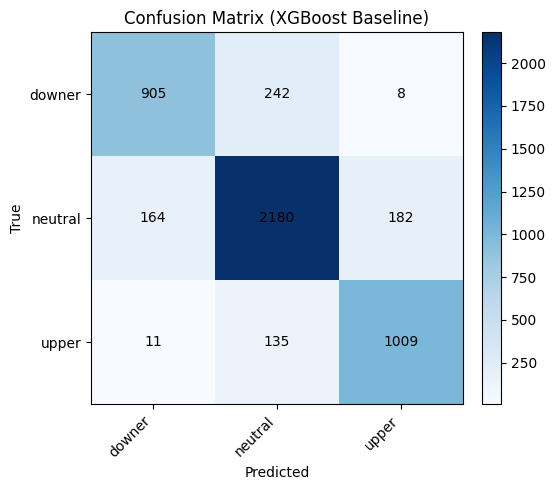

feature calendar_quarter ticker    label pred_label
9554          2025-06-30   ODFL  neutral    neutral
9555          2025-06-30   OKTA   downer     downer
9556          2025-06-30   ORLY   downer     downer
9557          2025-06-30   PANW  neutral    neutral
9558          2025-06-30   PAYX  neutral     downer
9559          2025-06-30   PCAR  neutral    neutral
9560          2025-06-30    PDD  neutral    neutral
9561          2025-06-30    PEP   downer    neutral
9562          2025-06-30   QCOM  neutral    neutral
9563          2025-06-30   REGN   downer     downer
9564          2025-06-30   ROST   downer     downer
9565          2025-06-30   SBUX  neutral    neutral
9566          2025-06-30   SNPS  neutral    neutral
9567          2025-06-30   SWKS  neutral    neutral
9568          2025-06-30   TEAM   downer     downer
9569          2025-06-30   TMUS   downer    neutral
9570          2025-06-30   TSLA  neutral    neutral
9571          2025-06-30    TXN    upper      upper
9572          2025-06-30   VRSK  neutral    neutral
9573          2025-06-30   VRSN  neutral    neutral
9574          2025-06-30   VRTX   downer     downer
9575          2025-06-30    WBA  neutral    neutral
9576          2025-06-30   WDAY   downer     downer
9577          2025-06-30    XEL   downer    neutral
9578          2025-06-30     ZS    upper      upper

In [46]:
# XGBoost baseline (time-based 70/30 split), encoded target, confusion matrix (matplotlib only)
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

assert 'panel_data_preprocessed' in globals() and isinstance(panel_data_preprocessed, pd.DataFrame)

df = panel_data_preprocessed.copy()

# Identify time key and ticker; bring index to columns if needed
if isinstance(df.index, pd.MultiIndex):
    idx_names = list(df.index.names)
    time_key = 'calendar_quarter' if 'calendar_quarter' in idx_names else idx_names[0]
    ticker_key = 'ticker' if 'ticker' in idx_names else None
    df = df.reset_index()
else:
    time_key = 'calendar_quarter' if 'calendar_quarter' in df.columns else None
    ticker_key = 'ticker' if 'ticker' in df.columns else None

assert time_key is not None, "Time key (calendar_quarter) not found."
assert ticker_key is not None, "Ticker key not found."
assert 'label' in df.columns, "'label' column not found."

# Encode target labels (downer/neutral/upper) → integers
if pd.api.types.is_categorical_dtype(df['label']):
    y = df['label'].cat.codes.values
    classes_ = list(df['label'].cat.categories)
else:
    le = LabelEncoder()
    y = le.fit_transform(df['label'].astype(str))
    classes_ = list(le.classes_)

# Feature matrix: numeric only, exclude label/time/ticker
exclude_cols = {time_key, ticker_key, 'label'}
X_cols = [c for c in df.columns if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])]
X = df[X_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).values

# Time-based 70/30 split by periods (walk-forward)
time_vals = pd.to_datetime(df[time_key]).sort_values().unique()
cut = int(0.5 * len(time_vals))
train_periods = set(time_vals[:cut])
test_periods = set(time_vals[cut:])

train_mask = df[time_key].isin(train_periods).values
test_mask = df[time_key].isin(test_periods).values

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f"Train periods: {len(train_periods)}, Test periods: {len(test_periods)}")
print(f"Train rows: {X_train.shape[0]}, Test rows: {X_test.shape[0]}")
print(f"Features: {len(X_cols)}")

# Train XGBoost classifier (simple baseline)
try:
    from xgboost import XGBClassifier
except ImportError:
    raise ImportError("xgboost not installed. pip install xgboost")

clf = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='multi:softprob',
    num_class=3,
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy and reports
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=range(len(classes_)))

print(f"\nBaseline accuracy: {acc:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=classes_))

# Matplotlib-only confusion matrix
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, cmap='Blues')
ax.set_title('Confusion Matrix (XGBoost Baseline)')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticks(range(len(classes_)))
ax.set_yticks(range(len(classes_)))
ax.set_xticklabels(classes_, rotation=45, ha='right')
ax.set_yticklabels(classes_)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Annotate counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

# Join back identifiers (not used in training) for inspection
pred_df = df.loc[test_mask, [time_key, ticker_key, 'label']].copy()
pred_df['pred_label'] = [classes_[i] for i in y_pred]
display(pred_df.tail(25))

In [47]:
# CELL 1 — Strict AFML-style dev/holdout split → save to Excel → tune ONLY on dev (Purged K-fold with purge+embargo)

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Preconditions
assert 'df' in globals() and 'time_key' in globals() and 'ticker_key' in globals() and 'classes_' in globals()
assert 'label' in df.columns, "Target 'label' missing."

# Define feature columns consistently (numeric only; exclude time/ticker/label)
exclude_cols = {time_key, ticker_key, 'label'}
X_cols = [c for c in df.columns if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])]

# 1) Split periods once into DEV (first 70%) and HOLDOUT (last 30%), save both to Excel
time_vals = pd.to_datetime(df[time_key]).sort_values().unique()
cut = int(0.5 * len(time_vals))
dev_periods     = set(time_vals[:cut])
holdout_periods = set(time_vals[cut:])

dev_df = df[df[time_key].isin(dev_periods)].copy()
holdout_df = df[df[time_key].isin(holdout_periods)].copy()

# Sanity: disjoint
assert dev_periods.isdisjoint(holdout_periods)

# Persist splits (full feature matrix with identifiers and target)
dev_df.to_excel('dev_split.xlsx', index=False)
holdout_df.to_excel('holdout_split.xlsx', index=False)
print(f"Saved dev_split.xlsx (rows={len(dev_df)}) and holdout_split.xlsx (rows={len(holdout_df)})")

# Build dev matrices
X_dev = dev_df[X_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).values
if pd.api.types.is_categorical_dtype(dev_df['label']):
    y_dev = dev_df['label'].cat.codes.values
else:
    from sklearn.preprocessing import LabelEncoder
    y_dev = LabelEncoder().fit_transform(dev_df['label'].astype(str))

# 2) Purged K-fold on DEV only (period-based approximation to AFML with purge+embargo)
def make_purged_period_folds(periods, K=5, purge=1, embargo=1):
    periods = np.array(sorted(periods))
    fold_sizes = np.full(K, len(periods)//K, dtype=int)
    fold_sizes[:len(periods)%K] += 1
    splits, start = [], 0
    for fs in fold_sizes:
        test_idx = np.arange(start, start+fs)
        test_p = periods[test_idx]
        left_excl_end = max(0, test_idx[0] - purge)
        right_excl_start = min(len(periods), test_idx[-1] + 1 + embargo + purge)
        train_left = periods[:left_excl_end]
        train_right = periods[right_excl_start:]
        train_p = np.concatenate([train_left, train_right])
        splits.append((set(train_p), set(test_p)))
        start += fs
    return splits

dev_periods_sorted = sorted(dev_periods)
purged_splits = make_purged_period_folds(dev_periods_sorted, K=5, purge=1, embargo=1)

# 3) Optuna tuning — ONLY dev data and purged CV
try:
    import optuna

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 200, 1200),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
            'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
            'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        }
        scores = []
        for train_p, test_p in purged_splits:
            m_tr = dev_df[time_key].isin(train_p).values
            m_te = dev_df[time_key].isin(test_p).values
            if not m_tr.any() or not m_te.any():
                continue
            clf = XGBClassifier(
                objective='multi:softprob', num_class=3, random_state=42, n_jobs=-1, tree_method='hist',
                n_estimators=params['n_estimators'], max_depth=params['max_depth'],
                learning_rate=params['learning_rate'], subsample=params['subsample'],
                colsample_bytree=params['colsample_bytree'], reg_lambda=params['reg_lambda'],
                reg_alpha=params['reg_alpha'], min_child_weight=params['min_child_weight'], gamma=params['gamma'],
            )
            clf.fit(X_dev[m_tr], y_dev[m_tr])
            scores.append(accuracy_score(y_dev[m_te], clf.predict(X_dev[m_te])))
        return float(np.mean(scores)) if scores else 0.0

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50, show_progress_bar=False)
    print("\nOptuna best purged-CV accuracy (DEV only):", study.best_value)
    print("Optuna best params:", study.best_params)

    # Save tuned params + feature list for the final test cell
    import json
    def _to_py(v):
        if isinstance(v, (np.floating,)): return float(v)
        if isinstance(v, (np.integer,)):  return int(v)
        return v

    best_params = {k: _to_py(v) for k, v in study.best_params.items()}
    with open('xgb_best_params.json', 'w') as f:
        json.dump(best_params, f, indent=2)
    with open('x_cols.json', 'w') as f:
        json.dump(X_cols, f, indent=2)

    print("Saved xgb_best_params.json and x_cols.json")

except Exception as e:
    print("Optuna unavailable/failed — no tuning performed:", e)

/var/folders/tc/1rlgym492m70rw7ddhrpc1_80000gn/T/ipykernel_10272/2110178392.py:35: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dev_df['label']):
[I 2025-08-14 20:55:46,340] A new study created in memory with name: no-name-288f2df9-82b8-456b-95b2-f0f33055f648


Saved dev_split.xlsx (rows=4743) and holdout_split.xlsx (rows=4836)


[I 2025-08-14 20:55:50,751] Trial 0 finished with value: 0.9264516129032258 and parameters: {'n_estimators': 390, 'max_depth': 6, 'learning_rate': 0.13188057121592073, 'subsample': 0.9510425411820129, 'colsample_bytree': 0.7853547165478838, 'reg_lambda': 4.66337831763765, 'reg_alpha': 1.2157863929014265, 'min_child_weight': 0.042556013572544085, 'gamma': 1.7713779311005036}. Best is trial 0 with value: 0.9264516129032258.
[I 2025-08-14 20:56:05,291] Trial 1 finished with value: 0.9253763440860215 and parameters: {'n_estimators': 750, 'max_depth': 10, 'learning_rate': 0.020502630764846836, 'subsample': 0.8041831101862069, 'colsample_bytree': 0.8586208468744376, 'reg_lambda': 1.6373126744974758, 'reg_alpha': 0.45277317781813387, 'min_child_weight': 0.05129035559878737, 'gamma': 1.2143059241998282}. Best is trial 0 with value: 0.9264516129032258.
[I 2025-08-14 20:56:08,654] Trial 2 finished with value: 0.9249462365591399 and parameters: {'n_estimators': 253, 'max_depth': 5, 'learning_rate


Optuna best purged-CV accuracy (DEV only): 0.9294623655913978
Optuna best params: {'n_estimators': 474, 'max_depth': 7, 'learning_rate': 0.10864274045920537, 'subsample': 0.8982601050578117, 'colsample_bytree': 0.6757283898500794, 'reg_lambda': 2.0516197131813847, 'reg_alpha': 0.7207226775817976, 'min_child_weight': 0.06397183279779743, 'gamma': 2.3701821772364613}
Saved xgb_best_params.json and x_cols.json


Loaded tuned params: {'n_estimators': 474, 'max_depth': 7, 'learning_rate': 0.10864274045920537, 'subsample': 0.8982601050578117, 'colsample_bytree': 0.6757283898500794, 'reg_lambda': 2.0516197131813847, 'reg_alpha': 0.7207226775817976, 'min_child_weight': 0.06397183279779743, 'gamma': 2.3701821772364613}


/var/folders/tc/1rlgym492m70rw7ddhrpc1_80000gn/T/ipykernel_10272/3798554147.py:36: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(d['label']):
/var/folders/tc/1rlgym492m70rw7ddhrpc1_80000gn/T/ipykernel_10272/3798554147.py:36: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(d['label']):



STRICT HOLDOUT accuracy: 0.8470

Classification report (holdout):
              precision    recall  f1-score   support

      downer       0.83      0.80      0.81      1155
     neutral       0.86      0.85      0.86      2526
       upper       0.84      0.88      0.86      1155

    accuracy                           0.85      4836
   macro avg       0.84      0.84      0.84      4836
weighted avg       0.85      0.85      0.85      4836



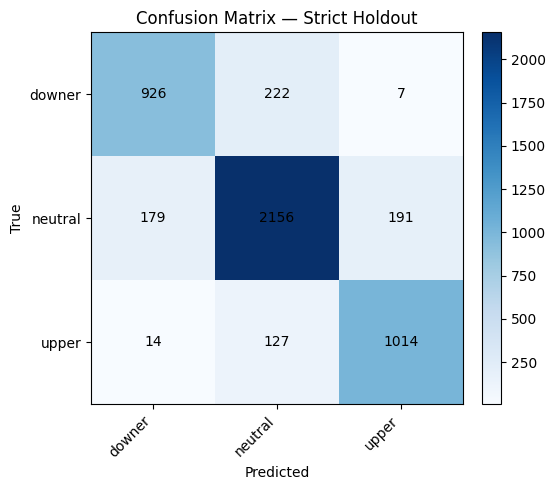

calendar_quarter ticker    label pred_label
0         2012-09-30   AAPL    upper      upper
1         2012-09-30   ADBE  neutral    neutral
2         2012-09-30    ADI  neutral    neutral
3         2012-09-30    ADP  neutral    neutral
4         2012-09-30   ADSK  neutral    neutral
..               ...    ...      ...        ...
495       2013-12-31   DDOG  neutral    neutral
496       2013-12-31   DLTR   downer    neutral
497       2013-12-31   DXCM    upper      upper
498       2013-12-31     EA   downer     downer
499       2013-12-31   EBAY  neutral    neutral

[500 rows x 4 columns]

In [48]:
# CELL 2 — Strict holdout evaluation: reload saved DEV/HOLDOUT splits, reload tuned params, refit on DEV, test ONCE on HOLDOUT

import json
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Reload splits (guarantees zero leakage)
dev_df = pd.read_excel('dev_split.xlsx')
holdout_df = pd.read_excel('holdout_split.xlsx')

assert 'time_key' in globals() and 'ticker_key' in globals() and 'classes_' in globals()

# Reload feature list and tuned params (fallback to baseline if missing)
try:
    with open('x_cols.json', 'r') as f:
        X_cols = json.load(f)
except Exception:
    # Define if x_cols.json not present
    exclude_cols = {time_key, ticker_key, 'label'}
    X_cols = [c for c in dev_df.columns if c not in exclude_cols and pd.api.types.is_numeric_dtype(dev_df[c])]

try:
    with open('xgb_best_params.json', 'r') as f:
        best_params = json.load(f)
    print("Loaded tuned params:", best_params)
except Exception:
    best_params = None
    print("No tuned params found; using baseline.")

# Build matrices with aligned columns
def build_Xy(d):
    Xd = d[X_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).values
    if pd.api.types.is_categorical_dtype(d['label']):
        yd = d['label'].cat.codes.values
    else:
        from sklearn.preprocessing import LabelEncoder
        yd = LabelEncoder().fit_transform(d['label'].astype(str))
    return Xd, yd

X_train, y_train = build_Xy(dev_df)
X_test,  y_test  = build_Xy(holdout_df)

# Final fit on ALL DEV, evaluate ONCE on HOLDOUT
if best_params:
    clf = XGBClassifier(
        n_estimators=int(best_params.get('n_estimators', 500)),
        max_depth=int(best_params.get('max_depth', 6)),
        learning_rate=float(best_params.get('learning_rate', 0.05)),
        subsample=float(best_params.get('subsample', 0.9)),
        colsample_bytree=float(best_params.get('colsample_bytree', 0.9)),
        reg_lambda=float(best_params.get('reg_lambda', 1.0)),
        reg_alpha=float(best_params.get('reg_alpha', 0.0)),
        min_child_weight=float(best_params.get('min_child_weight', 1.0)) if 'min_child_weight' in best_params else 1.0,
        gamma=float(best_params.get('gamma', 0.0)) if 'gamma' in best_params else 0.0,
        objective='multi:softprob', num_class=3,
        random_state=42, n_jobs=-1, tree_method='hist'
    )
else:
    clf = XGBClassifier(
        n_estimators=500, max_depth=6, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9,
        reg_lambda=1.0, reg_alpha=0.0,
        objective='multi:softprob', num_class=3,
        random_state=42, n_jobs=-1, tree_method='hist'
    )

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
cm  = confusion_matrix(y_test, y_pred, labels=range(len(classes_)))
print(f"\nSTRICT HOLDOUT accuracy: {acc:.4f}")
print("\nClassification report (holdout):")
print(classification_report(y_test, y_pred, target_names=classes_))

# Confusion matrix (matplotlib-only)
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, cmap='Blues')
ax.set_title('Confusion Matrix — Strict Holdout')
ax.set_xlabel('Predicted'); ax.set_ylabel('True')
ax.set_xticks(range(len(classes_))); ax.set_yticks(range(len(classes_)))
ax.set_xticklabels(classes_, rotation=45, ha='right'); ax.set_yticklabels(classes_)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.tight_layout(); plt.show()

# Attach identifiers for inspection
pred_df = holdout_df[[time_key, ticker_key, 'label']].copy()
pred_df['pred_label'] = [classes_[i] for i in y_pred]
display(pred_df.head(500))

In [49]:
print("HOLDOUT range:", holdout_df[time_key].min(), "→", holdout_df[time_key].max())
print(holdout_df[time_key].dt.to_period('Q').value_counts().sort_index().head(10))   # earliest quarters
print(holdout_df[time_key].dt.to_period('Q').value_counts().sort_index().tail(10))   # latest quarters

# show earliest holdout predictions
early_idx = holdout_df[time_key].sort_values().index[:25]
display(holdout_df.loc[early_idx, [time_key, ticker_key, 'label']].assign(
    pred_label=[classes_[i] for i in y_pred[:25]]
))

HOLDOUT range: 2012-09-30 00:00:00 → 2025-06-30 00:00:00
calendar_quarter
2012Q3    93
2012Q4    93
2013Q1    93
2013Q2    93
2013Q3    93
2013Q4    93
2014Q1    93
2014Q2    93
2014Q3    93
2014Q4    93
Freq: Q-DEC, Name: count, dtype: int64
calendar_quarter
2023Q1    93
2023Q2    93
2023Q3    93
2023Q4    93
2024Q1    93
2024Q2    93
2024Q3    93
2024Q4    93
2025Q1    93
2025Q2    93
Freq: Q-DEC, Name: count, dtype: int64


calendar_quarter ticker    label pred_label
0        2012-09-30   AAPL    upper      upper
67       2012-09-30   NXPI    upper    neutral
66       2012-09-30   NVDA  neutral    neutral
65       2012-09-30   NTES  neutral    neutral
64       2012-09-30   NFLX   downer    neutral
63       2012-09-30     MU   downer    neutral
62       2012-09-30   MSFT  neutral      upper
61       2012-09-30   MRVL   downer    neutral
60       2012-09-30   MRNA  neutral     downer
59       2012-09-30   MNST   downer    neutral
58       2012-09-30   META  neutral      upper
57       2012-09-30   MELI    upper      upper
56       2012-09-30   MDLZ  neutral    neutral
55       2012-09-30   MCHP  neutral    neutral
54       2012-09-30    MAR  neutral    neutral
53       2012-09-30   LULU    upper    neutral
52       2012-09-30   LRCX   downer    neutral
51       2012-09-30     LI  neutral     downer
50       2012-09-30   LCID  neutral    neutral
49       2012-09-30   KLAC   downer    neutral
68       2012-09-30   ODFL   downer    neutral
70       2012-09-30   ORLY  neutral    neutral
71       2012-09-30   PANW   downer      upper
72       2012-09-30   PAYX  neutral    neutral
92       2012-09-30     ZS  neutral      upper

In [50]:
backtest bouwen en EDA op de labels enzo
labels mischien vermeerderen, het overtaint nu wellicht op neutral waardoor de forward prediction wat slap is
dubbelchecken voor leakage, dan wnnr performance bekend is wellicht de 


SyntaxError: invalid syntax (1102673572.py, line 1)

In [51]:
# ROBUST FORWARD PREDICTION WITH DIAGNOSTICS
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import json
import matplotlib.pyplot as plt

# 1. Prepare data with next-quarter target
full_data = df.copy().sort_values([ticker_key, time_key])
full_data['label_next'] = full_data.groupby(ticker_key)['label'].shift(-1)

# 2. Temporal split (maintain time order)
cutoff_date = full_data[time_key].quantile(0.8)  # 80% time cutoff
train_data = full_data[full_data[time_key] < cutoff_date].dropna(subset=['label_next'])
recent_data = full_data[full_data[time_key] >= cutoff_date].dropna(subset=['label_next'])

# 3. Define features
exclude_cols = {time_key, ticker_key, 'label', 'label_next'}
X_cols = [c for c in full_data.columns if c not in exclude_cols and pd.api.types.is_numeric_dtype(full_data[c])]

# 4. Encode target
le = LabelEncoder()
y_train = le.fit_transform(train_data['label_next'])
y_recent = le.transform(recent_data['label_next'])
classes_ = le.classes_

# 5. Prepare datasets
X_train = train_data[X_cols].replace([np.inf, -np.inf], np.nan).fillna(0).values
X_recent = recent_data[X_cols].replace([np.inf, -np.inf], np.nan).fillna(0).values

# 6. Train robust model
clf = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective='multi:softprob',
    num_class=len(classes_),
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)
clf.fit(X_train, y_train)

# 7. Validate on recent period (not latest)
print("\nValidation on recent period:")
recent_preds = clf.predict(X_recent)
recent_data['pred'] = [classes_[i] for i in recent_preds]
print("Prediction distribution in recent period:")
print(recent_data['pred'].value_counts(normalize=True))
print("\nActual distribution in recent period:")
print(recent_data['label_next'].value_counts(normalize=True))

# 8. Predict next quarter for latest data
latest_t = full_data[time_key].max()
next_q = (pd.Period(latest_t, 'Q') + 1).to_timestamp('Q')
latest_df = full_data[full_data[time_key] == latest_t].copy()
X_latest = latest_df[X_cols].replace([np.inf, -np.inf], np.nan).fillna(0).values

# Generate predictions
probas = clf.predict_proba(X_latest)
pred_indices = np.argmax(probas, axis=1)
forward_pred = latest_df[[time_key, ticker_key]].copy()
forward_pred['next_quarter'] = next_q
forward_pred['predicted_label'] = [classes_[i] for i in pred_indices]

# 9. Feature diagnostics (latest vs historical)
print("\nFeature diagnostics (latest vs historical):")
for col in X_cols[:10]:  # First 10 features
    train_mean = train_data[col].mean()
    latest_mean = latest_df[col].mean()
    diff_pct = abs(latest_mean - train_mean) / train_mean * 100
    print(f"{col}: Historical={train_mean:.4f}, Latest={latest_mean:.4f}, Diff={diff_pct:.1f}%")

# 10. Save and show results
forward_pred.to_excel('forward_predictions.xlsx', index=False)
print(f"\nGenerated forward predictions for {next_q.date()}")
print("Final prediction distribution:")
print(forward_pred['predicted_label'].value_counts(normalize=True))
display(forward_pred.head(25))


Validation on recent period:
Prediction distribution in recent period:
pred
neutral    0.720430
upper      0.166667
downer     0.112903
Name: proportion, dtype: float64

Actual distribution in recent period:
label_next
neutral    0.490323
downer     0.254839
upper      0.254839
Name: proportion, dtype: float64

Feature diagnostics (latest vs historical):
high_3m: Historical=0.0000, Latest=-0.0000, Diff=inf%
low_3m: Historical=-0.0000, Latest=0.0000, Diff=-203.4%
dist_to_high_3m: Historical=-0.0000, Latest=0.0000, Diff=-1769.8%
dist_to_low_3m: Historical=0.0000, Latest=-0.0000, Diff=335.7%
price_range_abs_3m: Historical=0.0000, Latest=-0.0000, Diff=inf%
price_range_pct_3m: Historical=0.0000, Latest=0.0000, Diff=17.9%
high_6m: Historical=-0.0000, Latest=-0.0000, Diff=-56.6%
low_6m: Historical=-0.0000, Latest=0.0000, Diff=-237.4%
dist_to_high_6m: Historical=-0.0000, Latest=0.0000, Diff=-1037.7%
dist_to_low_6m: Historical=0.0000, Latest=0.0000, Diff=251.6%

Generated forward predictions f

/var/folders/tc/1rlgym492m70rw7ddhrpc1_80000gn/T/ipykernel_10272/282852734.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  diff_pct = abs(latest_mean - train_mean) / train_mean * 100


feature calendar_quarter ticker next_quarter predicted_label
9486          2025-06-30   AAPL   2025-09-30         neutral
9487          2025-06-30   ADBE   2025-09-30         neutral
9488          2025-06-30    ADI   2025-09-30         neutral
9489          2025-06-30    ADP   2025-09-30         neutral
9490          2025-06-30   ADSK   2025-09-30         neutral
9491          2025-06-30    AEP   2025-09-30         neutral
9492          2025-06-30   ALGN   2025-09-30           upper
9493          2025-06-30   AMAT   2025-09-30         neutral
9494          2025-06-30    AMD   2025-09-30          downer
9495          2025-06-30   AMGN   2025-09-30         neutral
9496          2025-06-30   AMZN   2025-09-30         neutral
9497          2025-06-30   ANSS   2025-09-30         neutral
9498          2025-06-30   ASML   2025-09-30          downer
9499          2025-06-30   AVGO   2025-09-30          downer
9500          2025-06-30    AZN   2025-09-30         neutral
9501          2025-06-30   BIDU   2025-09-30         neutral
9502          2025-06-30   BIIB   2025-09-30         neutral
9503          2025-06-30   BKNG   2025-09-30           upper
9504          2025-06-30    BKR   2025-09-30         neutral
9505          2025-06-30   CDNS   2025-09-30           upper
9506          2025-06-30    CEG   2025-09-30         neutral
9507          2025-06-30   CHTR   2025-09-30          downer
9508          2025-06-30  CMCSA   2025-09-30         neutral
9509          2025-06-30   COST   2025-09-30         neutral
9510          2025-06-30   CPRT   2025-09-30         neutral

In [ ]:
# rolling forward imputation

# winsorization / log transformations

# z-scoring

# sparse features

# features cleanen blabla bla bla

In [ ]:
ridge regression or log regression and XGBregressor and XGBclassifier

labels >1 >2 >3 >4 5 6 7 8 9 10 % gain
en RMSE ding voor percentages beide testen ig

SyntaxError: invalid syntax (3989343529.py, line 1)

In [ ]:
Most important predictors (paper’s ranking):
FCF/P (free cash flow yield) — top driver. 

Book-to-Market (B/M) — strong value effect. 

TEV / Size (smaller firms better) — logged TEV negative payoff. 

EBITDA margin / ROA — profitability matters (paper prefers EBITDA or ROA depending on spec). 

Investment pattern (Inv_dummy) = 1 if asset growth > EBITDA growth — this is a severe negative signal (paper reports coefficient ≈ −22.79 in the upgraded static model). Paper treats this as a hard exclusion or heavy penalty. 

Price-range / price position relative to 12-month high/low — entry near 12m low and prior 6-month fall improves future returns; closeness to 12m high is negative. 

Momentum — complex: short momentum (1m) sometimes positive; 3/6m often negative (rapid reversals). So momentum signals must be handled carefully. 

Macroeconomic overlay: rising Fed rates reduce next-year returns (≈ −8% to −12% in some specs) — paper uses this as a macro control, not for stock selection. 

Hard filters used in the paper: exclude firms with missing TEV/marketcap, exclude “transitory” multibaggers, exclude firms failing data completeness, and exclude firms where Inv_dummy == 1 (or treat heavily negative). The study also restricts to major exchanges and enforces liquidity/size constraints in sample construction

SyntaxError: invalid character '’' (U+2019) (3791339177.py, line 1)

In [ ]:
# er zijn dus meer features maar ik wil voor nu even de pipeline bouwen kijken hoe ver ik kom want ja backtest enzo, hier onder is een grote lijst van mogelijk features die met colsample goed gefiltreert moeten kunnen worden mits tickers gerespecteert worden. maar wil t nu even zo doen zeker als ik opschaal naar meer aandelen

In [ ]:
A — Additional valuation / cash-flow ratios (high priority)
FCF/TEV (FCF divided by enterprise value) — complements FCF/Price.

EV/FCF (inverse of above).

MarketCap / BookValue (P/B alternative).

Tangible Book / MarketCap (if tangible book available).

Dividend yield and payout ratio (dividends / NetIncome or dividends / FCF).

Share buyback rate / issuance (buybacks as % shares outstanding over last 12 months).

B — Leverage / coverage / liquidity (high priority)
NetDebt / EBITDA (net-debt normalized to EBITDA).

InterestCoverage = EBITDA / InterestExpense (or EBIT / interest).

Current ratio = CurrentAssets / CurrentLiabilities.

Quick ratio ( (CurrentAssets − Inventory) / CurrentLiabilities ).

Cash / MarketCap and Cash / Assets (you have these but ensure they are present).

C — Quality / efficiency (high priority)
Operating cash flow margin = OperatingCashFlow / Revenue.

Capex / Sales and Capex / Assets (capex intensity).

Working capital / Sales and ΔWorkingCapital / Sales.

Accruals = (NetIncome − OperatingCashFlow) / TotalAssets. (low-quality earnings signal)

Revenue per employee and asset turnover = Revenue / TotalAssets.

D — Growth / stability (medium priority)
FCF growth (yoy & 3yr CAGR) (even if growth wasn't a top predictor, include it).

EBITDA margin stability (std dev of EBITDA margin over last 3–5 years).

Revenue growth volatility (std of yoy revenue growth).

EPS dilution = (shares_outstanding_t − shares_outstanding_{t-4}) / shares_outstanding_{t-4}.

E — Corporate actions / ownership (medium priority)
Net insider transactions (12m) (you mentioned) — include as signed amount / % of float.

Institutional ownership % and Δ over 12m.

Analyst coverage (# analysts) and revisions (upgrades / downgrades counts or change in mean target).

Short interest % of float (sentiment / vulnerability to squeezes).

F — Accounting & distress (medium/low priority)
Altman Z-score (bankruptcy risk).

Piotroski F-score or a few of its components (profitability, leverage, liquidity, operating efficiency).

Beneish M-score (earnings manipulation indicator) if you want to be fancy.

G — Technical & volatility features (highly useful for entry timing)
Momentum: returns at 1m, 3m, 6m, 12m, 24m. (paper uses multiple horizons)

RSI (14-day or 30-day) — you suggested this; useful for short-term timing.

ATR (Average True Range) / Price or realized volatility (30d, 90d).

Rolling volatility (1y) and beta (covariance with market).

Distance to 52-week high / low (you already have).

50-day and 200-day SMA crossover (e.g., price / SMA50, price / SMA200).

Max drawdown from high in last 12m.

H — Liquidity & trading features (important for execution)
ADV (30d, 90d) and dollar volume.

Float % (free float as % of shares).

Turnover = volume / shares_outstanding (recent average).

In [ ]:
# Quarterly-only long panel from master_df (Method 1)
import pandas as pd


def wide_to_panel_long_quarterly(df: pd.DataFrame, index_name: str = "calendar_quarter") -> pd.DataFrame:
    if df is None or df.empty:
        raise ValueError("Input DataFrame is empty.")

    df2 = df.copy()
    columns_series = df2.columns.to_series().astype(str)
    split = columns_series.str.split("_", n=1, expand=True)

    if split.shape[1] != 2:
        raise ValueError("Expected columns formatted as '<TICKER>_<FEATURE>'.")

    split.columns = ["ticker", "feature"]
    valid_mask = split["ticker"].notna() & split["feature"].notna() & (split["ticker"] != "")

    # Keep only valid columns following the ticker_feature pattern
    df2 = df2.loc[:, valid_mask.values]
    split = split[valid_mask]

    df2.columns = pd.MultiIndex.from_frame(split, names=["ticker", "feature"])
    long_df = df2.stack(level="ticker", future_stack=True).sort_index()
    long_df.index = long_df.index.set_names([index_name, "ticker"])
    return long_df

# Build quarterly long panel from the already-quarterly master_df
panel_long = wide_to_panel_long_quarterly(master_df, index_name="calendar_quarter")
print("panel_long (quarterly):", panel_long.shape)

# Quick sample for review
display(panel_long.tail(25).iloc[:, :12])

# Optional: save for fast reload
# panel_long.to_parquet("panel_long_quarterly.parquet")

